## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (512, 614)
Hypercube shape: (512, 614, 176)


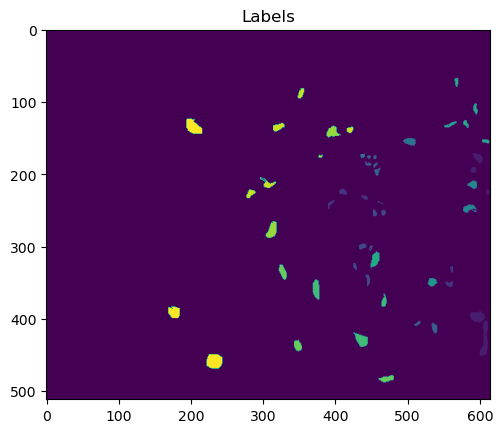

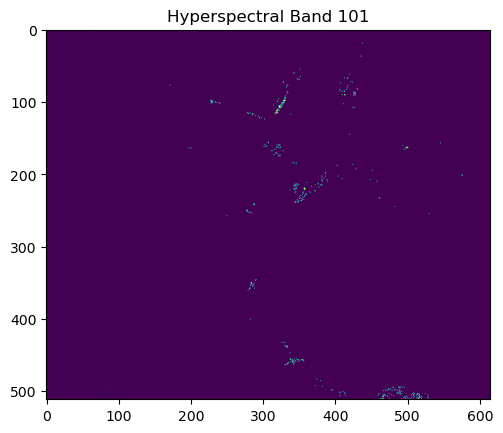

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'KSC_gt.mat'
data_files = 'KSC.mat'
label_files = 'KSC_gt'
hypercube_files = 'KSC'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 5211
Extracted windows shape: (5211, 5, 5, 176)
Corresponding labels shape: (5211,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 40)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [ 1  2  3  4  5  6  7  8  9 10 11 12 13]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 761 samples
Shuffled class indices for class '1'
Selected 40 training samples and 5 validation samples for class '1'

Class: 2: Found 243 samples
Shuffled class indices for class '2'
Selected 40 training samples and 5 validation samples for class '2'

Class: 3: Found 256 samples
Shuffled class indices for class '3'
Selected 40 training samples and 5 validation samples for class '3'

Class: 4: Found 252 samples
Shuffled class indices for class '4'
Selected 40 training samples and 5 validation samples for class '4'

Class: 5: Found 161 samples
Shuffled class indices for class '5'
Selected 40 training samples and 5 validation samples for class '5'

Class: 6: Found 229 samples
Shuffled class indices for class '6'
Selected 40 training samples and 5 validation samples for class '6'

Class: 7: Found 105 samples
Shuffled class indices for class '7'
Sele


All datasets saved to the 'indices' folder.
(520, 5, 5, 176)
(65, 5, 5, 176)
(4626, 5, 5, 176)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 2 applied
DataLoaders created successfully!
Training batch size: 260
Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (4168, 5, 5, 176)
Validation data shape: (1043, 5, 5, 176)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

176


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/66], Loss: 0.2523, PSNR: 5.9813


Epoch [1/50] Training Loss: 0.2424, PSNR: 6.1565
	[Val]   Batch [1/17] Loss: 0.2312, PSNR: 6.3608
	[Val]   Batch [10/17] Loss: 0.2313, PSNR: 6.3576
Epoch [1/50] Validation Loss: 0.2312, PSNR: 6.3596

LOG: Epoch [2/50]
	 Training Batch [1/66], Loss: 0.2225, PSNR: 6.5258


Epoch [2/50] Training Loss: 0.2087, PSNR: 6.8093
	[Val]   Batch [1/17] Loss: 0.1861, PSNR: 7.3036
	[Val]   Batch [10/17] Loss: 0.1876, PSNR: 7.2688
Epoch [2/50] Validation Loss: 0.1870, PSNR: 7.2805

LOG: Epoch [3/50]
	 Training Batch [1/66], Loss: 0.1850, PSNR: 7.3293


Epoch [3/50] Training Loss: 0.1712, PSNR: 6.9746
	[Val]   Batch [1/17] Loss: 0.1479, PSNR: 8.2993
	[Val]   Batch [10/17] Loss: 0.1512, PSNR: 8.2057
Epoch [3/50] Validation Loss: 0.1502, PSNR: 8.2348

LOG: Epoch [4/50]
	 Training Batch [1/66], Loss: 0.1514, PSNR: 8.1975


Epoch [4/50] Training Loss: 0.1385, PSNR: 8.5946
	[Val]   Batch [1/17] Loss: 0.1206, PSNR: 9.1873
	[Val]   Batch [10/17] Loss: 0.1224, PSNR: 9.1234
Epoch [4/50] Validation Loss: 0.1218, PSNR: 9.1434

LOG: Epoch [5/50]
	 Training Batch [1/66], Loss: 0.1208, PSNR: 9.1776


Epoch [5/50] Training Loss: 0.1103, PSNR: 9.5820
	[Val]   Batch [1/17] Loss: 0.0950, PSNR: 10.2218
	[Val]   Batch [10/17] Loss: 0.0973, PSNR: 10.1211
Epoch [5/50] Validation Loss: 0.0966, PSNR: 10.1525

LOG: Epoch [6/50]
	 Training Batch [1/66], Loss: 0.0957, PSNR: 10.1893


Epoch [6/50] Training Loss: 0.0877, PSNR: 9.8856
	[Val]   Batch [1/17] Loss: 0.0773, PSNR: 11.1179
	[Val]   Batch [10/17] Loss: 0.0786, PSNR: 11.0477
Epoch [6/50] Validation Loss: 0.0780, PSNR: 11.0779

LOG: Epoch [7/50]
	 Training Batch [1/66], Loss: 0.0762, PSNR: 11.1785


Epoch [7/50] Training Loss: 0.0703, PSNR: 11.5356
	[Val]   Batch [1/17] Loss: 0.0623, PSNR: 12.0554
	[Val]   Batch [10/17] Loss: 0.0633, PSNR: 11.9887
Epoch [7/50] Validation Loss: 0.0630, PSNR: 12.0083

LOG: Epoch [8/50]
	 Training Batch [1/66], Loss: 0.0614, PSNR: 12.1193


Epoch [8/50] Training Loss: 0.0571, PSNR: 12.4402
	[Val]   Batch [1/17] Loss: 0.0518, PSNR: 12.8590
	[Val]   Batch [10/17] Loss: 0.0524, PSNR: 12.8044
Epoch [8/50] Validation Loss: 0.0523, PSNR: 12.8153

LOG: Epoch [9/50]
	 Training Batch [1/66], Loss: 0.0509, PSNR: 12.9350


Epoch [9/50] Training Loss: 0.0471, PSNR: 12.5857
	[Val]   Batch [1/17] Loss: 0.0436, PSNR: 13.6016
	[Val]   Batch [10/17] Loss: 0.0442, PSNR: 13.5481
Epoch [9/50] Validation Loss: 0.0439, PSNR: 13.5725

LOG: Epoch [10/50]
	 Training Batch [1/66], Loss: 0.0420, PSNR: 13.7662


Epoch [10/50] Training Loss: 0.0395, PSNR: 13.3578
	[Val]   Batch [1/17] Loss: 0.0367, PSNR: 14.3484
	[Val]   Batch [10/17] Loss: 0.0370, PSNR: 14.3144
Epoch [10/50] Validation Loss: 0.0370, PSNR: 14.3237

LOG: Epoch [11/50]
	 Training Batch [1/66], Loss: 0.0358, PSNR: 14.4646


Epoch [11/50] Training Loss: 0.0337, PSNR: 14.7322
	[Val]   Batch [1/17] Loss: 0.0316, PSNR: 15.0067
	[Val]   Batch [10/17] Loss: 0.0320, PSNR: 14.9503
Epoch [11/50] Validation Loss: 0.0319, PSNR: 14.9640

LOG: Epoch [12/50]
	 Training Batch [1/66], Loss: 0.0307, PSNR: 15.1218


Epoch [12/50] Training Loss: 0.0291, PSNR: 15.3705
	[Val]   Batch [1/17] Loss: 0.0275, PSNR: 15.6067
	[Val]   Batch [10/17] Loss: 0.0276, PSNR: 15.5839
Epoch [12/50] Validation Loss: 0.0276, PSNR: 15.5832

LOG: Epoch [13/50]
	 Training Batch [1/66], Loss: 0.0267, PSNR: 15.7420


Epoch [13/50] Training Loss: 0.0254, PSNR: 15.9549
	[Val]   Batch [1/17] Loss: 0.0243, PSNR: 16.1478
	[Val]   Batch [10/17] Loss: 0.0245, PSNR: 16.1112
Epoch [13/50] Validation Loss: 0.0245, PSNR: 16.1105

LOG: Epoch [14/50]
	 Training Batch [1/66], Loss: 0.0233, PSNR: 16.3193


Epoch [14/50] Training Loss: 0.0224, PSNR: 16.4971
	[Val]   Batch [1/17] Loss: 0.0214, PSNR: 16.6883
	[Val]   Batch [10/17] Loss: 0.0217, PSNR: 16.6350
Epoch [14/50] Validation Loss: 0.0216, PSNR: 16.6509

LOG: Epoch [15/50]
	 Training Batch [1/66], Loss: 0.0208, PSNR: 16.8192


Epoch [15/50] Training Loss: 0.0199, PSNR: 16.3301
	[Val]   Batch [1/17] Loss: 0.0194, PSNR: 17.1276
	[Val]   Batch [10/17] Loss: 0.0196, PSNR: 17.0707
Epoch [15/50] Validation Loss: 0.0196, PSNR: 17.0880

LOG: Epoch [16/50]
	 Training Batch [1/66], Loss: 0.0188, PSNR: 17.2551


Epoch [16/50] Training Loss: 0.0179, PSNR: 17.4752
	[Val]   Batch [1/17] Loss: 0.0173, PSNR: 17.6198
	[Val]   Batch [10/17] Loss: 0.0175, PSNR: 17.5673
Epoch [16/50] Validation Loss: 0.0174, PSNR: 17.5857

LOG: Epoch [17/50]
	 Training Batch [1/66], Loss: 0.0168, PSNR: 17.7474


Epoch [17/50] Training Loss: 0.0162, PSNR: 17.2335
	[Val]   Batch [1/17] Loss: 0.0159, PSNR: 17.9916
	[Val]   Batch [10/17] Loss: 0.0161, PSNR: 17.9227
Epoch [17/50] Validation Loss: 0.0161, PSNR: 17.9444

LOG: Epoch [18/50]
	 Training Batch [1/66], Loss: 0.0154, PSNR: 18.1380


Epoch [18/50] Training Loss: 0.0147, PSNR: 18.3204
	[Val]   Batch [1/17] Loss: 0.0143, PSNR: 18.4467
	[Val]   Batch [10/17] Loss: 0.0145, PSNR: 18.3953
Epoch [18/50] Validation Loss: 0.0144, PSNR: 18.4077

LOG: Epoch [19/50]
	 Training Batch [1/66], Loss: 0.0138, PSNR: 18.6003


Epoch [19/50] Training Loss: 0.0134, PSNR: 18.0311
	[Val]   Batch [1/17] Loss: 0.0133, PSNR: 18.7563
	[Val]   Batch [10/17] Loss: 0.0135, PSNR: 18.6808
Epoch [19/50] Validation Loss: 0.0135, PSNR: 18.7064

LOG: Epoch [20/50]
	 Training Batch [1/66], Loss: 0.0126, PSNR: 18.9930


Epoch [20/50] Training Loss: 0.0123, PSNR: 19.0862
	[Val]   Batch [1/17] Loss: 0.0120, PSNR: 19.2118
	[Val]   Batch [10/17] Loss: 0.0122, PSNR: 19.1465
Epoch [20/50] Validation Loss: 0.0121, PSNR: 19.1642

LOG: Epoch [21/50]
	 Training Batch [1/66], Loss: 0.0116, PSNR: 19.3418


Epoch [21/50] Training Loss: 0.0114, PSNR: 19.4272
	[Val]   Batch [1/17] Loss: 0.0112, PSNR: 19.5045
	[Val]   Batch [10/17] Loss: 0.0114, PSNR: 19.4439
Epoch [21/50] Validation Loss: 0.0113, PSNR: 19.4612

LOG: Epoch [22/50]
	 Training Batch [1/66], Loss: 0.0110, PSNR: 19.5978


Epoch [22/50] Training Loss: 0.0106, PSNR: 19.0813
	[Val]   Batch [1/17] Loss: 0.0105, PSNR: 19.8031
	[Val]   Batch [10/17] Loss: 0.0106, PSNR: 19.7379
Epoch [22/50] Validation Loss: 0.0106, PSNR: 19.7534

LOG: Epoch [23/50]
	 Training Batch [1/66], Loss: 0.0099, PSNR: 20.0401


Epoch [23/50] Training Loss: 0.0098, PSNR: 19.3935
	[Val]   Batch [1/17] Loss: 0.0098, PSNR: 20.0862
	[Val]   Batch [10/17] Loss: 0.0100, PSNR: 20.0145
Epoch [23/50] Validation Loss: 0.0099, PSNR: 20.0341

LOG: Epoch [24/50]
	 Training Batch [1/66], Loss: 0.0092, PSNR: 20.3551


Epoch [24/50] Training Loss: 0.0092, PSNR: 19.7159
	[Val]   Batch [1/17] Loss: 0.0091, PSNR: 20.3981
	[Val]   Batch [10/17] Loss: 0.0093, PSNR: 20.3280
Epoch [24/50] Validation Loss: 0.0092, PSNR: 20.3479

LOG: Epoch [25/50]
	 Training Batch [1/66], Loss: 0.0087, PSNR: 20.5837


Epoch [25/50] Training Loss: 0.0086, PSNR: 20.6799
	[Val]   Batch [1/17] Loss: 0.0085, PSNR: 20.7150
	[Val]   Batch [10/17] Loss: 0.0086, PSNR: 20.6345
Epoch [25/50] Validation Loss: 0.0086, PSNR: 20.6584

LOG: Epoch [26/50]
	 Training Batch [1/66], Loss: 0.0082, PSNR: 20.8837


Epoch [26/50] Training Loss: 0.0080, PSNR: 20.2779
	[Val]   Batch [1/17] Loss: 0.0080, PSNR: 20.9510
	[Val]   Batch [10/17] Loss: 0.0082, PSNR: 20.8759
Epoch [26/50] Validation Loss: 0.0081, PSNR: 20.8992

LOG: Epoch [27/50]
	 Training Batch [1/66], Loss: 0.0077, PSNR: 21.1557


Epoch [27/50] Training Loss: 0.0075, PSNR: 21.2223
	[Val]   Batch [1/17] Loss: 0.0075, PSNR: 21.2656
	[Val]   Batch [10/17] Loss: 0.0076, PSNR: 21.1888
Epoch [27/50] Validation Loss: 0.0076, PSNR: 21.2074

LOG: Epoch [28/50]
	 Training Batch [1/66], Loss: 0.0074, PSNR: 21.3319


Epoch [28/50] Training Loss: 0.0071, PSNR: 21.4810
	[Val]   Batch [1/17] Loss: 0.0070, PSNR: 21.5533
	[Val]   Batch [10/17] Loss: 0.0071, PSNR: 21.4662
Epoch [28/50] Validation Loss: 0.0071, PSNR: 21.4911

LOG: Epoch [29/50]
	 Training Batch [1/66], Loss: 0.0070, PSNR: 21.5520


Epoch [29/50] Training Loss: 0.0067, PSNR: 21.0720
	[Val]   Batch [1/17] Loss: 0.0067, PSNR: 21.7449
	[Val]   Batch [10/17] Loss: 0.0068, PSNR: 21.6540
Epoch [29/50] Validation Loss: 0.0068, PSNR: 21.6791

LOG: Epoch [30/50]
	 Training Batch [1/66], Loss: 0.0063, PSNR: 21.9772


Epoch [30/50] Training Loss: 0.0063, PSNR: 21.9819
	[Val]   Batch [1/17] Loss: 0.0063, PSNR: 21.9912
	[Val]   Batch [10/17] Loss: 0.0065, PSNR: 21.8974
Epoch [30/50] Validation Loss: 0.0064, PSNR: 21.9245

LOG: Epoch [31/50]
	 Training Batch [1/66], Loss: 0.0060, PSNR: 22.2035


Epoch [31/50] Training Loss: 0.0060, PSNR: 22.2158
	[Val]   Batch [1/17] Loss: 0.0059, PSNR: 22.2778
	[Val]   Batch [10/17] Loss: 0.0061, PSNR: 22.1776
Epoch [31/50] Validation Loss: 0.0060, PSNR: 22.2057

LOG: Epoch [32/50]
	 Training Batch [1/66], Loss: 0.0057, PSNR: 22.4388


Epoch [32/50] Training Loss: 0.0057, PSNR: 22.4517
	[Val]   Batch [1/17] Loss: 0.0056, PSNR: 22.4966
	[Val]   Batch [10/17] Loss: 0.0058, PSNR: 22.3896
Epoch [32/50] Validation Loss: 0.0057, PSNR: 22.4215

LOG: Epoch [33/50]
	 Training Batch [1/66], Loss: 0.0056, PSNR: 22.5266


Epoch [33/50] Training Loss: 0.0054, PSNR: 22.6729
	[Val]   Batch [1/17] Loss: 0.0053, PSNR: 22.7327
	[Val]   Batch [10/17] Loss: 0.0055, PSNR: 22.6169
Epoch [33/50] Validation Loss: 0.0054, PSNR: 22.6522

LOG: Epoch [34/50]
	 Training Batch [1/66], Loss: 0.0054, PSNR: 22.7022


Epoch [34/50] Training Loss: 0.0051, PSNR: 22.8886
	[Val]   Batch [1/17] Loss: 0.0051, PSNR: 22.9159
	[Val]   Batch [10/17] Loss: 0.0052, PSNR: 22.8015
Epoch [34/50] Validation Loss: 0.0052, PSNR: 22.8364

LOG: Epoch [35/50]
	 Training Batch [1/66], Loss: 0.0050, PSNR: 23.0359


Epoch [35/50] Training Loss: 0.0049, PSNR: 23.0916
	[Val]   Batch [1/17] Loss: 0.0049, PSNR: 23.1213
	[Val]   Batch [10/17] Loss: 0.0050, PSNR: 23.0009
Epoch [35/50] Validation Loss: 0.0050, PSNR: 23.0330

LOG: Epoch [36/50]
	 Training Batch [1/66], Loss: 0.0047, PSNR: 23.3066


Epoch [36/50] Training Loss: 0.0047, PSNR: 23.3004
	[Val]   Batch [1/17] Loss: 0.0046, PSNR: 23.3345
	[Val]   Batch [10/17] Loss: 0.0048, PSNR: 23.2060
Epoch [36/50] Validation Loss: 0.0047, PSNR: 23.2412

LOG: Epoch [37/50]
	 Training Batch [1/66], Loss: 0.0045, PSNR: 23.4830


Epoch [37/50] Training Loss: 0.0045, PSNR: 23.5068
	[Val]   Batch [1/17] Loss: 0.0044, PSNR: 23.5350
	[Val]   Batch [10/17] Loss: 0.0046, PSNR: 23.4042
Epoch [37/50] Validation Loss: 0.0045, PSNR: 23.4406

LOG: Epoch [38/50]
	 Training Batch [1/66], Loss: 0.0043, PSNR: 23.6232


Epoch [38/50] Training Loss: 0.0043, PSNR: 23.6879
	[Val]   Batch [1/17] Loss: 0.0043, PSNR: 23.7057
	[Val]   Batch [10/17] Loss: 0.0044, PSNR: 23.5711
Epoch [38/50] Validation Loss: 0.0044, PSNR: 23.6121

LOG: Epoch [39/50]
	 Training Batch [1/66], Loss: 0.0040, PSNR: 23.9537


Epoch [39/50] Training Loss: 0.0041, PSNR: 23.8799
	[Val]   Batch [1/17] Loss: 0.0040, PSNR: 23.9353
	[Val]   Batch [10/17] Loss: 0.0042, PSNR: 23.7901
Epoch [39/50] Validation Loss: 0.0041, PSNR: 23.8329

LOG: Epoch [40/50]
	 Training Batch [1/66], Loss: 0.0039, PSNR: 24.0737


Epoch [40/50] Training Loss: 0.0039, PSNR: 24.0633
	[Val]   Batch [1/17] Loss: 0.0039, PSNR: 24.1263
	[Val]   Batch [10/17] Loss: 0.0040, PSNR: 23.9744
Epoch [40/50] Validation Loss: 0.0040, PSNR: 24.0188

LOG: Epoch [41/50]
	 Training Batch [1/66], Loss: 0.0040, PSNR: 23.9307


Epoch [41/50] Training Loss: 0.0038, PSNR: 23.5659
	[Val]   Batch [1/17] Loss: 0.0037, PSNR: 24.2859
	[Val]   Batch [10/17] Loss: 0.0039, PSNR: 24.1314
Epoch [41/50] Validation Loss: 0.0038, PSNR: 24.1798

LOG: Epoch [42/50]
	 Training Batch [1/66], Loss: 0.0037, PSNR: 24.3279


Epoch [42/50] Training Loss: 0.0036, PSNR: 24.4266
	[Val]   Batch [1/17] Loss: 0.0036, PSNR: 24.4627
	[Val]   Batch [10/17] Loss: 0.0037, PSNR: 24.3048
Epoch [42/50] Validation Loss: 0.0037, PSNR: 24.3514

LOG: Epoch [43/50]
	 Training Batch [1/66], Loss: 0.0034, PSNR: 24.6421


Epoch [43/50] Training Loss: 0.0035, PSNR: 24.6051
	[Val]   Batch [1/17] Loss: 0.0034, PSNR: 24.6464
	[Val]   Batch [10/17] Loss: 0.0036, PSNR: 24.4794
Epoch [43/50] Validation Loss: 0.0035, PSNR: 24.5296

LOG: Epoch [44/50]
	 Training Batch [1/66], Loss: 0.0033, PSNR: 24.8378


Epoch [44/50] Training Loss: 0.0033, PSNR: 24.0911
	[Val]   Batch [1/17] Loss: 0.0033, PSNR: 24.7959
	[Val]   Batch [10/17] Loss: 0.0035, PSNR: 24.6143
Epoch [44/50] Validation Loss: 0.0034, PSNR: 24.6709

LOG: Epoch [45/50]
	 Training Batch [1/66], Loss: 0.0032, PSNR: 24.9661


Epoch [45/50] Training Loss: 0.0032, PSNR: 24.9456
	[Val]   Batch [1/17] Loss: 0.0032, PSNR: 24.9710
	[Val]   Batch [10/17] Loss: 0.0033, PSNR: 24.7843
Epoch [45/50] Validation Loss: 0.0033, PSNR: 24.8429

LOG: Epoch [46/50]
	 Training Batch [1/66], Loss: 0.0030, PSNR: 25.1970


Epoch [46/50] Training Loss: 0.0031, PSNR: 25.0943
	[Val]   Batch [1/17] Loss: 0.0030, PSNR: 25.1743
	[Val]   Batch [10/17] Loss: 0.0032, PSNR: 24.9855
Epoch [46/50] Validation Loss: 0.0031, PSNR: 25.0446

LOG: Epoch [47/50]
	 Training Batch [1/66], Loss: 0.0029, PSNR: 25.3500


Epoch [47/50] Training Loss: 0.0030, PSNR: 24.5829
	[Val]   Batch [1/17] Loss: 0.0029, PSNR: 25.3019
	[Val]   Batch [10/17] Loss: 0.0031, PSNR: 25.1022
Epoch [47/50] Validation Loss: 0.0030, PSNR: 25.1683

LOG: Epoch [48/50]
	 Training Batch [1/66], Loss: 0.0030, PSNR: 25.2385


Epoch [48/50] Training Loss: 0.0029, PSNR: 25.4099
	[Val]   Batch [1/17] Loss: 0.0028, PSNR: 25.4895
	[Val]   Batch [10/17] Loss: 0.0030, PSNR: 25.2900
Epoch [48/50] Validation Loss: 0.0029, PSNR: 25.3537

LOG: Epoch [49/50]
	 Training Batch [1/66], Loss: 0.0027, PSNR: 25.6371


Epoch [49/50] Training Loss: 0.0028, PSNR: 25.5632
	[Val]   Batch [1/17] Loss: 0.0028, PSNR: 25.5924
	[Val]   Batch [10/17] Loss: 0.0029, PSNR: 25.3866
Epoch [49/50] Validation Loss: 0.0029, PSNR: 25.4521

LOG: Epoch [50/50]
	 Training Batch [1/66], Loss: 0.0028, PSNR: 25.4719


Epoch [50/50] Training Loss: 0.0027, PSNR: 25.0277
	[Val]   Batch [1/17] Loss: 0.0027, PSNR: 25.7455
	[Val]   Batch [10/17] Loss: 0.0028, PSNR: 25.5304
Epoch [50/50] Validation Loss: 0.0028, PSNR: 25.6004


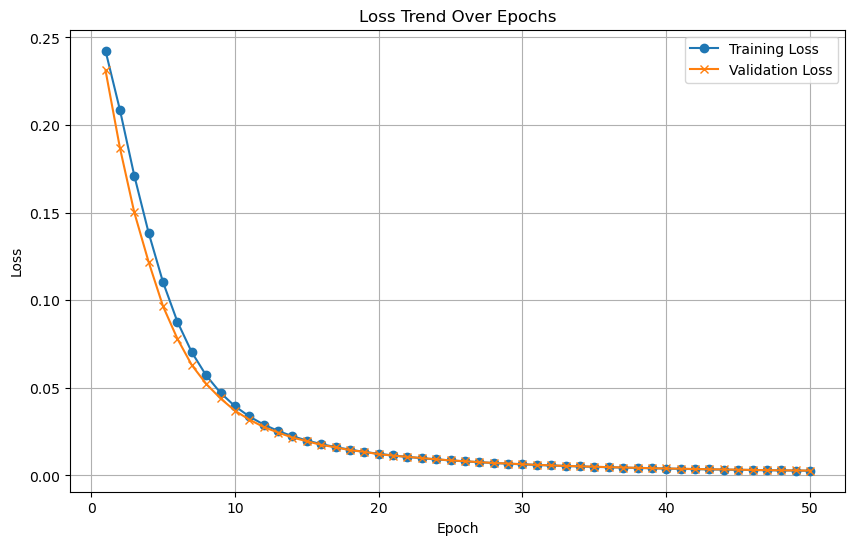

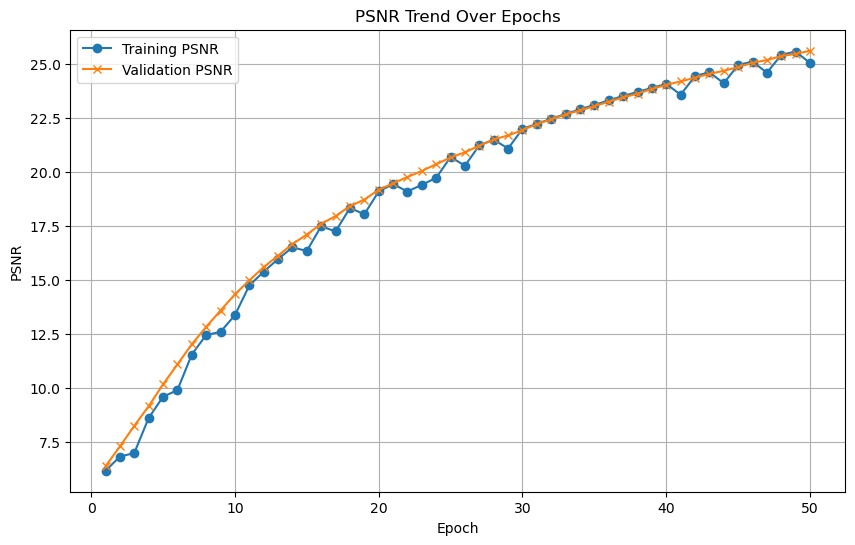

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/2 for train dataset.
    Processed batch 2/2 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/19 for test dataset.
Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.5595
    Validation Batch [1/1], Loss: 2.5719
Validation Loss: 2.5719, Validation Accuracy: 7.69%
Validation loss improved from inf to 2.5719. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.5528
    Validation Batch [1/1], Loss: 2.5719
Validation Loss: 2.5719, Validation Accuracy: 7.69%
Validation loss improved from 2.5719 to 2.5719. Saving model...

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.5441
    Validation Batch [1/1], Loss: 2.5718
Validation Loss: 2.5718, Validation Accuracy: 7.69%
Validation loss improved from 2.5719 to 2.5718. Saving model...

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.5270
    Validation Batch [1/1], Loss: 2.5718
Validation Loss: 2.5718, Validation Accuracy: 7.69%
Validation loss improved from 2.5718 to 2.5718. Saving model...

LOG: Epoch [5/1000] - 

Epoch [10/1000] completed, Average Training Loss: 2.4743
    Validation Batch [1/1], Loss: 2.5715
Validation Loss: 2.5715, Validation Accuracy: 7.69%
Validation loss improved from 2.5717 to 2.5715. Saving model...

LOG: Epoch [11/1000] - Training
Epoch [11/1000] completed, Average Training Loss: 2.4614
    Validation Batch [1/1], Loss: 2.5714
Validation Loss: 2.5714, Validation Accuracy: 9.23%
Validation loss improved from 2.5715 to 2.5714. Saving model...

LOG: Epoch [12/1000] - Training
Epoch [12/1000] completed, Average Training Loss: 2.4519
    Validation Batch [1/1], Loss: 2.5712
Validation Loss: 2.5712, Validation Accuracy: 7.69%
Validation loss improved from 2.5714 to 2.5712. Saving model...

LOG: Epoch [13/1000] - Training
Epoch [13/1000] completed, Average Training Loss: 2.4339
    Validation Batch [1/1], Loss: 2.5710
Validation Loss: 2.5710, Validation Accuracy: 7.69%
Validation loss improved from 2.5712 to 2.5710. Saving model...

LOG: Epoch [14/1000] - Training
Epoch [14/10

Epoch [25/1000] completed, Average Training Loss: 2.2540
    Validation Batch [1/1], Loss: 2.5487
Validation Loss: 2.5487, Validation Accuracy: 7.69%
Validation loss improved from 2.5535 to 2.5487. Saving model...

LOG: Epoch [26/1000] - Training
Epoch [26/1000] completed, Average Training Loss: 2.2477
    Validation Batch [1/1], Loss: 2.5443
Validation Loss: 2.5443, Validation Accuracy: 7.69%
Validation loss improved from 2.5487 to 2.5443. Saving model...

LOG: Epoch [27/1000] - Training
Epoch [27/1000] completed, Average Training Loss: 2.2305
    Validation Batch [1/1], Loss: 2.5371
Validation Loss: 2.5371, Validation Accuracy: 7.69%
Validation loss improved from 2.5443 to 2.5371. Saving model...

LOG: Epoch [28/1000] - Training
Epoch [28/1000] completed, Average Training Loss: 2.2178
    Validation Batch [1/1], Loss: 2.5308
Validation Loss: 2.5308, Validation Accuracy: 7.69%
Validation loss improved from 2.5371 to 2.5308. Saving model...

LOG: Epoch [29/1000] - Training
Epoch [29/10

    Validation Batch [1/1], Loss: 2.3685
Validation Loss: 2.3685, Validation Accuracy: 23.08%
Validation loss improved from 2.3926 to 2.3685. Saving model...

LOG: Epoch [40/1000] - Training
Epoch [40/1000] completed, Average Training Loss: 2.0531
    Validation Batch [1/1], Loss: 2.3441
Validation Loss: 2.3441, Validation Accuracy: 23.08%
Validation loss improved from 2.3685 to 2.3441. Saving model...

LOG: Epoch [41/1000] - Training
Epoch [41/1000] completed, Average Training Loss: 2.0273
    Validation Batch [1/1], Loss: 2.3065
Validation Loss: 2.3065, Validation Accuracy: 29.23%
Validation loss improved from 2.3441 to 2.3065. Saving model...

LOG: Epoch [42/1000] - Training
Epoch [42/1000] completed, Average Training Loss: 2.0034
    Validation Batch [1/1], Loss: 2.2701
Validation Loss: 2.2701, Validation Accuracy: 33.85%
Validation loss improved from 2.3065 to 2.2701. Saving model...

LOG: Epoch [43/1000] - Training
Epoch [43/1000] completed, Average Training Loss: 1.9900
    Vali

Epoch [54/1000] completed, Average Training Loss: 1.8154
    Validation Batch [1/1], Loss: 1.9314
Validation Loss: 1.9314, Validation Accuracy: 40.00%
Validation loss improved from 1.9503 to 1.9314. Saving model...

LOG: Epoch [55/1000] - Training
Epoch [55/1000] completed, Average Training Loss: 1.8019
    Validation Batch [1/1], Loss: 1.9046
Validation Loss: 1.9046, Validation Accuracy: 43.08%
Validation loss improved from 1.9314 to 1.9046. Saving model...

LOG: Epoch [56/1000] - Training
Epoch [56/1000] completed, Average Training Loss: 1.8082
    Validation Batch [1/1], Loss: 1.8918
Validation Loss: 1.8918, Validation Accuracy: 47.69%
Validation loss improved from 1.9046 to 1.8918. Saving model...

LOG: Epoch [57/1000] - Training
Epoch [57/1000] completed, Average Training Loss: 1.7779
    Validation Batch [1/1], Loss: 1.8745
Validation Loss: 1.8745, Validation Accuracy: 44.62%
Validation loss improved from 1.8918 to 1.8745. Saving model...

LOG: Epoch [58/1000] - Training
Epoch [5

Epoch [69/1000] completed, Average Training Loss: 1.5995
    Validation Batch [1/1], Loss: 1.6916
Validation Loss: 1.6916, Validation Accuracy: 49.23%
Validation loss improved from 1.7103 to 1.6916. Saving model...

LOG: Epoch [70/1000] - Training
Epoch [70/1000] completed, Average Training Loss: 1.5770
    Validation Batch [1/1], Loss: 1.6769
Validation Loss: 1.6769, Validation Accuracy: 49.23%
Validation loss improved from 1.6916 to 1.6769. Saving model...

LOG: Epoch [71/1000] - Training
Epoch [71/1000] completed, Average Training Loss: 1.5704
    Validation Batch [1/1], Loss: 1.6579
Validation Loss: 1.6579, Validation Accuracy: 49.23%
Validation loss improved from 1.6769 to 1.6579. Saving model...

LOG: Epoch [72/1000] - Training
Epoch [72/1000] completed, Average Training Loss: 1.5651
    Validation Batch [1/1], Loss: 1.6432
Validation Loss: 1.6432, Validation Accuracy: 52.31%
Validation loss improved from 1.6579 to 1.6432. Saving model...

LOG: Epoch [73/1000] - Training
Epoch [7

Epoch [84/1000] completed, Average Training Loss: 1.3797
    Validation Batch [1/1], Loss: 1.4715
Validation Loss: 1.4715, Validation Accuracy: 61.54%
Validation loss improved from 1.4973 to 1.4715. Saving model...

LOG: Epoch [85/1000] - Training
Epoch [85/1000] completed, Average Training Loss: 1.3593
    Validation Batch [1/1], Loss: 1.4806
Validation Loss: 1.4806, Validation Accuracy: 63.08%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [86/1000] - Training
Epoch [86/1000] completed, Average Training Loss: 1.3540
    Validation Batch [1/1], Loss: 1.4446
Validation Loss: 1.4446, Validation Accuracy: 58.46%
Validation loss improved from 1.4715 to 1.4446. Saving model...

LOG: Epoch [87/1000] - Training
Epoch [87/1000] completed, Average Training Loss: 1.3258
    Validation Batch [1/1], Loss: 1.4283
Validation Loss: 1.4283, Validation Accuracy: 60.00%
Validation loss improved from 1.4446 to 1.4283. Saving model...

LOG: Epoch [88/1000] - Training
Epoch [88/1000] complet

Epoch [99/1000] completed, Average Training Loss: 1.1546
    Validation Batch [1/1], Loss: 1.2468
Validation Loss: 1.2468, Validation Accuracy: 73.85%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [100/1000] - Training
Epoch [100/1000] completed, Average Training Loss: 1.1299
    Validation Batch [1/1], Loss: 1.2091
Validation Loss: 1.2091, Validation Accuracy: 76.92%
Validation loss improved from 1.2380 to 1.2091. Saving model...

LOG: Epoch [101/1000] - Training
Epoch [101/1000] completed, Average Training Loss: 1.0906
    Validation Batch [1/1], Loss: 1.1903
Validation Loss: 1.1903, Validation Accuracy: 78.46%
Validation loss improved from 1.2091 to 1.1903. Saving model...

LOG: Epoch [102/1000] - Training
Epoch [102/1000] completed, Average Training Loss: 1.1027
    Validation Batch [1/1], Loss: 1.1863
Validation Loss: 1.1863, Validation Accuracy: 78.46%
Validation loss improved from 1.1903 to 1.1863. Saving model...

LOG: Epoch [103/1000] - Training
Epoch [103/1000]

    Validation Batch [1/1], Loss: 1.0533
Validation Loss: 1.0533, Validation Accuracy: 76.92%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [115/1000] - Training
Epoch [115/1000] completed, Average Training Loss: 0.8878
    Validation Batch [1/1], Loss: 1.0080
Validation Loss: 1.0080, Validation Accuracy: 81.54%
Validation loss improved from 1.0329 to 1.0080. Saving model...

LOG: Epoch [116/1000] - Training
Epoch [116/1000] completed, Average Training Loss: 0.8900
    Validation Batch [1/1], Loss: 1.0097
Validation Loss: 1.0097, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [117/1000] - Training
Epoch [117/1000] completed, Average Training Loss: 0.8647
    Validation Batch [1/1], Loss: 1.0675
Validation Loss: 1.0675, Validation Accuracy: 75.38%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [118/1000] - Training
Epoch [118/1000] completed, Average Training Loss: 0.8406
    Validation Batch [1/1], Loss: 1.0329
Vali

Epoch [130/1000] completed, Average Training Loss: 0.6942
    Validation Batch [1/1], Loss: 0.8404
Validation Loss: 0.8404, Validation Accuracy: 83.08%
Validation loss improved from 0.8661 to 0.8404. Saving model...

LOG: Epoch [131/1000] - Training
Epoch [131/1000] completed, Average Training Loss: 0.6704
    Validation Batch [1/1], Loss: 0.8641
Validation Loss: 0.8641, Validation Accuracy: 83.08%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [132/1000] - Training
Epoch [132/1000] completed, Average Training Loss: 0.6743
    Validation Batch [1/1], Loss: 0.8400
Validation Loss: 0.8400, Validation Accuracy: 80.00%
Validation loss improved from 0.8404 to 0.8400. Saving model...

LOG: Epoch [133/1000] - Training
Epoch [133/1000] completed, Average Training Loss: 0.6640
    Validation Batch [1/1], Loss: 0.8454
Validation Loss: 0.8454, Validation Accuracy: 78.46%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [134/1000] - Training
Epoch [134/1000] completed, Av

Epoch [145/1000] completed, Average Training Loss: 0.5284
    Validation Batch [1/1], Loss: 0.7536
Validation Loss: 0.7536, Validation Accuracy: 84.62%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [146/1000] - Training
Epoch [146/1000] completed, Average Training Loss: 0.5165
    Validation Batch [1/1], Loss: 0.6846
Validation Loss: 0.6846, Validation Accuracy: 86.15%
Validation loss improved from 0.7287 to 0.6846. Saving model...

LOG: Epoch [147/1000] - Training
Epoch [147/1000] completed, Average Training Loss: 0.5241
    Validation Batch [1/1], Loss: 0.6869
Validation Loss: 0.6869, Validation Accuracy: 86.15%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [148/1000] - Training
Epoch [148/1000] completed, Average Training Loss: 0.4993
    Validation Batch [1/1], Loss: 0.6561
Validation Loss: 0.6561, Validation Accuracy: 87.69%
Validation loss improved from 0.6846 to 0.6561. Saving model...

LOG: Epoch [149/1000] - Training
Epoch [149/1000] completed, Av

    Validation Batch [1/1], Loss: 0.6131
Validation Loss: 0.6131, Validation Accuracy: 86.15%
Validation loss improved from 0.6257 to 0.6131. Saving model...

LOG: Epoch [159/1000] - Training
Epoch [159/1000] completed, Average Training Loss: 0.4121
    Validation Batch [1/1], Loss: 0.6214
Validation Loss: 0.6214, Validation Accuracy: 84.62%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [160/1000] - Training
Epoch [160/1000] completed, Average Training Loss: 0.3719
    Validation Batch [1/1], Loss: 0.5972
Validation Loss: 0.5972, Validation Accuracy: 86.15%
Validation loss improved from 0.6131 to 0.5972. Saving model...

LOG: Epoch [161/1000] - Training
Epoch [161/1000] completed, Average Training Loss: 0.4132
    Validation Batch [1/1], Loss: 0.5932
Validation Loss: 0.5932, Validation Accuracy: 86.15%
Validation loss improved from 0.5972 to 0.5932. Saving model...

LOG: Epoch [162/1000] - Training
Epoch [162/1000] completed, Average Training Loss: 0.3751
    Validation 

Epoch [173/1000] completed, Average Training Loss: 0.3111
    Validation Batch [1/1], Loss: 0.5384
Validation Loss: 0.5384, Validation Accuracy: 89.23%
Validation loss improved from 0.5509 to 0.5384. Saving model...

LOG: Epoch [174/1000] - Training
Epoch [174/1000] completed, Average Training Loss: 0.3084
    Validation Batch [1/1], Loss: 0.5520
Validation Loss: 0.5520, Validation Accuracy: 86.15%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [175/1000] - Training
Epoch [175/1000] completed, Average Training Loss: 0.3152
    Validation Batch [1/1], Loss: 0.5971
Validation Loss: 0.5971, Validation Accuracy: 83.08%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [176/1000] - Training
Epoch [176/1000] completed, Average Training Loss: 0.3211
    Validation Batch [1/1], Loss: 0.6091
Validation Loss: 0.6091, Validation Accuracy: 84.62%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [177/1000] - Training
Epoch [177/1000] completed, Average Training 

Epoch [188/1000] completed, Average Training Loss: 0.2430
    Validation Batch [1/1], Loss: 0.5753
Validation Loss: 0.5753, Validation Accuracy: 84.62%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [189/1000] - Training
Epoch [189/1000] completed, Average Training Loss: 0.2514
    Validation Batch [1/1], Loss: 0.5103
Validation Loss: 0.5103, Validation Accuracy: 86.15%
Validation loss improved from 0.5239 to 0.5103. Saving model...

LOG: Epoch [190/1000] - Training
Epoch [190/1000] completed, Average Training Loss: 0.2542
    Validation Batch [1/1], Loss: 0.5002
Validation Loss: 0.5002, Validation Accuracy: 86.15%
Validation loss improved from 0.5103 to 0.5002. Saving model...

LOG: Epoch [191/1000] - Training
Epoch [191/1000] completed, Average Training Loss: 0.2432
    Validation Batch [1/1], Loss: 0.6504
Validation Loss: 0.6504, Validation Accuracy: 83.08%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [192/1000] - Training
Epoch [192/1000] completed, Av

Epoch [204/1000] completed, Average Training Loss: 0.1964
    Validation Batch [1/1], Loss: 0.5738
Validation Loss: 0.5738, Validation Accuracy: 83.08%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [205/1000] - Training
Epoch [205/1000] completed, Average Training Loss: 0.1891
    Validation Batch [1/1], Loss: 0.5320
Validation Loss: 0.5320, Validation Accuracy: 86.15%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [206/1000] - Training
Epoch [206/1000] completed, Average Training Loss: 0.1976
    Validation Batch [1/1], Loss: 0.6428
Validation Loss: 0.6428, Validation Accuracy: 76.92%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [207/1000] - Training
Epoch [207/1000] completed, Average Training Loss: 0.2125
    Validation Batch [1/1], Loss: 0.6981
Validation Loss: 0.6981, Validation Accuracy: 75.38%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [208/1000] - Training
Epoch [208/1000] completed, Average Training Loss: 0.1802
  

Epoch [213/1000] completed, Average Training Loss: 0.1632
    Validation Batch [1/1], Loss: 0.5049
Validation Loss: 0.5049, Validation Accuracy: 84.62%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [214/1000] - Training
Epoch [214/1000] completed, Average Training Loss: 0.1732
    Validation Batch [1/1], Loss: 0.4627
Validation Loss: 0.4627, Validation Accuracy: 87.69%
Validation loss improved from 0.4809 to 0.4627. Saving model...

LOG: Epoch [215/1000] - Training
Epoch [215/1000] completed, Average Training Loss: 0.1652
    Validation Batch [1/1], Loss: 0.4773
Validation Loss: 0.4773, Validation Accuracy: 87.69%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [216/1000] - Training
Epoch [216/1000] completed, Average Training Loss: 0.1715
    Validation Batch [1/1], Loss: 0.5091
Validation Loss: 0.5091, Validation Accuracy: 86.15%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [217/1000] - Training
Epoch [217/1000] completed, Average Training 

Epoch [228/1000] completed, Average Training Loss: 0.1456
    Validation Batch [1/1], Loss: 0.4730
Validation Loss: 0.4730, Validation Accuracy: 83.08%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [229/1000] - Training
Epoch [229/1000] completed, Average Training Loss: 0.1386
    Validation Batch [1/1], Loss: 0.4600
Validation Loss: 0.4600, Validation Accuracy: 87.69%
Validation loss improved from 0.4621 to 0.4600. Saving model...

LOG: Epoch [230/1000] - Training
Epoch [230/1000] completed, Average Training Loss: 0.1358
    Validation Batch [1/1], Loss: 0.4537
Validation Loss: 0.4537, Validation Accuracy: 84.62%
Validation loss improved from 0.4600 to 0.4537. Saving model...

LOG: Epoch [231/1000] - Training
Epoch [231/1000] completed, Average Training Loss: 0.1297
    Validation Batch [1/1], Loss: 0.4909
Validation Loss: 0.4909, Validation Accuracy: 84.62%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [232/1000] - Training
Epoch [232/1000] completed, Av

Epoch [243/1000] completed, Average Training Loss: 0.1064
    Validation Batch [1/1], Loss: 0.4495
Validation Loss: 0.4495, Validation Accuracy: 84.62%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [244/1000] - Training
Epoch [244/1000] completed, Average Training Loss: 0.1141
    Validation Batch [1/1], Loss: 0.4366
Validation Loss: 0.4366, Validation Accuracy: 86.15%
Validation loss improved from 0.4368 to 0.4366. Saving model...

LOG: Epoch [245/1000] - Training
Epoch [245/1000] completed, Average Training Loss: 0.1115
    Validation Batch [1/1], Loss: 0.4190
Validation Loss: 0.4190, Validation Accuracy: 89.23%
Validation loss improved from 0.4366 to 0.4190. Saving model...

LOG: Epoch [246/1000] - Training
Epoch [246/1000] completed, Average Training Loss: 0.1127
    Validation Batch [1/1], Loss: 0.4183
Validation Loss: 0.4183, Validation Accuracy: 90.77%
Validation loss improved from 0.4190 to 0.4183. Saving model...

LOG: Epoch [247/1000] - Training
Epoch [247/1000

Epoch [259/1000] completed, Average Training Loss: 0.0843
    Validation Batch [1/1], Loss: 0.4417
Validation Loss: 0.4417, Validation Accuracy: 89.23%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [260/1000] - Training
Epoch [260/1000] completed, Average Training Loss: 0.0884
    Validation Batch [1/1], Loss: 0.4834
Validation Loss: 0.4834, Validation Accuracy: 89.23%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [261/1000] - Training
Epoch [261/1000] completed, Average Training Loss: 0.0824
    Validation Batch [1/1], Loss: 0.4656
Validation Loss: 0.4656, Validation Accuracy: 89.23%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [262/1000] - Training
Epoch [262/1000] completed, Average Training Loss: 0.0826
    Validation Batch [1/1], Loss: 0.4395
Validation Loss: 0.4395, Validation Accuracy: 89.23%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [263/1000] - Training
Epoch [263/1000] completed, Average Training Loss: 0.099

Epoch [274/1000] completed, Average Training Loss: 0.0777
    Validation Batch [1/1], Loss: 0.4497
Validation Loss: 0.4497, Validation Accuracy: 87.69%
Validation loss did not improve. Patience: 27/100

LOG: Epoch [275/1000] - Training
Epoch [275/1000] completed, Average Training Loss: 0.0756
    Validation Batch [1/1], Loss: 0.5175
Validation Loss: 0.5175, Validation Accuracy: 83.08%
Validation loss did not improve. Patience: 28/100

LOG: Epoch [276/1000] - Training
Epoch [276/1000] completed, Average Training Loss: 0.0790
    Validation Batch [1/1], Loss: 0.5214
Validation Loss: 0.5214, Validation Accuracy: 84.62%
Validation loss did not improve. Patience: 29/100

LOG: Epoch [277/1000] - Training
Epoch [277/1000] completed, Average Training Loss: 0.0807
    Validation Batch [1/1], Loss: 0.4783
Validation Loss: 0.4783, Validation Accuracy: 86.15%
Validation loss did not improve. Patience: 30/100

LOG: Epoch [278/1000] - Training
Epoch [278/1000] completed, Average Training Loss: 0.082

Epoch [290/1000] completed, Average Training Loss: 0.0703
    Validation Batch [1/1], Loss: 0.4871
Validation Loss: 0.4871, Validation Accuracy: 86.15%
Validation loss did not improve. Patience: 43/100

LOG: Epoch [291/1000] - Training
Epoch [291/1000] completed, Average Training Loss: 0.0612
    Validation Batch [1/1], Loss: 0.4951
Validation Loss: 0.4951, Validation Accuracy: 84.62%
Validation loss did not improve. Patience: 44/100

LOG: Epoch [292/1000] - Training
Epoch [292/1000] completed, Average Training Loss: 0.0649
    Validation Batch [1/1], Loss: 0.4605
Validation Loss: 0.4605, Validation Accuracy: 84.62%
Validation loss did not improve. Patience: 45/100

LOG: Epoch [293/1000] - Training
Epoch [293/1000] completed, Average Training Loss: 0.0626
    Validation Batch [1/1], Loss: 0.4233
Validation Loss: 0.4233, Validation Accuracy: 87.69%
Validation loss did not improve. Patience: 46/100

LOG: Epoch [294/1000] - Training
Epoch [294/1000] completed, Average Training Loss: 0.058

Epoch [305/1000] completed, Average Training Loss: 0.0617
    Validation Batch [1/1], Loss: 0.4567
Validation Loss: 0.4567, Validation Accuracy: 84.62%
Validation loss did not improve. Patience: 58/100

LOG: Epoch [306/1000] - Training
Epoch [306/1000] completed, Average Training Loss: 0.0577
    Validation Batch [1/1], Loss: 0.4682
Validation Loss: 0.4682, Validation Accuracy: 84.62%
Validation loss did not improve. Patience: 59/100

LOG: Epoch [307/1000] - Training
Epoch [307/1000] completed, Average Training Loss: 0.0624
    Validation Batch [1/1], Loss: 0.5019
Validation Loss: 0.5019, Validation Accuracy: 86.15%
Validation loss did not improve. Patience: 60/100

LOG: Epoch [308/1000] - Training
Epoch [308/1000] completed, Average Training Loss: 0.0530
    Validation Batch [1/1], Loss: 0.5047
Validation Loss: 0.5047, Validation Accuracy: 86.15%
Validation loss did not improve. Patience: 61/100

LOG: Epoch [309/1000] - Training
Epoch [309/1000] completed, Average Training Loss: 0.057

Epoch [320/1000] completed, Average Training Loss: 0.0502
    Validation Batch [1/1], Loss: 0.4465
Validation Loss: 0.4465, Validation Accuracy: 90.77%
Validation loss did not improve. Patience: 73/100

LOG: Epoch [321/1000] - Training
Epoch [321/1000] completed, Average Training Loss: 0.0480
    Validation Batch [1/1], Loss: 0.4436
Validation Loss: 0.4436, Validation Accuracy: 87.69%
Validation loss did not improve. Patience: 74/100

LOG: Epoch [322/1000] - Training
Epoch [322/1000] completed, Average Training Loss: 0.0489
    Validation Batch [1/1], Loss: 0.4447
Validation Loss: 0.4447, Validation Accuracy: 89.23%
Validation loss did not improve. Patience: 75/100

LOG: Epoch [323/1000] - Training
Epoch [323/1000] completed, Average Training Loss: 0.0479
    Validation Batch [1/1], Loss: 0.4778
Validation Loss: 0.4778, Validation Accuracy: 89.23%
Validation loss did not improve. Patience: 76/100

LOG: Epoch [324/1000] - Training
Epoch [324/1000] completed, Average Training Loss: 0.052

Epoch [335/1000] completed, Average Training Loss: 0.0414
    Validation Batch [1/1], Loss: 0.5088
Validation Loss: 0.5088, Validation Accuracy: 84.62%
Validation loss did not improve. Patience: 88/100

LOG: Epoch [336/1000] - Training
Epoch [336/1000] completed, Average Training Loss: 0.0443
    Validation Batch [1/1], Loss: 0.4627
Validation Loss: 0.4627, Validation Accuracy: 86.15%
Validation loss did not improve. Patience: 89/100

LOG: Epoch [337/1000] - Training
Epoch [337/1000] completed, Average Training Loss: 0.0416
    Validation Batch [1/1], Loss: 0.4630
Validation Loss: 0.4630, Validation Accuracy: 87.69%
Validation loss did not improve. Patience: 90/100

LOG: Epoch [338/1000] - Training
Epoch [338/1000] completed, Average Training Loss: 0.0430
    Validation Batch [1/1], Loss: 0.5131
Validation Loss: 0.5131, Validation Accuracy: 89.23%
Validation loss did not improve. Patience: 91/100

LOG: Epoch [339/1000] - Training
Epoch [339/1000] completed, Average Training Loss: 0.040

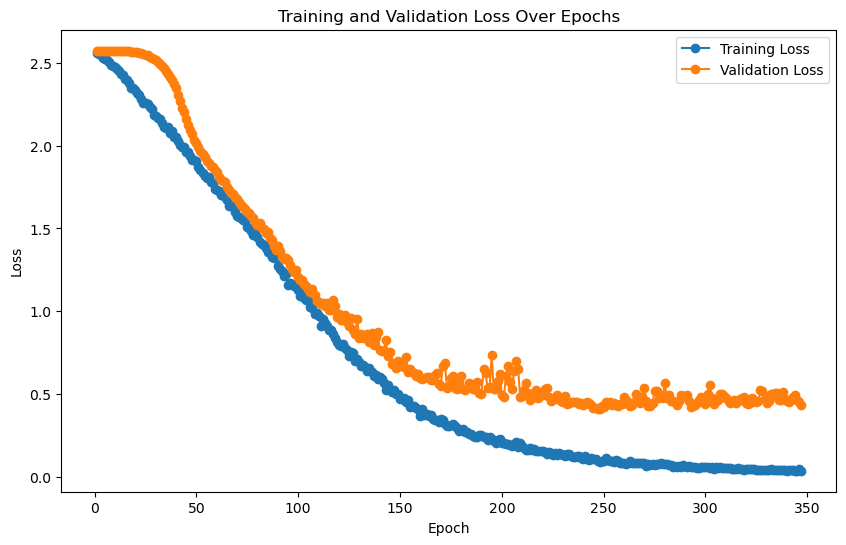

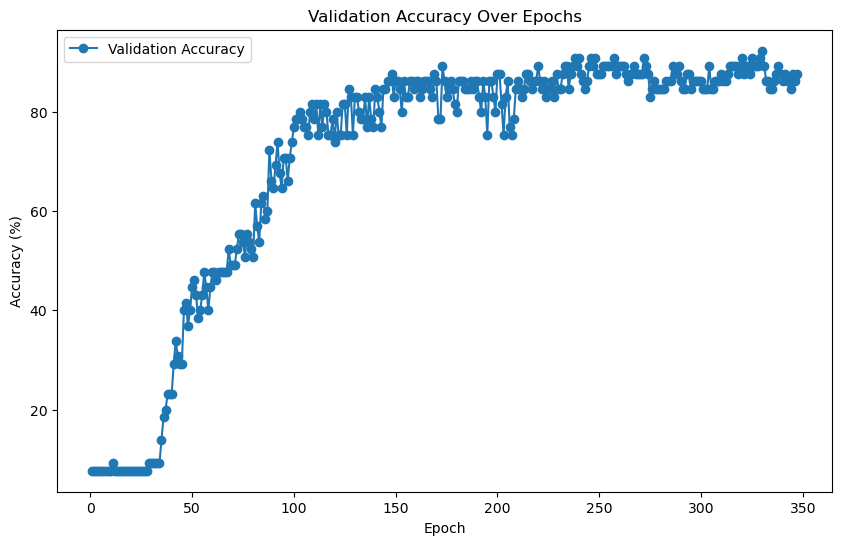


Evaluating on the test set...
    Test Batch [1/19], Loss: 0.3633

Final Test Loss: 0.5488, Test Accuracy: 86.86%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/19 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 520 samples with 64 features each
LOG: Labels shape: (520,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 4626 samples with 64 features each
LOG: Labels shape: (4626,)

LOG: Training features shape: (520, 64), Training labels shape: (520,)
LOG: Validation features shape: (65, 64), Validation labels shape: (65,)
LOG: Test features shape: (4626, 64), Test labels shape: (4626,)

LOG: Training Logistic Regression model...


LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 43.08%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.31      1.00      0.48         5
           1       0.50      0.20      0.29         5
           2       0.00      0.00      0.00         5
           3       0.50      0.20      0.29         5
           4       0.44      0.80      0.57         5
           5       0.00      0.00      0.00         5
           6       0.67      0.40      0.50         5
           7       0.12      0.20      0.15         5
           8       0.36      0.80      0.50         5
           9       0.00      0.00      0.00         5
          10       0.80      0.80      0.80         5
          11       1.00      0.20      0.33         5
          12       0.83      1.00      0.91         5

    accuracy                           0.43        65
   macro avg       0.43      0.43     

C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 520 samples with 64 features each
LOG: Labels shape: (520,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 4626 samples with 64 features each
LOG: Labels shape: (4626,)
Train reps shape: (520, 64)
Train labels shape: (520,)
Val reps shape: (65, 64)
Val labels shape: (65,)
Test reps shape: (4626, 64)
Test labels shape: (4626,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.6113  |  Val Loss: 2.5797
Validation loss improved from inf to 2.5797.
[Epoch 2/1000] Train Loss: 2.5340  |  Val Loss: 2.5688
Validation loss improved from 2.5797 to 2.5688.
[Epoch 3/1000] Train Loss: 2.5101  |  Val Loss: 2.5714
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 4/1000] Train Loss: 2.4938  |  Val Loss: 2.5750
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 5/1000] Train Loss: 2.4785  |  Val Loss: 2.5771
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 6/1000] Train Loss: 2.4676  |  Val Loss: 2.5818
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 7/1000] Train Loss: 2.4554  |  Val Loss: 2.5878
!! Validation loss did NOT improve !! Patience: 5/100


[Epoch 8/1000] Train Loss: 2.4409  |  Val Loss: 2.5903
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 9/1000] Train Loss: 2.4360  |  Val Loss: 2.5904
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 10/1000] Train Loss: 2.4252  |  Val Loss: 2.5858
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 11/1000] Train Loss: 2.4177  |  Val Loss: 2.5938
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 12/1000] Train Loss: 2.4185  |  Val Loss: 2.5974
!! Validation loss did NOT improve !! Patience: 10/100


[Epoch 13/1000] Train Loss: 2.4045  |  Val Loss: 2.5871
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 14/1000] Train Loss: 2.3969  |  Val Loss: 2.5866
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 15/1000] Train Loss: 2.3934  |  Val Loss: 2.6012
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 16/1000] Train Loss: 2.3837  |  Val Loss: 2.5868
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 17/1000] Train Loss: 2.3884  |  Val Loss: 2.5892
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 18/1000] Train Loss: 2.3701  |  Val Loss: 2.5916
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 19/1000] Train Loss: 2.3607  |  Val Loss: 2.5896
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 20/1000] Train Loss: 2.3637  |  Val Loss: 2.5888
!! Validation loss did NOT improve !! Patience: 18/100


[Epoch 21/1000] Train Loss: 2.3454  |  Val Loss: 2.5673
Validation loss improved from 2.5688 to 2.5673.
[Epoch 22/1000] Train Loss: 2.3126  |  Val Loss: 2.5501
Validation loss improved from 2.5673 to 2.5501.
[Epoch 23/1000] Train Loss: 2.3101  |  Val Loss: 2.5252
Validation loss improved from 2.5501 to 2.5252.


[Epoch 24/1000] Train Loss: 2.2796  |  Val Loss: 2.4867
Validation loss improved from 2.5252 to 2.4867.
[Epoch 25/1000] Train Loss: 2.2583  |  Val Loss: 2.4727
Validation loss improved from 2.4867 to 2.4727.
[Epoch 26/1000] Train Loss: 2.2417  |  Val Loss: 2.4403
Validation loss improved from 2.4727 to 2.4403.
[Epoch 27/1000] Train Loss: 2.2181  |  Val Loss: 2.4121
Validation loss improved from 2.4403 to 2.4121.
[Epoch 28/1000] Train Loss: 2.1909  |  Val Loss: 2.3964
Validation loss improved from 2.4121 to 2.3964.
[Epoch 29/1000] Train Loss: 2.1616  |  Val Loss: 2.3565
Validation loss improved from 2.3964 to 2.3565.
[Epoch 30/1000] Train Loss: 2.1203  |  Val Loss: 2.3099
Validation loss improved from 2.3565 to 2.3099.
[Epoch 31/1000] Train Loss: 2.1049  |  Val Loss: 2.2878
Validation loss improved from 2.3099 to 2.2878.


[Epoch 32/1000] Train Loss: 2.0454  |  Val Loss: 2.2750
Validation loss improved from 2.2878 to 2.2750.
[Epoch 33/1000] Train Loss: 2.0316  |  Val Loss: 2.2066
Validation loss improved from 2.2750 to 2.2066.
[Epoch 34/1000] Train Loss: 1.9847  |  Val Loss: 2.1828
Validation loss improved from 2.2066 to 2.1828.


[Epoch 35/1000] Train Loss: 1.9647  |  Val Loss: 2.2112
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 36/1000] Train Loss: 1.9575  |  Val Loss: 2.1457
Validation loss improved from 2.1828 to 2.1457.
[Epoch 37/1000] Train Loss: 1.9384  |  Val Loss: 2.1192
Validation loss improved from 2.1457 to 2.1192.
[Epoch 38/1000] Train Loss: 1.8861  |  Val Loss: 2.1305
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 39/1000] Train Loss: 1.8835  |  Val Loss: 2.1970
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 40/1000] Train Loss: 1.8775  |  Val Loss: 2.1380
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 41/1000] Train Loss: 1.8595  |  Val Loss: 2.1045
Validation loss improved from 2.1192 to 2.1045.
[Epoch 42/1000] Train Loss: 1.8733  |  Val Loss: 2.2958
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 43/1000] Train Loss: 1.9504  |  Val Loss: 2.2416
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 44/1000] Train Loss: 

[Epoch 45/1000] Train Loss: 1.8296  |  Val Loss: 2.0824
Validation loss improved from 2.1030 to 2.0824.
[Epoch 46/1000] Train Loss: 1.7690  |  Val Loss: 2.0838
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 47/1000] Train Loss: 1.7789  |  Val Loss: 2.0873
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 48/1000] Train Loss: 1.7626  |  Val Loss: 2.0949
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 49/1000] Train Loss: 1.7488  |  Val Loss: 2.0830
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 50/1000] Train Loss: 1.7360  |  Val Loss: 2.0970
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 51/1000] Train Loss: 1.7408  |  Val Loss: 2.0739
Validation loss improved from 2.0824 to 2.0739.
[Epoch 52/1000] Train Loss: 1.7194  |  Val Loss: 2.0991
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 53/1000] Train Loss: 1.6984  |  Val Loss: 2.0690
Validation loss improved from 2.0739 to 2.0690.
[Epoch 54/1000] Train Loss: 1.7051  |  Val Loss: 2.0454
Validation loss improved from 2.0690 to 2.0454.
[Epoch 55/1000] Train Loss: 1.6995  |  Val Loss: 2.0904
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 56/1000] Train Loss: 1.6974  |  Val Loss: 2.1473
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 57/1000] Train Loss: 1.7270  |  Val Loss: 2.1056
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 58/1000] Train Loss: 1.7242  |  Val Loss: 2.1339
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 59/1000] Train Loss: 1.7525  |  Val Loss: 2.2134
!! Validation loss did NOT improve !! Patience: 5/100


[Epoch 60/1000] Train Loss: 1.7783  |  Val Loss: 2.0732
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 61/1000] Train Loss: 1.6880  |  Val Loss: 2.0617
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 62/1000] Train Loss: 1.6480  |  Val Loss: 2.0563
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 63/1000] Train Loss: 1.6552  |  Val Loss: 2.0904
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 64/1000] Train Loss: 1.6374  |  Val Loss: 2.1374
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 65/1000] Train Loss: 1.6637  |  Val Loss: 2.2132
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 66/1000] Train Loss: 1.6542  |  Val Loss: 2.1954
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 67/1000] Train Loss: 1.6692  |  Val Loss: 2.1763
!! Validation loss did NOT improve !! Patience: 13/100


[Epoch 68/1000] Train Loss: 1.6572  |  Val Loss: 2.0732
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 69/1000] Train Loss: 1.6387  |  Val Loss: 2.0781
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 70/1000] Train Loss: 1.7085  |  Val Loss: 2.0841
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 71/1000] Train Loss: 1.6146  |  Val Loss: 2.1165
!! Validation loss did NOT improve !! Patience: 17/100


[Epoch 72/1000] Train Loss: 1.6137  |  Val Loss: 2.0852
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 73/1000] Train Loss: 1.5944  |  Val Loss: 2.0536
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 74/1000] Train Loss: 1.6212  |  Val Loss: 2.0903
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 75/1000] Train Loss: 1.6312  |  Val Loss: 2.1964
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 76/1000] Train Loss: 1.7495  |  Val Loss: 2.1956
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 77/1000] Train Loss: 1.6931  |  Val Loss: 2.0560
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 78/1000] Train Loss: 1.6790  |  Val Loss: 2.1128
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 79/1000] Train Loss: 1.6198  |  Val Loss: 2.0761
!! Validation loss did NOT improve !! Patience: 25/100


[Epoch 80/1000] Train Loss: 1.6107  |  Val Loss: 2.0507
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 81/1000] Train Loss: 1.5811  |  Val Loss: 2.1013
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 82/1000] Train Loss: 1.5742  |  Val Loss: 2.0836
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 83/1000] Train Loss: 1.5693  |  Val Loss: 2.1015
!! Validation loss did NOT improve !! Patience: 29/100


[Epoch 84/1000] Train Loss: 1.5704  |  Val Loss: 2.0871
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 85/1000] Train Loss: 1.5668  |  Val Loss: 2.0713
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 86/1000] Train Loss: 1.5924  |  Val Loss: 2.0952
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 87/1000] Train Loss: 1.6308  |  Val Loss: 2.1077
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 88/1000] Train Loss: 1.5970  |  Val Loss: 2.0677
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 89/1000] Train Loss: 1.5916  |  Val Loss: 2.0754
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 90/1000] Train Loss: 1.5807  |  Val Loss: 2.1250
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 91/1000] Train Loss: 1.5858  |  Val Loss: 2.0573
!! Validation loss did NOT improve !! Patience: 37/100


[Epoch 92/1000] Train Loss: 1.5495  |  Val Loss: 2.1153
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 93/1000] Train Loss: 1.5482  |  Val Loss: 2.0825
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 94/1000] Train Loss: 1.5329  |  Val Loss: 2.0712
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 95/1000] Train Loss: 1.5320  |  Val Loss: 2.0970
!! Validation loss did NOT improve !! Patience: 41/100


[Epoch 96/1000] Train Loss: 1.5340  |  Val Loss: 2.0809
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 97/1000] Train Loss: 1.5850  |  Val Loss: 2.0940
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 98/1000] Train Loss: 1.5369  |  Val Loss: 2.0736
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 99/1000] Train Loss: 1.5363  |  Val Loss: 2.2478
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 100/1000] Train Loss: 1.6980  |  Val Loss: 2.1572
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 101/1000] Train Loss: 1.5749  |  Val Loss: 2.1013
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 102/1000] Train Loss: 1.5455  |  Val Loss: 2.0776
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 103/1000] Train Loss: 1.5313  |  Val Loss: 2.1539
!! Validation loss did NOT improve !! Patience: 49/100


[Epoch 104/1000] Train Loss: 1.5387  |  Val Loss: 2.1272
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 105/1000] Train Loss: 1.5585  |  Val Loss: 2.1275
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 106/1000] Train Loss: 1.5414  |  Val Loss: 2.1025
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 107/1000] Train Loss: 1.5240  |  Val Loss: 2.1093
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 108/1000] Train Loss: 1.5198  |  Val Loss: 2.1318
!! Validation loss did NOT improve !! Patience: 54/100


[Epoch 109/1000] Train Loss: 1.5364  |  Val Loss: 2.1971
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 110/1000] Train Loss: 1.5543  |  Val Loss: 2.2290
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 111/1000] Train Loss: 1.5462  |  Val Loss: 2.1285
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 112/1000] Train Loss: 1.5080  |  Val Loss: 2.0955
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 113/1000] Train Loss: 1.5093  |  Val Loss: 2.1286
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 114/1000] Train Loss: 1.5134  |  Val Loss: 2.1018
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 115/1000] Train Loss: 1.5140  |  Val Loss: 2.0502
!! Validation loss did NOT improve !! Patience: 61/100


[Epoch 116/1000] Train Loss: 1.4908  |  Val Loss: 2.1682
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 117/1000] Train Loss: 1.5178  |  Val Loss: 2.0773
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 118/1000] Train Loss: 1.4806  |  Val Loss: 2.1051
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 119/1000] Train Loss: 1.4907  |  Val Loss: 2.0685
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 120/1000] Train Loss: 1.5150  |  Val Loss: 2.0698
!! Validation loss did NOT improve !! Patience: 66/100


[Epoch 121/1000] Train Loss: 1.5201  |  Val Loss: 2.0937
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 122/1000] Train Loss: 1.4983  |  Val Loss: 2.0836
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 123/1000] Train Loss: 1.5220  |  Val Loss: 2.0920
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 124/1000] Train Loss: 1.5391  |  Val Loss: 2.1410
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 125/1000] Train Loss: 1.5297  |  Val Loss: 2.0927
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 126/1000] Train Loss: 1.5787  |  Val Loss: 2.0508
!! Validation loss did NOT improve !! Patience: 72/100


[Epoch 127/1000] Train Loss: 1.5528  |  Val Loss: 2.1077
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 128/1000] Train Loss: 1.4772  |  Val Loss: 2.1909
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 129/1000] Train Loss: 1.4861  |  Val Loss: 2.0863
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 130/1000] Train Loss: 1.5104  |  Val Loss: 2.0978
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 131/1000] Train Loss: 1.4766  |  Val Loss: 2.0984
!! Validation loss did NOT improve !! Patience: 77/100


[Epoch 132/1000] Train Loss: 1.4867  |  Val Loss: 2.1689
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 133/1000] Train Loss: 1.4831  |  Val Loss: 2.1283
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 134/1000] Train Loss: 1.4999  |  Val Loss: 2.1290
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 135/1000] Train Loss: 1.4824  |  Val Loss: 2.1405
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 136/1000] Train Loss: 1.4836  |  Val Loss: 2.1154
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 137/1000] Train Loss: 1.4544  |  Val Loss: 2.0970
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 138/1000] Train Loss: 1.4449  |  Val Loss: 2.0785
!! Validation loss did NOT improve !! Patience: 84/100


[Epoch 139/1000] Train Loss: 1.4507  |  Val Loss: 2.0942
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 140/1000] Train Loss: 1.4535  |  Val Loss: 2.1561
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 141/1000] Train Loss: 1.4970  |  Val Loss: 2.2782
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 142/1000] Train Loss: 1.4692  |  Val Loss: 2.1127
!! Validation loss did NOT improve !! Patience: 88/100


[Epoch 143/1000] Train Loss: 1.4610  |  Val Loss: 2.1682
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 144/1000] Train Loss: 1.5042  |  Val Loss: 2.0851
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 145/1000] Train Loss: 1.4462  |  Val Loss: 2.0941
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 146/1000] Train Loss: 1.4517  |  Val Loss: 2.0790
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 147/1000] Train Loss: 1.4868  |  Val Loss: 2.1123
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 148/1000] Train Loss: 1.5331  |  Val Loss: 2.1206
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 149/1000] Train Loss: 1.4531  |  Val Loss: 2.0902
!! Validation loss did NOT improve !! Patience: 95/100


[Epoch 150/1000] Train Loss: 1.4636  |  Val Loss: 2.1554
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 151/1000] Train Loss: 1.4373  |  Val Loss: 2.0841
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 152/1000] Train Loss: 1.4332  |  Val Loss: 2.1376
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 153/1000] Train Loss: 1.4590  |  Val Loss: 2.1311
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 154/1000] Train Loss: 1.4677  |  Val Loss: 2.1206
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 154 !!
No improvement for 100 epochs.


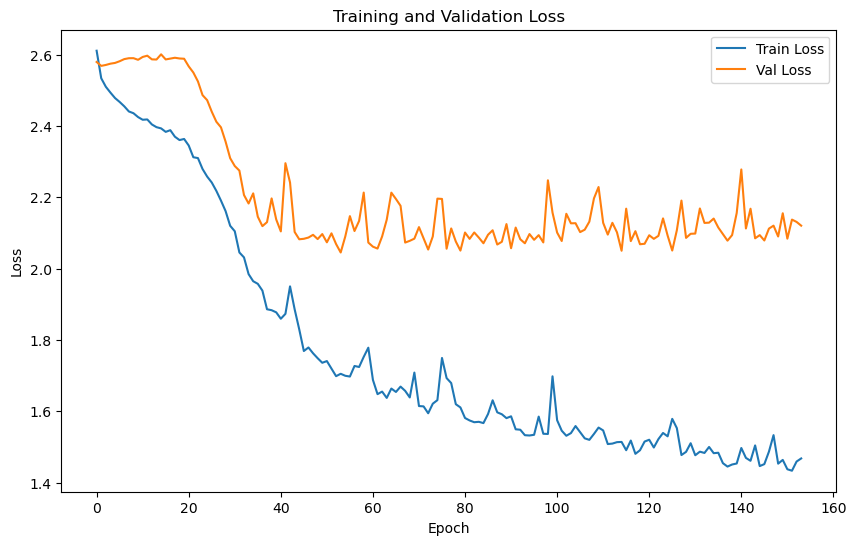

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 1.8180 | Test Accuracy: 45.87%


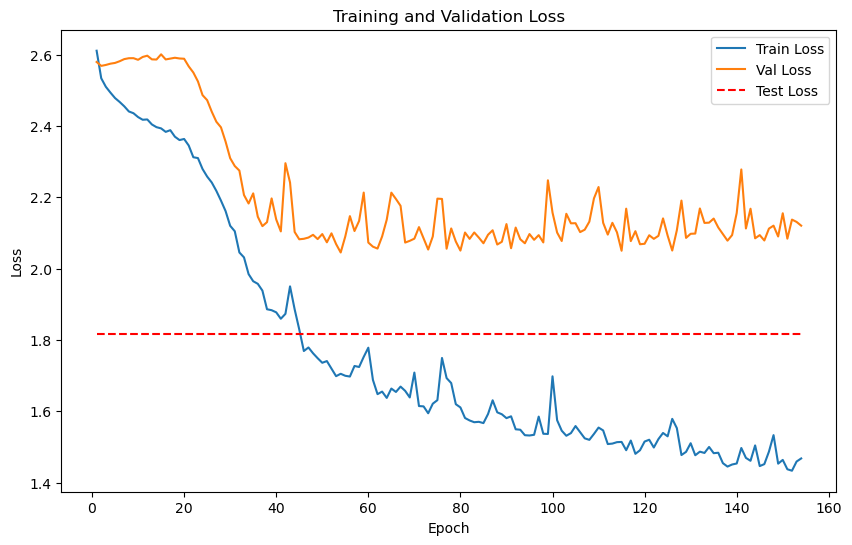

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 520 samples with 64 features each
LOG: Labels shape: (520,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 4626 samples with 64 features each
LOG: Labels shape: (4626,)


Train embeddings shape: (520, 64), 
Train labels shape: (520,)


Val embeddings shape: (65, 64), 
Val labels shape: (65,)


Test embeddings shape: (4626, 64), 
Test labels shape: (4626,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20}
Training batch size: 260


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training


    Batch [1/2], Train Loss: 8.0924
    Batch [2/2], Train Loss: 8.1738
Epoch [1/2000], Avg Train Loss: 8.1331
Epoch [1/2000], Avg Val Loss: 5.1122
Validation loss improved from inf to 5.1122. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/2], Train Loss: 7.9747
    Batch [2/2], Train Loss: 8.0819
Epoch [2/2000], Avg Train Loss: 8.0283
Epoch [2/2000], Avg Val Loss: 5.0547
Validation loss improved from 5.1122 to 5.0547. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/2], Train Loss: 7.7516
    Batch [2/2], Train Loss: 7.7728
Epoch [3/2000], Avg Train Loss: 7.7622
Epoch [3/2000], Avg Val Loss: 4.9988
Validation loss improved from 5.0547 to 4.9988. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/2], Train Loss: 7.8933
    Batch [2/2], Train Loss: 7.7801
Epoch [4/2000], Avg Train Loss: 7.8367
Epoch [4/2000], Avg Val Loss: 4.9431
Validation loss improved from 4.9988 to 4.9431. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/2], Train Loss

    Batch [1/2], Train Loss: 7.1302
    Batch [2/2], Train Loss: 6.9191
Epoch [10/2000], Avg Train Loss: 7.0247
Epoch [10/2000], Avg Val Loss: 4.6434
Validation loss improved from 4.6890 to 4.6434. Saving model...

LOG: Epoch [11/2000] - Training
    Batch [1/2], Train Loss: 7.0213
    Batch [2/2], Train Loss: 6.9992
Epoch [11/2000], Avg Train Loss: 7.0102
Epoch [11/2000], Avg Val Loss: 4.5991
Validation loss improved from 4.6434 to 4.5991. Saving model...

LOG: Epoch [12/2000] - Training
    Batch [1/2], Train Loss: 6.7737
    Batch [2/2], Train Loss: 7.0568
Epoch [12/2000], Avg Train Loss: 6.9153
Epoch [12/2000], Avg Val Loss: 4.5552
Validation loss improved from 4.5991 to 4.5552. Saving model...

LOG: Epoch [13/2000] - Training


    Batch [1/2], Train Loss: 6.7418
    Batch [2/2], Train Loss: 6.8124
Epoch [13/2000], Avg Train Loss: 6.7771
Epoch [13/2000], Avg Val Loss: 4.5124
Validation loss improved from 4.5552 to 4.5124. Saving model...

LOG: Epoch [14/2000] - Training
    Batch [1/2], Train Loss: 6.7921
    Batch [2/2], Train Loss: 6.6004
Epoch [14/2000], Avg Train Loss: 6.6963
Epoch [14/2000], Avg Val Loss: 4.4712
Validation loss improved from 4.5124 to 4.4712. Saving model...

LOG: Epoch [15/2000] - Training
    Batch [1/2], Train Loss: 6.5980
    Batch [2/2], Train Loss: 6.7533
Epoch [15/2000], Avg Train Loss: 6.6757
Epoch [15/2000], Avg Val Loss: 4.4312
Validation loss improved from 4.4712 to 4.4312. Saving model...

LOG: Epoch [16/2000] - Training
    Batch [1/2], Train Loss: 6.6654
    Batch [2/2], Train Loss: 6.6393
Epoch [16/2000], Avg Train Loss: 6.6524
Epoch [16/2000], Avg Val Loss: 4.3917
Validation loss improved from 4.4312 to 4.3917. Saving model...

LOG: Epoch [17/2000] - Training
    Batch [1

    Batch [1/2], Train Loss: 6.2370
    Batch [2/2], Train Loss: 6.1972
Epoch [21/2000], Avg Train Loss: 6.2171
Epoch [21/2000], Avg Val Loss: 4.2160
Validation loss improved from 4.2482 to 4.2160. Saving model...

LOG: Epoch [22/2000] - Training
    Batch [1/2], Train Loss: 6.2479
    Batch [2/2], Train Loss: 6.2990
Epoch [22/2000], Avg Train Loss: 6.2734
Epoch [22/2000], Avg Val Loss: 4.1855
Validation loss improved from 4.2160 to 4.1855. Saving model...

LOG: Epoch [23/2000] - Training
    Batch [1/2], Train Loss: 6.3270
    Batch [2/2], Train Loss: 6.2493
Epoch [23/2000], Avg Train Loss: 6.2881
Epoch [23/2000], Avg Val Loss: 4.1565
Validation loss improved from 4.1855 to 4.1565. Saving model...

LOG: Epoch [24/2000] - Training
    Batch [1/2], Train Loss: 6.1562
    Batch [2/2], Train Loss: 6.1524
Epoch [24/2000], Avg Train Loss: 6.1543
Epoch [24/2000], Avg Val Loss: 4.1290
Validation loss improved from 4.1565 to 4.1290. Saving model...

LOG: Epoch [25/2000] - Training
    Batch [1

    Batch [1/2], Train Loss: 6.0203
    Batch [2/2], Train Loss: 5.9378
Epoch [30/2000], Avg Train Loss: 5.9790
Epoch [30/2000], Avg Val Loss: 3.9952
Validation loss improved from 4.0142 to 3.9952. Saving model...

LOG: Epoch [31/2000] - Training
    Batch [1/2], Train Loss: 5.9703
    Batch [2/2], Train Loss: 5.9415
Epoch [31/2000], Avg Train Loss: 5.9559
Epoch [31/2000], Avg Val Loss: 3.9773
Validation loss improved from 3.9952 to 3.9773. Saving model...

LOG: Epoch [32/2000] - Training
    Batch [1/2], Train Loss: 5.7992
    Batch [2/2], Train Loss: 5.9453
Epoch [32/2000], Avg Train Loss: 5.8723
Epoch [32/2000], Avg Val Loss: 3.9605
Validation loss improved from 3.9773 to 3.9605. Saving model...

LOG: Epoch [33/2000] - Training
    Batch [1/2], Train Loss: 5.7856
    Batch [2/2], Train Loss: 5.8633
Epoch [33/2000], Avg Train Loss: 5.8244
Epoch [33/2000], Avg Val Loss: 3.9446
Validation loss improved from 3.9605 to 3.9446. Saving model...

LOG: Epoch [34/2000] - Training
    Batch [1

    Batch [1/2], Train Loss: 5.7824
    Batch [2/2], Train Loss: 5.8216
Epoch [35/2000], Avg Train Loss: 5.8020
Epoch [35/2000], Avg Val Loss: 3.9156
Validation loss improved from 3.9296 to 3.9156. Saving model...

LOG: Epoch [36/2000] - Training
    Batch [1/2], Train Loss: 5.8749
    Batch [2/2], Train Loss: 5.7173
Epoch [36/2000], Avg Train Loss: 5.7961
Epoch [36/2000], Avg Val Loss: 3.9026
Validation loss improved from 3.9156 to 3.9026. Saving model...

LOG: Epoch [37/2000] - Training
    Batch [1/2], Train Loss: 5.8039
    Batch [2/2], Train Loss: 5.6917
Epoch [37/2000], Avg Train Loss: 5.7478
Epoch [37/2000], Avg Val Loss: 3.8906
Validation loss improved from 3.9026 to 3.8906. Saving model...

LOG: Epoch [38/2000] - Training
    Batch [1/2], Train Loss: 5.7479
    Batch [2/2], Train Loss: 5.7492
Epoch [38/2000], Avg Train Loss: 5.7486
Epoch [38/2000], Avg Val Loss: 3.8793
Validation loss improved from 3.8906 to 3.8793. Saving model...

LOG: Epoch [39/2000] - Training
    Batch [1

    Batch [1/2], Train Loss: 5.6732
    Batch [2/2], Train Loss: 5.7386
Epoch [43/2000], Avg Train Loss: 5.7059
Epoch [43/2000], Avg Val Loss: 3.8335
Validation loss improved from 3.8416 to 3.8335. Saving model...

LOG: Epoch [44/2000] - Training
    Batch [1/2], Train Loss: 5.6486
    Batch [2/2], Train Loss: 5.6632
Epoch [44/2000], Avg Train Loss: 5.6559
Epoch [44/2000], Avg Val Loss: 3.8257
Validation loss improved from 3.8335 to 3.8257. Saving model...

LOG: Epoch [45/2000] - Training
    Batch [1/2], Train Loss: 5.5832
    Batch [2/2], Train Loss: 5.5841
Epoch [45/2000], Avg Train Loss: 5.5837
Epoch [45/2000], Avg Val Loss: 3.8183
Validation loss improved from 3.8257 to 3.8183. Saving model...

LOG: Epoch [46/2000] - Training
    Batch [1/2], Train Loss: 5.6056
    Batch [2/2], Train Loss: 5.6023
Epoch [46/2000], Avg Train Loss: 5.6040
Epoch [46/2000], Avg Val Loss: 3.8113
Validation loss improved from 3.8183 to 3.8113. Saving model...

LOG: Epoch [47/2000] - Training
    Batch [1

    Batch [2/2], Train Loss: 5.5232
Epoch [52/2000], Avg Train Loss: 5.5264
Epoch [52/2000], Avg Val Loss: 3.7752
Validation loss improved from 3.7806 to 3.7752. Saving model...

LOG: Epoch [53/2000] - Training
    Batch [1/2], Train Loss: 5.5066
    Batch [2/2], Train Loss: 5.4823
Epoch [53/2000], Avg Train Loss: 5.4944
Epoch [53/2000], Avg Val Loss: 3.7701
Validation loss improved from 3.7752 to 3.7701. Saving model...

LOG: Epoch [54/2000] - Training
    Batch [1/2], Train Loss: 5.4871
    Batch [2/2], Train Loss: 5.4331
Epoch [54/2000], Avg Train Loss: 5.4601
Epoch [54/2000], Avg Val Loss: 3.7654
Validation loss improved from 3.7701 to 3.7654. Saving model...

LOG: Epoch [55/2000] - Training
    Batch [1/2], Train Loss: 5.4255
    Batch [2/2], Train Loss: 5.4834
Epoch [55/2000], Avg Train Loss: 5.4545
Epoch [55/2000], Avg Val Loss: 3.7609
Validation loss improved from 3.7654 to 3.7609. Saving model...

LOG: Epoch [56/2000] - Training
    Batch [1/2], Train Loss: 5.4993
    Batch [2

    Batch [2/2], Train Loss: 5.4781
Epoch [57/2000], Avg Train Loss: 5.4768
Epoch [57/2000], Avg Val Loss: 3.7524
Validation loss improved from 3.7566 to 3.7524. Saving model...

LOG: Epoch [58/2000] - Training
    Batch [1/2], Train Loss: 5.4225
    Batch [2/2], Train Loss: 5.4531
Epoch [58/2000], Avg Train Loss: 5.4378
Epoch [58/2000], Avg Val Loss: 3.7484
Validation loss improved from 3.7524 to 3.7484. Saving model...

LOG: Epoch [59/2000] - Training
    Batch [1/2], Train Loss: 5.4754
    Batch [2/2], Train Loss: 5.4433
Epoch [59/2000], Avg Train Loss: 5.4593
Epoch [59/2000], Avg Val Loss: 3.7446
Validation loss improved from 3.7484 to 3.7446. Saving model...

LOG: Epoch [60/2000] - Training
    Batch [1/2], Train Loss: 5.4528
    Batch [2/2], Train Loss: 5.3908
Epoch [60/2000], Avg Train Loss: 5.4218
Epoch [60/2000], Avg Val Loss: 3.7411
Validation loss improved from 3.7446 to 3.7411. Saving model...

LOG: Epoch [61/2000] - Training
    Batch [1/2], Train Loss: 5.3937
    Batch [2

    Batch [2/2], Train Loss: 5.4152
Epoch [66/2000], Avg Train Loss: 5.3920
Epoch [66/2000], Avg Val Loss: 3.7227
Validation loss improved from 3.7255 to 3.7227. Saving model...

LOG: Epoch [67/2000] - Training
    Batch [1/2], Train Loss: 5.3634
    Batch [2/2], Train Loss: 5.4015
Epoch [67/2000], Avg Train Loss: 5.3824
Epoch [67/2000], Avg Val Loss: 3.7201
Validation loss improved from 3.7227 to 3.7201. Saving model...

LOG: Epoch [68/2000] - Training
    Batch [1/2], Train Loss: 5.3015
    Batch [2/2], Train Loss: 5.3161
Epoch [68/2000], Avg Train Loss: 5.3088
Epoch [68/2000], Avg Val Loss: 3.7176
Validation loss improved from 3.7201 to 3.7176. Saving model...

LOG: Epoch [69/2000] - Training
    Batch [1/2], Train Loss: 5.3724
    Batch [2/2], Train Loss: 5.3916
Epoch [69/2000], Avg Train Loss: 5.3820
Epoch [69/2000], Avg Val Loss: 3.7153
Validation loss improved from 3.7176 to 3.7153. Saving model...

LOG: Epoch [70/2000] - Training
    Batch [1/2], Train Loss: 5.3785
    Batch [2

    Batch [1/2], Train Loss: 5.3228
    Batch [2/2], Train Loss: 5.3137
Epoch [74/2000], Avg Train Loss: 5.3183
Epoch [74/2000], Avg Val Loss: 3.7046
Validation loss improved from 3.7067 to 3.7046. Saving model...

LOG: Epoch [75/2000] - Training
    Batch [1/2], Train Loss: 5.2778
    Batch [2/2], Train Loss: 5.3319
Epoch [75/2000], Avg Train Loss: 5.3049
Epoch [75/2000], Avg Val Loss: 3.7027
Validation loss improved from 3.7046 to 3.7027. Saving model...

LOG: Epoch [76/2000] - Training
    Batch [1/2], Train Loss: 5.3142
    Batch [2/2], Train Loss: 5.2882
Epoch [76/2000], Avg Train Loss: 5.3012
Epoch [76/2000], Avg Val Loss: 3.7008
Validation loss improved from 3.7027 to 3.7008. Saving model...

LOG: Epoch [77/2000] - Training
    Batch [1/2], Train Loss: 5.2328
    Batch [2/2], Train Loss: 5.3253
Epoch [77/2000], Avg Train Loss: 5.2790
Epoch [77/2000], Avg Val Loss: 3.6990
Validation loss improved from 3.7008 to 3.6990. Saving model...

LOG: Epoch [78/2000] - Training
    Batch [1

    Batch [2/2], Train Loss: 5.2797
Epoch [78/2000], Avg Train Loss: 5.3106
Epoch [78/2000], Avg Val Loss: 3.6972
Validation loss improved from 3.6990 to 3.6972. Saving model...

LOG: Epoch [79/2000] - Training
    Batch [1/2], Train Loss: 5.3299
    Batch [2/2], Train Loss: 5.3037
Epoch [79/2000], Avg Train Loss: 5.3168
Epoch [79/2000], Avg Val Loss: 3.6953
Validation loss improved from 3.6972 to 3.6953. Saving model...

LOG: Epoch [80/2000] - Training
    Batch [1/2], Train Loss: 5.2800
    Batch [2/2], Train Loss: 5.3352
Epoch [80/2000], Avg Train Loss: 5.3076
Epoch [80/2000], Avg Val Loss: 3.6936
Validation loss improved from 3.6953 to 3.6936. Saving model...

LOG: Epoch [81/2000] - Training
    Batch [1/2], Train Loss: 5.3242
    Batch [2/2], Train Loss: 5.2936
Epoch [81/2000], Avg Train Loss: 5.3089
Epoch [81/2000], Avg Val Loss: 3.6920
Validation loss improved from 3.6936 to 3.6920. Saving model...

LOG: Epoch [82/2000] - Training
    Batch [1/2], Train Loss: 5.2716
    Batch [2

    Batch [1/2], Train Loss: 5.2771
    Batch [2/2], Train Loss: 5.2996
Epoch [87/2000], Avg Train Loss: 5.2883
Epoch [87/2000], Avg Val Loss: 3.6833
Validation loss improved from 3.6848 to 3.6833. Saving model...

LOG: Epoch [88/2000] - Training
    Batch [1/2], Train Loss: 5.2302
    Batch [2/2], Train Loss: 5.2297
Epoch [88/2000], Avg Train Loss: 5.2300
Epoch [88/2000], Avg Val Loss: 3.6819
Validation loss improved from 3.6833 to 3.6819. Saving model...

LOG: Epoch [89/2000] - Training
    Batch [1/2], Train Loss: 5.2931
    Batch [2/2], Train Loss: 5.2307
Epoch [89/2000], Avg Train Loss: 5.2619
Epoch [89/2000], Avg Val Loss: 3.6804
Validation loss improved from 3.6819 to 3.6804. Saving model...

LOG: Epoch [90/2000] - Training
    Batch [1/2], Train Loss: 5.2778
    Batch [2/2], Train Loss: 5.2406
Epoch [90/2000], Avg Train Loss: 5.2592
Epoch [90/2000], Avg Val Loss: 3.6791
Validation loss improved from 3.6804 to 3.6791. Saving model...

LOG: Epoch [91/2000] - Training
    Batch [1

    Batch [1/2], Train Loss: 5.1969
    Batch [2/2], Train Loss: 5.1577
Epoch [95/2000], Avg Train Loss: 5.1773
Epoch [95/2000], Avg Val Loss: 3.6734
Validation loss improved from 3.6746 to 3.6734. Saving model...

LOG: Epoch [96/2000] - Training
    Batch [1/2], Train Loss: 5.2351
    Batch [2/2], Train Loss: 5.1972
Epoch [96/2000], Avg Train Loss: 5.2162
Epoch [96/2000], Avg Val Loss: 3.6723
Validation loss improved from 3.6734 to 3.6723. Saving model...

LOG: Epoch [97/2000] - Training
    Batch [1/2], Train Loss: 5.1943
    Batch [2/2], Train Loss: 5.2161
Epoch [97/2000], Avg Train Loss: 5.2052
Epoch [97/2000], Avg Val Loss: 3.6712
Validation loss improved from 3.6723 to 3.6712. Saving model...

LOG: Epoch [98/2000] - Training
    Batch [1/2], Train Loss: 5.1951
    Batch [2/2], Train Loss: 5.2263
Epoch [98/2000], Avg Train Loss: 5.2107
Epoch [98/2000], Avg Val Loss: 3.6702
Validation loss improved from 3.6712 to 3.6702. Saving model...

LOG: Epoch [99/2000] - Training
    Batch [1

    Batch [2/2], Train Loss: 5.2161
Epoch [99/2000], Avg Train Loss: 5.2155
Epoch [99/2000], Avg Val Loss: 3.6692
Validation loss improved from 3.6702 to 3.6692. Saving model...

LOG: Epoch [100/2000] - Training
    Batch [1/2], Train Loss: 5.2349
    Batch [2/2], Train Loss: 5.2017
Epoch [100/2000], Avg Train Loss: 5.2183
Epoch [100/2000], Avg Val Loss: 3.6680
Validation loss improved from 3.6692 to 3.6680. Saving model...

LOG: Epoch [101/2000] - Training
    Batch [1/2], Train Loss: 5.1733
    Batch [2/2], Train Loss: 5.2026
Epoch [101/2000], Avg Train Loss: 5.1879
Epoch [101/2000], Avg Val Loss: 3.6668
Validation loss improved from 3.6680 to 3.6668. Saving model...

LOG: Epoch [102/2000] - Training
    Batch [1/2], Train Loss: 5.2061
    Batch [2/2], Train Loss: 5.1885
Epoch [102/2000], Avg Train Loss: 5.1973
Epoch [102/2000], Avg Val Loss: 3.6655
Validation loss improved from 3.6668 to 3.6655. Saving model...

LOG: Epoch [103/2000] - Training
    Batch [1/2], Train Loss: 5.1567
  

Epoch [108/2000], Avg Val Loss: 3.6576
Validation loss improved from 3.6589 to 3.6576. Saving model...

LOG: Epoch [109/2000] - Training
    Batch [1/2], Train Loss: 5.1574
    Batch [2/2], Train Loss: 5.1943
Epoch [109/2000], Avg Train Loss: 5.1758
Epoch [109/2000], Avg Val Loss: 3.6563
Validation loss improved from 3.6576 to 3.6563. Saving model...

LOG: Epoch [110/2000] - Training
    Batch [1/2], Train Loss: 5.1554
    Batch [2/2], Train Loss: 5.1517
Epoch [110/2000], Avg Train Loss: 5.1536
Epoch [110/2000], Avg Val Loss: 3.6550
Validation loss improved from 3.6563 to 3.6550. Saving model...

LOG: Epoch [111/2000] - Training
    Batch [1/2], Train Loss: 5.1487
    Batch [2/2], Train Loss: 5.1643
Epoch [111/2000], Avg Train Loss: 5.1565
Epoch [111/2000], Avg Val Loss: 3.6538
Validation loss improved from 3.6550 to 3.6538. Saving model...

LOG: Epoch [112/2000] - Training
    Batch [1/2], Train Loss: 5.1637
    Batch [2/2], Train Loss: 5.1711
Epoch [112/2000], Avg Train Loss: 5.1674


    Batch [2/2], Train Loss: 5.0996
Epoch [117/2000], Avg Train Loss: 5.1517
Epoch [117/2000], Avg Val Loss: 3.6473
Validation loss improved from 3.6484 to 3.6473. Saving model...

LOG: Epoch [118/2000] - Training
    Batch [1/2], Train Loss: 5.1608
    Batch [2/2], Train Loss: 5.1589
Epoch [118/2000], Avg Train Loss: 5.1599
Epoch [118/2000], Avg Val Loss: 3.6464
Validation loss improved from 3.6473 to 3.6464. Saving model...

LOG: Epoch [119/2000] - Training
    Batch [1/2], Train Loss: 5.1552
    Batch [2/2], Train Loss: 5.1609
Epoch [119/2000], Avg Train Loss: 5.1580
Epoch [119/2000], Avg Val Loss: 3.6455
Validation loss improved from 3.6464 to 3.6455. Saving model...

LOG: Epoch [120/2000] - Training
    Batch [1/2], Train Loss: 5.1779
    Batch [2/2], Train Loss: 5.1395
Epoch [120/2000], Avg Train Loss: 5.1587
Epoch [120/2000], Avg Val Loss: 3.6445
Validation loss improved from 3.6455 to 3.6445. Saving model...

LOG: Epoch [121/2000] - Training
    Batch [1/2], Train Loss: 5.1417


Epoch [122/2000], Avg Val Loss: 3.6429
Validation loss improved from 3.6436 to 3.6429. Saving model...

LOG: Epoch [123/2000] - Training
    Batch [1/2], Train Loss: 5.1324
    Batch [2/2], Train Loss: 5.1718
Epoch [123/2000], Avg Train Loss: 5.1521
Epoch [123/2000], Avg Val Loss: 3.6421
Validation loss improved from 3.6429 to 3.6421. Saving model...

LOG: Epoch [124/2000] - Training
    Batch [1/2], Train Loss: 5.1685
    Batch [2/2], Train Loss: 5.1284
Epoch [124/2000], Avg Train Loss: 5.1485
Epoch [124/2000], Avg Val Loss: 3.6413
Validation loss improved from 3.6421 to 3.6413. Saving model...

LOG: Epoch [125/2000] - Training
    Batch [1/2], Train Loss: 5.1607
    Batch [2/2], Train Loss: 5.0977
Epoch [125/2000], Avg Train Loss: 5.1292
Epoch [125/2000], Avg Val Loss: 3.6406
Validation loss improved from 3.6413 to 3.6406. Saving model...

LOG: Epoch [126/2000] - Training
    Batch [1/2], Train Loss: 5.0912
    Batch [2/2], Train Loss: 5.1072
Epoch [126/2000], Avg Train Loss: 5.0992


    Batch [2/2], Train Loss: 5.1740
Epoch [130/2000], Avg Train Loss: 5.1436
Epoch [130/2000], Avg Val Loss: 3.6362
Validation loss improved from 3.6372 to 3.6362. Saving model...

LOG: Epoch [131/2000] - Training
    Batch [1/2], Train Loss: 5.1506
    Batch [2/2], Train Loss: 5.0789
Epoch [131/2000], Avg Train Loss: 5.1147
Epoch [131/2000], Avg Val Loss: 3.6353
Validation loss improved from 3.6362 to 3.6353. Saving model...

LOG: Epoch [132/2000] - Training
    Batch [1/2], Train Loss: 5.1012
    Batch [2/2], Train Loss: 5.0901
Epoch [132/2000], Avg Train Loss: 5.0957
Epoch [132/2000], Avg Val Loss: 3.6345
Validation loss improved from 3.6353 to 3.6345. Saving model...

LOG: Epoch [133/2000] - Training
    Batch [1/2], Train Loss: 5.0736
    Batch [2/2], Train Loss: 5.1307
Epoch [133/2000], Avg Train Loss: 5.1022
Epoch [133/2000], Avg Val Loss: 3.6337
Validation loss improved from 3.6345 to 3.6337. Saving model...

LOG: Epoch [134/2000] - Training
    Batch [1/2], Train Loss: 5.0770


Epoch [139/2000], Avg Val Loss: 3.6297
Validation loss improved from 3.6306 to 3.6297. Saving model...

LOG: Epoch [140/2000] - Training
    Batch [1/2], Train Loss: 5.0978
    Batch [2/2], Train Loss: 5.0749
Epoch [140/2000], Avg Train Loss: 5.0864
Epoch [140/2000], Avg Val Loss: 3.6287
Validation loss improved from 3.6297 to 3.6287. Saving model...

LOG: Epoch [141/2000] - Training
    Batch [1/2], Train Loss: 5.0917
    Batch [2/2], Train Loss: 5.0953
Epoch [141/2000], Avg Train Loss: 5.0935
Epoch [141/2000], Avg Val Loss: 3.6276
Validation loss improved from 3.6287 to 3.6276. Saving model...

LOG: Epoch [142/2000] - Training
    Batch [1/2], Train Loss: 5.0842
    Batch [2/2], Train Loss: 5.0650
Epoch [142/2000], Avg Train Loss: 5.0746
Epoch [142/2000], Avg Val Loss: 3.6265
Validation loss improved from 3.6276 to 3.6265. Saving model...

LOG: Epoch [143/2000] - Training
    Batch [1/2], Train Loss: 5.0409
    Batch [2/2], Train Loss: 5.0903
Epoch [143/2000], Avg Train Loss: 5.0656


    Batch [2/2], Train Loss: 5.0773
Epoch [145/2000], Avg Train Loss: 5.0854
Epoch [145/2000], Avg Val Loss: 3.6229
Validation loss improved from 3.6241 to 3.6229. Saving model...

LOG: Epoch [146/2000] - Training
    Batch [1/2], Train Loss: 5.1322
    Batch [2/2], Train Loss: 5.0994
Epoch [146/2000], Avg Train Loss: 5.1158
Epoch [146/2000], Avg Val Loss: 3.6216
Validation loss improved from 3.6229 to 3.6216. Saving model...

LOG: Epoch [147/2000] - Training
    Batch [1/2], Train Loss: 5.0917
    Batch [2/2], Train Loss: 5.0833
Epoch [147/2000], Avg Train Loss: 5.0875
Epoch [147/2000], Avg Val Loss: 3.6203
Validation loss improved from 3.6216 to 3.6203. Saving model...

LOG: Epoch [148/2000] - Training
    Batch [1/2], Train Loss: 5.0909
    Batch [2/2], Train Loss: 5.0289
Epoch [148/2000], Avg Train Loss: 5.0599
Epoch [148/2000], Avg Val Loss: 3.6190
Validation loss improved from 3.6203 to 3.6190. Saving model...

LOG: Epoch [149/2000] - Training
    Batch [1/2], Train Loss: 5.0430


    Batch [2/2], Train Loss: 5.1086
Epoch [152/2000], Avg Train Loss: 5.0812
Epoch [152/2000], Avg Val Loss: 3.6140
Validation loss improved from 3.6152 to 3.6140. Saving model...

LOG: Epoch [153/2000] - Training
    Batch [1/2], Train Loss: 5.0664
    Batch [2/2], Train Loss: 5.0782
Epoch [153/2000], Avg Train Loss: 5.0723
Epoch [153/2000], Avg Val Loss: 3.6127
Validation loss improved from 3.6140 to 3.6127. Saving model...

LOG: Epoch [154/2000] - Training
    Batch [1/2], Train Loss: 5.0845
    Batch [2/2], Train Loss: 5.0704
Epoch [154/2000], Avg Train Loss: 5.0774
Epoch [154/2000], Avg Val Loss: 3.6114
Validation loss improved from 3.6127 to 3.6114. Saving model...

LOG: Epoch [155/2000] - Training
    Batch [1/2], Train Loss: 5.1478
    Batch [2/2], Train Loss: 5.0299
Epoch [155/2000], Avg Train Loss: 5.0889
Epoch [155/2000], Avg Val Loss: 3.6100
Validation loss improved from 3.6114 to 3.6100. Saving model...

LOG: Epoch [156/2000] - Training
    Batch [1/2], Train Loss: 5.0199


    Batch [2/2], Train Loss: 5.1076
Epoch [162/2000], Avg Train Loss: 5.0696
Epoch [162/2000], Avg Val Loss: 3.6017
Validation loss improved from 3.6028 to 3.6017. Saving model...

LOG: Epoch [163/2000] - Training
    Batch [1/2], Train Loss: 5.0311
    Batch [2/2], Train Loss: 5.0595
Epoch [163/2000], Avg Train Loss: 5.0453
Epoch [163/2000], Avg Val Loss: 3.6007
Validation loss improved from 3.6017 to 3.6007. Saving model...

LOG: Epoch [164/2000] - Training
    Batch [1/2], Train Loss: 4.9851
    Batch [2/2], Train Loss: 5.0273
Epoch [164/2000], Avg Train Loss: 5.0062
Epoch [164/2000], Avg Val Loss: 3.5996
Validation loss improved from 3.6007 to 3.5996. Saving model...

LOG: Epoch [165/2000] - Training
    Batch [1/2], Train Loss: 5.0398
    Batch [2/2], Train Loss: 5.0131
Epoch [165/2000], Avg Train Loss: 5.0264
Epoch [165/2000], Avg Val Loss: 3.5984
Validation loss improved from 3.5996 to 3.5984. Saving model...

LOG: Epoch [166/2000] - Training
    Batch [1/2], Train Loss: 5.0519


    Batch [2/2], Train Loss: 4.9605
Epoch [169/2000], Avg Train Loss: 4.9980
Epoch [169/2000], Avg Val Loss: 3.5931
Validation loss improved from 3.5945 to 3.5931. Saving model...

LOG: Epoch [170/2000] - Training
    Batch [1/2], Train Loss: 4.9991
    Batch [2/2], Train Loss: 5.0672
Epoch [170/2000], Avg Train Loss: 5.0331
Epoch [170/2000], Avg Val Loss: 3.5917
Validation loss improved from 3.5931 to 3.5917. Saving model...

LOG: Epoch [171/2000] - Training
    Batch [1/2], Train Loss: 5.0242
    Batch [2/2], Train Loss: 5.0582
Epoch [171/2000], Avg Train Loss: 5.0412
Epoch [171/2000], Avg Val Loss: 3.5903
Validation loss improved from 3.5917 to 3.5903. Saving model...

LOG: Epoch [172/2000] - Training
    Batch [1/2], Train Loss: 4.9841
    Batch [2/2], Train Loss: 5.0225
Epoch [172/2000], Avg Train Loss: 5.0033
Epoch [172/2000], Avg Val Loss: 3.5887
Validation loss improved from 3.5903 to 3.5887. Saving model...

LOG: Epoch [173/2000] - Training
    Batch [1/2], Train Loss: 4.9608


Epoch [175/2000], Avg Val Loss: 3.5838
Validation loss improved from 3.5855 to 3.5838. Saving model...

LOG: Epoch [176/2000] - Training
    Batch [1/2], Train Loss: 4.9625
    Batch [2/2], Train Loss: 5.0317
Epoch [176/2000], Avg Train Loss: 4.9971
Epoch [176/2000], Avg Val Loss: 3.5822
Validation loss improved from 3.5838 to 3.5822. Saving model...

LOG: Epoch [177/2000] - Training
    Batch [1/2], Train Loss: 5.0287
    Batch [2/2], Train Loss: 5.0208
Epoch [177/2000], Avg Train Loss: 5.0248
Epoch [177/2000], Avg Val Loss: 3.5805
Validation loss improved from 3.5822 to 3.5805. Saving model...

LOG: Epoch [178/2000] - Training
    Batch [1/2], Train Loss: 5.0020
    Batch [2/2], Train Loss: 4.9648
Epoch [178/2000], Avg Train Loss: 4.9834
Epoch [178/2000], Avg Val Loss: 3.5791
Validation loss improved from 3.5805 to 3.5791. Saving model...

LOG: Epoch [179/2000] - Training
    Batch [1/2], Train Loss: 4.9745
    Batch [2/2], Train Loss: 5.0337
Epoch [179/2000], Avg Train Loss: 5.0041


    Batch [1/2], Train Loss: 4.9710
    Batch [2/2], Train Loss: 4.9549
Epoch [184/2000], Avg Train Loss: 4.9630
Epoch [184/2000], Avg Val Loss: 3.5710
Validation loss improved from 3.5724 to 3.5710. Saving model...

LOG: Epoch [185/2000] - Training
    Batch [1/2], Train Loss: 4.9829
    Batch [2/2], Train Loss: 4.9602
Epoch [185/2000], Avg Train Loss: 4.9715
Epoch [185/2000], Avg Val Loss: 3.5697
Validation loss improved from 3.5710 to 3.5697. Saving model...

LOG: Epoch [186/2000] - Training
    Batch [1/2], Train Loss: 4.9837
    Batch [2/2], Train Loss: 4.9623
Epoch [186/2000], Avg Train Loss: 4.9730
Epoch [186/2000], Avg Val Loss: 3.5684
Validation loss improved from 3.5697 to 3.5684. Saving model...

LOG: Epoch [187/2000] - Training
    Batch [1/2], Train Loss: 4.9746
    Batch [2/2], Train Loss: 5.0133
Epoch [187/2000], Avg Train Loss: 4.9940
Epoch [187/2000], Avg Val Loss: 3.5669
Validation loss improved from 3.5684 to 3.5669. Saving model...

LOG: Epoch [188/2000] - Training


    Batch [1/2], Train Loss: 4.9337
    Batch [2/2], Train Loss: 4.9419
Epoch [192/2000], Avg Train Loss: 4.9378
Epoch [192/2000], Avg Val Loss: 3.5595
Validation loss improved from 3.5609 to 3.5595. Saving model...

LOG: Epoch [193/2000] - Training
    Batch [1/2], Train Loss: 5.0129
    Batch [2/2], Train Loss: 4.9596
Epoch [193/2000], Avg Train Loss: 4.9862
Epoch [193/2000], Avg Val Loss: 3.5581
Validation loss improved from 3.5595 to 3.5581. Saving model...

LOG: Epoch [194/2000] - Training
    Batch [1/2], Train Loss: 4.9789
    Batch [2/2], Train Loss: 4.9458
Epoch [194/2000], Avg Train Loss: 4.9623
Epoch [194/2000], Avg Val Loss: 3.5566
Validation loss improved from 3.5581 to 3.5566. Saving model...

LOG: Epoch [195/2000] - Training
    Batch [1/2], Train Loss: 4.9855
    Batch [2/2], Train Loss: 5.0094
Epoch [195/2000], Avg Train Loss: 4.9975
Epoch [195/2000], Avg Val Loss: 3.5552
Validation loss improved from 3.5566 to 3.5552. Saving model...

LOG: Epoch [196/2000] - Training


Epoch [197/2000], Avg Val Loss: 3.5530
Validation loss improved from 3.5541 to 3.5530. Saving model...

LOG: Epoch [198/2000] - Training
    Batch [1/2], Train Loss: 5.0055
    Batch [2/2], Train Loss: 4.9034
Epoch [198/2000], Avg Train Loss: 4.9545
Epoch [198/2000], Avg Val Loss: 3.5522
Validation loss improved from 3.5530 to 3.5522. Saving model...

LOG: Epoch [199/2000] - Training
    Batch [1/2], Train Loss: 4.9009
    Batch [2/2], Train Loss: 4.9311
Epoch [199/2000], Avg Train Loss: 4.9160
Epoch [199/2000], Avg Val Loss: 3.5515
Validation loss improved from 3.5522 to 3.5515. Saving model...

LOG: Epoch [200/2000] - Training
    Batch [1/2], Train Loss: 4.9679
    Batch [2/2], Train Loss: 4.9416
Epoch [200/2000], Avg Train Loss: 4.9548
Epoch [200/2000], Avg Val Loss: 3.5509
Validation loss improved from 3.5515 to 3.5509. Saving model...

LOG: Epoch [201/2000] - Training
    Batch [1/2], Train Loss: 4.9702
    Batch [2/2], Train Loss: 4.9160
Epoch [201/2000], Avg Train Loss: 4.9431


    Batch [2/2], Train Loss: 4.9219
Epoch [205/2000], Avg Train Loss: 4.9620
Epoch [205/2000], Avg Val Loss: 3.5465
Validation loss improved from 3.5475 to 3.5465. Saving model...

LOG: Epoch [206/2000] - Training
    Batch [1/2], Train Loss: 4.9138
    Batch [2/2], Train Loss: 4.9946
Epoch [206/2000], Avg Train Loss: 4.9542
Epoch [206/2000], Avg Val Loss: 3.5455
Validation loss improved from 3.5465 to 3.5455. Saving model...

LOG: Epoch [207/2000] - Training
    Batch [1/2], Train Loss: 4.9912
    Batch [2/2], Train Loss: 4.9252
Epoch [207/2000], Avg Train Loss: 4.9582
Epoch [207/2000], Avg Val Loss: 3.5446
Validation loss improved from 3.5455 to 3.5446. Saving model...

LOG: Epoch [208/2000] - Training
    Batch [1/2], Train Loss: 4.9837
    Batch [2/2], Train Loss: 4.9068
Epoch [208/2000], Avg Train Loss: 4.9452
Epoch [208/2000], Avg Val Loss: 3.5437
Validation loss improved from 3.5446 to 3.5437. Saving model...

LOG: Epoch [209/2000] - Training
    Batch [1/2], Train Loss: 4.9168


    Batch [1/2], Train Loss: 4.9415
    Batch [2/2], Train Loss: 4.9106
Epoch [212/2000], Avg Train Loss: 4.9260
Epoch [212/2000], Avg Val Loss: 3.5404
Validation loss improved from 3.5412 to 3.5404. Saving model...

LOG: Epoch [213/2000] - Training
    Batch [1/2], Train Loss: 4.9144
    Batch [2/2], Train Loss: 4.8648
Epoch [213/2000], Avg Train Loss: 4.8896
Epoch [213/2000], Avg Val Loss: 3.5396
Validation loss improved from 3.5404 to 3.5396. Saving model...

LOG: Epoch [214/2000] - Training
    Batch [1/2], Train Loss: 4.9277
    Batch [2/2], Train Loss: 4.8959
Epoch [214/2000], Avg Train Loss: 4.9118
Epoch [214/2000], Avg Val Loss: 3.5387
Validation loss improved from 3.5396 to 3.5387. Saving model...

LOG: Epoch [215/2000] - Training
    Batch [1/2], Train Loss: 4.9705
    Batch [2/2], Train Loss: 4.9509
Epoch [215/2000], Avg Train Loss: 4.9607
Epoch [215/2000], Avg Val Loss: 3.5377
Validation loss improved from 3.5387 to 3.5377. Saving model...

LOG: Epoch [216/2000] - Training


Epoch [219/2000], Avg Val Loss: 3.5328
Validation loss improved from 3.5341 to 3.5328. Saving model...

LOG: Epoch [220/2000] - Training
    Batch [1/2], Train Loss: 4.9098
    Batch [2/2], Train Loss: 4.9282
Epoch [220/2000], Avg Train Loss: 4.9190
Epoch [220/2000], Avg Val Loss: 3.5317
Validation loss improved from 3.5328 to 3.5317. Saving model...

LOG: Epoch [221/2000] - Training
    Batch [1/2], Train Loss: 4.9057
    Batch [2/2], Train Loss: 4.9012
Epoch [221/2000], Avg Train Loss: 4.9034
Epoch [221/2000], Avg Val Loss: 3.5307
Validation loss improved from 3.5317 to 3.5307. Saving model...

LOG: Epoch [222/2000] - Training
    Batch [1/2], Train Loss: 4.9103
    Batch [2/2], Train Loss: 4.8888
Epoch [222/2000], Avg Train Loss: 4.8995
Epoch [222/2000], Avg Val Loss: 3.5297
Validation loss improved from 3.5307 to 3.5297. Saving model...

LOG: Epoch [223/2000] - Training
    Batch [1/2], Train Loss: 4.9537
    Batch [2/2], Train Loss: 4.9338
Epoch [223/2000], Avg Train Loss: 4.9438


Epoch [227/2000], Avg Val Loss: 3.5238
Validation loss improved from 3.5250 to 3.5238. Saving model...

LOG: Epoch [228/2000] - Training
    Batch [1/2], Train Loss: 4.9153
    Batch [2/2], Train Loss: 4.8804
Epoch [228/2000], Avg Train Loss: 4.8979
Epoch [228/2000], Avg Val Loss: 3.5225
Validation loss improved from 3.5238 to 3.5225. Saving model...

LOG: Epoch [229/2000] - Training
    Batch [1/2], Train Loss: 4.8937
    Batch [2/2], Train Loss: 4.9063
Epoch [229/2000], Avg Train Loss: 4.9000
Epoch [229/2000], Avg Val Loss: 3.5214
Validation loss improved from 3.5225 to 3.5214. Saving model...

LOG: Epoch [230/2000] - Training
    Batch [1/2], Train Loss: 4.8293
    Batch [2/2], Train Loss: 4.8582
Epoch [230/2000], Avg Train Loss: 4.8438
Epoch [230/2000], Avg Val Loss: 3.5204
Validation loss improved from 3.5214 to 3.5204. Saving model...

LOG: Epoch [231/2000] - Training
    Batch [1/2], Train Loss: 4.9012
    Batch [2/2], Train Loss: 4.9365
Epoch [231/2000], Avg Train Loss: 4.9189


    Batch [2/2], Train Loss: 4.8888
Epoch [236/2000], Avg Train Loss: 4.9045
Epoch [236/2000], Avg Val Loss: 3.5153
Validation loss improved from 3.5162 to 3.5153. Saving model...

LOG: Epoch [237/2000] - Training
    Batch [1/2], Train Loss: 4.9015
    Batch [2/2], Train Loss: 4.9217
Epoch [237/2000], Avg Train Loss: 4.9116
Epoch [237/2000], Avg Val Loss: 3.5144
Validation loss improved from 3.5153 to 3.5144. Saving model...

LOG: Epoch [238/2000] - Training
    Batch [1/2], Train Loss: 4.9151
    Batch [2/2], Train Loss: 4.9019
Epoch [238/2000], Avg Train Loss: 4.9085
Epoch [238/2000], Avg Val Loss: 3.5136
Validation loss improved from 3.5144 to 3.5136. Saving model...

LOG: Epoch [239/2000] - Training
    Batch [1/2], Train Loss: 4.9535
    Batch [2/2], Train Loss: 4.9112
Epoch [239/2000], Avg Train Loss: 4.9324
Epoch [239/2000], Avg Val Loss: 3.5130
Validation loss improved from 3.5136 to 3.5130. Saving model...

LOG: Epoch [240/2000] - Training
    Batch [1/2], Train Loss: 4.8688


    Batch [2/2], Train Loss: 4.8915
Epoch [243/2000], Avg Train Loss: 4.8758
Epoch [243/2000], Avg Val Loss: 3.5118
Validation loss improved from 3.5121 to 3.5118. Saving model...

LOG: Epoch [244/2000] - Training
    Batch [1/2], Train Loss: 4.8774
    Batch [2/2], Train Loss: 4.8997
Epoch [244/2000], Avg Train Loss: 4.8885
Epoch [244/2000], Avg Val Loss: 3.5115
Validation loss improved from 3.5118 to 3.5115. Saving model...

LOG: Epoch [245/2000] - Training
    Batch [1/2], Train Loss: 4.8364
    Batch [2/2], Train Loss: 4.8656
Epoch [245/2000], Avg Train Loss: 4.8510
Epoch [245/2000], Avg Val Loss: 3.5113
Validation loss improved from 3.5115 to 3.5113. Saving model...

LOG: Epoch [246/2000] - Training
    Batch [1/2], Train Loss: 4.8912
    Batch [2/2], Train Loss: 4.8857
Epoch [246/2000], Avg Train Loss: 4.8884
Epoch [246/2000], Avg Val Loss: 3.5111
Validation loss improved from 3.5113 to 3.5111. Saving model...

LOG: Epoch [247/2000] - Training
    Batch [1/2], Train Loss: 4.8559


Epoch [250/2000], Avg Val Loss: 3.5110
Validation loss improved from 3.5111 to 3.5110. Saving model...

LOG: Epoch [251/2000] - Training
    Batch [1/2], Train Loss: 4.8848
    Batch [2/2], Train Loss: 4.8332
Epoch [251/2000], Avg Train Loss: 4.8590
Epoch [251/2000], Avg Val Loss: 3.5104
Validation loss improved from 3.5110 to 3.5104. Saving model...

LOG: Epoch [252/2000] - Training
    Batch [1/2], Train Loss: 4.8731
    Batch [2/2], Train Loss: 4.8685
Epoch [252/2000], Avg Train Loss: 4.8708
Epoch [252/2000], Avg Val Loss: 3.5100
Validation loss improved from 3.5104 to 3.5100. Saving model...

LOG: Epoch [253/2000] - Training
    Batch [1/2], Train Loss: 4.8199
    Batch [2/2], Train Loss: 4.8627
Epoch [253/2000], Avg Train Loss: 4.8413
Epoch [253/2000], Avg Val Loss: 3.5096
Validation loss improved from 3.5100 to 3.5096. Saving model...

LOG: Epoch [254/2000] - Training
    Batch [1/2], Train Loss: 4.8739
    Batch [2/2], Train Loss: 4.8273
Epoch [254/2000], Avg Train Loss: 4.8506


    Batch [1/2], Train Loss: 4.8730
    Batch [2/2], Train Loss: 4.8392
Epoch [258/2000], Avg Train Loss: 4.8561
Epoch [258/2000], Avg Val Loss: 3.5069
Validation loss improved from 3.5074 to 3.5069. Saving model...

LOG: Epoch [259/2000] - Training
    Batch [1/2], Train Loss: 4.8336
    Batch [2/2], Train Loss: 4.8785
Epoch [259/2000], Avg Train Loss: 4.8561
Epoch [259/2000], Avg Val Loss: 3.5066
Validation loss improved from 3.5069 to 3.5066. Saving model...

LOG: Epoch [260/2000] - Training
    Batch [1/2], Train Loss: 4.8253
    Batch [2/2], Train Loss: 4.8580
Epoch [260/2000], Avg Train Loss: 4.8417
Epoch [260/2000], Avg Val Loss: 3.5063
Validation loss improved from 3.5066 to 3.5063. Saving model...

LOG: Epoch [261/2000] - Training
    Batch [1/2], Train Loss: 4.8620
    Batch [2/2], Train Loss: 4.7983
Epoch [261/2000], Avg Train Loss: 4.8301
Epoch [261/2000], Avg Val Loss: 3.5060
Validation loss improved from 3.5063 to 3.5060. Saving model...

LOG: Epoch [262/2000] - Training


    Batch [1/2], Train Loss: 4.8437
    Batch [2/2], Train Loss: 4.8547
Epoch [264/2000], Avg Train Loss: 4.8492
Epoch [264/2000], Avg Val Loss: 3.5045
Validation loss improved from 3.5052 to 3.5045. Saving model...

LOG: Epoch [265/2000] - Training
    Batch [1/2], Train Loss: 4.8582
    Batch [2/2], Train Loss: 4.8563
Epoch [265/2000], Avg Train Loss: 4.8573
Epoch [265/2000], Avg Val Loss: 3.5039
Validation loss improved from 3.5045 to 3.5039. Saving model...

LOG: Epoch [266/2000] - Training
    Batch [1/2], Train Loss: 4.8515
    Batch [2/2], Train Loss: 4.8874
Epoch [266/2000], Avg Train Loss: 4.8694
Epoch [266/2000], Avg Val Loss: 3.5031
Validation loss improved from 3.5039 to 3.5031. Saving model...

LOG: Epoch [267/2000] - Training
    Batch [1/2], Train Loss: 4.8038
    Batch [2/2], Train Loss: 4.8325
Epoch [267/2000], Avg Train Loss: 4.8181
Epoch [267/2000], Avg Val Loss: 3.5026
Validation loss improved from 3.5031 to 3.5026. Saving model...

LOG: Epoch [268/2000] - Training


    Batch [2/2], Train Loss: 4.8259
Epoch [274/2000], Avg Train Loss: 4.8204
Epoch [274/2000], Avg Val Loss: 3.4985
Validation loss improved from 3.4990 to 3.4985. Saving model...

LOG: Epoch [275/2000] - Training
    Batch [1/2], Train Loss: 4.8276
    Batch [2/2], Train Loss: 4.8699
Epoch [275/2000], Avg Train Loss: 4.8487
Epoch [275/2000], Avg Val Loss: 3.4980
Validation loss improved from 3.4985 to 3.4980. Saving model...

LOG: Epoch [276/2000] - Training
    Batch [1/2], Train Loss: 4.8766
    Batch [2/2], Train Loss: 4.8062
Epoch [276/2000], Avg Train Loss: 4.8414
Epoch [276/2000], Avg Val Loss: 3.4978
Validation loss improved from 3.4980 to 3.4978. Saving model...

LOG: Epoch [277/2000] - Training
    Batch [1/2], Train Loss: 4.8575
    Batch [2/2], Train Loss: 4.8004
Epoch [277/2000], Avg Train Loss: 4.8290
Epoch [277/2000], Avg Val Loss: 3.4975
Validation loss improved from 3.4978 to 3.4975. Saving model...

LOG: Epoch [278/2000] - Training
    Batch [1/2], Train Loss: 4.8635


    Batch [1/2], Train Loss: 4.8817
    Batch [2/2], Train Loss: 4.7993
Epoch [281/2000], Avg Train Loss: 4.8405
Epoch [281/2000], Avg Val Loss: 3.4954
Validation loss improved from 3.4959 to 3.4954. Saving model...

LOG: Epoch [282/2000] - Training
    Batch [1/2], Train Loss: 4.8302
    Batch [2/2], Train Loss: 4.8275
Epoch [282/2000], Avg Train Loss: 4.8288
Epoch [282/2000], Avg Val Loss: 3.4950
Validation loss improved from 3.4954 to 3.4950. Saving model...

LOG: Epoch [283/2000] - Training
    Batch [1/2], Train Loss: 4.8133
    Batch [2/2], Train Loss: 4.7903
Epoch [283/2000], Avg Train Loss: 4.8018
Epoch [283/2000], Avg Val Loss: 3.4945
Validation loss improved from 3.4950 to 3.4945. Saving model...

LOG: Epoch [284/2000] - Training
    Batch [1/2], Train Loss: 4.8621
    Batch [2/2], Train Loss: 4.8143
Epoch [284/2000], Avg Train Loss: 4.8382
Epoch [284/2000], Avg Val Loss: 3.4940
Validation loss improved from 3.4945 to 3.4940. Saving model...

LOG: Epoch [285/2000] - Training


Epoch [285/2000], Avg Val Loss: 3.4936
Validation loss improved from 3.4940 to 3.4936. Saving model...

LOG: Epoch [286/2000] - Training
    Batch [1/2], Train Loss: 4.8566
    Batch [2/2], Train Loss: 4.8431
Epoch [286/2000], Avg Train Loss: 4.8499
Epoch [286/2000], Avg Val Loss: 3.4929
Validation loss improved from 3.4936 to 3.4929. Saving model...

LOG: Epoch [287/2000] - Training
    Batch [1/2], Train Loss: 4.8183
    Batch [2/2], Train Loss: 4.8686
Epoch [287/2000], Avg Train Loss: 4.8435
Epoch [287/2000], Avg Val Loss: 3.4923
Validation loss improved from 3.4929 to 3.4923. Saving model...

LOG: Epoch [288/2000] - Training
    Batch [1/2], Train Loss: 4.8794
    Batch [2/2], Train Loss: 4.8325
Epoch [288/2000], Avg Train Loss: 4.8560
Epoch [288/2000], Avg Val Loss: 3.4913
Validation loss improved from 3.4923 to 3.4913. Saving model...

LOG: Epoch [289/2000] - Training
    Batch [1/2], Train Loss: 4.7968
    Batch [2/2], Train Loss: 4.8020
Epoch [289/2000], Avg Train Loss: 4.7994


    Batch [2/2], Train Loss: 4.8027
Epoch [297/2000], Avg Train Loss: 4.8168
Epoch [297/2000], Avg Val Loss: 3.4841
Validation loss improved from 3.4851 to 3.4841. Saving model...

LOG: Epoch [298/2000] - Training
    Batch [1/2], Train Loss: 4.7602
    Batch [2/2], Train Loss: 4.8683
Epoch [298/2000], Avg Train Loss: 4.8143
Epoch [298/2000], Avg Val Loss: 3.4830
Validation loss improved from 3.4841 to 3.4830. Saving model...

LOG: Epoch [299/2000] - Training
    Batch [1/2], Train Loss: 4.7479
    Batch [2/2], Train Loss: 4.8384
Epoch [299/2000], Avg Train Loss: 4.7931
Epoch [299/2000], Avg Val Loss: 3.4823
Validation loss improved from 3.4830 to 3.4823. Saving model...

LOG: Epoch [300/2000] - Training
    Batch [1/2], Train Loss: 4.7374
    Batch [2/2], Train Loss: 4.8143
Epoch [300/2000], Avg Train Loss: 4.7758
Epoch [300/2000], Avg Val Loss: 3.4817
Validation loss improved from 3.4823 to 3.4817. Saving model...

LOG: Epoch [301/2000] - Training
    Batch [1/2], Train Loss: 4.8451


    Batch [1/2], Train Loss: 4.7600
    Batch [2/2], Train Loss: 4.7441
Epoch [306/2000], Avg Train Loss: 4.7520
Epoch [306/2000], Avg Val Loss: 3.4793
Validation loss improved from 3.4796 to 3.4793. Saving model...

LOG: Epoch [307/2000] - Training
    Batch [1/2], Train Loss: 4.8071
    Batch [2/2], Train Loss: 4.8204
Epoch [307/2000], Avg Train Loss: 4.8137
Epoch [307/2000], Avg Val Loss: 3.4792
Validation loss improved from 3.4793 to 3.4792. Saving model...

LOG: Epoch [308/2000] - Training
    Batch [1/2], Train Loss: 4.7250
    Batch [2/2], Train Loss: 4.7642
Epoch [308/2000], Avg Train Loss: 4.7446
Epoch [308/2000], Avg Val Loss: 3.4792
Validation loss did not improve. Patience: 1/100

LOG: Epoch [309/2000] - Training
    Batch [1/2], Train Loss: 4.8078
    Batch [2/2], Train Loss: 4.8249
Epoch [309/2000], Avg Train Loss: 4.8164
Epoch [309/2000], Avg Val Loss: 3.4791
Validation loss improved from 3.4792 to 3.4791. Saving model...

LOG: Epoch [310/2000] - Training
    Batch [1/2]

    Batch [1/2], Train Loss: 4.8006
    Batch [2/2], Train Loss: 4.7909
Epoch [321/2000], Avg Train Loss: 4.7958
Epoch [321/2000], Avg Val Loss: 3.4773
Validation loss did not improve. Patience: 5/100

LOG: Epoch [322/2000] - Training
    Batch [1/2], Train Loss: 4.7948
    Batch [2/2], Train Loss: 4.8184
Epoch [322/2000], Avg Train Loss: 4.8066
Epoch [322/2000], Avg Val Loss: 3.4773
Validation loss did not improve. Patience: 6/100

LOG: Epoch [323/2000] - Training
    Batch [1/2], Train Loss: 4.8045
    Batch [2/2], Train Loss: 4.8042
Epoch [323/2000], Avg Train Loss: 4.8043
Epoch [323/2000], Avg Val Loss: 3.4772
Validation loss did not improve. Patience: 7/100

LOG: Epoch [324/2000] - Training
    Batch [1/2], Train Loss: 4.8194
    Batch [2/2], Train Loss: 4.8050
Epoch [324/2000], Avg Train Loss: 4.8122
Epoch [324/2000], Avg Val Loss: 3.4768
Validation loss did not improve. Patience: 8/100

LOG: Epoch [325/2000] - Training
    Batch [1/2], Train Loss: 4.7696
    Batch [2/2], Train L

    Batch [2/2], Train Loss: 4.7676
Epoch [328/2000], Avg Train Loss: 4.7827
Epoch [328/2000], Avg Val Loss: 3.4750
Validation loss improved from 3.4753 to 3.4750. Saving model...

LOG: Epoch [329/2000] - Training
    Batch [1/2], Train Loss: 4.7320
    Batch [2/2], Train Loss: 4.8052
Epoch [329/2000], Avg Train Loss: 4.7686
Epoch [329/2000], Avg Val Loss: 3.4751
Validation loss did not improve. Patience: 1/100

LOG: Epoch [330/2000] - Training
    Batch [1/2], Train Loss: 4.8240
    Batch [2/2], Train Loss: 4.7784
Epoch [330/2000], Avg Train Loss: 4.8012
Epoch [330/2000], Avg Val Loss: 3.4750
Validation loss improved from 3.4750 to 3.4750. Saving model...

LOG: Epoch [331/2000] - Training
    Batch [1/2], Train Loss: 4.8111
    Batch [2/2], Train Loss: 4.7393
Epoch [331/2000], Avg Train Loss: 4.7752
Epoch [331/2000], Avg Val Loss: 3.4751
Validation loss did not improve. Patience: 1/100

LOG: Epoch [332/2000] - Training
    Batch [1/2], Train Loss: 4.7840
    Batch [2/2], Train Loss: 4

    Batch [1/2], Train Loss: 4.7602
    Batch [2/2], Train Loss: 4.7672
Epoch [342/2000], Avg Train Loss: 4.7637
Epoch [342/2000], Avg Val Loss: 3.4728
Validation loss improved from 3.4734 to 3.4728. Saving model...

LOG: Epoch [343/2000] - Training
    Batch [1/2], Train Loss: 4.7533
    Batch [2/2], Train Loss: 4.7353
Epoch [343/2000], Avg Train Loss: 4.7443
Epoch [343/2000], Avg Val Loss: 3.4724
Validation loss improved from 3.4728 to 3.4724. Saving model...

LOG: Epoch [344/2000] - Training
    Batch [1/2], Train Loss: 4.7350
    Batch [2/2], Train Loss: 4.7049
Epoch [344/2000], Avg Train Loss: 4.7200
Epoch [344/2000], Avg Val Loss: 3.4721
Validation loss improved from 3.4724 to 3.4721. Saving model...

LOG: Epoch [345/2000] - Training
    Batch [1/2], Train Loss: 4.7348
    Batch [2/2], Train Loss: 4.7560
Epoch [345/2000], Avg Train Loss: 4.7454
Epoch [345/2000], Avg Val Loss: 3.4719
Validation loss improved from 3.4721 to 3.4719. Saving model...

LOG: Epoch [346/2000] - Training


    Batch [2/2], Train Loss: 4.7632
Epoch [351/2000], Avg Train Loss: 4.7513
Epoch [351/2000], Avg Val Loss: 3.4706
Validation loss improved from 3.4714 to 3.4706. Saving model...

LOG: Epoch [352/2000] - Training
    Batch [1/2], Train Loss: 4.7818
    Batch [2/2], Train Loss: 4.7064
Epoch [352/2000], Avg Train Loss: 4.7441
Epoch [352/2000], Avg Val Loss: 3.4700
Validation loss improved from 3.4706 to 3.4700. Saving model...

LOG: Epoch [353/2000] - Training
    Batch [1/2], Train Loss: 4.7070
    Batch [2/2], Train Loss: 4.6778
Epoch [353/2000], Avg Train Loss: 4.6924
Epoch [353/2000], Avg Val Loss: 3.4697
Validation loss improved from 3.4700 to 3.4697. Saving model...

LOG: Epoch [354/2000] - Training
    Batch [1/2], Train Loss: 4.7676
    Batch [2/2], Train Loss: 4.7188
Epoch [354/2000], Avg Train Loss: 4.7432
Epoch [354/2000], Avg Val Loss: 3.4693
Validation loss improved from 3.4697 to 3.4693. Saving model...

LOG: Epoch [355/2000] - Training
    Batch [1/2], Train Loss: 4.7722


    Batch [2/2], Train Loss: 4.7236
Epoch [363/2000], Avg Train Loss: 4.7614
Epoch [363/2000], Avg Val Loss: 3.4704
Validation loss did not improve. Patience: 7/100

LOG: Epoch [364/2000] - Training
    Batch [1/2], Train Loss: 4.7285
    Batch [2/2], Train Loss: 4.7255
Epoch [364/2000], Avg Train Loss: 4.7270
Epoch [364/2000], Avg Val Loss: 3.4704
Validation loss did not improve. Patience: 8/100

LOG: Epoch [365/2000] - Training
    Batch [1/2], Train Loss: 4.7233
    Batch [2/2], Train Loss: 4.7224
Epoch [365/2000], Avg Train Loss: 4.7229
Epoch [365/2000], Avg Val Loss: 3.4699
Validation loss did not improve. Patience: 9/100

LOG: Epoch [366/2000] - Training
    Batch [1/2], Train Loss: 4.7082
    Batch [2/2], Train Loss: 4.6841
Epoch [366/2000], Avg Train Loss: 4.6961
Epoch [366/2000], Avg Val Loss: 3.4695
Validation loss did not improve. Patience: 10/100

LOG: Epoch [367/2000] - Training
    Batch [1/2], Train Loss: 4.6822
    Batch [2/2], Train Loss: 4.7398
Epoch [367/2000], Avg T

Epoch [373/2000], Avg Val Loss: 3.4667
Validation loss did not improve. Patience: 1/100

LOG: Epoch [374/2000] - Training
    Batch [1/2], Train Loss: 4.7349
    Batch [2/2], Train Loss: 4.7029
Epoch [374/2000], Avg Train Loss: 4.7189
Epoch [374/2000], Avg Val Loss: 3.4660
Validation loss improved from 3.4667 to 3.4660. Saving model...

LOG: Epoch [375/2000] - Training
    Batch [1/2], Train Loss: 4.7519
    Batch [2/2], Train Loss: 4.7634
Epoch [375/2000], Avg Train Loss: 4.7576
Epoch [375/2000], Avg Val Loss: 3.4650
Validation loss improved from 3.4660 to 3.4650. Saving model...

LOG: Epoch [376/2000] - Training
    Batch [1/2], Train Loss: 4.7058
    Batch [2/2], Train Loss: 4.7841
Epoch [376/2000], Avg Train Loss: 4.7450
Epoch [376/2000], Avg Val Loss: 3.4639
Validation loss improved from 3.4650 to 3.4639. Saving model...

LOG: Epoch [377/2000] - Training
    Batch [1/2], Train Loss: 4.7177
    Batch [2/2], Train Loss: 4.7342
Epoch [377/2000], Avg Train Loss: 4.7259
Epoch [377/2000

    Batch [1/2], Train Loss: 4.7155
    Batch [2/2], Train Loss: 4.6845
Epoch [386/2000], Avg Train Loss: 4.7000
Epoch [386/2000], Avg Val Loss: 3.4591
Validation loss did not improve. Patience: 2/100

LOG: Epoch [387/2000] - Training
    Batch [1/2], Train Loss: 4.6885
    Batch [2/2], Train Loss: 4.7317
Epoch [387/2000], Avg Train Loss: 4.7101
Epoch [387/2000], Avg Val Loss: 3.4593
Validation loss did not improve. Patience: 3/100

LOG: Epoch [388/2000] - Training
    Batch [1/2], Train Loss: 4.7701
    Batch [2/2], Train Loss: 4.7083
Epoch [388/2000], Avg Train Loss: 4.7392
Epoch [388/2000], Avg Val Loss: 3.4595
Validation loss did not improve. Patience: 4/100

LOG: Epoch [389/2000] - Training
    Batch [1/2], Train Loss: 4.7384
    Batch [2/2], Train Loss: 4.6630
Epoch [389/2000], Avg Train Loss: 4.7007
Epoch [389/2000], Avg Val Loss: 3.4599
Validation loss did not improve. Patience: 5/100

LOG: Epoch [390/2000] - Training
    Batch [1/2], Train Loss: 4.7191
    Batch [2/2], Train L

    Batch [2/2], Train Loss: 4.7088
Epoch [397/2000], Avg Train Loss: 4.7070
Epoch [397/2000], Avg Val Loss: 3.4589
Validation loss did not improve. Patience: 13/100

LOG: Epoch [398/2000] - Training
    Batch [1/2], Train Loss: 4.6617
    Batch [2/2], Train Loss: 4.6716
Epoch [398/2000], Avg Train Loss: 4.6667
Epoch [398/2000], Avg Val Loss: 3.4586
Validation loss improved from 3.4588 to 3.4586. Saving model...

LOG: Epoch [399/2000] - Training
    Batch [1/2], Train Loss: 4.6994
    Batch [2/2], Train Loss: 4.6866
Epoch [399/2000], Avg Train Loss: 4.6930
Epoch [399/2000], Avg Val Loss: 3.4579
Validation loss improved from 3.4586 to 3.4579. Saving model...

LOG: Epoch [400/2000] - Training
    Batch [1/2], Train Loss: 4.7025
    Batch [2/2], Train Loss: 4.6981
Epoch [400/2000], Avg Train Loss: 4.7003
Epoch [400/2000], Avg Val Loss: 3.4574
Validation loss improved from 3.4579 to 3.4574. Saving model...

LOG: Epoch [401/2000] - Training
    Batch [1/2], Train Loss: 4.7138
    Batch [2/2

    Batch [1/2], Train Loss: 4.7034
    Batch [2/2], Train Loss: 4.6618
Epoch [408/2000], Avg Train Loss: 4.6826
Epoch [408/2000], Avg Val Loss: 3.4593
Validation loss did not improve. Patience: 6/100

LOG: Epoch [409/2000] - Training
    Batch [1/2], Train Loss: 4.6805
    Batch [2/2], Train Loss: 4.6110
Epoch [409/2000], Avg Train Loss: 4.6457
Epoch [409/2000], Avg Val Loss: 3.4596
Validation loss did not improve. Patience: 7/100

LOG: Epoch [410/2000] - Training
    Batch [1/2], Train Loss: 4.6977
    Batch [2/2], Train Loss: 4.7182
Epoch [410/2000], Avg Train Loss: 4.7080
Epoch [410/2000], Avg Val Loss: 3.4600
Validation loss did not improve. Patience: 8/100

LOG: Epoch [411/2000] - Training
    Batch [1/2], Train Loss: 4.7027
    Batch [2/2], Train Loss: 4.7167
Epoch [411/2000], Avg Train Loss: 4.7097
Epoch [411/2000], Avg Val Loss: 3.4602
Validation loss did not improve. Patience: 9/100

LOG: Epoch [412/2000] - Training
    Batch [1/2], Train Loss: 4.6628
    Batch [2/2], Train L

    Batch [2/2], Train Loss: 4.7078
Epoch [419/2000], Avg Train Loss: 4.7150
Epoch [419/2000], Avg Val Loss: 3.4533
Validation loss improved from 3.4550 to 3.4533. Saving model...

LOG: Epoch [420/2000] - Training
    Batch [1/2], Train Loss: 4.7296
    Batch [2/2], Train Loss: 4.6447
Epoch [420/2000], Avg Train Loss: 4.6872
Epoch [420/2000], Avg Val Loss: 3.4520
Validation loss improved from 3.4533 to 3.4520. Saving model...

LOG: Epoch [421/2000] - Training
    Batch [1/2], Train Loss: 4.6575
    Batch [2/2], Train Loss: 4.6405
Epoch [421/2000], Avg Train Loss: 4.6490
Epoch [421/2000], Avg Val Loss: 3.4516
Validation loss improved from 3.4520 to 3.4516. Saving model...

LOG: Epoch [422/2000] - Training
    Batch [1/2], Train Loss: 4.6837
    Batch [2/2], Train Loss: 4.6559
Epoch [422/2000], Avg Train Loss: 4.6698
Epoch [422/2000], Avg Val Loss: 3.4515
Validation loss improved from 3.4516 to 3.4515. Saving model...

LOG: Epoch [423/2000] - Training
    Batch [1/2], Train Loss: 4.7229


    Batch [2/2], Train Loss: 4.6414
Epoch [431/2000], Avg Train Loss: 4.6442
Epoch [431/2000], Avg Val Loss: 3.4503
Validation loss did not improve. Patience: 3/100

LOG: Epoch [432/2000] - Training
    Batch [1/2], Train Loss: 4.6875
    Batch [2/2], Train Loss: 4.7117
Epoch [432/2000], Avg Train Loss: 4.6996
Epoch [432/2000], Avg Val Loss: 3.4501
Validation loss did not improve. Patience: 4/100

LOG: Epoch [433/2000] - Training
    Batch [1/2], Train Loss: 4.6971
    Batch [2/2], Train Loss: 4.6132
Epoch [433/2000], Avg Train Loss: 4.6551
Epoch [433/2000], Avg Val Loss: 3.4494
Validation loss improved from 3.4501 to 3.4494. Saving model...

LOG: Epoch [434/2000] - Training
    Batch [1/2], Train Loss: 4.7141
    Batch [2/2], Train Loss: 4.5822
Epoch [434/2000], Avg Train Loss: 4.6482
Epoch [434/2000], Avg Val Loss: 3.4489
Validation loss improved from 3.4494 to 3.4489. Saving model...

LOG: Epoch [435/2000] - Training
    Batch [1/2], Train Loss: 4.6996
    Batch [2/2], Train Loss: 4

    Batch [1/2], Train Loss: 4.6031
    Batch [2/2], Train Loss: 4.6174
Epoch [442/2000], Avg Train Loss: 4.6102
Epoch [442/2000], Avg Val Loss: 3.4472
Validation loss improved from 3.4482 to 3.4472. Saving model...

LOG: Epoch [443/2000] - Training
    Batch [1/2], Train Loss: 4.6513
    Batch [2/2], Train Loss: 4.6743
Epoch [443/2000], Avg Train Loss: 4.6628
Epoch [443/2000], Avg Val Loss: 3.4465
Validation loss improved from 3.4472 to 3.4465. Saving model...

LOG: Epoch [444/2000] - Training
    Batch [1/2], Train Loss: 4.6232
    Batch [2/2], Train Loss: 4.6560
Epoch [444/2000], Avg Train Loss: 4.6396
Epoch [444/2000], Avg Val Loss: 3.4460
Validation loss improved from 3.4465 to 3.4460. Saving model...

LOG: Epoch [445/2000] - Training
    Batch [1/2], Train Loss: 4.6330
    Batch [2/2], Train Loss: 4.6745
Epoch [445/2000], Avg Train Loss: 4.6538
Epoch [445/2000], Avg Val Loss: 3.4464
Validation loss did not improve. Patience: 1/100

LOG: Epoch [446/2000] - Training
    Batch [1/2]

Epoch [454/2000], Avg Val Loss: 3.4435
Validation loss improved from 3.4447 to 3.4435. Saving model...

LOG: Epoch [455/2000] - Training
    Batch [1/2], Train Loss: 4.6042
    Batch [2/2], Train Loss: 4.6422
Epoch [455/2000], Avg Train Loss: 4.6232
Epoch [455/2000], Avg Val Loss: 3.4428
Validation loss improved from 3.4435 to 3.4428. Saving model...

LOG: Epoch [456/2000] - Training
    Batch [1/2], Train Loss: 4.6574
    Batch [2/2], Train Loss: 4.6996
Epoch [456/2000], Avg Train Loss: 4.6785
Epoch [456/2000], Avg Val Loss: 3.4422
Validation loss improved from 3.4428 to 3.4422. Saving model...

LOG: Epoch [457/2000] - Training
    Batch [1/2], Train Loss: 4.6940
    Batch [2/2], Train Loss: 4.6489
Epoch [457/2000], Avg Train Loss: 4.6714
Epoch [457/2000], Avg Val Loss: 3.4411
Validation loss improved from 3.4422 to 3.4411. Saving model...

LOG: Epoch [458/2000] - Training
    Batch [1/2], Train Loss: 4.6686
    Batch [2/2], Train Loss: 4.6035
Epoch [458/2000], Avg Train Loss: 4.6360


    Batch [2/2], Train Loss: 4.6302
Epoch [464/2000], Avg Train Loss: 4.6554
Epoch [464/2000], Avg Val Loss: 3.4471
Validation loss did not improve. Patience: 6/100

LOG: Epoch [465/2000] - Training
    Batch [1/2], Train Loss: 4.6290
    Batch [2/2], Train Loss: 4.6944
Epoch [465/2000], Avg Train Loss: 4.6617
Epoch [465/2000], Avg Val Loss: 3.4469
Validation loss did not improve. Patience: 7/100

LOG: Epoch [466/2000] - Training
    Batch [1/2], Train Loss: 4.6875
    Batch [2/2], Train Loss: 4.6585
Epoch [466/2000], Avg Train Loss: 4.6730
Epoch [466/2000], Avg Val Loss: 3.4458
Validation loss did not improve. Patience: 8/100

LOG: Epoch [467/2000] - Training
    Batch [1/2], Train Loss: 4.5821
    Batch [2/2], Train Loss: 4.6498
Epoch [467/2000], Avg Train Loss: 4.6159
Epoch [467/2000], Avg Val Loss: 3.4446
Validation loss did not improve. Patience: 9/100

LOG: Epoch [468/2000] - Training
    Batch [1/2], Train Loss: 4.6388
    Batch [2/2], Train Loss: 4.6342
Epoch [468/2000], Avg Tr

    Batch [1/2], Train Loss: 4.6514
    Batch [2/2], Train Loss: 4.6611
Epoch [480/2000], Avg Train Loss: 4.6563
Epoch [480/2000], Avg Val Loss: 3.4421
Validation loss did not improve. Patience: 6/100

LOG: Epoch [481/2000] - Training
    Batch [1/2], Train Loss: 4.6200
    Batch [2/2], Train Loss: 4.6207
Epoch [481/2000], Avg Train Loss: 4.6204
Epoch [481/2000], Avg Val Loss: 3.4434
Validation loss did not improve. Patience: 7/100

LOG: Epoch [482/2000] - Training
    Batch [1/2], Train Loss: 4.5828
    Batch [2/2], Train Loss: 4.6251
Epoch [482/2000], Avg Train Loss: 4.6040
Epoch [482/2000], Avg Val Loss: 3.4440
Validation loss did not improve. Patience: 8/100

LOG: Epoch [483/2000] - Training
    Batch [1/2], Train Loss: 4.6713
    Batch [2/2], Train Loss: 4.6078
Epoch [483/2000], Avg Train Loss: 4.6396
Epoch [483/2000], Avg Val Loss: 3.4441
Validation loss did not improve. Patience: 9/100

LOG: Epoch [484/2000] - Training
    Batch [1/2], Train Loss: 4.6341
    Batch [2/2], Train L

    Batch [2/2], Train Loss: 4.6169
Epoch [486/2000], Avg Train Loss: 4.6093
Epoch [486/2000], Avg Val Loss: 3.4402
Validation loss did not improve. Patience: 12/100

LOG: Epoch [487/2000] - Training
    Batch [1/2], Train Loss: 4.6308
    Batch [2/2], Train Loss: 4.6339
Epoch [487/2000], Avg Train Loss: 4.6324
Epoch [487/2000], Avg Val Loss: 3.4390
Validation loss did not improve. Patience: 13/100

LOG: Epoch [488/2000] - Training
    Batch [1/2], Train Loss: 4.6349
    Batch [2/2], Train Loss: 4.6470
Epoch [488/2000], Avg Train Loss: 4.6409
Epoch [488/2000], Avg Val Loss: 3.4381
Validation loss improved from 3.4387 to 3.4381. Saving model...

LOG: Epoch [489/2000] - Training
    Batch [1/2], Train Loss: 4.5876
    Batch [2/2], Train Loss: 4.5974
Epoch [489/2000], Avg Train Loss: 4.5925
Epoch [489/2000], Avg Val Loss: 3.4368
Validation loss improved from 3.4381 to 3.4368. Saving model...

LOG: Epoch [490/2000] - Training
    Batch [1/2], Train Loss: 4.6618
    Batch [2/2], Train Loss:

    Batch [2/2], Train Loss: 4.6220
Epoch [493/2000], Avg Train Loss: 4.6236
Epoch [493/2000], Avg Val Loss: 3.4370
Validation loss did not improve. Patience: 2/100

LOG: Epoch [494/2000] - Training
    Batch [1/2], Train Loss: 4.6506
    Batch [2/2], Train Loss: 4.6320
Epoch [494/2000], Avg Train Loss: 4.6413
Epoch [494/2000], Avg Val Loss: 3.4375
Validation loss did not improve. Patience: 3/100

LOG: Epoch [495/2000] - Training
    Batch [1/2], Train Loss: 4.6319
    Batch [2/2], Train Loss: 4.5579
Epoch [495/2000], Avg Train Loss: 4.5949
Epoch [495/2000], Avg Val Loss: 3.4375
Validation loss did not improve. Patience: 4/100

LOG: Epoch [496/2000] - Training
    Batch [1/2], Train Loss: 4.5634
    Batch [2/2], Train Loss: 4.6714
Epoch [496/2000], Avg Train Loss: 4.6174
Epoch [496/2000], Avg Val Loss: 3.4375
Validation loss did not improve. Patience: 5/100

LOG: Epoch [497/2000] - Training
    Batch [1/2], Train Loss: 4.5633
    Batch [2/2], Train Loss: 4.5655
Epoch [497/2000], Avg Tr

Epoch [498/2000], Avg Val Loss: 3.4375
Validation loss did not improve. Patience: 7/100

LOG: Epoch [499/2000] - Training
    Batch [1/2], Train Loss: 4.5519
    Batch [2/2], Train Loss: 4.6252
Epoch [499/2000], Avg Train Loss: 4.5886
Epoch [499/2000], Avg Val Loss: 3.4377
Validation loss did not improve. Patience: 8/100

LOG: Epoch [500/2000] - Training
    Batch [1/2], Train Loss: 4.6347
    Batch [2/2], Train Loss: 4.6043
Epoch [500/2000], Avg Train Loss: 4.6195
Epoch [500/2000], Avg Val Loss: 3.4387
Validation loss did not improve. Patience: 9/100

LOG: Epoch [501/2000] - Training
    Batch [1/2], Train Loss: 4.6582
    Batch [2/2], Train Loss: 4.5454
Epoch [501/2000], Avg Train Loss: 4.6018
Epoch [501/2000], Avg Val Loss: 3.4394
Validation loss did not improve. Patience: 10/100

LOG: Epoch [502/2000] - Training
    Batch [1/2], Train Loss: 4.6086
    Batch [2/2], Train Loss: 4.6090
Epoch [502/2000], Avg Train Loss: 4.6088
Epoch [502/2000], Avg Val Loss: 3.4400
Validation loss did 

    Batch [2/2], Train Loss: 4.6593
Epoch [516/2000], Avg Train Loss: 4.6196
Epoch [516/2000], Avg Val Loss: 3.4302
Validation loss improved from 3.4305 to 3.4302. Saving model...

LOG: Epoch [517/2000] - Training
    Batch [1/2], Train Loss: 4.5637
    Batch [2/2], Train Loss: 4.5362
Epoch [517/2000], Avg Train Loss: 4.5500
Epoch [517/2000], Avg Val Loss: 3.4300
Validation loss improved from 3.4302 to 3.4300. Saving model...

LOG: Epoch [518/2000] - Training
    Batch [1/2], Train Loss: 4.5413
    Batch [2/2], Train Loss: 4.6193
Epoch [518/2000], Avg Train Loss: 4.5803
Epoch [518/2000], Avg Val Loss: 3.4298
Validation loss improved from 3.4300 to 3.4298. Saving model...

LOG: Epoch [519/2000] - Training
    Batch [1/2], Train Loss: 4.5869
    Batch [2/2], Train Loss: 4.5718
Epoch [519/2000], Avg Train Loss: 4.5793
Epoch [519/2000], Avg Val Loss: 3.4297
Validation loss improved from 3.4298 to 3.4297. Saving model...

LOG: Epoch [520/2000] - Training
    Batch [1/2], Train Loss: 4.5569


Epoch [521/2000], Avg Val Loss: 3.4280
Validation loss improved from 3.4291 to 3.4280. Saving model...

LOG: Epoch [522/2000] - Training
    Batch [1/2], Train Loss: 4.6032
    Batch [2/2], Train Loss: 4.5839
Epoch [522/2000], Avg Train Loss: 4.5935
Epoch [522/2000], Avg Val Loss: 3.4271
Validation loss improved from 3.4280 to 3.4271. Saving model...

LOG: Epoch [523/2000] - Training
    Batch [1/2], Train Loss: 4.5876
    Batch [2/2], Train Loss: 4.5702
Epoch [523/2000], Avg Train Loss: 4.5789
Epoch [523/2000], Avg Val Loss: 3.4263
Validation loss improved from 3.4271 to 3.4263. Saving model...

LOG: Epoch [524/2000] - Training
    Batch [1/2], Train Loss: 4.5915
    Batch [2/2], Train Loss: 4.5342
Epoch [524/2000], Avg Train Loss: 4.5628
Epoch [524/2000], Avg Val Loss: 3.4266
Validation loss did not improve. Patience: 1/100

LOG: Epoch [525/2000] - Training
    Batch [1/2], Train Loss: 4.5582
    Batch [2/2], Train Loss: 4.5761
Epoch [525/2000], Avg Train Loss: 4.5671
Epoch [525/2000

    Batch [2/2], Train Loss: 4.5731
Epoch [539/2000], Avg Train Loss: 4.5392
Epoch [539/2000], Avg Val Loss: 3.4348
Validation loss did not improve. Patience: 16/100

LOG: Epoch [540/2000] - Training
    Batch [1/2], Train Loss: 4.5374
    Batch [2/2], Train Loss: 4.6305
Epoch [540/2000], Avg Train Loss: 4.5840
Epoch [540/2000], Avg Val Loss: 3.4336
Validation loss did not improve. Patience: 17/100

LOG: Epoch [541/2000] - Training
    Batch [1/2], Train Loss: 4.6753
    Batch [2/2], Train Loss: 4.5883
Epoch [541/2000], Avg Train Loss: 4.6318
Epoch [541/2000], Avg Val Loss: 3.4316
Validation loss did not improve. Patience: 18/100

LOG: Epoch [542/2000] - Training
    Batch [1/2], Train Loss: 4.6225


    Batch [2/2], Train Loss: 4.5317
Epoch [542/2000], Avg Train Loss: 4.5771
Epoch [542/2000], Avg Val Loss: 3.4302
Validation loss did not improve. Patience: 19/100

LOG: Epoch [543/2000] - Training
    Batch [1/2], Train Loss: 4.5789
    Batch [2/2], Train Loss: 4.5583
Epoch [543/2000], Avg Train Loss: 4.5686
Epoch [543/2000], Avg Val Loss: 3.4299
Validation loss did not improve. Patience: 20/100

LOG: Epoch [544/2000] - Training
    Batch [1/2], Train Loss: 4.5561
    Batch [2/2], Train Loss: 4.5327
Epoch [544/2000], Avg Train Loss: 4.5444
Epoch [544/2000], Avg Val Loss: 3.4304
Validation loss did not improve. Patience: 21/100

LOG: Epoch [545/2000] - Training
    Batch [1/2], Train Loss: 4.6461
    Batch [2/2], Train Loss: 4.5371
Epoch [545/2000], Avg Train Loss: 4.5916
Epoch [545/2000], Avg Val Loss: 3.4313
Validation loss did not improve. Patience: 22/100

LOG: Epoch [546/2000] - Training
    Batch [1/2], Train Loss: 4.5337
    Batch [2/2], Train Loss: 4.5855
Epoch [546/2000], Av

    Batch [2/2], Train Loss: 4.5378
Epoch [563/2000], Avg Train Loss: 4.5479
Epoch [563/2000], Avg Val Loss: 3.4298
Validation loss did not improve. Patience: 40/100

LOG: Epoch [564/2000] - Training
    Batch [1/2], Train Loss: 4.5879
    Batch [2/2], Train Loss: 4.6157
Epoch [564/2000], Avg Train Loss: 4.6018
Epoch [564/2000], Avg Val Loss: 3.4274
Validation loss did not improve. Patience: 41/100

LOG: Epoch [565/2000] - Training
    Batch [1/2], Train Loss: 4.5236
    Batch [2/2], Train Loss: 4.5845
Epoch [565/2000], Avg Train Loss: 4.5541
Epoch [565/2000], Avg Val Loss: 3.4251
Validation loss improved from 3.4263 to 3.4251. Saving model...

LOG: Epoch [566/2000] - Training
    Batch [1/2], Train Loss: 4.5445
    Batch [2/2], Train Loss: 4.5215
Epoch [566/2000], Avg Train Loss: 4.5330
Epoch [566/2000], Avg Val Loss: 3.4234
Validation loss improved from 3.4251 to 3.4234. Saving model...

LOG: Epoch [567/2000] - Training
    Batch [1/2], Train Loss: 4.5816
    Batch [2/2], Train Loss:

    Batch [1/2], Train Loss: 4.5569
    Batch [2/2], Train Loss: 4.6010
Epoch [586/2000], Avg Train Loss: 4.5790
Epoch [586/2000], Avg Val Loss: 3.4164
Validation loss did not improve. Patience: 15/100

LOG: Epoch [587/2000] - Training
    Batch [1/2], Train Loss: 4.5901
    Batch [2/2], Train Loss: 4.5807
Epoch [587/2000], Avg Train Loss: 4.5854
Epoch [587/2000], Avg Val Loss: 3.4146
Validation loss did not improve. Patience: 16/100

LOG: Epoch [588/2000] - Training
    Batch [1/2], Train Loss: 4.4713
    Batch [2/2], Train Loss: 4.5294
Epoch [588/2000], Avg Train Loss: 4.5003
Epoch [588/2000], Avg Val Loss: 3.4126
Validation loss improved from 3.4141 to 3.4126. Saving model...

LOG: Epoch [589/2000] - Training
    Batch [1/2], Train Loss: 4.5388
    Batch [2/2], Train Loss: 4.6273
Epoch [589/2000], Avg Train Loss: 4.5830
Epoch [589/2000], Avg Val Loss: 3.4116
Validation loss improved from 3.4126 to 3.4116. Saving model...

LOG: Epoch [590/2000] - Training
    Batch [1/2], Train Loss:

    Batch [1/2], Train Loss: 4.5874
    Batch [2/2], Train Loss: 4.5205
Epoch [609/2000], Avg Train Loss: 4.5540
Epoch [609/2000], Avg Val Loss: 3.4211
Validation loss did not improve. Patience: 20/100

LOG: Epoch [610/2000] - Training
    Batch [1/2], Train Loss: 4.5394
    Batch [2/2], Train Loss: 4.4688
Epoch [610/2000], Avg Train Loss: 4.5041
Epoch [610/2000], Avg Val Loss: 3.4209
Validation loss did not improve. Patience: 21/100

LOG: Epoch [611/2000] - Training
    Batch [1/2], Train Loss: 4.5452
    Batch [2/2], Train Loss: 4.5602
Epoch [611/2000], Avg Train Loss: 4.5527
Epoch [611/2000], Avg Val Loss: 3.4209
Validation loss did not improve. Patience: 22/100

LOG: Epoch [612/2000] - Training
    Batch [1/2], Train Loss: 4.5253
    Batch [2/2], Train Loss: 4.4877
Epoch [612/2000], Avg Train Loss: 4.5065
Epoch [612/2000], Avg Val Loss: 3.4209
Validation loss did not improve. Patience: 23/100

LOG: Epoch [613/2000] - Training
    Batch [1/2], Train Loss: 4.5408
    Batch [2/2], Tra

    Batch [1/2], Train Loss: 4.5294
    Batch [2/2], Train Loss: 4.5122
Epoch [631/2000], Avg Train Loss: 4.5208
Epoch [631/2000], Avg Val Loss: 3.4160
Validation loss did not improve. Patience: 42/100

LOG: Epoch [632/2000] - Training
    Batch [1/2], Train Loss: 4.5275
    Batch [2/2], Train Loss: 4.4896
Epoch [632/2000], Avg Train Loss: 4.5085
Epoch [632/2000], Avg Val Loss: 3.4160
Validation loss did not improve. Patience: 43/100

LOG: Epoch [633/2000] - Training
    Batch [1/2], Train Loss: 4.5218
    Batch [2/2], Train Loss: 4.5024
Epoch [633/2000], Avg Train Loss: 4.5121
Epoch [633/2000], Avg Val Loss: 3.4170
Validation loss did not improve. Patience: 44/100

LOG: Epoch [634/2000] - Training
    Batch [1/2], Train Loss: 4.5050
    Batch [2/2], Train Loss: 4.5418
Epoch [634/2000], Avg Train Loss: 4.5234
Epoch [634/2000], Avg Val Loss: 3.4169
Validation loss did not improve. Patience: 45/100

LOG: Epoch [635/2000] - Training
    Batch [1/2], Train Loss: 4.5100
    Batch [2/2], Tra

    Batch [1/2], Train Loss: 4.4944
    Batch [2/2], Train Loss: 4.5021
Epoch [654/2000], Avg Train Loss: 4.4982
Epoch [654/2000], Avg Val Loss: 3.4114
Validation loss improved from 3.4116 to 3.4114. Saving model...

LOG: Epoch [655/2000] - Training
    Batch [1/2], Train Loss: 4.4529
    Batch [2/2], Train Loss: 4.4790
Epoch [655/2000], Avg Train Loss: 4.4659
Epoch [655/2000], Avg Val Loss: 3.4110
Validation loss improved from 3.4114 to 3.4110. Saving model...

LOG: Epoch [656/2000] - Training
    Batch [1/2], Train Loss: 4.4867
    Batch [2/2], Train Loss: 4.4725
Epoch [656/2000], Avg Train Loss: 4.4796
Epoch [656/2000], Avg Val Loss: 3.4108
Validation loss improved from 3.4110 to 3.4108. Saving model...

LOG: Epoch [657/2000] - Training
    Batch [1/2], Train Loss: 4.4459
    Batch [2/2], Train Loss: 4.4825
Epoch [657/2000], Avg Train Loss: 4.4642
Epoch [657/2000], Avg Val Loss: 3.4110
Validation loss did not improve. Patience: 1/100

LOG: Epoch [658/2000] - Training
    Batch [1/2]

    Batch [1/2], Train Loss: 4.4646
    Batch [2/2], Train Loss: 4.4956
Epoch [678/2000], Avg Train Loss: 4.4801
Epoch [678/2000], Avg Val Loss: 3.4098
Validation loss did not improve. Patience: 5/100

LOG: Epoch [679/2000] - Training
    Batch [1/2], Train Loss: 4.4916
    Batch [2/2], Train Loss: 4.4532
Epoch [679/2000], Avg Train Loss: 4.4724
Epoch [679/2000], Avg Val Loss: 3.4094
Validation loss did not improve. Patience: 6/100

LOG: Epoch [680/2000] - Training
    Batch [1/2], Train Loss: 4.5069
    Batch [2/2], Train Loss: 4.4821
Epoch [680/2000], Avg Train Loss: 4.4945
Epoch [680/2000], Avg Val Loss: 3.4090
Validation loss did not improve. Patience: 7/100

LOG: Epoch [681/2000] - Training
    Batch [1/2], Train Loss: 4.5133
    Batch [2/2], Train Loss: 4.5244
Epoch [681/2000], Avg Train Loss: 4.5189
Epoch [681/2000], Avg Val Loss: 3.4091
Validation loss did not improve. Patience: 8/100

LOG: Epoch [682/2000] - Training
    Batch [1/2], Train Loss: 4.4689
    Batch [2/2], Train L

    Batch [1/2], Train Loss: 4.4384
    Batch [2/2], Train Loss: 4.4926
Epoch [700/2000], Avg Train Loss: 4.4655
Epoch [700/2000], Avg Val Loss: 3.4083
Validation loss did not improve. Patience: 27/100

LOG: Epoch [701/2000] - Training
    Batch [1/2], Train Loss: 4.5079
    Batch [2/2], Train Loss: 4.4574
Epoch [701/2000], Avg Train Loss: 4.4827
Epoch [701/2000], Avg Val Loss: 3.4086
Validation loss did not improve. Patience: 28/100

LOG: Epoch [702/2000] - Training
    Batch [1/2], Train Loss: 4.4212
    Batch [2/2], Train Loss: 4.4307
Epoch [702/2000], Avg Train Loss: 4.4259
Epoch [702/2000], Avg Val Loss: 3.4091
Validation loss did not improve. Patience: 29/100

LOG: Epoch [703/2000] - Training
    Batch [1/2], Train Loss: 4.4573
    Batch [2/2], Train Loss: 4.4943
Epoch [703/2000], Avg Train Loss: 4.4758
Epoch [703/2000], Avg Val Loss: 3.4093
Validation loss did not improve. Patience: 30/100

LOG: Epoch [704/2000] - Training
    Batch [1/2], Train Loss: 4.4770
    Batch [2/2], Tra

    Batch [2/2], Train Loss: 4.4496
Epoch [722/2000], Avg Train Loss: 4.4792
Epoch [722/2000], Avg Val Loss: 3.4104
Validation loss did not improve. Patience: 49/100

LOG: Epoch [723/2000] - Training
    Batch [1/2], Train Loss: 4.4580
    Batch [2/2], Train Loss: 4.4698
Epoch [723/2000], Avg Train Loss: 4.4639
Epoch [723/2000], Avg Val Loss: 3.4105
Validation loss did not improve. Patience: 50/100

LOG: Epoch [724/2000] - Training
    Batch [1/2], Train Loss: 4.4175
    Batch [2/2], Train Loss: 4.4689
Epoch [724/2000], Avg Train Loss: 4.4432
Epoch [724/2000], Avg Val Loss: 3.4116
Validation loss did not improve. Patience: 51/100

LOG: Epoch [725/2000] - Training
    Batch [1/2], Train Loss: 4.4923
    Batch [2/2], Train Loss: 4.4236
Epoch [725/2000], Avg Train Loss: 4.4580
Epoch [725/2000], Avg Val Loss: 3.4127
Validation loss did not improve. Patience: 52/100

LOG: Epoch [726/2000] - Training
    Batch [1/2], Train Loss: 4.4317
    Batch [2/2], Train Loss: 4.4673
Epoch [726/2000], Av

Epoch [743/2000], Avg Val Loss: 3.3964
Validation loss did not improve. Patience: 1/100

LOG: Epoch [744/2000] - Training
    Batch [1/2], Train Loss: 4.3704
    Batch [2/2], Train Loss: 4.4509
Epoch [744/2000], Avg Train Loss: 4.4107
Epoch [744/2000], Avg Val Loss: 3.3977
Validation loss did not improve. Patience: 2/100

LOG: Epoch [745/2000] - Training
    Batch [1/2], Train Loss: 4.4365
    Batch [2/2], Train Loss: 4.5011
Epoch [745/2000], Avg Train Loss: 4.4688
Epoch [745/2000], Avg Val Loss: 3.3981
Validation loss did not improve. Patience: 3/100

LOG: Epoch [746/2000] - Training
    Batch [1/2], Train Loss: 4.4134
    Batch [2/2], Train Loss: 4.4323
Epoch [746/2000], Avg Train Loss: 4.4228
Epoch [746/2000], Avg Val Loss: 3.3993
Validation loss did not improve. Patience: 4/100

LOG: Epoch [747/2000] - Training
    Batch [1/2], Train Loss: 4.4182
    Batch [2/2], Train Loss: 4.4268
Epoch [747/2000], Avg Train Loss: 4.4225
Epoch [747/2000], Avg Val Loss: 3.4012
Validation loss did n

    Batch [2/2], Train Loss: 4.3953
Epoch [766/2000], Avg Train Loss: 4.4205
Epoch [766/2000], Avg Val Loss: 3.4030
Validation loss did not improve. Patience: 24/100

LOG: Epoch [767/2000] - Training
    Batch [1/2], Train Loss: 4.4213
    Batch [2/2], Train Loss: 4.4483
Epoch [767/2000], Avg Train Loss: 4.4348
Epoch [767/2000], Avg Val Loss: 3.4014
Validation loss did not improve. Patience: 25/100

LOG: Epoch [768/2000] - Training
    Batch [1/2], Train Loss: 4.3500
    Batch [2/2], Train Loss: 4.4425
Epoch [768/2000], Avg Train Loss: 4.3962
Epoch [768/2000], Avg Val Loss: 3.3998
Validation loss did not improve. Patience: 26/100

LOG: Epoch [769/2000] - Training
    Batch [1/2], Train Loss: 4.4692
    Batch [2/2], Train Loss: 4.3747
Epoch [769/2000], Avg Train Loss: 4.4219
Epoch [769/2000], Avg Val Loss: 3.3989
Validation loss did not improve. Patience: 27/100

LOG: Epoch [770/2000] - Training
    Batch [1/2], Train Loss: 4.4304
    Batch [2/2], Train Loss: 4.4091
Epoch [770/2000], Av

    Batch [2/2], Train Loss: 4.3227
Epoch [787/2000], Avg Train Loss: 4.3461
Epoch [787/2000], Avg Val Loss: 3.4003
Validation loss did not improve. Patience: 45/100

LOG: Epoch [788/2000] - Training
    Batch [1/2], Train Loss: 4.4140
    Batch [2/2], Train Loss: 4.3657
Epoch [788/2000], Avg Train Loss: 4.3899
Epoch [788/2000], Avg Val Loss: 3.3997
Validation loss did not improve. Patience: 46/100

LOG: Epoch [789/2000] - Training
    Batch [1/2], Train Loss: 4.3954
    Batch [2/2], Train Loss: 4.3964
Epoch [789/2000], Avg Train Loss: 4.3959
Epoch [789/2000], Avg Val Loss: 3.4006
Validation loss did not improve. Patience: 47/100

LOG: Epoch [790/2000] - Training
    Batch [1/2], Train Loss: 4.3800
    Batch [2/2], Train Loss: 4.4288
Epoch [790/2000], Avg Train Loss: 4.4044
Epoch [790/2000], Avg Val Loss: 3.4012
Validation loss did not improve. Patience: 48/100

LOG: Epoch [791/2000] - Training
    Batch [1/2], Train Loss: 4.3688
    Batch [2/2], Train Loss: 4.4003
Epoch [791/2000], Av

Epoch [808/2000], Avg Val Loss: 3.4107
Validation loss did not improve. Patience: 66/100

LOG: Epoch [809/2000] - Training
    Batch [1/2], Train Loss: 4.4489
    Batch [2/2], Train Loss: 4.3330
Epoch [809/2000], Avg Train Loss: 4.3909
Epoch [809/2000], Avg Val Loss: 3.4112
Validation loss did not improve. Patience: 67/100

LOG: Epoch [810/2000] - Training
    Batch [1/2], Train Loss: 4.3390
    Batch [2/2], Train Loss: 4.4040
Epoch [810/2000], Avg Train Loss: 4.3715
Epoch [810/2000], Avg Val Loss: 3.4104
Validation loss did not improve. Patience: 68/100

LOG: Epoch [811/2000] - Training
    Batch [1/2], Train Loss: 4.3429
    Batch [2/2], Train Loss: 4.2988
Epoch [811/2000], Avg Train Loss: 4.3209
Epoch [811/2000], Avg Val Loss: 3.4096
Validation loss did not improve. Patience: 69/100

LOG: Epoch [812/2000] - Training
    Batch [1/2], Train Loss: 4.3829
    Batch [2/2], Train Loss: 4.4162
Epoch [812/2000], Avg Train Loss: 4.3995
Epoch [812/2000], Avg Val Loss: 3.4089
Validation loss d

    Batch [1/2], Train Loss: 4.3673
    Batch [2/2], Train Loss: 4.3839
Epoch [831/2000], Avg Train Loss: 4.3756
Epoch [831/2000], Avg Val Loss: 3.3955
Validation loss did not improve. Patience: 89/100

LOG: Epoch [832/2000] - Training
    Batch [1/2], Train Loss: 4.3509
    Batch [2/2], Train Loss: 4.4034
Epoch [832/2000], Avg Train Loss: 4.3772
Epoch [832/2000], Avg Val Loss: 3.3950
Validation loss improved from 3.3954 to 3.3950. Saving model...

LOG: Epoch [833/2000] - Training
    Batch [1/2], Train Loss: 4.4087
    Batch [2/2], Train Loss: 4.4095
Epoch [833/2000], Avg Train Loss: 4.4091
Epoch [833/2000], Avg Val Loss: 3.3942
Validation loss improved from 3.3950 to 3.3942. Saving model...

LOG: Epoch [834/2000] - Training
    Batch [1/2], Train Loss: 4.3130
    Batch [2/2], Train Loss: 4.3149
Epoch [834/2000], Avg Train Loss: 4.3140
Epoch [834/2000], Avg Val Loss: 3.3933
Validation loss improved from 3.3942 to 3.3933. Saving model...

LOG: Epoch [835/2000] - Training
    Batch [1/2

    Batch [1/2], Train Loss: 4.3812
    Batch [2/2], Train Loss: 4.3986
Epoch [853/2000], Avg Train Loss: 4.3899
Epoch [853/2000], Avg Val Loss: 3.4042
Validation loss did not improve. Patience: 18/100

LOG: Epoch [854/2000] - Training
    Batch [1/2], Train Loss: 4.3771
    Batch [2/2], Train Loss: 4.3082
Epoch [854/2000], Avg Train Loss: 4.3426
Epoch [854/2000], Avg Val Loss: 3.4023
Validation loss did not improve. Patience: 19/100

LOG: Epoch [855/2000] - Training
    Batch [1/2], Train Loss: 4.3249
    Batch [2/2], Train Loss: 4.3723
Epoch [855/2000], Avg Train Loss: 4.3486
Epoch [855/2000], Avg Val Loss: 3.4012
Validation loss did not improve. Patience: 20/100

LOG: Epoch [856/2000] - Training
    Batch [1/2], Train Loss: 4.3921
    Batch [2/2], Train Loss: 4.3378
Epoch [856/2000], Avg Train Loss: 4.3650
Epoch [856/2000], Avg Val Loss: 3.4000
Validation loss did not improve. Patience: 21/100

LOG: Epoch [857/2000] - Training
    Batch [1/2], Train Loss: 4.3559
    Batch [2/2], Tra

    Batch [1/2], Train Loss: 4.3241
    Batch [2/2], Train Loss: 4.3844
Epoch [877/2000], Avg Train Loss: 4.3542
Epoch [877/2000], Avg Val Loss: 3.3983
Validation loss did not improve. Patience: 42/100

LOG: Epoch [878/2000] - Training
    Batch [1/2], Train Loss: 4.3653
    Batch [2/2], Train Loss: 4.3471
Epoch [878/2000], Avg Train Loss: 4.3562
Epoch [878/2000], Avg Val Loss: 3.3985
Validation loss did not improve. Patience: 43/100

LOG: Epoch [879/2000] - Training
    Batch [1/2], Train Loss: 4.4101
    Batch [2/2], Train Loss: 4.3528
Epoch [879/2000], Avg Train Loss: 4.3815
Epoch [879/2000], Avg Val Loss: 3.3978
Validation loss did not improve. Patience: 44/100

LOG: Epoch [880/2000] - Training
    Batch [1/2], Train Loss: 4.3036
    Batch [2/2], Train Loss: 4.3851
Epoch [880/2000], Avg Train Loss: 4.3443
Epoch [880/2000], Avg Val Loss: 3.3979
Validation loss did not improve. Patience: 45/100

LOG: Epoch [881/2000] - Training
    Batch [1/2], Train Loss: 4.3999
    Batch [2/2], Tra

Epoch [898/2000], Avg Val Loss: 3.3932
Validation loss did not improve. Patience: 63/100

LOG: Epoch [899/2000] - Training
    Batch [1/2], Train Loss: 4.3544
    Batch [2/2], Train Loss: 4.3892
Epoch [899/2000], Avg Train Loss: 4.3718
Epoch [899/2000], Avg Val Loss: 3.3919
Validation loss improved from 3.3928 to 3.3919. Saving model...

LOG: Epoch [900/2000] - Training
    Batch [1/2], Train Loss: 4.3108
    Batch [2/2], Train Loss: 4.3670
Epoch [900/2000], Avg Train Loss: 4.3389
Epoch [900/2000], Avg Val Loss: 3.3915
Validation loss improved from 3.3919 to 3.3915. Saving model...

LOG: Epoch [901/2000] - Training
    Batch [1/2], Train Loss: 4.3920
    Batch [2/2], Train Loss: 4.2822
Epoch [901/2000], Avg Train Loss: 4.3371
Epoch [901/2000], Avg Val Loss: 3.3928
Validation loss did not improve. Patience: 1/100

LOG: Epoch [902/2000] - Training
    Batch [1/2], Train Loss: 4.2456
    Batch [2/2], Train Loss: 4.3566
Epoch [902/2000], Avg Train Loss: 4.3011
Epoch [902/2000], Avg Val Los

    Batch [1/2], Train Loss: 4.2651
    Batch [2/2], Train Loss: 4.3147
Epoch [920/2000], Avg Train Loss: 4.2899
Epoch [920/2000], Avg Val Loss: 3.3910
Validation loss improved from 3.3912 to 3.3910. Saving model...

LOG: Epoch [921/2000] - Training
    Batch [1/2], Train Loss: 4.3079
    Batch [2/2], Train Loss: 4.2740
Epoch [921/2000], Avg Train Loss: 4.2909
Epoch [921/2000], Avg Val Loss: 3.3918
Validation loss did not improve. Patience: 1/100

LOG: Epoch [922/2000] - Training
    Batch [1/2], Train Loss: 4.3616
    Batch [2/2], Train Loss: 4.3323
Epoch [922/2000], Avg Train Loss: 4.3470
Epoch [922/2000], Avg Val Loss: 3.3915
Validation loss did not improve. Patience: 2/100

LOG: Epoch [923/2000] - Training
    Batch [1/2], Train Loss: 4.3341
    Batch [2/2], Train Loss: 4.2873
Epoch [923/2000], Avg Train Loss: 4.3107
Epoch [923/2000], Avg Val Loss: 3.3906
Validation loss improved from 3.3910 to 3.3906. Saving model...

LOG: Epoch [924/2000] - Training
    Batch [1/2], Train Loss: 4

    Batch [1/2], Train Loss: 4.2621
    Batch [2/2], Train Loss: 4.3081
Epoch [942/2000], Avg Train Loss: 4.2851
Epoch [942/2000], Avg Val Loss: 3.3896
Validation loss did not improve. Patience: 15/100

LOG: Epoch [943/2000] - Training
    Batch [1/2], Train Loss: 4.4013
    Batch [2/2], Train Loss: 4.3238
Epoch [943/2000], Avg Train Loss: 4.3625
Epoch [943/2000], Avg Val Loss: 3.3897
Validation loss did not improve. Patience: 16/100

LOG: Epoch [944/2000] - Training
    Batch [1/2], Train Loss: 4.3406
    Batch [2/2], Train Loss: 4.3226
Epoch [944/2000], Avg Train Loss: 4.3316
Epoch [944/2000], Avg Val Loss: 3.3917
Validation loss did not improve. Patience: 17/100

LOG: Epoch [945/2000] - Training
    Batch [1/2], Train Loss: 4.2767
    Batch [2/2], Train Loss: 4.2947
Epoch [945/2000], Avg Train Loss: 4.2857
Epoch [945/2000], Avg Val Loss: 3.3923
Validation loss did not improve. Patience: 18/100

LOG: Epoch [946/2000] - Training
    Batch [1/2], Train Loss: 4.2699
    Batch [2/2], Tra

    Batch [2/2], Train Loss: 4.3715
Epoch [964/2000], Avg Train Loss: 4.3668
Epoch [964/2000], Avg Val Loss: 3.3985
Validation loss did not improve. Patience: 37/100

LOG: Epoch [965/2000] - Training
    Batch [1/2], Train Loss: 4.3065
    Batch [2/2], Train Loss: 4.3457
Epoch [965/2000], Avg Train Loss: 4.3261
Epoch [965/2000], Avg Val Loss: 3.3979
Validation loss did not improve. Patience: 38/100

LOG: Epoch [966/2000] - Training
    Batch [1/2], Train Loss: 4.3639
    Batch [2/2], Train Loss: 4.3268
Epoch [966/2000], Avg Train Loss: 4.3453
Epoch [966/2000], Avg Val Loss: 3.3967
Validation loss did not improve. Patience: 39/100

LOG: Epoch [967/2000] - Training
    Batch [1/2], Train Loss: 4.2840
    Batch [2/2], Train Loss: 4.2650
Epoch [967/2000], Avg Train Loss: 4.2745
Epoch [967/2000], Avg Val Loss: 3.3968
Validation loss did not improve. Patience: 40/100

LOG: Epoch [968/2000] - Training
    Batch [1/2], Train Loss: 4.3261
    Batch [2/2], Train Loss: 4.2857
Epoch [968/2000], Av

    Batch [1/2], Train Loss: 4.3137
    Batch [2/2], Train Loss: 4.2689
Epoch [987/2000], Avg Train Loss: 4.2913
Epoch [987/2000], Avg Val Loss: 3.3902
Validation loss did not improve. Patience: 7/100

LOG: Epoch [988/2000] - Training
    Batch [1/2], Train Loss: 4.3418
    Batch [2/2], Train Loss: 4.2263
Epoch [988/2000], Avg Train Loss: 4.2841
Epoch [988/2000], Avg Val Loss: 3.3922
Validation loss did not improve. Patience: 8/100

LOG: Epoch [989/2000] - Training
    Batch [1/2], Train Loss: 4.2836
    Batch [2/2], Train Loss: 4.2536
Epoch [989/2000], Avg Train Loss: 4.2686
Epoch [989/2000], Avg Val Loss: 3.3928
Validation loss did not improve. Patience: 9/100

LOG: Epoch [990/2000] - Training
    Batch [1/2], Train Loss: 4.2993
    Batch [2/2], Train Loss: 4.3378
Epoch [990/2000], Avg Train Loss: 4.3185
Epoch [990/2000], Avg Val Loss: 3.3913
Validation loss did not improve. Patience: 10/100

LOG: Epoch [991/2000] - Training
    Batch [1/2], Train Loss: 4.2407
    Batch [2/2], Train 

    Batch [1/2], Train Loss: 4.3285
    Batch [2/2], Train Loss: 4.2661
Epoch [1011/2000], Avg Train Loss: 4.2973
Epoch [1011/2000], Avg Val Loss: 3.3890
Validation loss did not improve. Patience: 31/100

LOG: Epoch [1012/2000] - Training
    Batch [1/2], Train Loss: 4.2374
    Batch [2/2], Train Loss: 4.2877
Epoch [1012/2000], Avg Train Loss: 4.2625
Epoch [1012/2000], Avg Val Loss: 3.3959
Validation loss did not improve. Patience: 32/100

LOG: Epoch [1013/2000] - Training
    Batch [1/2], Train Loss: 4.2326
    Batch [2/2], Train Loss: 4.3041
Epoch [1013/2000], Avg Train Loss: 4.2683
Epoch [1013/2000], Avg Val Loss: 3.4025
Validation loss did not improve. Patience: 33/100

LOG: Epoch [1014/2000] - Training
    Batch [1/2], Train Loss: 4.2533
    Batch [2/2], Train Loss: 4.2961
Epoch [1014/2000], Avg Train Loss: 4.2747
Epoch [1014/2000], Avg Val Loss: 3.4074
Validation loss did not improve. Patience: 34/100

LOG: Epoch [1015/2000] - Training
    Batch [1/2], Train Loss: 4.3056
    Batc

    Batch [2/2], Train Loss: 4.3182
Epoch [1034/2000], Avg Train Loss: 4.2983
Epoch [1034/2000], Avg Val Loss: 3.3965
Validation loss did not improve. Patience: 54/100

LOG: Epoch [1035/2000] - Training
    Batch [1/2], Train Loss: 4.2115
    Batch [2/2], Train Loss: 4.2801
Epoch [1035/2000], Avg Train Loss: 4.2458
Epoch [1035/2000], Avg Val Loss: 3.3968
Validation loss did not improve. Patience: 55/100

LOG: Epoch [1036/2000] - Training
    Batch [1/2], Train Loss: 4.1588
    Batch [2/2], Train Loss: 4.2631
Epoch [1036/2000], Avg Train Loss: 4.2110
Epoch [1036/2000], Avg Val Loss: 3.3979
Validation loss did not improve. Patience: 56/100

LOG: Epoch [1037/2000] - Training
    Batch [1/2], Train Loss: 4.2419
    Batch [2/2], Train Loss: 4.2436
Epoch [1037/2000], Avg Train Loss: 4.2427
Epoch [1037/2000], Avg Val Loss: 3.3996
Validation loss did not improve. Patience: 57/100

LOG: Epoch [1038/2000] - Training
    Batch [1/2], Train Loss: 4.2722
    Batch [2/2], Train Loss: 4.2051
Epoch [1

    Batch [1/2], Train Loss: 4.2949
    Batch [2/2], Train Loss: 4.2035
Epoch [1059/2000], Avg Train Loss: 4.2492
Epoch [1059/2000], Avg Val Loss: 3.3936
Validation loss did not improve. Patience: 79/100

LOG: Epoch [1060/2000] - Training
    Batch [1/2], Train Loss: 4.1795
    Batch [2/2], Train Loss: 4.2350
Epoch [1060/2000], Avg Train Loss: 4.2072
Epoch [1060/2000], Avg Val Loss: 3.3951
Validation loss did not improve. Patience: 80/100

LOG: Epoch [1061/2000] - Training
    Batch [1/2], Train Loss: 4.2374
    Batch [2/2], Train Loss: 4.2689
Epoch [1061/2000], Avg Train Loss: 4.2532
Epoch [1061/2000], Avg Val Loss: 3.3968
Validation loss did not improve. Patience: 81/100

LOG: Epoch [1062/2000] - Training
    Batch [1/2], Train Loss: 4.3167
    Batch [2/2], Train Loss: 4.3209
Epoch [1062/2000], Avg Train Loss: 4.3188
Epoch [1062/2000], Avg Val Loss: 3.3968
Validation loss did not improve. Patience: 82/100

LOG: Epoch [1063/2000] - Training
    Batch [1/2], Train Loss: 4.2665
    Batc

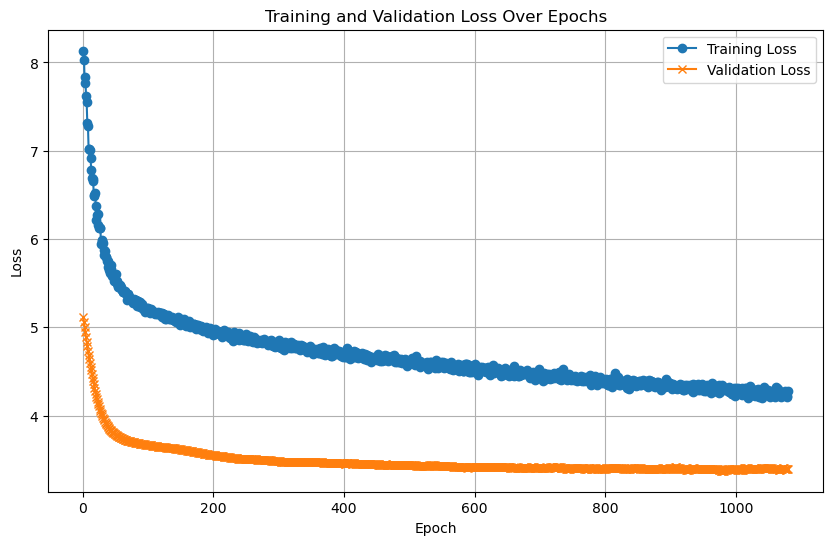

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/19], Loss: 7.4154

Test Loss: 5.4717


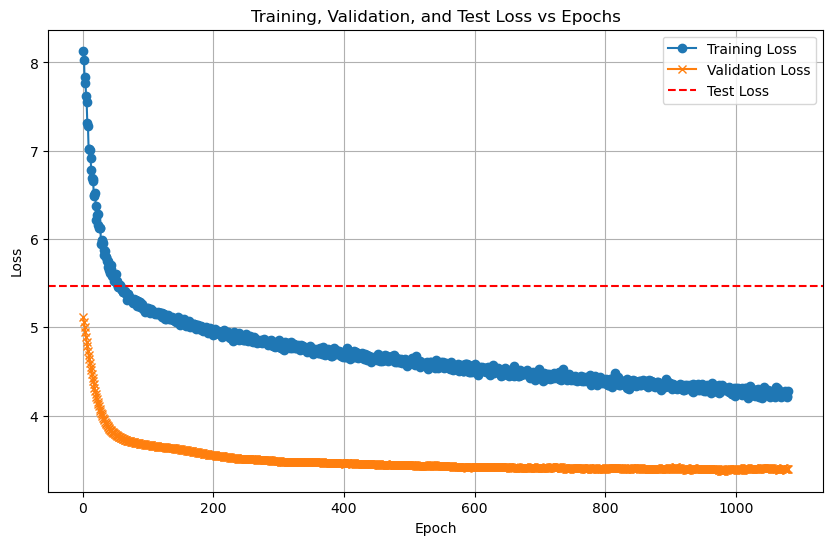

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/19 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (520, 128)
Train labels shape: (520,)
Val reps shape: (65, 128)
Val labels shape: (65,)
Test reps shape: (4626, 128)
Test labels shape: (4626,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 58.46%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.60      0.55         5
           1       0.75      0.60      0.67         5
           2       0.50      0.80      0.62         5
           3       0.33      0.20      0.25         5
           4       0.57      0.80      0.67         5
           5       0.33      0.20      0.25         5
           6       0.80      0.80      0.80         5
           7       0.20      0.20      0.20         5
           8       0.71      1.00      0.83         5
           9       0.00      0.00      0.00         5
          10       1.00      1.00      1.00         5
          11       0.67      0.40      0.50         5
          12       0.71      1.00      0.83         5

    accuracy         

### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (520, 128)
Train labels shape: (520,)
Val reps shape: (65, 128)
Val labels shape: (65,)
Test reps shape: (4626, 128)
Test labels shape: (4626,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.6346  |  Val Loss: 2.6327
Validation loss improved from inf to 2.6327.
[Epoch 2/1000] Train Loss: 2.5999  |  Val Loss: 2.6180
Validation loss improved from 2.6327 to 2.6180.
[Epoch 3/1000] Train Loss: 2.5707  |  Val Loss: 2.6079
Validation loss improved from 2.6180 to 2.6079.
[Epoch 4/1000] Train Loss: 2.5514  |  Val Loss: 2.6012
Validation loss improved from 2.6079 to 2.6012.
[Epoch 5/1000] Train Loss: 2.5363  |  Val Loss: 2.5939
Validation loss improved from 2.6012 to 2.5939.


[Epoch 6/1000] Train Loss: 2.5229  |  Val Loss: 2.5871
Validation loss improved from 2.5939 to 2.5871.
[Epoch 7/1000] Train Loss: 2.5113  |  Val Loss: 2.5814
Validation loss improved from 2.5871 to 2.5814.
[Epoch 8/1000] Train Loss: 2.5004  |  Val Loss: 2.5752
Validation loss improved from 2.5814 to 2.5752.
[Epoch 9/1000] Train Loss: 2.4910  |  Val Loss: 2.5676
Validation loss improved from 2.5752 to 2.5676.


[Epoch 10/1000] Train Loss: 2.4805  |  Val Loss: 2.5634
Validation loss improved from 2.5676 to 2.5634.
[Epoch 11/1000] Train Loss: 2.4692  |  Val Loss: 2.5616
Validation loss improved from 2.5634 to 2.5616.


[Epoch 12/1000] Train Loss: 2.4580  |  Val Loss: 2.5615
Validation loss improved from 2.5616 to 2.5615.
[Epoch 13/1000] Train Loss: 2.4469  |  Val Loss: 2.5584
Validation loss improved from 2.5615 to 2.5584.
[Epoch 14/1000] Train Loss: 2.4357  |  Val Loss: 2.5544
Validation loss improved from 2.5584 to 2.5544.
[Epoch 15/1000] Train Loss: 2.4250  |  Val Loss: 2.5509
Validation loss improved from 2.5544 to 2.5509.
[Epoch 16/1000] Train Loss: 2.4141  |  Val Loss: 2.5506
Validation loss improved from 2.5509 to 2.5506.
[Epoch 17/1000] Train Loss: 2.4043  |  Val Loss: 2.5505
Validation loss improved from 2.5506 to 2.5505.


[Epoch 18/1000] Train Loss: 2.3954  |  Val Loss: 2.5446
Validation loss improved from 2.5505 to 2.5446.
[Epoch 19/1000] Train Loss: 2.3848  |  Val Loss: 2.5436
Validation loss improved from 2.5446 to 2.5436.
[Epoch 20/1000] Train Loss: 2.3755  |  Val Loss: 2.5404
Validation loss improved from 2.5436 to 2.5404.
[Epoch 21/1000] Train Loss: 2.3665  |  Val Loss: 2.5381
Validation loss improved from 2.5404 to 2.5381.


[Epoch 22/1000] Train Loss: 2.3573  |  Val Loss: 2.5394
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 23/1000] Train Loss: 2.3484  |  Val Loss: 2.5396
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 24/1000] Train Loss: 2.3396  |  Val Loss: 2.5406
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 25/1000] Train Loss: 2.3302  |  Val Loss: 2.5365
Validation loss improved from 2.5381 to 2.5365.
[Epoch 26/1000] Train Loss: 2.3205  |  Val Loss: 2.5363
Validation loss improved from 2.5365 to 2.5363.
[Epoch 27/1000] Train Loss: 2.3112  |  Val Loss: 2.5363
Validation loss improved from 2.5363 to 2.5363.
[Epoch 28/1000] Train Loss: 2.3017  |  Val Loss: 2.5330
Validation loss improved from 2.5363 to 2.5330.


[Epoch 29/1000] Train Loss: 2.2918  |  Val Loss: 2.5299
Validation loss improved from 2.5330 to 2.5299.
[Epoch 30/1000] Train Loss: 2.2843  |  Val Loss: 2.5195
Validation loss improved from 2.5299 to 2.5195.
[Epoch 31/1000] Train Loss: 2.2740  |  Val Loss: 2.5180
Validation loss improved from 2.5195 to 2.5180.
[Epoch 32/1000] Train Loss: 2.2617  |  Val Loss: 2.5210
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 33/1000] Train Loss: 2.2503  |  Val Loss: 2.5268
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 34/1000] Train Loss: 2.2395  |  Val Loss: 2.5217
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 35/1000] Train Loss: 2.2285  |  Val Loss: 2.5165
Validation loss improved from 2.5180 to 2.5165.
[Epoch 36/1000] Train Loss: 2.2187  |  Val Loss: 2.4982
Validation loss improved from 2.5165 to 2.4982.
[Epoch 37/1000] Train Loss: 2.2097  |  Val Loss: 2.4918
Validation loss improved from 2.4982 to 2.4918.
[Epoch 38/1000] Train Loss: 2.1998  |  Val Loss: 2.4999
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 39/1000] Train Loss: 2.1877  |  Val Loss: 2.5058
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 40/1000] Train Loss: 2.1764  |  Val Loss: 2.5057
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 41/1000] Train Loss: 2.1657  |  Val Loss: 2.5108
!! Validation loss did NOT improve !! Patience: 4/100


[Epoch 42/1000] Train Loss: 2.1545  |  Val Loss: 2.5172
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 43/1000] Train Loss: 2.1446  |  Val Loss: 2.5137
!! Validation loss did NOT improve !! Patience: 6/100


[Epoch 44/1000] Train Loss: 2.1339  |  Val Loss: 2.5246
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 45/1000] Train Loss: 2.1228  |  Val Loss: 2.5251
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 46/1000] Train Loss: 2.1113  |  Val Loss: 2.5218
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 47/1000] Train Loss: 2.0998  |  Val Loss: 2.5195
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 48/1000] Train Loss: 2.0894  |  Val Loss: 2.5305
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 49/1000] Train Loss: 2.0773  |  Val Loss: 2.5337
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 50/1000] Train Loss: 2.0660  |  Val Loss: 2.5384
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 51/1000] Train Loss: 2.0543  |  Val Loss: 2.5486
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 52/1000] Train Loss: 2.0433  |  Val Loss: 2.5507
!! Validation loss did NOT improve !! Patience: 15/100
[Epo

[Epoch 54/1000] Train Loss: 2.0218  |  Val Loss: 2.5172
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 55/1000] Train Loss: 2.0150  |  Val Loss: 2.5180
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 56/1000] Train Loss: 2.0039  |  Val Loss: 2.5420
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 57/1000] Train Loss: 1.9871  |  Val Loss: 2.5565
!! Validation loss did NOT improve !! Patience: 20/100


[Epoch 58/1000] Train Loss: 1.9769  |  Val Loss: 2.5782
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 59/1000] Train Loss: 1.9679  |  Val Loss: 2.5497
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 60/1000] Train Loss: 1.9554  |  Val Loss: 2.5549
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 61/1000] Train Loss: 1.9421  |  Val Loss: 2.5647
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 62/1000] Train Loss: 1.9308  |  Val Loss: 2.5680
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 63/1000] Train Loss: 1.9175  |  Val Loss: 2.5782
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 64/1000] Train Loss: 1.9054  |  Val Loss: 2.5779
!! Validation loss did NOT improve !! Patience: 27/100


[Epoch 65/1000] Train Loss: 1.8931  |  Val Loss: 2.5880
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 66/1000] Train Loss: 1.8807  |  Val Loss: 2.5975
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 67/1000] Train Loss: 1.8690  |  Val Loss: 2.6054
!! Validation loss did NOT improve !! Patience: 30/100


[Epoch 68/1000] Train Loss: 1.8575  |  Val Loss: 2.6061
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 69/1000] Train Loss: 1.8477  |  Val Loss: 2.5763
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 70/1000] Train Loss: 1.8392  |  Val Loss: 2.5782
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 71/1000] Train Loss: 1.8248  |  Val Loss: 2.5986
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 72/1000] Train Loss: 1.8111  |  Val Loss: 2.6214
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 73/1000] Train Loss: 1.7992  |  Val Loss: 2.6442
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 74/1000] Train Loss: 1.7858  |  Val Loss: 2.6380
!! Validation loss did NOT improve !! Patience: 37/100


[Epoch 75/1000] Train Loss: 1.7729  |  Val Loss: 2.6381
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 76/1000] Train Loss: 1.7611  |  Val Loss: 2.6348
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 77/1000] Train Loss: 1.7485  |  Val Loss: 2.6475
!! Validation loss did NOT improve !! Patience: 40/100


[Epoch 78/1000] Train Loss: 1.7363  |  Val Loss: 2.6485
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 79/1000] Train Loss: 1.7240  |  Val Loss: 2.6635
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 80/1000] Train Loss: 1.7121  |  Val Loss: 2.6787
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 81/1000] Train Loss: 1.6995  |  Val Loss: 2.6754
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 82/1000] Train Loss: 1.6881  |  Val Loss: 2.6780
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 83/1000] Train Loss: 1.6760  |  Val Loss: 2.6975
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 84/1000] Train Loss: 1.6642  |  Val Loss: 2.7133
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 85/1000] Train Loss: 1.6508  |  Val Loss: 2.7032
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 86/1000] Train Loss: 1.6410  |  Val Loss: 2.7111
!! Validation loss did NOT improve !! Patience: 49/100


[Epoch 87/1000] Train Loss: 1.6282  |  Val Loss: 2.7298
!! Validation loss did NOT improve !! Patience: 50/100


[Epoch 88/1000] Train Loss: 1.6162  |  Val Loss: 2.7517
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 89/1000] Train Loss: 1.6053  |  Val Loss: 2.7627
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 90/1000] Train Loss: 1.5940  |  Val Loss: 2.7689
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 91/1000] Train Loss: 1.5827  |  Val Loss: 2.7797
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 92/1000] Train Loss: 1.5716  |  Val Loss: 2.8040
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 93/1000] Train Loss: 1.5605  |  Val Loss: 2.8136
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 94/1000] Train Loss: 1.5508  |  Val Loss: 2.8243
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 95/1000] Train Loss: 1.5391  |  Val Loss: 2.8398
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 96/1000] Train Loss: 1.5278  |  Val Loss: 2.8567
!! Validation loss did NOT improve !! Patience: 59/100
[

[Epoch 99/1000] Train Loss: 1.4975  |  Val Loss: 2.8891
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 100/1000] Train Loss: 1.4863  |  Val Loss: 2.9059
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 101/1000] Train Loss: 1.4775  |  Val Loss: 2.9237
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 102/1000] Train Loss: 1.4667  |  Val Loss: 2.8830
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 103/1000] Train Loss: 1.4607  |  Val Loss: 2.9019
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 104/1000] Train Loss: 1.4485  |  Val Loss: 2.9284
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 105/1000] Train Loss: 1.4395  |  Val Loss: 2.9605
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 106/1000] Train Loss: 1.4302  |  Val Loss: 2.9659
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 107/1000] Train Loss: 1.4211  |  Val Loss: 2.9544
!! Validation loss did NOT improve !! Patience: 

[Epoch 112/1000] Train Loss: 1.3744  |  Val Loss: 3.0341
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 113/1000] Train Loss: 1.3660  |  Val Loss: 3.0502
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 114/1000] Train Loss: 1.3571  |  Val Loss: 3.0639
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 115/1000] Train Loss: 1.3497  |  Val Loss: 3.0712
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 116/1000] Train Loss: 1.3407  |  Val Loss: 3.1082
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 117/1000] Train Loss: 1.3319  |  Val Loss: 3.1140
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 118/1000] Train Loss: 1.3231  |  Val Loss: 3.1283
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 119/1000] Train Loss: 1.3148  |  Val Loss: 3.1346
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 120/1000] Train Loss: 1.3070  |  Val Loss: 3.1504
!! Validation loss did NOT improve !! Patience:

[Epoch 124/1000] Train Loss: 1.2863  |  Val Loss: 3.1319
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 125/1000] Train Loss: 1.2847  |  Val Loss: 3.1464
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 126/1000] Train Loss: 1.2695  |  Val Loss: 3.2180
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 127/1000] Train Loss: 1.2556  |  Val Loss: 3.2567
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 128/1000] Train Loss: 1.2467  |  Val Loss: 3.2561
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 129/1000] Train Loss: 1.2409  |  Val Loss: 3.2670
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 130/1000] Train Loss: 1.2348  |  Val Loss: 3.2856
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 131/1000] Train Loss: 1.2260  |  Val Loss: 3.3001
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 132/1000] Train Loss: 1.2187  |  Val Loss: 3.3028
!! Validation loss did NOT improve !! Patience:

[Epoch 135/1000] Train Loss: 1.1984  |  Val Loss: 3.3455
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 136/1000] Train Loss: 1.1927  |  Val Loss: 3.3657
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 137/1000] Train Loss: 1.1851  |  Val Loss: 3.3835
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 137 !!
No improvement for 100 epochs.


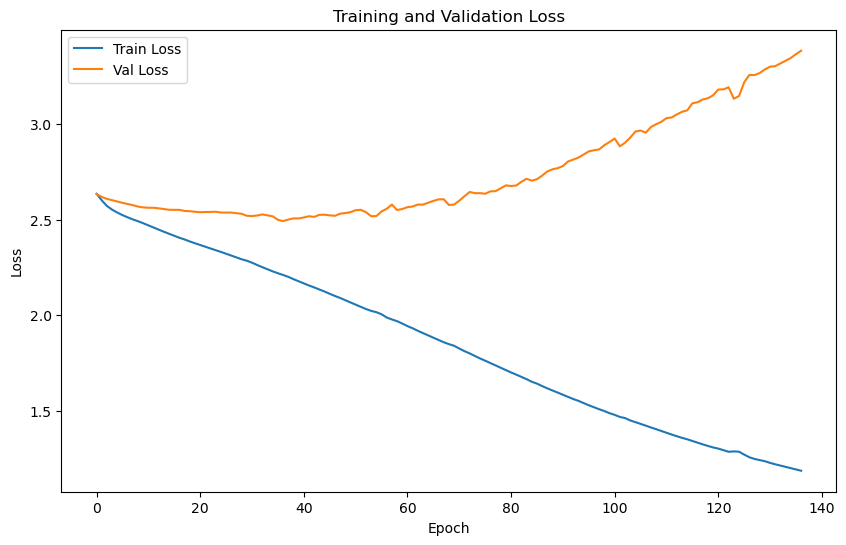

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 2.6198 | Test Accuracy: 60.01%


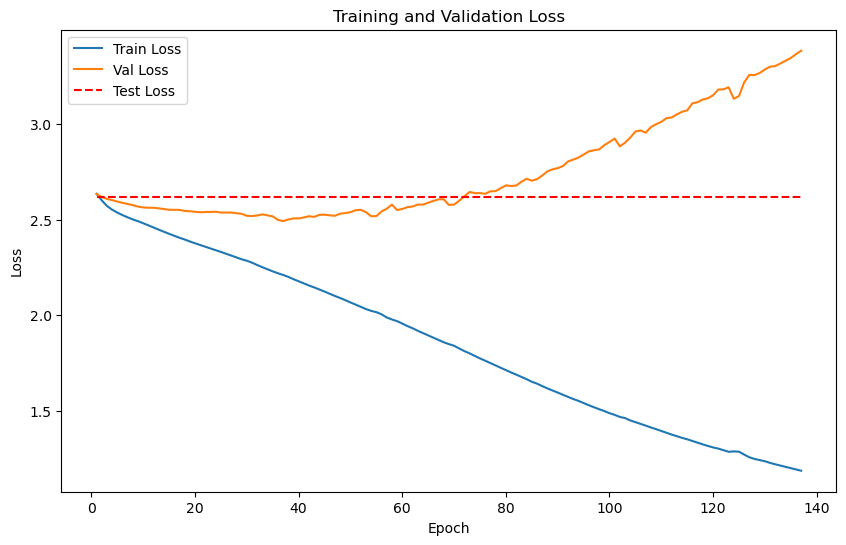

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 520 samples with 64 features each
LOG: Labels shape: (520,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 4626 samples with 64 features each
LOG: Labels shape: (4626,)


Train embeddings shape: (520, 64), 
Train labels shape: (520,)


Val embeddings shape: (65, 64), 
Val labels shape: (65,)


Test embeddings shape: (4626, 64), 
Test labels shape: (4626,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20}
Training batch size: 260


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/2], Train Loss: 0.5305
    Batch [2/2], Train Loss: 0.5320
LOG: Epoch [1/2000] - Validation
    Batch [1/2], Val Loss: 0.6033
    Batch [2/2], Val Loss: 0.5000
Epoch [1/2000], Avg Train Loss: 0.5313, Avg Val Loss: 0.5516

Validation loss improved from inf to 0.5516. Saving model...
LOG: Epoch [2/2000] - Training


    Batch [1/2], Train Loss: 0.5300
    Batch [2/2], Train Loss: 0.5329
LOG: Epoch [2/2000] - Validation
    Batch [1/2], Val Loss: 0.6002
    Batch [2/2], Val Loss: 0.5000
Epoch [2/2000], Avg Train Loss: 0.5315, Avg Val Loss: 0.5501

Validation loss improved from 0.5516 to 0.5501. Saving model...
LOG: Epoch [3/2000] - Training


    Batch [1/2], Train Loss: 0.5314
    Batch [2/2], Train Loss: 0.5291
LOG: Epoch [3/2000] - Validation
    Batch [1/2], Val Loss: 0.5960
    Batch [2/2], Val Loss: 0.5000
Epoch [3/2000], Avg Train Loss: 0.5302, Avg Val Loss: 0.5480

Validation loss improved from 0.5501 to 0.5480. Saving model...
LOG: Epoch [4/2000] - Training


    Batch [1/2], Train Loss: 0.5282
    Batch [2/2], Train Loss: 0.5278
LOG: Epoch [4/2000] - Validation
    Batch [1/2], Val Loss: 0.5920
    Batch [2/2], Val Loss: 0.5000
Epoch [4/2000], Avg Train Loss: 0.5280, Avg Val Loss: 0.5460

Validation loss improved from 0.5480 to 0.5460. Saving model...
LOG: Epoch [5/2000] - Training


    Batch [1/2], Train Loss: 0.5244
    Batch [2/2], Train Loss: 0.5236
LOG: Epoch [5/2000] - Validation
    Batch [1/2], Val Loss: 0.5881
    Batch [2/2], Val Loss: 0.5000
Epoch [5/2000], Avg Train Loss: 0.5240, Avg Val Loss: 0.5441

Validation loss improved from 0.5460 to 0.5441. Saving model...
LOG: Epoch [6/2000] - Training


    Batch [1/2], Train Loss: 0.5260
    Batch [2/2], Train Loss: 0.5201
LOG: Epoch [6/2000] - Validation


    Batch [1/2], Val Loss: 0.5837
    Batch [2/2], Val Loss: 0.5000
Epoch [6/2000], Avg Train Loss: 0.5231, Avg Val Loss: 0.5419

Validation loss improved from 0.5441 to 0.5419. Saving model...
LOG: Epoch [7/2000] - Training
    Batch [1/2], Train Loss: 0.5302


    Batch [2/2], Train Loss: 0.5201
LOG: Epoch [7/2000] - Validation
    Batch [1/2], Val Loss: 0.5793
    Batch [2/2], Val Loss: 0.5000
Epoch [7/2000], Avg Train Loss: 0.5251, Avg Val Loss: 0.5396

Validation loss improved from 0.5419 to 0.5396. Saving model...
LOG: Epoch [8/2000] - Training
    Batch [1/2], Train Loss: 0.5207


    Batch [2/2], Train Loss: 0.5152
LOG: Epoch [8/2000] - Validation
    Batch [1/2], Val Loss: 0.5735
    Batch [2/2], Val Loss: 0.5000
Epoch [8/2000], Avg Train Loss: 0.5180, Avg Val Loss: 0.5367

Validation loss improved from 0.5396 to 0.5367. Saving model...
LOG: Epoch [9/2000] - Training


    Batch [1/2], Train Loss: 0.5164
    Batch [2/2], Train Loss: 0.5190
LOG: Epoch [9/2000] - Validation
    Batch [1/2], Val Loss: 0.5669
    Batch [2/2], Val Loss: 0.5000
Epoch [9/2000], Avg Train Loss: 0.5177, Avg Val Loss: 0.5334

Validation loss improved from 0.5367 to 0.5334. Saving model...
LOG: Epoch [10/2000] - Training


    Batch [1/2], Train Loss: 0.5199
    Batch [2/2], Train Loss: 0.5191
LOG: Epoch [10/2000] - Validation


    Batch [1/2], Val Loss: 0.5611
    Batch [2/2], Val Loss: 0.5000
Epoch [10/2000], Avg Train Loss: 0.5195, Avg Val Loss: 0.5306

Validation loss improved from 0.5334 to 0.5306. Saving model...
LOG: Epoch [11/2000] - Training
    Batch [1/2], Train Loss: 0.5228


    Batch [2/2], Train Loss: 0.5193
LOG: Epoch [11/2000] - Validation
    Batch [1/2], Val Loss: 0.5563
    Batch [2/2], Val Loss: 0.5000
Epoch [11/2000], Avg Train Loss: 0.5211, Avg Val Loss: 0.5282

Validation loss improved from 0.5306 to 0.5282. Saving model...
LOG: Epoch [12/2000] - Training


    Batch [1/2], Train Loss: 0.5164
    Batch [2/2], Train Loss: 0.5178
LOG: Epoch [12/2000] - Validation


    Batch [1/2], Val Loss: 0.5520
    Batch [2/2], Val Loss: 0.5000
Epoch [12/2000], Avg Train Loss: 0.5171, Avg Val Loss: 0.5260

Validation loss improved from 0.5282 to 0.5260. Saving model...
LOG: Epoch [13/2000] - Training
    Batch [1/2], Train Loss: 0.5155


    Batch [2/2], Train Loss: 0.5129
LOG: Epoch [13/2000] - Validation
    Batch [1/2], Val Loss: 0.5489
    Batch [2/2], Val Loss: 0.5000
Epoch [13/2000], Avg Train Loss: 0.5142, Avg Val Loss: 0.5245

Validation loss improved from 0.5260 to 0.5245. Saving model...
LOG: Epoch [14/2000] - Training
    Batch [1/2], Train Loss: 0.5137


    Batch [2/2], Train Loss: 0.5146
LOG: Epoch [14/2000] - Validation
    Batch [1/2], Val Loss: 0.5464
    Batch [2/2], Val Loss: 0.5000
Epoch [14/2000], Avg Train Loss: 0.5142, Avg Val Loss: 0.5232

Validation loss improved from 0.5245 to 0.5232. Saving model...
LOG: Epoch [15/2000] - Training
    Batch [1/2], Train Loss: 0.5157


    Batch [2/2], Train Loss: 0.5127
LOG: Epoch [15/2000] - Validation
    Batch [1/2], Val Loss: 0.5438
    Batch [2/2], Val Loss: 0.5000
Epoch [15/2000], Avg Train Loss: 0.5142, Avg Val Loss: 0.5219

Validation loss improved from 0.5232 to 0.5219. Saving model...
LOG: Epoch [16/2000] - Training
    Batch [1/2], Train Loss: 0.5134


    Batch [2/2], Train Loss: 0.5160
LOG: Epoch [16/2000] - Validation
    Batch [1/2], Val Loss: 0.5405
    Batch [2/2], Val Loss: 0.5000
Epoch [16/2000], Avg Train Loss: 0.5147, Avg Val Loss: 0.5203

Validation loss improved from 0.5219 to 0.5203. Saving model...
LOG: Epoch [17/2000] - Training


    Batch [1/2], Train Loss: 0.5077
    Batch [2/2], Train Loss: 0.5133
LOG: Epoch [17/2000] - Validation
    Batch [1/2], Val Loss: 0.5369
    Batch [2/2], Val Loss: 0.5000
Epoch [17/2000], Avg Train Loss: 0.5105, Avg Val Loss: 0.5184

Validation loss improved from 0.5203 to 0.5184. Saving model...
LOG: Epoch [18/2000] - Training


    Batch [1/2], Train Loss: 0.5081
    Batch [2/2], Train Loss: 0.5072
LOG: Epoch [18/2000] - Validation
    Batch [1/2], Val Loss: 0.5336
    Batch [2/2], Val Loss: 0.5000
Epoch [18/2000], Avg Train Loss: 0.5077, Avg Val Loss: 0.5168

Validation loss improved from 0.5184 to 0.5168. Saving model...
LOG: Epoch [19/2000] - Training


    Batch [1/2], Train Loss: 0.5087
    Batch [2/2], Train Loss: 0.5087
LOG: Epoch [19/2000] - Validation
    Batch [1/2], Val Loss: 0.5304
    Batch [2/2], Val Loss: 0.5000
Epoch [19/2000], Avg Train Loss: 0.5087, Avg Val Loss: 0.5152

Validation loss improved from 0.5168 to 0.5152. Saving model...
LOG: Epoch [20/2000] - Training


    Batch [1/2], Train Loss: 0.5128
    Batch [2/2], Train Loss: 0.5092
LOG: Epoch [20/2000] - Validation
    Batch [1/2], Val Loss: 0.5279
    Batch [2/2], Val Loss: 0.5000
Epoch [20/2000], Avg Train Loss: 0.5110, Avg Val Loss: 0.5140

Validation loss improved from 0.5152 to 0.5140. Saving model...
LOG: Epoch [21/2000] - Training


    Batch [1/2], Train Loss: 0.5106
    Batch [2/2], Train Loss: 0.5105
LOG: Epoch [21/2000] - Validation
    Batch [1/2], Val Loss: 0.5249
    Batch [2/2], Val Loss: 0.5000
Epoch [21/2000], Avg Train Loss: 0.5106, Avg Val Loss: 0.5125

Validation loss improved from 0.5140 to 0.5125. Saving model...
LOG: Epoch [22/2000] - Training


    Batch [1/2], Train Loss: 0.5103
    Batch [2/2], Train Loss: 0.5090
LOG: Epoch [22/2000] - Validation
    Batch [1/2], Val Loss: 0.5223
    Batch [2/2], Val Loss: 0.5000
Epoch [22/2000], Avg Train Loss: 0.5097, Avg Val Loss: 0.5112

Validation loss improved from 0.5125 to 0.5112. Saving model...
LOG: Epoch [23/2000] - Training


    Batch [1/2], Train Loss: 0.5087
    Batch [2/2], Train Loss: 0.5043
LOG: Epoch [23/2000] - Validation


    Batch [1/2], Val Loss: 0.5203
    Batch [2/2], Val Loss: 0.5000
Epoch [23/2000], Avg Train Loss: 0.5065, Avg Val Loss: 0.5101

Validation loss improved from 0.5112 to 0.5101. Saving model...
LOG: Epoch [24/2000] - Training
    Batch [1/2], Train Loss: 0.5070


    Batch [2/2], Train Loss: 0.5084
LOG: Epoch [24/2000] - Validation
    Batch [1/2], Val Loss: 0.5181
    Batch [2/2], Val Loss: 0.5000
Epoch [24/2000], Avg Train Loss: 0.5077, Avg Val Loss: 0.5091

Validation loss improved from 0.5101 to 0.5091. Saving model...
LOG: Epoch [25/2000] - Training
    Batch [1/2], Train Loss: 0.5069


    Batch [2/2], Train Loss: 0.5103
LOG: Epoch [25/2000] - Validation
    Batch [1/2], Val Loss: 0.5162
    Batch [2/2], Val Loss: 0.5000
Epoch [25/2000], Avg Train Loss: 0.5086, Avg Val Loss: 0.5081

Validation loss improved from 0.5091 to 0.5081. Saving model...
LOG: Epoch [26/2000] - Training


    Batch [1/2], Train Loss: 0.5070
    Batch [2/2], Train Loss: 0.5057
LOG: Epoch [26/2000] - Validation


    Batch [1/2], Val Loss: 0.5147
    Batch [2/2], Val Loss: 0.5000
Epoch [26/2000], Avg Train Loss: 0.5064, Avg Val Loss: 0.5074

Validation loss improved from 0.5081 to 0.5074. Saving model...
LOG: Epoch [27/2000] - Training
    Batch [1/2], Train Loss: 0.5029


    Batch [2/2], Train Loss: 0.5020
LOG: Epoch [27/2000] - Validation
    Batch [1/2], Val Loss: 0.5136
    Batch [2/2], Val Loss: 0.5000
Epoch [27/2000], Avg Train Loss: 0.5024, Avg Val Loss: 0.5068

Validation loss improved from 0.5074 to 0.5068. Saving model...
LOG: Epoch [28/2000] - Training
    Batch [1/2], Train Loss: 0.5032


    Batch [2/2], Train Loss: 0.5066
LOG: Epoch [28/2000] - Validation
    Batch [1/2], Val Loss: 0.5126
    Batch [2/2], Val Loss: 0.5000
Epoch [28/2000], Avg Train Loss: 0.5049, Avg Val Loss: 0.5063

Validation loss improved from 0.5068 to 0.5063. Saving model...
LOG: Epoch [29/2000] - Training


    Batch [1/2], Train Loss: 0.5042
    Batch [2/2], Train Loss: 0.5061
LOG: Epoch [29/2000] - Validation


    Batch [1/2], Val Loss: 0.5116
    Batch [2/2], Val Loss: 0.5000
Epoch [29/2000], Avg Train Loss: 0.5052, Avg Val Loss: 0.5058

Validation loss improved from 0.5063 to 0.5058. Saving model...
LOG: Epoch [30/2000] - Training
    Batch [1/2], Train Loss: 0.4985


    Batch [2/2], Train Loss: 0.5019
LOG: Epoch [30/2000] - Validation
    Batch [1/2], Val Loss: 0.5106
    Batch [2/2], Val Loss: 0.5000
Epoch [30/2000], Avg Train Loss: 0.5002, Avg Val Loss: 0.5053

Validation loss improved from 0.5058 to 0.5053. Saving model...
LOG: Epoch [31/2000] - Training
    Batch [1/2], Train Loss: 0.5005


    Batch [2/2], Train Loss: 0.5003
LOG: Epoch [31/2000] - Validation
    Batch [1/2], Val Loss: 0.5101
    Batch [2/2], Val Loss: 0.5000
Epoch [31/2000], Avg Train Loss: 0.5004, Avg Val Loss: 0.5050

Validation loss improved from 0.5053 to 0.5050. Saving model...
LOG: Epoch [32/2000] - Training
    Batch [1/2], Train Loss: 0.5029


    Batch [2/2], Train Loss: 0.5020
LOG: Epoch [32/2000] - Validation
    Batch [1/2], Val Loss: 0.5096
    Batch [2/2], Val Loss: 0.5000
Epoch [32/2000], Avg Train Loss: 0.5025, Avg Val Loss: 0.5048

Validation loss improved from 0.5050 to 0.5048. Saving model...
LOG: Epoch [33/2000] - Training
    Batch [1/2], Train Loss: 0.5018


    Batch [2/2], Train Loss: 0.4982
LOG: Epoch [33/2000] - Validation
    Batch [1/2], Val Loss: 0.5087
    Batch [2/2], Val Loss: 0.5000
Epoch [33/2000], Avg Train Loss: 0.5000, Avg Val Loss: 0.5044

Validation loss improved from 0.5048 to 0.5044. Saving model...
LOG: Epoch [34/2000] - Training


    Batch [1/2], Train Loss: 0.5036
    Batch [2/2], Train Loss: 0.5010
LOG: Epoch [34/2000] - Validation
    Batch [1/2], Val Loss: 0.5084
    Batch [2/2], Val Loss: 0.5000
Epoch [34/2000], Avg Train Loss: 0.5023, Avg Val Loss: 0.5042

Validation loss improved from 0.5044 to 0.5042. Saving model...
LOG: Epoch [35/2000] - Training


    Batch [1/2], Train Loss: 0.5023
    Batch [2/2], Train Loss: 0.5003
LOG: Epoch [35/2000] - Validation


    Batch [1/2], Val Loss: 0.5081
    Batch [2/2], Val Loss: 0.5000
Epoch [35/2000], Avg Train Loss: 0.5013, Avg Val Loss: 0.5040

Validation loss improved from 0.5042 to 0.5040. Saving model...
LOG: Epoch [36/2000] - Training
    Batch [1/2], Train Loss: 0.5011


    Batch [2/2], Train Loss: 0.5004
LOG: Epoch [36/2000] - Validation
    Batch [1/2], Val Loss: 0.5072
    Batch [2/2], Val Loss: 0.5000
Epoch [36/2000], Avg Train Loss: 0.5008, Avg Val Loss: 0.5036

Validation loss improved from 0.5040 to 0.5036. Saving model...
LOG: Epoch [37/2000] - Training
    Batch [1/2], Train Loss: 0.5006


    Batch [2/2], Train Loss: 0.4987
LOG: Epoch [37/2000] - Validation
    Batch [1/2], Val Loss: 0.5064
    Batch [2/2], Val Loss: 0.5000
Epoch [37/2000], Avg Train Loss: 0.4996, Avg Val Loss: 0.5032

Validation loss improved from 0.5036 to 0.5032. Saving model...
LOG: Epoch [38/2000] - Training
    Batch [1/2], Train Loss: 0.4974


    Batch [2/2], Train Loss: 0.4966
LOG: Epoch [38/2000] - Validation
    Batch [1/2], Val Loss: 0.5063
    Batch [2/2], Val Loss: 0.5000
Epoch [38/2000], Avg Train Loss: 0.4970, Avg Val Loss: 0.5031

Validation loss improved from 0.5032 to 0.5031. Saving model...
LOG: Epoch [39/2000] - Training
    Batch [1/2], Train Loss: 0.5020


    Batch [2/2], Train Loss: 0.4987
LOG: Epoch [39/2000] - Validation
    Batch [1/2], Val Loss: 0.5057
    Batch [2/2], Val Loss: 0.5000
Epoch [39/2000], Avg Train Loss: 0.5003, Avg Val Loss: 0.5029

Validation loss improved from 0.5031 to 0.5029. Saving model...
LOG: Epoch [40/2000] - Training
    Batch [1/2], Train Loss: 0.4973


    Batch [2/2], Train Loss: 0.4991
LOG: Epoch [40/2000] - Validation
    Batch [1/2], Val Loss: 0.5052
    Batch [2/2], Val Loss: 0.5000
Epoch [40/2000], Avg Train Loss: 0.4982, Avg Val Loss: 0.5026

Validation loss improved from 0.5029 to 0.5026. Saving model...
LOG: Epoch [41/2000] - Training
    Batch [1/2], Train Loss: 0.4995


    Batch [2/2], Train Loss: 0.4993
LOG: Epoch [41/2000] - Validation
    Batch [1/2], Val Loss: 0.5051
    Batch [2/2], Val Loss: 0.5000
Epoch [41/2000], Avg Train Loss: 0.4994, Avg Val Loss: 0.5026

Validation loss improved from 0.5026 to 0.5026. Saving model...
LOG: Epoch [42/2000] - Training
    Batch [1/2], Train Loss: 0.4953


    Batch [2/2], Train Loss: 0.5000
LOG: Epoch [42/2000] - Validation
    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.5000
Epoch [42/2000], Avg Train Loss: 0.4977, Avg Val Loss: 0.5023

Validation loss improved from 0.5026 to 0.5023. Saving model...
LOG: Epoch [43/2000] - Training
    Batch [1/2], Train Loss: 0.4919


    Batch [2/2], Train Loss: 0.4977
LOG: Epoch [43/2000] - Validation
    Batch [1/2], Val Loss: 0.5045
    Batch [2/2], Val Loss: 0.5000
Epoch [43/2000], Avg Train Loss: 0.4948, Avg Val Loss: 0.5022

Validation loss improved from 0.5023 to 0.5022. Saving model...
LOG: Epoch [44/2000] - Training


    Batch [1/2], Train Loss: 0.4948
    Batch [2/2], Train Loss: 0.4966
LOG: Epoch [44/2000] - Validation
    Batch [1/2], Val Loss: 0.5043
    Batch [2/2], Val Loss: 0.5000
Epoch [44/2000], Avg Train Loss: 0.4957, Avg Val Loss: 0.5022

Validation loss improved from 0.5022 to 0.5022. Saving model...
LOG: Epoch [45/2000] - Training


    Batch [1/2], Train Loss: 0.4951
    Batch [2/2], Train Loss: 0.4952
LOG: Epoch [45/2000] - Validation
    Batch [1/2], Val Loss: 0.5043
    Batch [2/2], Val Loss: 0.5000
Epoch [45/2000], Avg Train Loss: 0.4951, Avg Val Loss: 0.5021

Validation loss improved from 0.5022 to 0.5021. Saving model...
LOG: Epoch [46/2000] - Training


    Batch [1/2], Train Loss: 0.4947
    Batch [2/2], Train Loss: 0.4940
LOG: Epoch [46/2000] - Validation
    Batch [1/2], Val Loss: 0.5043
    Batch [2/2], Val Loss: 0.5000
Epoch [46/2000], Avg Train Loss: 0.4944, Avg Val Loss: 0.5022

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [47/2000] - Training


    Batch [1/2], Train Loss: 0.4999
    Batch [2/2], Train Loss: 0.4954
LOG: Epoch [47/2000] - Validation
    Batch [1/2], Val Loss: 0.5043
    Batch [2/2], Val Loss: 0.5000
Epoch [47/2000], Avg Train Loss: 0.4977, Avg Val Loss: 0.5021

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [48/2000] - Training


    Batch [1/2], Train Loss: 0.4978
    Batch [2/2], Train Loss: 0.4979
LOG: Epoch [48/2000] - Validation
    Batch [1/2], Val Loss: 0.5042
    Batch [2/2], Val Loss: 0.5000
Epoch [48/2000], Avg Train Loss: 0.4979, Avg Val Loss: 0.5021

Validation loss improved from 0.5021 to 0.5021. Saving model...
LOG: Epoch [49/2000] - Training


    Batch [1/2], Train Loss: 0.4965
    Batch [2/2], Train Loss: 0.4952
LOG: Epoch [49/2000] - Validation
    Batch [1/2], Val Loss: 0.5041
    Batch [2/2], Val Loss: 0.5000
Epoch [49/2000], Avg Train Loss: 0.4958, Avg Val Loss: 0.5020

Validation loss improved from 0.5021 to 0.5020. Saving model...
LOG: Epoch [50/2000] - Training


    Batch [1/2], Train Loss: 0.4941
    Batch [2/2], Train Loss: 0.4967
LOG: Epoch [50/2000] - Validation
    Batch [1/2], Val Loss: 0.5039
    Batch [2/2], Val Loss: 0.5000
Epoch [50/2000], Avg Train Loss: 0.4954, Avg Val Loss: 0.5019

Validation loss improved from 0.5020 to 0.5019. Saving model...
LOG: Epoch [51/2000] - Training


    Batch [1/2], Train Loss: 0.4982
    Batch [2/2], Train Loss: 0.4956
LOG: Epoch [51/2000] - Validation
    Batch [1/2], Val Loss: 0.5037
    Batch [2/2], Val Loss: 0.5000
Epoch [51/2000], Avg Train Loss: 0.4969, Avg Val Loss: 0.5019

Validation loss improved from 0.5019 to 0.5019. Saving model...
LOG: Epoch [52/2000] - Training


    Batch [1/2], Train Loss: 0.4912
    Batch [2/2], Train Loss: 0.4977
LOG: Epoch [52/2000] - Validation
    Batch [1/2], Val Loss: 0.5033
    Batch [2/2], Val Loss: 0.5000
Epoch [52/2000], Avg Train Loss: 0.4945, Avg Val Loss: 0.5016

Validation loss improved from 0.5019 to 0.5016. Saving model...
LOG: Epoch [53/2000] - Training


    Batch [1/2], Train Loss: 0.4920
    Batch [2/2], Train Loss: 0.4910
LOG: Epoch [53/2000] - Validation


    Batch [1/2], Val Loss: 0.5034
    Batch [2/2], Val Loss: 0.5000
Epoch [53/2000], Avg Train Loss: 0.4915, Avg Val Loss: 0.5017

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [54/2000] - Training
    Batch [1/2], Train Loss: 0.4957


    Batch [2/2], Train Loss: 0.4915
LOG: Epoch [54/2000] - Validation
    Batch [1/2], Val Loss: 0.5031
    Batch [2/2], Val Loss: 0.5000
Epoch [54/2000], Avg Train Loss: 0.4936, Avg Val Loss: 0.5016

Validation loss improved from 0.5016 to 0.5016. Saving model...
LOG: Epoch [55/2000] - Training
    Batch [1/2], Train Loss: 0.4906


    Batch [2/2], Train Loss: 0.4955
LOG: Epoch [55/2000] - Validation
    Batch [1/2], Val Loss: 0.5029
    Batch [2/2], Val Loss: 0.5000
Epoch [55/2000], Avg Train Loss: 0.4931, Avg Val Loss: 0.5014

Validation loss improved from 0.5016 to 0.5014. Saving model...
LOG: Epoch [56/2000] - Training
    Batch [1/2], Train Loss: 0.4912


    Batch [2/2], Train Loss: 0.4963
LOG: Epoch [56/2000] - Validation
    Batch [1/2], Val Loss: 0.5026
    Batch [2/2], Val Loss: 0.5000
Epoch [56/2000], Avg Train Loss: 0.4938, Avg Val Loss: 0.5013

Validation loss improved from 0.5014 to 0.5013. Saving model...
LOG: Epoch [57/2000] - Training
    Batch [1/2], Train Loss: 0.4949


    Batch [2/2], Train Loss: 0.4955
LOG: Epoch [57/2000] - Validation
    Batch [1/2], Val Loss: 0.5017
    Batch [2/2], Val Loss: 0.5000
Epoch [57/2000], Avg Train Loss: 0.4952, Avg Val Loss: 0.5009

Validation loss improved from 0.5013 to 0.5009. Saving model...
LOG: Epoch [58/2000] - Training
    Batch [1/2], Train Loss: 0.4937


    Batch [2/2], Train Loss: 0.4868
LOG: Epoch [58/2000] - Validation
    Batch [1/2], Val Loss: 0.5013
    Batch [2/2], Val Loss: 0.5000
Epoch [58/2000], Avg Train Loss: 0.4902, Avg Val Loss: 0.5007

Validation loss improved from 0.5009 to 0.5007. Saving model...
LOG: Epoch [59/2000] - Training
    Batch [1/2], Train Loss: 0.4909


    Batch [2/2], Train Loss: 0.4824
LOG: Epoch [59/2000] - Validation
    Batch [1/2], Val Loss: 0.5009
    Batch [2/2], Val Loss: 0.5000
Epoch [59/2000], Avg Train Loss: 0.4866, Avg Val Loss: 0.5005

Validation loss improved from 0.5007 to 0.5005. Saving model...
LOG: Epoch [60/2000] - Training


    Batch [1/2], Train Loss: 0.4920
    Batch [2/2], Train Loss: 0.4924
LOG: Epoch [60/2000] - Validation


    Batch [1/2], Val Loss: 0.5008
    Batch [2/2], Val Loss: 0.5000
Epoch [60/2000], Avg Train Loss: 0.4922, Avg Val Loss: 0.5004

Validation loss improved from 0.5005 to 0.5004. Saving model...
LOG: Epoch [61/2000] - Training
    Batch [1/2], Train Loss: 0.4970


    Batch [2/2], Train Loss: 0.4927
LOG: Epoch [61/2000] - Validation
    Batch [1/2], Val Loss: 0.5014
    Batch [2/2], Val Loss: 0.5000
Epoch [61/2000], Avg Train Loss: 0.4948, Avg Val Loss: 0.5007

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [62/2000] - Training
    Batch [1/2], Train Loss: 0.4911


    Batch [2/2], Train Loss: 0.4878
LOG: Epoch [62/2000] - Validation
    Batch [1/2], Val Loss: 0.5012
    Batch [2/2], Val Loss: 0.5000
Epoch [62/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.5006

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [63/2000] - Training
    Batch [1/2], Train Loss: 0.4906


    Batch [2/2], Train Loss: 0.4935
LOG: Epoch [63/2000] - Validation
    Batch [1/2], Val Loss: 0.5014
    Batch [2/2], Val Loss: 0.5000
Epoch [63/2000], Avg Train Loss: 0.4920, Avg Val Loss: 0.5007

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [64/2000] - Training
    Batch [1/2], Train Loss: 0.4880


    Batch [2/2], Train Loss: 0.4904
LOG: Epoch [64/2000] - Validation
    Batch [1/2], Val Loss: 0.5012
    Batch [2/2], Val Loss: 0.5000
Epoch [64/2000], Avg Train Loss: 0.4892, Avg Val Loss: 0.5006

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [65/2000] - Training
    Batch [1/2], Train Loss: 0.4904


    Batch [2/2], Train Loss: 0.4898
LOG: Epoch [65/2000] - Validation
    Batch [1/2], Val Loss: 0.4998
    Batch [2/2], Val Loss: 0.5000
Epoch [65/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.4999

Validation loss improved from 0.5004 to 0.4999. Saving model...
LOG: Epoch [66/2000] - Training
    Batch [1/2], Train Loss: 0.4910


    Batch [2/2], Train Loss: 0.4862
LOG: Epoch [66/2000] - Validation
    Batch [1/2], Val Loss: 0.4985
    Batch [2/2], Val Loss: 0.5000
Epoch [66/2000], Avg Train Loss: 0.4886, Avg Val Loss: 0.4993

Validation loss improved from 0.4999 to 0.4993. Saving model...
LOG: Epoch [67/2000] - Training
    Batch [1/2], Train Loss: 0.4942


    Batch [2/2], Train Loss: 0.4905
LOG: Epoch [67/2000] - Validation
    Batch [1/2], Val Loss: 0.4968
    Batch [2/2], Val Loss: 0.5000
Epoch [67/2000], Avg Train Loss: 0.4923, Avg Val Loss: 0.4984

Validation loss improved from 0.4993 to 0.4984. Saving model...
LOG: Epoch [68/2000] - Training


    Batch [1/2], Train Loss: 0.4867
    Batch [2/2], Train Loss: 0.4860
LOG: Epoch [68/2000] - Validation
    Batch [1/2], Val Loss: 0.4960
    Batch [2/2], Val Loss: 0.5000
Epoch [68/2000], Avg Train Loss: 0.4863, Avg Val Loss: 0.4980

Validation loss improved from 0.4984 to 0.4980. Saving model...
LOG: Epoch [69/2000] - Training


    Batch [1/2], Train Loss: 0.4928
    Batch [2/2], Train Loss: 0.4921
LOG: Epoch [69/2000] - Validation


    Batch [1/2], Val Loss: 0.4951
    Batch [2/2], Val Loss: 0.5000
Epoch [69/2000], Avg Train Loss: 0.4924, Avg Val Loss: 0.4976

Validation loss improved from 0.4980 to 0.4976. Saving model...
LOG: Epoch [70/2000] - Training
    Batch [1/2], Train Loss: 0.4857


    Batch [2/2], Train Loss: 0.4873
LOG: Epoch [70/2000] - Validation
    Batch [1/2], Val Loss: 0.4950
    Batch [2/2], Val Loss: 0.5000
Epoch [70/2000], Avg Train Loss: 0.4865, Avg Val Loss: 0.4975

Validation loss improved from 0.4976 to 0.4975. Saving model...
LOG: Epoch [71/2000] - Training
    Batch [1/2], Train Loss: 0.4856


    Batch [2/2], Train Loss: 0.4881
LOG: Epoch [71/2000] - Validation
    Batch [1/2], Val Loss: 0.4950
    Batch [2/2], Val Loss: 0.5000
Epoch [71/2000], Avg Train Loss: 0.4868, Avg Val Loss: 0.4975

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [72/2000] - Training
    Batch [1/2], Train Loss: 0.4937


    Batch [2/2], Train Loss: 0.4833
LOG: Epoch [72/2000] - Validation
    Batch [1/2], Val Loss: 0.4942
    Batch [2/2], Val Loss: 0.5000
Epoch [72/2000], Avg Train Loss: 0.4885, Avg Val Loss: 0.4971

Validation loss improved from 0.4975 to 0.4971. Saving model...
LOG: Epoch [73/2000] - Training
    Batch [1/2], Train Loss: 0.4845


    Batch [2/2], Train Loss: 0.4853
LOG: Epoch [73/2000] - Validation
    Batch [1/2], Val Loss: 0.4941
    Batch [2/2], Val Loss: 0.5000
Epoch [73/2000], Avg Train Loss: 0.4849, Avg Val Loss: 0.4971

Validation loss improved from 0.4971 to 0.4971. Saving model...
LOG: Epoch [74/2000] - Training
    Batch [1/2], Train Loss: 0.4856


    Batch [2/2], Train Loss: 0.4840
LOG: Epoch [74/2000] - Validation
    Batch [1/2], Val Loss: 0.4929
    Batch [2/2], Val Loss: 0.5000
Epoch [74/2000], Avg Train Loss: 0.4848, Avg Val Loss: 0.4965

Validation loss improved from 0.4971 to 0.4965. Saving model...
LOG: Epoch [75/2000] - Training


    Batch [1/2], Train Loss: 0.4830
    Batch [2/2], Train Loss: 0.4860
LOG: Epoch [75/2000] - Validation
    Batch [1/2], Val Loss: 0.4921
    Batch [2/2], Val Loss: 0.5000
Epoch [75/2000], Avg Train Loss: 0.4845, Avg Val Loss: 0.4961

Validation loss improved from 0.4965 to 0.4961. Saving model...
LOG: Epoch [76/2000] - Training


    Batch [1/2], Train Loss: 0.4838
    Batch [2/2], Train Loss: 0.4879
LOG: Epoch [76/2000] - Validation
    Batch [1/2], Val Loss: 0.4913
    Batch [2/2], Val Loss: 0.5000
Epoch [76/2000], Avg Train Loss: 0.4858, Avg Val Loss: 0.4957

Validation loss improved from 0.4961 to 0.4957. Saving model...
LOG: Epoch [77/2000] - Training


    Batch [1/2], Train Loss: 0.4844
    Batch [2/2], Train Loss: 0.4854
LOG: Epoch [77/2000] - Validation
    Batch [1/2], Val Loss: 0.4910
    Batch [2/2], Val Loss: 0.5000
Epoch [77/2000], Avg Train Loss: 0.4849, Avg Val Loss: 0.4955

Validation loss improved from 0.4957 to 0.4955. Saving model...
LOG: Epoch [78/2000] - Training


    Batch [1/2], Train Loss: 0.4851
    Batch [2/2], Train Loss: 0.4827
LOG: Epoch [78/2000] - Validation
    Batch [1/2], Val Loss: 0.4913
    Batch [2/2], Val Loss: 0.5000
Epoch [78/2000], Avg Train Loss: 0.4839, Avg Val Loss: 0.4956

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [79/2000] - Training


    Batch [1/2], Train Loss: 0.4890
    Batch [2/2], Train Loss: 0.4839
LOG: Epoch [79/2000] - Validation


    Batch [1/2], Val Loss: 0.4914
    Batch [2/2], Val Loss: 0.5000
Epoch [79/2000], Avg Train Loss: 0.4864, Avg Val Loss: 0.4957

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [80/2000] - Training
    Batch [1/2], Train Loss: 0.4829


    Batch [2/2], Train Loss: 0.4794
LOG: Epoch [80/2000] - Validation
    Batch [1/2], Val Loss: 0.4920
    Batch [2/2], Val Loss: 0.5000
Epoch [80/2000], Avg Train Loss: 0.4812, Avg Val Loss: 0.4960

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [81/2000] - Training
    Batch [1/2], Train Loss: 0.4837


    Batch [2/2], Train Loss: 0.4872
LOG: Epoch [81/2000] - Validation
    Batch [1/2], Val Loss: 0.4917
    Batch [2/2], Val Loss: 0.5000
Epoch [81/2000], Avg Train Loss: 0.4855, Avg Val Loss: 0.4958

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [82/2000] - Training
    Batch [1/2], Train Loss: 0.4850


    Batch [2/2], Train Loss: 0.4854
LOG: Epoch [82/2000] - Validation
    Batch [1/2], Val Loss: 0.4920
    Batch [2/2], Val Loss: 0.5000
Epoch [82/2000], Avg Train Loss: 0.4852, Avg Val Loss: 0.4960

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [83/2000] - Training


    Batch [1/2], Train Loss: 0.4868
    Batch [2/2], Train Loss: 0.4864
LOG: Epoch [83/2000] - Validation


    Batch [1/2], Val Loss: 0.4907
    Batch [2/2], Val Loss: 0.5000
Epoch [83/2000], Avg Train Loss: 0.4866, Avg Val Loss: 0.4953

Validation loss improved from 0.4955 to 0.4953. Saving model...
LOG: Epoch [84/2000] - Training
    Batch [1/2], Train Loss: 0.4860


    Batch [2/2], Train Loss: 0.4846
LOG: Epoch [84/2000] - Validation
    Batch [1/2], Val Loss: 0.4895
    Batch [2/2], Val Loss: 0.5000
Epoch [84/2000], Avg Train Loss: 0.4853, Avg Val Loss: 0.4947

Validation loss improved from 0.4953 to 0.4947. Saving model...
LOG: Epoch [85/2000] - Training


    Batch [1/2], Train Loss: 0.4855
    Batch [2/2], Train Loss: 0.4857
LOG: Epoch [85/2000] - Validation
    Batch [1/2], Val Loss: 0.4885
    Batch [2/2], Val Loss: 0.5000
Epoch [85/2000], Avg Train Loss: 0.4856, Avg Val Loss: 0.4942

Validation loss improved from 0.4947 to 0.4942. Saving model...
LOG: Epoch [86/2000] - Training


    Batch [1/2], Train Loss: 0.4878
    Batch [2/2], Train Loss: 0.4852
LOG: Epoch [86/2000] - Validation
    Batch [1/2], Val Loss: 0.4871
    Batch [2/2], Val Loss: 0.5000
Epoch [86/2000], Avg Train Loss: 0.4865, Avg Val Loss: 0.4936

Validation loss improved from 0.4942 to 0.4936. Saving model...
LOG: Epoch [87/2000] - Training


    Batch [1/2], Train Loss: 0.4816
    Batch [2/2], Train Loss: 0.4826
LOG: Epoch [87/2000] - Validation
    Batch [1/2], Val Loss: 0.4859
    Batch [2/2], Val Loss: 0.5000
Epoch [87/2000], Avg Train Loss: 0.4821, Avg Val Loss: 0.4929

Validation loss improved from 0.4936 to 0.4929. Saving model...
LOG: Epoch [88/2000] - Training


    Batch [1/2], Train Loss: 0.4812
    Batch [2/2], Train Loss: 0.4779
LOG: Epoch [88/2000] - Validation
    Batch [1/2], Val Loss: 0.4855
    Batch [2/2], Val Loss: 0.5000
Epoch [88/2000], Avg Train Loss: 0.4796, Avg Val Loss: 0.4927

Validation loss improved from 0.4929 to 0.4927. Saving model...
LOG: Epoch [89/2000] - Training


    Batch [1/2], Train Loss: 0.4832
    Batch [2/2], Train Loss: 0.4864
LOG: Epoch [89/2000] - Validation
    Batch [1/2], Val Loss: 0.4858
    Batch [2/2], Val Loss: 0.5000
Epoch [89/2000], Avg Train Loss: 0.4848, Avg Val Loss: 0.4929

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [90/2000] - Training


    Batch [1/2], Train Loss: 0.4841
    Batch [2/2], Train Loss: 0.4885
LOG: Epoch [90/2000] - Validation


    Batch [1/2], Val Loss: 0.4859
    Batch [2/2], Val Loss: 0.5000
Epoch [90/2000], Avg Train Loss: 0.4863, Avg Val Loss: 0.4929

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [91/2000] - Training
    Batch [1/2], Train Loss: 0.4840


    Batch [2/2], Train Loss: 0.4840
LOG: Epoch [91/2000] - Validation
    Batch [1/2], Val Loss: 0.4854
    Batch [2/2], Val Loss: 0.5000
Epoch [91/2000], Avg Train Loss: 0.4840, Avg Val Loss: 0.4927

Validation loss improved from 0.4927 to 0.4927. Saving model...
LOG: Epoch [92/2000] - Training


    Batch [1/2], Train Loss: 0.4860
    Batch [2/2], Train Loss: 0.4829
LOG: Epoch [92/2000] - Validation
    Batch [1/2], Val Loss: 0.4862
    Batch [2/2], Val Loss: 0.5000
Epoch [92/2000], Avg Train Loss: 0.4845, Avg Val Loss: 0.4931

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [93/2000] - Training


    Batch [1/2], Train Loss: 0.4842
    Batch [2/2], Train Loss: 0.4818
LOG: Epoch [93/2000] - Validation
    Batch [1/2], Val Loss: 0.4869


    Batch [2/2], Val Loss: 0.5000
Epoch [93/2000], Avg Train Loss: 0.4830, Avg Val Loss: 0.4935

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [94/2000] - Training
    Batch [1/2], Train Loss: 0.4771


    Batch [2/2], Train Loss: 0.4810
LOG: Epoch [94/2000] - Validation
    Batch [1/2], Val Loss: 0.4874
    Batch [2/2], Val Loss: 0.5000
Epoch [94/2000], Avg Train Loss: 0.4790, Avg Val Loss: 0.4937

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [95/2000] - Training
    Batch [1/2], Train Loss: 0.4837


    Batch [2/2], Train Loss: 0.4843
LOG: Epoch [95/2000] - Validation
    Batch [1/2], Val Loss: 0.4877
    Batch [2/2], Val Loss: 0.5000
Epoch [95/2000], Avg Train Loss: 0.4840, Avg Val Loss: 0.4939

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [96/2000] - Training
    Batch [1/2], Train Loss: 0.4761


    Batch [2/2], Train Loss: 0.4805
LOG: Epoch [96/2000] - Validation
    Batch [1/2], Val Loss: 0.4895
    Batch [2/2], Val Loss: 0.5000
Epoch [96/2000], Avg Train Loss: 0.4783, Avg Val Loss: 0.4947

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [97/2000] - Training


    Batch [1/2], Train Loss: 0.4824
    Batch [2/2], Train Loss: 0.4751
LOG: Epoch [97/2000] - Validation


    Batch [1/2], Val Loss: 0.4898
    Batch [2/2], Val Loss: 0.5000
Epoch [97/2000], Avg Train Loss: 0.4788, Avg Val Loss: 0.4949

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [98/2000] - Training
    Batch [1/2], Train Loss: 0.4770


    Batch [2/2], Train Loss: 0.4793
LOG: Epoch [98/2000] - Validation
    Batch [1/2], Val Loss: 0.4901
    Batch [2/2], Val Loss: 0.5000
Epoch [98/2000], Avg Train Loss: 0.4782, Avg Val Loss: 0.4950

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [99/2000] - Training
    Batch [1/2], Train Loss: 0.4815


    Batch [2/2], Train Loss: 0.4800
LOG: Epoch [99/2000] - Validation
    Batch [1/2], Val Loss: 0.4905
    Batch [2/2], Val Loss: 0.5000
Epoch [99/2000], Avg Train Loss: 0.4807, Avg Val Loss: 0.4953

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [100/2000] - Training
    Batch [1/2], Train Loss: 0.4829


    Batch [2/2], Train Loss: 0.4859
LOG: Epoch [100/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [100/2000], Avg Train Loss: 0.4844, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [101/2000] - Training
    Batch [1/2], Train Loss: 0.4818


    Batch [2/2], Train Loss: 0.4789
LOG: Epoch [101/2000] - Validation
    Batch [1/2], Val Loss: 0.4902
    Batch [2/2], Val Loss: 0.5000
Epoch [101/2000], Avg Train Loss: 0.4804, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [102/2000] - Training


    Batch [1/2], Train Loss: 0.4820
    Batch [2/2], Train Loss: 0.4795
LOG: Epoch [102/2000] - Validation
    Batch [1/2], Val Loss: 0.4902
    Batch [2/2], Val Loss: 0.5000
Epoch [102/2000], Avg Train Loss: 0.4808, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [103/2000] - Training


    Batch [1/2], Train Loss: 0.4744
    Batch [2/2], Train Loss: 0.4818
LOG: Epoch [103/2000] - Validation
    Batch [1/2], Val Loss: 0.4897
    Batch [2/2], Val Loss: 0.5000
Epoch [103/2000], Avg Train Loss: 0.4781, Avg Val Loss: 0.4949

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [104/2000] - Training


    Batch [1/2], Train Loss: 0.4827
    Batch [2/2], Train Loss: 0.4775
LOG: Epoch [104/2000] - Validation
    Batch [1/2], Val Loss: 0.4877
    Batch [2/2], Val Loss: 0.5000
Epoch [104/2000], Avg Train Loss: 0.4801, Avg Val Loss: 0.4938

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [105/2000] - Training


    Batch [1/2], Train Loss: 0.4730
    Batch [2/2], Train Loss: 0.4812
LOG: Epoch [105/2000] - Validation
    Batch [1/2], Val Loss: 0.4856
    Batch [2/2], Val Loss: 0.5000
Epoch [105/2000], Avg Train Loss: 0.4771, Avg Val Loss: 0.4928

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [106/2000] - Training


    Batch [1/2], Train Loss: 0.4770
    Batch [2/2], Train Loss: 0.4778
LOG: Epoch [106/2000] - Validation
    Batch [1/2], Val Loss: 0.4846
    Batch [2/2], Val Loss: 0.5000
Epoch [106/2000], Avg Train Loss: 0.4774, Avg Val Loss: 0.4923

Validation loss improved from 0.4927 to 0.4923. Saving model...
LOG: Epoch [107/2000] - Training


    Batch [1/2], Train Loss: 0.4760
    Batch [2/2], Train Loss: 0.4795
LOG: Epoch [107/2000] - Validation
    Batch [1/2], Val Loss: 0.4849
    Batch [2/2], Val Loss: 0.5000
Epoch [107/2000], Avg Train Loss: 0.4777, Avg Val Loss: 0.4924

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [108/2000] - Training


    Batch [1/2], Train Loss: 0.4820
    Batch [2/2], Train Loss: 0.4748
LOG: Epoch [108/2000] - Validation
    Batch [1/2], Val Loss: 0.4843
    Batch [2/2], Val Loss: 0.5000
Epoch [108/2000], Avg Train Loss: 0.4784, Avg Val Loss: 0.4922

Validation loss improved from 0.4923 to 0.4922. Saving model...
LOG: Epoch [109/2000] - Training


    Batch [1/2], Train Loss: 0.4744
    Batch [2/2], Train Loss: 0.4769
LOG: Epoch [109/2000] - Validation
    Batch [1/2], Val Loss: 0.4836
    Batch [2/2], Val Loss: 0.5000
Epoch [109/2000], Avg Train Loss: 0.4756, Avg Val Loss: 0.4918

Validation loss improved from 0.4922 to 0.4918. Saving model...
LOG: Epoch [110/2000] - Training


    Batch [1/2], Train Loss: 0.4772
    Batch [2/2], Train Loss: 0.4778
LOG: Epoch [110/2000] - Validation
    Batch [1/2], Val Loss: 0.4835
    Batch [2/2], Val Loss: 0.5000
Epoch [110/2000], Avg Train Loss: 0.4775, Avg Val Loss: 0.4918

Validation loss improved from 0.4918 to 0.4918. Saving model...
LOG: Epoch [111/2000] - Training


    Batch [1/2], Train Loss: 0.4760
    Batch [2/2], Train Loss: 0.4789
LOG: Epoch [111/2000] - Validation
    Batch [1/2], Val Loss: 0.4839
    Batch [2/2], Val Loss: 0.5000
Epoch [111/2000], Avg Train Loss: 0.4775, Avg Val Loss: 0.4920

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [112/2000] - Training


    Batch [1/2], Train Loss: 0.4795
    Batch [2/2], Train Loss: 0.4748
LOG: Epoch [112/2000] - Validation
    Batch [1/2], Val Loss: 0.4845
    Batch [2/2], Val Loss: 0.5000
Epoch [112/2000], Avg Train Loss: 0.4772, Avg Val Loss: 0.4923

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [113/2000] - Training


    Batch [1/2], Train Loss: 0.4759
    Batch [2/2], Train Loss: 0.4737
LOG: Epoch [113/2000] - Validation


    Batch [1/2], Val Loss: 0.4848
    Batch [2/2], Val Loss: 0.5000
Epoch [113/2000], Avg Train Loss: 0.4748, Avg Val Loss: 0.4924

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [114/2000] - Training
    Batch [1/2], Train Loss: 0.4735


    Batch [2/2], Train Loss: 0.4828
LOG: Epoch [114/2000] - Validation
    Batch [1/2], Val Loss: 0.4854
    Batch [2/2], Val Loss: 0.5000
Epoch [114/2000], Avg Train Loss: 0.4781, Avg Val Loss: 0.4927

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [115/2000] - Training
    Batch [1/2], Train Loss: 0.4795


    Batch [2/2], Train Loss: 0.4796
LOG: Epoch [115/2000] - Validation
    Batch [1/2], Val Loss: 0.4859
    Batch [2/2], Val Loss: 0.5000
Epoch [115/2000], Avg Train Loss: 0.4795, Avg Val Loss: 0.4929

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [116/2000] - Training


    Batch [1/2], Train Loss: 0.4739
    Batch [2/2], Train Loss: 0.4760
LOG: Epoch [116/2000] - Validation
    Batch [1/2], Val Loss: 0.4865
    Batch [2/2], Val Loss: 0.5000
Epoch [116/2000], Avg Train Loss: 0.4750, Avg Val Loss: 0.4933

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [117/2000] - Training


    Batch [1/2], Train Loss: 0.4805
    Batch [2/2], Train Loss: 0.4740
LOG: Epoch [117/2000] - Validation


    Batch [1/2], Val Loss: 0.4873
    Batch [2/2], Val Loss: 0.5000
Epoch [117/2000], Avg Train Loss: 0.4772, Avg Val Loss: 0.4936

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [118/2000] - Training
    Batch [1/2], Train Loss: 0.4720


    Batch [2/2], Train Loss: 0.4736
LOG: Epoch [118/2000] - Validation
    Batch [1/2], Val Loss: 0.4877
    Batch [2/2], Val Loss: 0.5000
Epoch [118/2000], Avg Train Loss: 0.4728, Avg Val Loss: 0.4938

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [119/2000] - Training
    Batch [1/2], Train Loss: 0.4743


    Batch [2/2], Train Loss: 0.4796
LOG: Epoch [119/2000] - Validation
    Batch [1/2], Val Loss: 0.4873
    Batch [2/2], Val Loss: 0.5000
Epoch [119/2000], Avg Train Loss: 0.4769, Avg Val Loss: 0.4937

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [120/2000] - Training
    Batch [1/2], Train Loss: 0.4714


    Batch [2/2], Train Loss: 0.4747
LOG: Epoch [120/2000] - Validation
    Batch [1/2], Val Loss: 0.4878
    Batch [2/2], Val Loss: 0.5000
Epoch [120/2000], Avg Train Loss: 0.4730, Avg Val Loss: 0.4939

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [121/2000] - Training
    Batch [1/2], Train Loss: 0.4726


    Batch [2/2], Train Loss: 0.4708
LOG: Epoch [121/2000] - Validation
    Batch [1/2], Val Loss: 0.4873
    Batch [2/2], Val Loss: 0.5000
Epoch [121/2000], Avg Train Loss: 0.4717, Avg Val Loss: 0.4937

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [122/2000] - Training


    Batch [1/2], Train Loss: 0.4780
    Batch [2/2], Train Loss: 0.4703
LOG: Epoch [122/2000] - Validation


    Batch [1/2], Val Loss: 0.4857
    Batch [2/2], Val Loss: 0.5000
Epoch [122/2000], Avg Train Loss: 0.4741, Avg Val Loss: 0.4928

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [123/2000] - Training
    Batch [1/2], Train Loss: 0.4763


    Batch [2/2], Train Loss: 0.4670
LOG: Epoch [123/2000] - Validation
    Batch [1/2], Val Loss: 0.4850
    Batch [2/2], Val Loss: 0.5000
Epoch [123/2000], Avg Train Loss: 0.4716, Avg Val Loss: 0.4925

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [124/2000] - Training
    Batch [1/2], Train Loss: 0.4786


    Batch [2/2], Train Loss: 0.4698
LOG: Epoch [124/2000] - Validation
    Batch [1/2], Val Loss: 0.4836
    Batch [2/2], Val Loss: 0.5000
Epoch [124/2000], Avg Train Loss: 0.4742, Avg Val Loss: 0.4918

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [125/2000] - Training
    Batch [1/2], Train Loss: 0.4736


    Batch [2/2], Train Loss: 0.4762
LOG: Epoch [125/2000] - Validation
    Batch [1/2], Val Loss: 0.4822
    Batch [2/2], Val Loss: 0.5000
Epoch [125/2000], Avg Train Loss: 0.4749, Avg Val Loss: 0.4911

Validation loss improved from 0.4918 to 0.4911. Saving model...
LOG: Epoch [126/2000] - Training
    Batch [1/2], Train Loss: 0.4729


    Batch [2/2], Train Loss: 0.4688
LOG: Epoch [126/2000] - Validation
    Batch [1/2], Val Loss: 0.4810
    Batch [2/2], Val Loss: 0.5000
Epoch [126/2000], Avg Train Loss: 0.4709, Avg Val Loss: 0.4905

Validation loss improved from 0.4911 to 0.4905. Saving model...
LOG: Epoch [127/2000] - Training
    Batch [1/2], Train Loss: 0.4745


    Batch [2/2], Train Loss: 0.4717
LOG: Epoch [127/2000] - Validation
    Batch [1/2], Val Loss: 0.4800
    Batch [2/2], Val Loss: 0.5000
Epoch [127/2000], Avg Train Loss: 0.4731, Avg Val Loss: 0.4900

Validation loss improved from 0.4905 to 0.4900. Saving model...
LOG: Epoch [128/2000] - Training
    Batch [1/2], Train Loss: 0.4728


    Batch [2/2], Train Loss: 0.4743
LOG: Epoch [128/2000] - Validation
    Batch [1/2], Val Loss: 0.4792
    Batch [2/2], Val Loss: 0.5000
Epoch [128/2000], Avg Train Loss: 0.4736, Avg Val Loss: 0.4896

Validation loss improved from 0.4900 to 0.4896. Saving model...
LOG: Epoch [129/2000] - Training


    Batch [1/2], Train Loss: 0.4736
    Batch [2/2], Train Loss: 0.4712
LOG: Epoch [129/2000] - Validation
    Batch [1/2], Val Loss: 0.4784
    Batch [2/2], Val Loss: 0.5000
Epoch [129/2000], Avg Train Loss: 0.4724, Avg Val Loss: 0.4892

Validation loss improved from 0.4896 to 0.4892. Saving model...
LOG: Epoch [130/2000] - Training


    Batch [1/2], Train Loss: 0.4756
    Batch [2/2], Train Loss: 0.4715
LOG: Epoch [130/2000] - Validation
    Batch [1/2], Val Loss: 0.4779
    Batch [2/2], Val Loss: 0.5000
Epoch [130/2000], Avg Train Loss: 0.4736, Avg Val Loss: 0.4889

Validation loss improved from 0.4892 to 0.4889. Saving model...
LOG: Epoch [131/2000] - Training


    Batch [1/2], Train Loss: 0.4771
    Batch [2/2], Train Loss: 0.4732
LOG: Epoch [131/2000] - Validation
    Batch [1/2], Val Loss: 0.4785
    Batch [2/2], Val Loss: 0.5000
Epoch [131/2000], Avg Train Loss: 0.4752, Avg Val Loss: 0.4893

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [132/2000] - Training


    Batch [1/2], Train Loss: 0.4673
    Batch [2/2], Train Loss: 0.4699
LOG: Epoch [132/2000] - Validation
    Batch [1/2], Val Loss: 0.4788
    Batch [2/2], Val Loss: 0.5000
Epoch [132/2000], Avg Train Loss: 0.4686, Avg Val Loss: 0.4894

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [133/2000] - Training


    Batch [1/2], Train Loss: 0.4763
    Batch [2/2], Train Loss: 0.4696
LOG: Epoch [133/2000] - Validation
    Batch [1/2], Val Loss: 0.4782
    Batch [2/2], Val Loss: 0.5000
Epoch [133/2000], Avg Train Loss: 0.4729, Avg Val Loss: 0.4891

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [134/2000] - Training


    Batch [1/2], Train Loss: 0.4713
    Batch [2/2], Train Loss: 0.4641
LOG: Epoch [134/2000] - Validation
    Batch [1/2], Val Loss: 0.4778
    Batch [2/2], Val Loss: 0.5000
Epoch [134/2000], Avg Train Loss: 0.4677, Avg Val Loss: 0.4889

Validation loss improved from 0.4889 to 0.4889. Saving model...
LOG: Epoch [135/2000] - Training


    Batch [1/2], Train Loss: 0.4747
    Batch [2/2], Train Loss: 0.4735
LOG: Epoch [135/2000] - Validation
    Batch [1/2], Val Loss: 0.4784
    Batch [2/2], Val Loss: 0.5000
Epoch [135/2000], Avg Train Loss: 0.4741, Avg Val Loss: 0.4892

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [136/2000] - Training


    Batch [1/2], Train Loss: 0.4659
    Batch [2/2], Train Loss: 0.4677
LOG: Epoch [136/2000] - Validation
    Batch [1/2], Val Loss: 0.4781
    Batch [2/2], Val Loss: 0.5000
Epoch [136/2000], Avg Train Loss: 0.4668, Avg Val Loss: 0.4891

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [137/2000] - Training


    Batch [1/2], Train Loss: 0.4685
    Batch [2/2], Train Loss: 0.4726
LOG: Epoch [137/2000] - Validation


    Batch [1/2], Val Loss: 0.4777
    Batch [2/2], Val Loss: 0.5000
Epoch [137/2000], Avg Train Loss: 0.4706, Avg Val Loss: 0.4888

Validation loss improved from 0.4889 to 0.4888. Saving model...
LOG: Epoch [138/2000] - Training
    Batch [1/2], Train Loss: 0.4694


    Batch [2/2], Train Loss: 0.4689
LOG: Epoch [138/2000] - Validation
    Batch [1/2], Val Loss: 0.4772
    Batch [2/2], Val Loss: 0.5000
Epoch [138/2000], Avg Train Loss: 0.4692, Avg Val Loss: 0.4886

Validation loss improved from 0.4888 to 0.4886. Saving model...
LOG: Epoch [139/2000] - Training


    Batch [1/2], Train Loss: 0.4696
    Batch [2/2], Train Loss: 0.4697
LOG: Epoch [139/2000] - Validation
    Batch [1/2], Val Loss: 0.4764
    Batch [2/2], Val Loss: 0.5000
Epoch [139/2000], Avg Train Loss: 0.4697, Avg Val Loss: 0.4882

Validation loss improved from 0.4886 to 0.4882. Saving model...
LOG: Epoch [140/2000] - Training


    Batch [1/2], Train Loss: 0.4689
    Batch [2/2], Train Loss: 0.4749
LOG: Epoch [140/2000] - Validation
    Batch [1/2], Val Loss: 0.4758
    Batch [2/2], Val Loss: 0.5000
Epoch [140/2000], Avg Train Loss: 0.4719, Avg Val Loss: 0.4879

Validation loss improved from 0.4882 to 0.4879. Saving model...
LOG: Epoch [141/2000] - Training


    Batch [1/2], Train Loss: 0.4692
    Batch [2/2], Train Loss: 0.4721
LOG: Epoch [141/2000] - Validation


    Batch [1/2], Val Loss: 0.4753
    Batch [2/2], Val Loss: 0.5000
Epoch [141/2000], Avg Train Loss: 0.4706, Avg Val Loss: 0.4876

Validation loss improved from 0.4879 to 0.4876. Saving model...
LOG: Epoch [142/2000] - Training
    Batch [1/2], Train Loss: 0.4742


    Batch [2/2], Train Loss: 0.4694
LOG: Epoch [142/2000] - Validation
    Batch [1/2], Val Loss: 0.4753
    Batch [2/2], Val Loss: 0.5000
Epoch [142/2000], Avg Train Loss: 0.4718, Avg Val Loss: 0.4877

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [143/2000] - Training
    Batch [1/2], Train Loss: 0.4644


    Batch [2/2], Train Loss: 0.4706
LOG: Epoch [143/2000] - Validation
    Batch [1/2], Val Loss: 0.4757
    Batch [2/2], Val Loss: 0.5000
Epoch [143/2000], Avg Train Loss: 0.4675, Avg Val Loss: 0.4879

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [144/2000] - Training
    Batch [1/2], Train Loss: 0.4633


    Batch [2/2], Train Loss: 0.4700
LOG: Epoch [144/2000] - Validation
    Batch [1/2], Val Loss: 0.4760
    Batch [2/2], Val Loss: 0.5000
Epoch [144/2000], Avg Train Loss: 0.4667, Avg Val Loss: 0.4880

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [145/2000] - Training


    Batch [1/2], Train Loss: 0.4739
    Batch [2/2], Train Loss: 0.4687
LOG: Epoch [145/2000] - Validation


    Batch [1/2], Val Loss: 0.4761
    Batch [2/2], Val Loss: 0.5000
Epoch [145/2000], Avg Train Loss: 0.4713, Avg Val Loss: 0.4881

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [146/2000] - Training
    Batch [1/2], Train Loss: 0.4693


    Batch [2/2], Train Loss: 0.4601
LOG: Epoch [146/2000] - Validation
    Batch [1/2], Val Loss: 0.4760
    Batch [2/2], Val Loss: 0.5000
Epoch [146/2000], Avg Train Loss: 0.4647, Avg Val Loss: 0.4880

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [147/2000] - Training
    Batch [1/2], Train Loss: 0.4697


    Batch [2/2], Train Loss: 0.4664
LOG: Epoch [147/2000] - Validation
    Batch [1/2], Val Loss: 0.4757
    Batch [2/2], Val Loss: 0.5000
Epoch [147/2000], Avg Train Loss: 0.4681, Avg Val Loss: 0.4879

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [148/2000] - Training
    Batch [1/2], Train Loss: 0.4719


    Batch [2/2], Train Loss: 0.4708
LOG: Epoch [148/2000] - Validation
    Batch [1/2], Val Loss: 0.4749
    Batch [2/2], Val Loss: 0.5000
Epoch [148/2000], Avg Train Loss: 0.4714, Avg Val Loss: 0.4875

Validation loss improved from 0.4876 to 0.4875. Saving model...
LOG: Epoch [149/2000] - Training
    Batch [1/2], Train Loss: 0.4630


    Batch [2/2], Train Loss: 0.4683
LOG: Epoch [149/2000] - Validation
    Batch [1/2], Val Loss: 0.4754
    Batch [2/2], Val Loss: 0.5000
Epoch [149/2000], Avg Train Loss: 0.4657, Avg Val Loss: 0.4877

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [150/2000] - Training
    Batch [1/2], Train Loss: 0.4584


    Batch [2/2], Train Loss: 0.4636
LOG: Epoch [150/2000] - Validation
    Batch [1/2], Val Loss: 0.4766
    Batch [2/2], Val Loss: 0.5000
Epoch [150/2000], Avg Train Loss: 0.4610, Avg Val Loss: 0.4883

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [151/2000] - Training
    Batch [1/2], Train Loss: 0.4632


    Batch [2/2], Train Loss: 0.4600
LOG: Epoch [151/2000] - Validation
    Batch [1/2], Val Loss: 0.4766
    Batch [2/2], Val Loss: 0.5000
Epoch [151/2000], Avg Train Loss: 0.4616, Avg Val Loss: 0.4883

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [152/2000] - Training
    Batch [1/2], Train Loss: 0.4648


    Batch [2/2], Train Loss: 0.4670
LOG: Epoch [152/2000] - Validation
    Batch [1/2], Val Loss: 0.4767
    Batch [2/2], Val Loss: 0.5000
Epoch [152/2000], Avg Train Loss: 0.4659, Avg Val Loss: 0.4883

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [153/2000] - Training
    Batch [1/2], Train Loss: 0.4645


    Batch [2/2], Train Loss: 0.4573
LOG: Epoch [153/2000] - Validation
    Batch [1/2], Val Loss: 0.4763
    Batch [2/2], Val Loss: 0.5000
Epoch [153/2000], Avg Train Loss: 0.4609, Avg Val Loss: 0.4882

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [154/2000] - Training


    Batch [1/2], Train Loss: 0.4685
    Batch [2/2], Train Loss: 0.4618
LOG: Epoch [154/2000] - Validation
    Batch [1/2], Val Loss: 0.4759
    Batch [2/2], Val Loss: 0.5000
Epoch [154/2000], Avg Train Loss: 0.4651, Avg Val Loss: 0.4880

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [155/2000] - Training


    Batch [1/2], Train Loss: 0.4659
    Batch [2/2], Train Loss: 0.4610
LOG: Epoch [155/2000] - Validation
    Batch [1/2], Val Loss: 0.4762
    Batch [2/2], Val Loss: 0.5000
Epoch [155/2000], Avg Train Loss: 0.4635, Avg Val Loss: 0.4881

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [156/2000] - Training


    Batch [1/2], Train Loss: 0.4570
    Batch [2/2], Train Loss: 0.4667
LOG: Epoch [156/2000] - Validation
    Batch [1/2], Val Loss: 0.4760
    Batch [2/2], Val Loss: 0.5000
Epoch [156/2000], Avg Train Loss: 0.4618, Avg Val Loss: 0.4880

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [157/2000] - Training


    Batch [1/2], Train Loss: 0.4635
    Batch [2/2], Train Loss: 0.4659
LOG: Epoch [157/2000] - Validation


    Batch [1/2], Val Loss: 0.4754
    Batch [2/2], Val Loss: 0.5000
Epoch [157/2000], Avg Train Loss: 0.4647, Avg Val Loss: 0.4877

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [158/2000] - Training
    Batch [1/2], Train Loss: 0.4639


    Batch [2/2], Train Loss: 0.4661
LOG: Epoch [158/2000] - Validation
    Batch [1/2], Val Loss: 0.4747
    Batch [2/2], Val Loss: 0.5000
Epoch [158/2000], Avg Train Loss: 0.4650, Avg Val Loss: 0.4874

Validation loss improved from 0.4875 to 0.4874. Saving model...
LOG: Epoch [159/2000] - Training
    Batch [1/2], Train Loss: 0.4627


    Batch [2/2], Train Loss: 0.4637
LOG: Epoch [159/2000] - Validation
    Batch [1/2], Val Loss: 0.4741
    Batch [2/2], Val Loss: 0.5000
Epoch [159/2000], Avg Train Loss: 0.4632, Avg Val Loss: 0.4871

Validation loss improved from 0.4874 to 0.4871. Saving model...
LOG: Epoch [160/2000] - Training
    Batch [1/2], Train Loss: 0.4705


    Batch [2/2], Train Loss: 0.4552
LOG: Epoch [160/2000] - Validation
    Batch [1/2], Val Loss: 0.4738
    Batch [2/2], Val Loss: 0.5000
Epoch [160/2000], Avg Train Loss: 0.4628, Avg Val Loss: 0.4869

Validation loss improved from 0.4871 to 0.4869. Saving model...
LOG: Epoch [161/2000] - Training
    Batch [1/2], Train Loss: 0.4663


    Batch [2/2], Train Loss: 0.4616
LOG: Epoch [161/2000] - Validation
    Batch [1/2], Val Loss: 0.4731
    Batch [2/2], Val Loss: 0.5000
Epoch [161/2000], Avg Train Loss: 0.4639, Avg Val Loss: 0.4866

Validation loss improved from 0.4869 to 0.4866. Saving model...
LOG: Epoch [162/2000] - Training
    Batch [1/2], Train Loss: 0.4581


    Batch [2/2], Train Loss: 0.4576
LOG: Epoch [162/2000] - Validation
    Batch [1/2], Val Loss: 0.4726
    Batch [2/2], Val Loss: 0.5000
Epoch [162/2000], Avg Train Loss: 0.4578, Avg Val Loss: 0.4863

Validation loss improved from 0.4866 to 0.4863. Saving model...
LOG: Epoch [163/2000] - Training
    Batch [1/2], Train Loss: 0.4605


    Batch [2/2], Train Loss: 0.4666
LOG: Epoch [163/2000] - Validation
    Batch [1/2], Val Loss: 0.4719
    Batch [2/2], Val Loss: 0.5000
Epoch [163/2000], Avg Train Loss: 0.4636, Avg Val Loss: 0.4859

Validation loss improved from 0.4863 to 0.4859. Saving model...
LOG: Epoch [164/2000] - Training


    Batch [1/2], Train Loss: 0.4630
    Batch [2/2], Train Loss: 0.4573
LOG: Epoch [164/2000] - Validation
    Batch [1/2], Val Loss: 0.4712
    Batch [2/2], Val Loss: 0.5000
Epoch [164/2000], Avg Train Loss: 0.4602, Avg Val Loss: 0.4856

Validation loss improved from 0.4859 to 0.4856. Saving model...
LOG: Epoch [165/2000] - Training


    Batch [1/2], Train Loss: 0.4599
    Batch [2/2], Train Loss: 0.4647
LOG: Epoch [165/2000] - Validation
    Batch [1/2], Val Loss: 0.4709
    Batch [2/2], Val Loss: 0.5000
Epoch [165/2000], Avg Train Loss: 0.4623, Avg Val Loss: 0.4854

Validation loss improved from 0.4856 to 0.4854. Saving model...
LOG: Epoch [166/2000] - Training


    Batch [1/2], Train Loss: 0.4592
    Batch [2/2], Train Loss: 0.4599
LOG: Epoch [166/2000] - Validation
    Batch [1/2], Val Loss: 0.4695
    Batch [2/2], Val Loss: 0.5000
Epoch [166/2000], Avg Train Loss: 0.4595, Avg Val Loss: 0.4848

Validation loss improved from 0.4854 to 0.4848. Saving model...
LOG: Epoch [167/2000] - Training


    Batch [1/2], Train Loss: 0.4641
    Batch [2/2], Train Loss: 0.4656
LOG: Epoch [167/2000] - Validation


    Batch [1/2], Val Loss: 0.4684
    Batch [2/2], Val Loss: 0.5000
Epoch [167/2000], Avg Train Loss: 0.4649, Avg Val Loss: 0.4842

Validation loss improved from 0.4848 to 0.4842. Saving model...
LOG: Epoch [168/2000] - Training
    Batch [1/2], Train Loss: 0.4635


    Batch [2/2], Train Loss: 0.4642
LOG: Epoch [168/2000] - Validation
    Batch [1/2], Val Loss: 0.4675
    Batch [2/2], Val Loss: 0.5000
Epoch [168/2000], Avg Train Loss: 0.4638, Avg Val Loss: 0.4837

Validation loss improved from 0.4842 to 0.4837. Saving model...
LOG: Epoch [169/2000] - Training
    Batch [1/2], Train Loss: 0.4650


    Batch [2/2], Train Loss: 0.4582
LOG: Epoch [169/2000] - Validation
    Batch [1/2], Val Loss: 0.4676
    Batch [2/2], Val Loss: 0.5000
Epoch [169/2000], Avg Train Loss: 0.4616, Avg Val Loss: 0.4838

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [170/2000] - Training


    Batch [1/2], Train Loss: 0.4594
    Batch [2/2], Train Loss: 0.4564
LOG: Epoch [170/2000] - Validation
    Batch [1/2], Val Loss: 0.4680
    Batch [2/2], Val Loss: 0.5000
Epoch [170/2000], Avg Train Loss: 0.4579, Avg Val Loss: 0.4840

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [171/2000] - Training


    Batch [1/2], Train Loss: 0.4690
    Batch [2/2], Train Loss: 0.4598
LOG: Epoch [171/2000] - Validation
    Batch [1/2], Val Loss: 0.4682
    Batch [2/2], Val Loss: 0.5000
Epoch [171/2000], Avg Train Loss: 0.4644, Avg Val Loss: 0.4841

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [172/2000] - Training


    Batch [1/2], Train Loss: 0.4633
    Batch [2/2], Train Loss: 0.4611
LOG: Epoch [172/2000] - Validation
    Batch [1/2], Val Loss: 0.4685
    Batch [2/2], Val Loss: 0.5000
Epoch [172/2000], Avg Train Loss: 0.4622, Avg Val Loss: 0.4842

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [173/2000] - Training


    Batch [1/2], Train Loss: 0.4644
    Batch [2/2], Train Loss: 0.4604
LOG: Epoch [173/2000] - Validation


    Batch [1/2], Val Loss: 0.4687
    Batch [2/2], Val Loss: 0.5000
Epoch [173/2000], Avg Train Loss: 0.4624, Avg Val Loss: 0.4843

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [174/2000] - Training
    Batch [1/2], Train Loss: 0.4654


    Batch [2/2], Train Loss: 0.4622
LOG: Epoch [174/2000] - Validation
    Batch [1/2], Val Loss: 0.4689
    Batch [2/2], Val Loss: 0.5000
Epoch [174/2000], Avg Train Loss: 0.4638, Avg Val Loss: 0.4844

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [175/2000] - Training
    Batch [1/2], Train Loss: 0.4591


    Batch [2/2], Train Loss: 0.4588
LOG: Epoch [175/2000] - Validation
    Batch [1/2], Val Loss: 0.4697
    Batch [2/2], Val Loss: 0.5000
Epoch [175/2000], Avg Train Loss: 0.4590, Avg Val Loss: 0.4848

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [176/2000] - Training
    Batch [1/2], Train Loss: 0.4691


    Batch [2/2], Train Loss: 0.4591
LOG: Epoch [176/2000] - Validation
    Batch [1/2], Val Loss: 0.4700
    Batch [2/2], Val Loss: 0.5000
Epoch [176/2000], Avg Train Loss: 0.4641, Avg Val Loss: 0.4850

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [177/2000] - Training


    Batch [1/2], Train Loss: 0.4638
    Batch [2/2], Train Loss: 0.4574
LOG: Epoch [177/2000] - Validation
    Batch [1/2], Val Loss: 0.4708
    Batch [2/2], Val Loss: 0.5000
Epoch [177/2000], Avg Train Loss: 0.4606, Avg Val Loss: 0.4854

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [178/2000] - Training


    Batch [1/2], Train Loss: 0.4573
    Batch [2/2], Train Loss: 0.4648
LOG: Epoch [178/2000] - Validation
    Batch [1/2], Val Loss: 0.4713
    Batch [2/2], Val Loss: 0.5000
Epoch [178/2000], Avg Train Loss: 0.4611, Avg Val Loss: 0.4857

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [179/2000] - Training


    Batch [1/2], Train Loss: 0.4608
    Batch [2/2], Train Loss: 0.4533
LOG: Epoch [179/2000] - Validation


    Batch [1/2], Val Loss: 0.4717
    Batch [2/2], Val Loss: 0.5000
Epoch [179/2000], Avg Train Loss: 0.4570, Avg Val Loss: 0.4858

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [180/2000] - Training
    Batch [1/2], Train Loss: 0.4594


    Batch [2/2], Train Loss: 0.4598
LOG: Epoch [180/2000] - Validation
    Batch [1/2], Val Loss: 0.4717
    Batch [2/2], Val Loss: 0.5000
Epoch [180/2000], Avg Train Loss: 0.4596, Avg Val Loss: 0.4858

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [181/2000] - Training
    Batch [1/2], Train Loss: 0.4663


    Batch [2/2], Train Loss: 0.4575
LOG: Epoch [181/2000] - Validation
    Batch [1/2], Val Loss: 0.4716
    Batch [2/2], Val Loss: 0.5000
Epoch [181/2000], Avg Train Loss: 0.4619, Avg Val Loss: 0.4858

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [182/2000] - Training


    Batch [1/2], Train Loss: 0.4561
    Batch [2/2], Train Loss: 0.4564
LOG: Epoch [182/2000] - Validation
    Batch [1/2], Val Loss: 0.4715
    Batch [2/2], Val Loss: 0.5000
Epoch [182/2000], Avg Train Loss: 0.4562, Avg Val Loss: 0.4858

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [183/2000] - Training


    Batch [1/2], Train Loss: 0.4516
    Batch [2/2], Train Loss: 0.4613
LOG: Epoch [183/2000] - Validation


    Batch [1/2], Val Loss: 0.4718
    Batch [2/2], Val Loss: 0.5000
Epoch [183/2000], Avg Train Loss: 0.4565, Avg Val Loss: 0.4859

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [184/2000] - Training
    Batch [1/2], Train Loss: 0.4530


    Batch [2/2], Train Loss: 0.4606
LOG: Epoch [184/2000] - Validation
    Batch [1/2], Val Loss: 0.4731
    Batch [2/2], Val Loss: 0.5000
Epoch [184/2000], Avg Train Loss: 0.4568, Avg Val Loss: 0.4866

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [185/2000] - Training


    Batch [1/2], Train Loss: 0.4578
    Batch [2/2], Train Loss: 0.4516
LOG: Epoch [185/2000] - Validation
    Batch [1/2], Val Loss: 0.4745
    Batch [2/2], Val Loss: 0.5000
Epoch [185/2000], Avg Train Loss: 0.4547, Avg Val Loss: 0.4872

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [186/2000] - Training


    Batch [1/2], Train Loss: 0.4553
    Batch [2/2], Train Loss: 0.4522
LOG: Epoch [186/2000] - Validation
    Batch [1/2], Val Loss: 0.4741
    Batch [2/2], Val Loss: 0.5000
Epoch [186/2000], Avg Train Loss: 0.4537, Avg Val Loss: 0.4870

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [187/2000] - Training


    Batch [1/2], Train Loss: 0.4550
    Batch [2/2], Train Loss: 0.4525
LOG: Epoch [187/2000] - Validation
    Batch [1/2], Val Loss: 0.4738
    Batch [2/2], Val Loss: 0.5000
Epoch [187/2000], Avg Train Loss: 0.4537, Avg Val Loss: 0.4869

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [188/2000] - Training


    Batch [1/2], Train Loss: 0.4541
    Batch [2/2], Train Loss: 0.4542
LOG: Epoch [188/2000] - Validation
    Batch [1/2], Val Loss: 0.4737
    Batch [2/2], Val Loss: 0.5000
Epoch [188/2000], Avg Train Loss: 0.4542, Avg Val Loss: 0.4868

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [189/2000] - Training


    Batch [1/2], Train Loss: 0.4568
    Batch [2/2], Train Loss: 0.4495
LOG: Epoch [189/2000] - Validation


    Batch [1/2], Val Loss: 0.4733
    Batch [2/2], Val Loss: 0.5000
Epoch [189/2000], Avg Train Loss: 0.4531, Avg Val Loss: 0.4867

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [190/2000] - Training
    Batch [1/2], Train Loss: 0.4543


    Batch [2/2], Train Loss: 0.4561
LOG: Epoch [190/2000] - Validation
    Batch [1/2], Val Loss: 0.4726
    Batch [2/2], Val Loss: 0.5000
Epoch [190/2000], Avg Train Loss: 0.4552, Avg Val Loss: 0.4863

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [191/2000] - Training
    Batch [1/2], Train Loss: 0.4523


    Batch [2/2], Train Loss: 0.4636
LOG: Epoch [191/2000] - Validation
    Batch [1/2], Val Loss: 0.4711
    Batch [2/2], Val Loss: 0.5000
Epoch [191/2000], Avg Train Loss: 0.4579, Avg Val Loss: 0.4856

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [192/2000] - Training
    Batch [1/2], Train Loss: 0.4571


    Batch [2/2], Train Loss: 0.4516
LOG: Epoch [192/2000] - Validation
    Batch [1/2], Val Loss: 0.4704
    Batch [2/2], Val Loss: 0.5000
Epoch [192/2000], Avg Train Loss: 0.4544, Avg Val Loss: 0.4852

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [193/2000] - Training
    Batch [1/2], Train Loss: 0.4627


    Batch [2/2], Train Loss: 0.4577
LOG: Epoch [193/2000] - Validation
    Batch [1/2], Val Loss: 0.4686
    Batch [2/2], Val Loss: 0.5000
Epoch [193/2000], Avg Train Loss: 0.4602, Avg Val Loss: 0.4843

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [194/2000] - Training
    Batch [1/2], Train Loss: 0.4528


    Batch [2/2], Train Loss: 0.4567
LOG: Epoch [194/2000] - Validation
    Batch [1/2], Val Loss: 0.4678
    Batch [2/2], Val Loss: 0.5000
Epoch [194/2000], Avg Train Loss: 0.4547, Avg Val Loss: 0.4839

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [195/2000] - Training


    Batch [1/2], Train Loss: 0.4561
    Batch [2/2], Train Loss: 0.4566
LOG: Epoch [195/2000] - Validation
    Batch [1/2], Val Loss: 0.4661
    Batch [2/2], Val Loss: 0.5000
Epoch [195/2000], Avg Train Loss: 0.4564, Avg Val Loss: 0.4831

Validation loss improved from 0.4837 to 0.4831. Saving model...
LOG: Epoch [196/2000] - Training


    Batch [1/2], Train Loss: 0.4531
    Batch [2/2], Train Loss: 0.4489
LOG: Epoch [196/2000] - Validation
    Batch [1/2], Val Loss: 0.4640
    Batch [2/2], Val Loss: 0.5000
Epoch [196/2000], Avg Train Loss: 0.4510, Avg Val Loss: 0.4820

Validation loss improved from 0.4831 to 0.4820. Saving model...
LOG: Epoch [197/2000] - Training


    Batch [1/2], Train Loss: 0.4605
    Batch [2/2], Train Loss: 0.4552
LOG: Epoch [197/2000] - Validation
    Batch [1/2], Val Loss: 0.4631
    Batch [2/2], Val Loss: 0.5000
Epoch [197/2000], Avg Train Loss: 0.4579, Avg Val Loss: 0.4816

Validation loss improved from 0.4820 to 0.4816. Saving model...
LOG: Epoch [198/2000] - Training


    Batch [1/2], Train Loss: 0.4548
    Batch [2/2], Train Loss: 0.4582
LOG: Epoch [198/2000] - Validation
    Batch [1/2], Val Loss: 0.4620
    Batch [2/2], Val Loss: 0.5000
Epoch [198/2000], Avg Train Loss: 0.4565, Avg Val Loss: 0.4810

Validation loss improved from 0.4816 to 0.4810. Saving model...
LOG: Epoch [199/2000] - Training


    Batch [1/2], Train Loss: 0.4524
    Batch [2/2], Train Loss: 0.4458
LOG: Epoch [199/2000] - Validation
    Batch [1/2], Val Loss: 0.4611
    Batch [2/2], Val Loss: 0.5000
Epoch [199/2000], Avg Train Loss: 0.4491, Avg Val Loss: 0.4805

Validation loss improved from 0.4810 to 0.4805. Saving model...
LOG: Epoch [200/2000] - Training


    Batch [1/2], Train Loss: 0.4473
    Batch [2/2], Train Loss: 0.4575
LOG: Epoch [200/2000] - Validation
    Batch [1/2], Val Loss: 0.4607
    Batch [2/2], Val Loss: 0.5000
Epoch [200/2000], Avg Train Loss: 0.4524, Avg Val Loss: 0.4803

Validation loss improved from 0.4805 to 0.4803. Saving model...
LOG: Epoch [201/2000] - Training


    Batch [1/2], Train Loss: 0.4518
    Batch [2/2], Train Loss: 0.4535
LOG: Epoch [201/2000] - Validation
    Batch [1/2], Val Loss: 0.4599
    Batch [2/2], Val Loss: 0.5000
Epoch [201/2000], Avg Train Loss: 0.4527, Avg Val Loss: 0.4800

Validation loss improved from 0.4803 to 0.4800. Saving model...
LOG: Epoch [202/2000] - Training


    Batch [1/2], Train Loss: 0.4455
    Batch [2/2], Train Loss: 0.4474
LOG: Epoch [202/2000] - Validation
    Batch [1/2], Val Loss: 0.4598
    Batch [2/2], Val Loss: 0.5000
Epoch [202/2000], Avg Train Loss: 0.4464, Avg Val Loss: 0.4799

Validation loss improved from 0.4800 to 0.4799. Saving model...
LOG: Epoch [203/2000] - Training


    Batch [1/2], Train Loss: 0.4533
    Batch [2/2], Train Loss: 0.4550
LOG: Epoch [203/2000] - Validation
    Batch [1/2], Val Loss: 0.4599
    Batch [2/2], Val Loss: 0.5000
Epoch [203/2000], Avg Train Loss: 0.4542, Avg Val Loss: 0.4800

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [204/2000] - Training


    Batch [1/2], Train Loss: 0.4538
    Batch [2/2], Train Loss: 0.4671
LOG: Epoch [204/2000] - Validation


    Batch [1/2], Val Loss: 0.4596
    Batch [2/2], Val Loss: 0.5000
Epoch [204/2000], Avg Train Loss: 0.4604, Avg Val Loss: 0.4798

Validation loss improved from 0.4799 to 0.4798. Saving model...
LOG: Epoch [205/2000] - Training
    Batch [1/2], Train Loss: 0.4491


    Batch [2/2], Train Loss: 0.4476
LOG: Epoch [205/2000] - Validation
    Batch [1/2], Val Loss: 0.4594
    Batch [2/2], Val Loss: 0.5000
Epoch [205/2000], Avg Train Loss: 0.4484, Avg Val Loss: 0.4797

Validation loss improved from 0.4798 to 0.4797. Saving model...
LOG: Epoch [206/2000] - Training
    Batch [1/2], Train Loss: 0.4484


    Batch [2/2], Train Loss: 0.4561
LOG: Epoch [206/2000] - Validation
    Batch [1/2], Val Loss: 0.4588
    Batch [2/2], Val Loss: 0.5000
Epoch [206/2000], Avg Train Loss: 0.4523, Avg Val Loss: 0.4794

Validation loss improved from 0.4797 to 0.4794. Saving model...
LOG: Epoch [207/2000] - Training


    Batch [1/2], Train Loss: 0.4560
    Batch [2/2], Train Loss: 0.4546
LOG: Epoch [207/2000] - Validation
    Batch [1/2], Val Loss: 0.4587
    Batch [2/2], Val Loss: 0.5000
Epoch [207/2000], Avg Train Loss: 0.4553, Avg Val Loss: 0.4793

Validation loss improved from 0.4794 to 0.4793. Saving model...
LOG: Epoch [208/2000] - Training


    Batch [1/2], Train Loss: 0.4587
    Batch [2/2], Train Loss: 0.4551
LOG: Epoch [208/2000] - Validation
    Batch [1/2], Val Loss: 0.4585
    Batch [2/2], Val Loss: 0.5000
Epoch [208/2000], Avg Train Loss: 0.4569, Avg Val Loss: 0.4792

Validation loss improved from 0.4793 to 0.4792. Saving model...
LOG: Epoch [209/2000] - Training


    Batch [1/2], Train Loss: 0.4587
    Batch [2/2], Train Loss: 0.4619
LOG: Epoch [209/2000] - Validation
    Batch [1/2], Val Loss: 0.4584
    Batch [2/2], Val Loss: 0.5000
Epoch [209/2000], Avg Train Loss: 0.4603, Avg Val Loss: 0.4792

Validation loss improved from 0.4792 to 0.4792. Saving model...
LOG: Epoch [210/2000] - Training


    Batch [1/2], Train Loss: 0.4534
    Batch [2/2], Train Loss: 0.4474
LOG: Epoch [210/2000] - Validation
    Batch [1/2], Val Loss: 0.4582
    Batch [2/2], Val Loss: 0.5000
Epoch [210/2000], Avg Train Loss: 0.4504, Avg Val Loss: 0.4791

Validation loss improved from 0.4792 to 0.4791. Saving model...
LOG: Epoch [211/2000] - Training


    Batch [1/2], Train Loss: 0.4516
    Batch [2/2], Train Loss: 0.4580
LOG: Epoch [211/2000] - Validation


    Batch [1/2], Val Loss: 0.4579
    Batch [2/2], Val Loss: 0.5000
Epoch [211/2000], Avg Train Loss: 0.4548, Avg Val Loss: 0.4789

Validation loss improved from 0.4791 to 0.4789. Saving model...
LOG: Epoch [212/2000] - Training
    Batch [1/2], Train Loss: 0.4521


    Batch [2/2], Train Loss: 0.4559
LOG: Epoch [212/2000] - Validation
    Batch [1/2], Val Loss: 0.4579
    Batch [2/2], Val Loss: 0.5000
Epoch [212/2000], Avg Train Loss: 0.4540, Avg Val Loss: 0.4789

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [213/2000] - Training
    Batch [1/2], Train Loss: 0.4521


    Batch [2/2], Train Loss: 0.4557
LOG: Epoch [213/2000] - Validation
    Batch [1/2], Val Loss: 0.4578
    Batch [2/2], Val Loss: 0.5000
Epoch [213/2000], Avg Train Loss: 0.4539, Avg Val Loss: 0.4789

Validation loss improved from 0.4789 to 0.4789. Saving model...
LOG: Epoch [214/2000] - Training
    Batch [1/2], Train Loss: 0.4519


    Batch [2/2], Train Loss: 0.4537
LOG: Epoch [214/2000] - Validation
    Batch [1/2], Val Loss: 0.4577
    Batch [2/2], Val Loss: 0.5000
Epoch [214/2000], Avg Train Loss: 0.4528, Avg Val Loss: 0.4789

Validation loss improved from 0.4789 to 0.4789. Saving model...
LOG: Epoch [215/2000] - Training
    Batch [1/2], Train Loss: 0.4483


    Batch [2/2], Train Loss: 0.4503
LOG: Epoch [215/2000] - Validation
    Batch [1/2], Val Loss: 0.4577
    Batch [2/2], Val Loss: 0.5000
Epoch [215/2000], Avg Train Loss: 0.4493, Avg Val Loss: 0.4788

Validation loss improved from 0.4789 to 0.4788. Saving model...
LOG: Epoch [216/2000] - Training


    Batch [1/2], Train Loss: 0.4575
    Batch [2/2], Train Loss: 0.4549
LOG: Epoch [216/2000] - Validation


    Batch [1/2], Val Loss: 0.4578
    Batch [2/2], Val Loss: 0.5000
Epoch [216/2000], Avg Train Loss: 0.4562, Avg Val Loss: 0.4789

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [217/2000] - Training
    Batch [1/2], Train Loss: 0.4535


    Batch [2/2], Train Loss: 0.4523
LOG: Epoch [217/2000] - Validation
    Batch [1/2], Val Loss: 0.4580
    Batch [2/2], Val Loss: 0.5000
Epoch [217/2000], Avg Train Loss: 0.4529, Avg Val Loss: 0.4790

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [218/2000] - Training
    Batch [1/2], Train Loss: 0.4555


    Batch [2/2], Train Loss: 0.4522
LOG: Epoch [218/2000] - Validation
    Batch [1/2], Val Loss: 0.4579
    Batch [2/2], Val Loss: 0.5000
Epoch [218/2000], Avg Train Loss: 0.4538, Avg Val Loss: 0.4789

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [219/2000] - Training


    Batch [1/2], Train Loss: 0.4505
    Batch [2/2], Train Loss: 0.4573
LOG: Epoch [219/2000] - Validation
    Batch [1/2], Val Loss: 0.4578
    Batch [2/2], Val Loss: 0.5000
Epoch [219/2000], Avg Train Loss: 0.4539, Avg Val Loss: 0.4789

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [220/2000] - Training


    Batch [1/2], Train Loss: 0.4498
    Batch [2/2], Train Loss: 0.4490
LOG: Epoch [220/2000] - Validation
    Batch [1/2], Val Loss: 0.4578
    Batch [2/2], Val Loss: 0.5000
Epoch [220/2000], Avg Train Loss: 0.4494, Avg Val Loss: 0.4789

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [221/2000] - Training


    Batch [1/2], Train Loss: 0.4563
    Batch [2/2], Train Loss: 0.4584
LOG: Epoch [221/2000] - Validation
    Batch [1/2], Val Loss: 0.4584
    Batch [2/2], Val Loss: 0.5000
Epoch [221/2000], Avg Train Loss: 0.4573, Avg Val Loss: 0.4792

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [222/2000] - Training


    Batch [1/2], Train Loss: 0.4438
    Batch [2/2], Train Loss: 0.4572
LOG: Epoch [222/2000] - Validation


    Batch [1/2], Val Loss: 0.4582
    Batch [2/2], Val Loss: 0.5000
Epoch [222/2000], Avg Train Loss: 0.4505, Avg Val Loss: 0.4791

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [223/2000] - Training
    Batch [1/2], Train Loss: 0.4546


    Batch [2/2], Train Loss: 0.4539
LOG: Epoch [223/2000] - Validation
    Batch [1/2], Val Loss: 0.4581
    Batch [2/2], Val Loss: 0.5000
Epoch [223/2000], Avg Train Loss: 0.4542, Avg Val Loss: 0.4791

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [224/2000] - Training


    Batch [1/2], Train Loss: 0.4485
    Batch [2/2], Train Loss: 0.4486
LOG: Epoch [224/2000] - Validation
    Batch [1/2], Val Loss: 0.4581
    Batch [2/2], Val Loss: 0.5000
Epoch [224/2000], Avg Train Loss: 0.4486, Avg Val Loss: 0.4790

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [225/2000] - Training


    Batch [1/2], Train Loss: 0.4544
    Batch [2/2], Train Loss: 0.4544
LOG: Epoch [225/2000] - Validation
    Batch [1/2], Val Loss: 0.4578
    Batch [2/2], Val Loss: 0.5000
Epoch [225/2000], Avg Train Loss: 0.4544, Avg Val Loss: 0.4789

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [226/2000] - Training


    Batch [1/2], Train Loss: 0.4608
    Batch [2/2], Train Loss: 0.4567
LOG: Epoch [226/2000] - Validation
    Batch [1/2], Val Loss: 0.4576
    Batch [2/2], Val Loss: 0.5000
Epoch [226/2000], Avg Train Loss: 0.4587, Avg Val Loss: 0.4788

Validation loss improved from 0.4788 to 0.4788. Saving model...
LOG: Epoch [227/2000] - Training


    Batch [1/2], Train Loss: 0.4510
    Batch [2/2], Train Loss: 0.4531
LOG: Epoch [227/2000] - Validation
    Batch [1/2], Val Loss: 0.4575
    Batch [2/2], Val Loss: 0.5000
Epoch [227/2000], Avg Train Loss: 0.4521, Avg Val Loss: 0.4787

Validation loss improved from 0.4788 to 0.4787. Saving model...
LOG: Epoch [228/2000] - Training


    Batch [1/2], Train Loss: 0.4570
    Batch [2/2], Train Loss: 0.4540
LOG: Epoch [228/2000] - Validation
    Batch [1/2], Val Loss: 0.4577
    Batch [2/2], Val Loss: 0.5000
Epoch [228/2000], Avg Train Loss: 0.4555, Avg Val Loss: 0.4788

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [229/2000] - Training


    Batch [1/2], Train Loss: 0.4519
    Batch [2/2], Train Loss: 0.4511
LOG: Epoch [229/2000] - Validation
    Batch [1/2], Val Loss: 0.4573


    Batch [2/2], Val Loss: 0.5000
Epoch [229/2000], Avg Train Loss: 0.4515, Avg Val Loss: 0.4787

Validation loss improved from 0.4787 to 0.4787. Saving model...
LOG: Epoch [230/2000] - Training
    Batch [1/2], Train Loss: 0.4583


    Batch [2/2], Train Loss: 0.4571
LOG: Epoch [230/2000] - Validation
    Batch [1/2], Val Loss: 0.4571
    Batch [2/2], Val Loss: 0.5000
Epoch [230/2000], Avg Train Loss: 0.4577, Avg Val Loss: 0.4785

Validation loss improved from 0.4787 to 0.4785. Saving model...
LOG: Epoch [231/2000] - Training
    Batch [1/2], Train Loss: 0.4530


    Batch [2/2], Train Loss: 0.4545
LOG: Epoch [231/2000] - Validation
    Batch [1/2], Val Loss: 0.4572
    Batch [2/2], Val Loss: 0.5000
Epoch [231/2000], Avg Train Loss: 0.4538, Avg Val Loss: 0.4786

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [232/2000] - Training


    Batch [1/2], Train Loss: 0.4543
    Batch [2/2], Train Loss: 0.4552
LOG: Epoch [232/2000] - Validation
    Batch [1/2], Val Loss: 0.4575
    Batch [2/2], Val Loss: 0.5000
Epoch [232/2000], Avg Train Loss: 0.4547, Avg Val Loss: 0.4787

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [233/2000] - Training


    Batch [1/2], Train Loss: 0.4515
    Batch [2/2], Train Loss: 0.4617
LOG: Epoch [233/2000] - Validation


    Batch [1/2], Val Loss: 0.4577
    Batch [2/2], Val Loss: 0.5000
Epoch [233/2000], Avg Train Loss: 0.4566, Avg Val Loss: 0.4789

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [234/2000] - Training
    Batch [1/2], Train Loss: 0.4501


    Batch [2/2], Train Loss: 0.4527
LOG: Epoch [234/2000] - Validation
    Batch [1/2], Val Loss: 0.4576
    Batch [2/2], Val Loss: 0.5000
Epoch [234/2000], Avg Train Loss: 0.4514, Avg Val Loss: 0.4788

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [235/2000] - Training


    Batch [1/2], Train Loss: 0.4542
    Batch [2/2], Train Loss: 0.4510
LOG: Epoch [235/2000] - Validation
    Batch [1/2], Val Loss: 0.4576
    Batch [2/2], Val Loss: 0.5000
Epoch [235/2000], Avg Train Loss: 0.4526, Avg Val Loss: 0.4788

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [236/2000] - Training


    Batch [1/2], Train Loss: 0.4571
    Batch [2/2], Train Loss: 0.4458
LOG: Epoch [236/2000] - Validation
    Batch [1/2], Val Loss: 0.4577
    Batch [2/2], Val Loss: 0.5000
Epoch [236/2000], Avg Train Loss: 0.4515, Avg Val Loss: 0.4789

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [237/2000] - Training


    Batch [1/2], Train Loss: 0.4517
    Batch [2/2], Train Loss: 0.4494
LOG: Epoch [237/2000] - Validation
    Batch [1/2], Val Loss: 0.4576
    Batch [2/2], Val Loss: 0.5000
Epoch [237/2000], Avg Train Loss: 0.4505, Avg Val Loss: 0.4788

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [238/2000] - Training


    Batch [1/2], Train Loss: 0.4514
    Batch [2/2], Train Loss: 0.4529
LOG: Epoch [238/2000] - Validation
    Batch [1/2], Val Loss: 0.4577
    Batch [2/2], Val Loss: 0.5000
Epoch [238/2000], Avg Train Loss: 0.4522, Avg Val Loss: 0.4789

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [239/2000] - Training


    Batch [1/2], Train Loss: 0.4560
    Batch [2/2], Train Loss: 0.4539
LOG: Epoch [239/2000] - Validation
    Batch [1/2], Val Loss: 0.4576
    Batch [2/2], Val Loss: 0.5000
Epoch [239/2000], Avg Train Loss: 0.4550, Avg Val Loss: 0.4788

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [240/2000] - Training


    Batch [1/2], Train Loss: 0.4422
    Batch [2/2], Train Loss: 0.4578
LOG: Epoch [240/2000] - Validation


    Batch [1/2], Val Loss: 0.4578
    Batch [2/2], Val Loss: 0.5000
Epoch [240/2000], Avg Train Loss: 0.4500, Avg Val Loss: 0.4789

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [241/2000] - Training
    Batch [1/2], Train Loss: 0.4536


    Batch [2/2], Train Loss: 0.4451
LOG: Epoch [241/2000] - Validation
    Batch [1/2], Val Loss: 0.4573
    Batch [2/2], Val Loss: 0.5000
Epoch [241/2000], Avg Train Loss: 0.4494, Avg Val Loss: 0.4787

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [242/2000] - Training


    Batch [1/2], Train Loss: 0.4512
    Batch [2/2], Train Loss: 0.4553
LOG: Epoch [242/2000] - Validation
    Batch [1/2], Val Loss: 0.4574
    Batch [2/2], Val Loss: 0.5000
Epoch [242/2000], Avg Train Loss: 0.4533, Avg Val Loss: 0.4787

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [243/2000] - Training


    Batch [1/2], Train Loss: 0.4584
    Batch [2/2], Train Loss: 0.4554
LOG: Epoch [243/2000] - Validation


    Batch [1/2], Val Loss: 0.4573
    Batch [2/2], Val Loss: 0.5000
Epoch [243/2000], Avg Train Loss: 0.4569, Avg Val Loss: 0.4786

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [244/2000] - Training
    Batch [1/2], Train Loss: 0.4511


    Batch [2/2], Train Loss: 0.4498
LOG: Epoch [244/2000] - Validation
    Batch [1/2], Val Loss: 0.4573
    Batch [2/2], Val Loss: 0.5000
Epoch [244/2000], Avg Train Loss: 0.4505, Avg Val Loss: 0.4786

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [245/2000] - Training
    Batch [1/2], Train Loss: 0.4483


    Batch [2/2], Train Loss: 0.4555
LOG: Epoch [245/2000] - Validation
    Batch [1/2], Val Loss: 0.4574
    Batch [2/2], Val Loss: 0.5000
Epoch [245/2000], Avg Train Loss: 0.4519, Avg Val Loss: 0.4787

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [246/2000] - Training
    Batch [1/2], Train Loss: 0.4565


    Batch [2/2], Train Loss: 0.4445
LOG: Epoch [246/2000] - Validation
    Batch [1/2], Val Loss: 0.4574
    Batch [2/2], Val Loss: 0.5000
Epoch [246/2000], Avg Train Loss: 0.4505, Avg Val Loss: 0.4787

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [247/2000] - Training


    Batch [1/2], Train Loss: 0.4563
    Batch [2/2], Train Loss: 0.4521
LOG: Epoch [247/2000] - Validation
    Batch [1/2], Val Loss: 0.4575
    Batch [2/2], Val Loss: 0.5000
Epoch [247/2000], Avg Train Loss: 0.4542, Avg Val Loss: 0.4788

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [248/2000] - Training


    Batch [1/2], Train Loss: 0.4534
    Batch [2/2], Train Loss: 0.4487
LOG: Epoch [248/2000] - Validation
    Batch [1/2], Val Loss: 0.4576
    Batch [2/2], Val Loss: 0.5000
Epoch [248/2000], Avg Train Loss: 0.4510, Avg Val Loss: 0.4788

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [249/2000] - Training


    Batch [1/2], Train Loss: 0.4495
    Batch [2/2], Train Loss: 0.4459
LOG: Epoch [249/2000] - Validation
    Batch [1/2], Val Loss: 0.4575
    Batch [2/2], Val Loss: 0.5000
Epoch [249/2000], Avg Train Loss: 0.4477, Avg Val Loss: 0.4787

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [250/2000] - Training


    Batch [1/2], Train Loss: 0.4548
    Batch [2/2], Train Loss: 0.4546
LOG: Epoch [250/2000] - Validation
    Batch [1/2], Val Loss: 0.4577
    Batch [2/2], Val Loss: 0.5000
Epoch [250/2000], Avg Train Loss: 0.4547, Avg Val Loss: 0.4789

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [251/2000] - Training


    Batch [1/2], Train Loss: 0.4554
    Batch [2/2], Train Loss: 0.4557
LOG: Epoch [251/2000] - Validation


    Batch [1/2], Val Loss: 0.4578
    Batch [2/2], Val Loss: 0.5000
Epoch [251/2000], Avg Train Loss: 0.4555, Avg Val Loss: 0.4789

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [252/2000] - Training
    Batch [1/2], Train Loss: 0.4518


    Batch [2/2], Train Loss: 0.4627
LOG: Epoch [252/2000] - Validation
    Batch [1/2], Val Loss: 0.4580
    Batch [2/2], Val Loss: 0.5000
Epoch [252/2000], Avg Train Loss: 0.4573, Avg Val Loss: 0.4790

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [253/2000] - Training


    Batch [1/2], Train Loss: 0.4576
    Batch [2/2], Train Loss: 0.4509
LOG: Epoch [253/2000] - Validation
    Batch [1/2], Val Loss: 0.4584
    Batch [2/2], Val Loss: 0.5000
Epoch [253/2000], Avg Train Loss: 0.4542, Avg Val Loss: 0.4792

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [254/2000] - Training


    Batch [1/2], Train Loss: 0.4516
    Batch [2/2], Train Loss: 0.4586
LOG: Epoch [254/2000] - Validation


    Batch [1/2], Val Loss: 0.4583
    Batch [2/2], Val Loss: 0.5000
Epoch [254/2000], Avg Train Loss: 0.4551, Avg Val Loss: 0.4791

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [255/2000] - Training
    Batch [1/2], Train Loss: 0.4548


    Batch [2/2], Train Loss: 0.4543
LOG: Epoch [255/2000] - Validation
    Batch [1/2], Val Loss: 0.4584
    Batch [2/2], Val Loss: 0.5000
Epoch [255/2000], Avg Train Loss: 0.4546, Avg Val Loss: 0.4792

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [256/2000] - Training
    Batch [1/2], Train Loss: 0.4479


    Batch [2/2], Train Loss: 0.4507
LOG: Epoch [256/2000] - Validation
    Batch [1/2], Val Loss: 0.4583
    Batch [2/2], Val Loss: 0.5000
Epoch [256/2000], Avg Train Loss: 0.4493, Avg Val Loss: 0.4792

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [257/2000] - Training


    Batch [1/2], Train Loss: 0.4524
    Batch [2/2], Train Loss: 0.4565
LOG: Epoch [257/2000] - Validation


    Batch [1/2], Val Loss: 0.4584
    Batch [2/2], Val Loss: 0.5000
Epoch [257/2000], Avg Train Loss: 0.4545, Avg Val Loss: 0.4792

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [258/2000] - Training
    Batch [1/2], Train Loss: 0.4533


    Batch [2/2], Train Loss: 0.4482
LOG: Epoch [258/2000] - Validation
    Batch [1/2], Val Loss: 0.4582
    Batch [2/2], Val Loss: 0.5000
Epoch [258/2000], Avg Train Loss: 0.4507, Avg Val Loss: 0.4791

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [259/2000] - Training
    Batch [1/2], Train Loss: 0.4556


    Batch [2/2], Train Loss: 0.4513
LOG: Epoch [259/2000] - Validation
    Batch [1/2], Val Loss: 0.4576
    Batch [2/2], Val Loss: 0.5000
Epoch [259/2000], Avg Train Loss: 0.4534, Avg Val Loss: 0.4788

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [260/2000] - Training


    Batch [1/2], Train Loss: 0.4525
    Batch [2/2], Train Loss: 0.4534
LOG: Epoch [260/2000] - Validation
    Batch [1/2], Val Loss: 0.4575
    Batch [2/2], Val Loss: 0.5000
Epoch [260/2000], Avg Train Loss: 0.4529, Avg Val Loss: 0.4788

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [261/2000] - Training


    Batch [1/2], Train Loss: 0.4513
    Batch [2/2], Train Loss: 0.4563
LOG: Epoch [261/2000] - Validation
    Batch [1/2], Val Loss: 0.4577
    Batch [2/2], Val Loss: 0.5000
Epoch [261/2000], Avg Train Loss: 0.4538, Avg Val Loss: 0.4788

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [262/2000] - Training


    Batch [1/2], Train Loss: 0.4440
    Batch [2/2], Train Loss: 0.4525
LOG: Epoch [262/2000] - Validation
    Batch [1/2], Val Loss: 0.4580
    Batch [2/2], Val Loss: 0.5000
Epoch [262/2000], Avg Train Loss: 0.4483, Avg Val Loss: 0.4790

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [263/2000] - Training


    Batch [1/2], Train Loss: 0.4509
    Batch [2/2], Train Loss: 0.4581
LOG: Epoch [263/2000] - Validation
    Batch [1/2], Val Loss: 0.4579
    Batch [2/2], Val Loss: 0.5000
Epoch [263/2000], Avg Train Loss: 0.4545, Avg Val Loss: 0.4789

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [264/2000] - Training


    Batch [1/2], Train Loss: 0.4474
    Batch [2/2], Train Loss: 0.4556
LOG: Epoch [264/2000] - Validation
    Batch [1/2], Val Loss: 0.4575
    Batch [2/2], Val Loss: 0.5000
Epoch [264/2000], Avg Train Loss: 0.4515, Avg Val Loss: 0.4788

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [265/2000] - Training


    Batch [1/2], Train Loss: 0.4516
    Batch [2/2], Train Loss: 0.4533
LOG: Epoch [265/2000] - Validation
    Batch [1/2], Val Loss: 0.4576
    Batch [2/2], Val Loss: 0.5000
Epoch [265/2000], Avg Train Loss: 0.4524, Avg Val Loss: 0.4788

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [266/2000] - Training


    Batch [1/2], Train Loss: 0.4525
    Batch [2/2], Train Loss: 0.4508
LOG: Epoch [266/2000] - Validation
    Batch [1/2], Val Loss: 0.4576
    Batch [2/2], Val Loss: 0.5000
Epoch [266/2000], Avg Train Loss: 0.4517, Avg Val Loss: 0.4788

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [267/2000] - Training


    Batch [1/2], Train Loss: 0.4561
    Batch [2/2], Train Loss: 0.4568
LOG: Epoch [267/2000] - Validation


    Batch [1/2], Val Loss: 0.4574
    Batch [2/2], Val Loss: 0.5000
Epoch [267/2000], Avg Train Loss: 0.4565, Avg Val Loss: 0.4787

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [268/2000] - Training
    Batch [1/2], Train Loss: 0.4531


    Batch [2/2], Train Loss: 0.4541
LOG: Epoch [268/2000] - Validation
    Batch [1/2], Val Loss: 0.4570
    Batch [2/2], Val Loss: 0.5000
Epoch [268/2000], Avg Train Loss: 0.4536, Avg Val Loss: 0.4785

Validation loss improved from 0.4785 to 0.4785. Saving model...
LOG: Epoch [269/2000] - Training
    Batch [1/2], Train Loss: 0.4501


    Batch [2/2], Train Loss: 0.4589
LOG: Epoch [269/2000] - Validation
    Batch [1/2], Val Loss: 0.4570
    Batch [2/2], Val Loss: 0.5000
Epoch [269/2000], Avg Train Loss: 0.4545, Avg Val Loss: 0.4785

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [270/2000] - Training
    Batch [1/2], Train Loss: 0.4490


    Batch [2/2], Train Loss: 0.4520
LOG: Epoch [270/2000] - Validation
    Batch [1/2], Val Loss: 0.4575
    Batch [2/2], Val Loss: 0.5000
Epoch [270/2000], Avg Train Loss: 0.4505, Avg Val Loss: 0.4787

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [271/2000] - Training
    Batch [1/2], Train Loss: 0.4608


    Batch [2/2], Train Loss: 0.4574
LOG: Epoch [271/2000] - Validation
    Batch [1/2], Val Loss: 0.4577
    Batch [2/2], Val Loss: 0.5000
Epoch [271/2000], Avg Train Loss: 0.4591, Avg Val Loss: 0.4788

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [272/2000] - Training
    Batch [1/2], Train Loss: 0.4539


    Batch [2/2], Train Loss: 0.4562
LOG: Epoch [272/2000] - Validation
    Batch [1/2], Val Loss: 0.4576
    Batch [2/2], Val Loss: 0.5000
Epoch [272/2000], Avg Train Loss: 0.4551, Avg Val Loss: 0.4788

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [273/2000] - Training
    Batch [1/2], Train Loss: 0.4545


    Batch [2/2], Train Loss: 0.4566
LOG: Epoch [273/2000] - Validation
    Batch [1/2], Val Loss: 0.4577
    Batch [2/2], Val Loss: 0.5000
Epoch [273/2000], Avg Train Loss: 0.4555, Avg Val Loss: 0.4789

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [274/2000] - Training
    Batch [1/2], Train Loss: 0.4524


    Batch [2/2], Train Loss: 0.4549
LOG: Epoch [274/2000] - Validation
    Batch [1/2], Val Loss: 0.4576
    Batch [2/2], Val Loss: 0.5000
Epoch [274/2000], Avg Train Loss: 0.4537, Avg Val Loss: 0.4788

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [275/2000] - Training


    Batch [1/2], Train Loss: 0.4561
    Batch [2/2], Train Loss: 0.4544
LOG: Epoch [275/2000] - Validation
    Batch [1/2], Val Loss: 0.4577
    Batch [2/2], Val Loss: 0.5000
Epoch [275/2000], Avg Train Loss: 0.4552, Avg Val Loss: 0.4788

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [276/2000] - Training


    Batch [1/2], Train Loss: 0.4496
    Batch [2/2], Train Loss: 0.4520
LOG: Epoch [276/2000] - Validation


    Batch [1/2], Val Loss: 0.4573
    Batch [2/2], Val Loss: 0.5000
Epoch [276/2000], Avg Train Loss: 0.4508, Avg Val Loss: 0.4787

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [277/2000] - Training
    Batch [1/2], Train Loss: 0.4491


    Batch [2/2], Train Loss: 0.4602
LOG: Epoch [277/2000] - Validation
    Batch [1/2], Val Loss: 0.4576
    Batch [2/2], Val Loss: 0.5000
Epoch [277/2000], Avg Train Loss: 0.4547, Avg Val Loss: 0.4788

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [278/2000] - Training
    Batch [1/2], Train Loss: 0.4473


    Batch [2/2], Train Loss: 0.4523
LOG: Epoch [278/2000] - Validation
    Batch [1/2], Val Loss: 0.4572
    Batch [2/2], Val Loss: 0.5000
Epoch [278/2000], Avg Train Loss: 0.4498, Avg Val Loss: 0.4786

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [279/2000] - Training


    Batch [1/2], Train Loss: 0.4474
    Batch [2/2], Train Loss: 0.4545
LOG: Epoch [279/2000] - Validation
    Batch [1/2], Val Loss: 0.4572
    Batch [2/2], Val Loss: 0.5000
Epoch [279/2000], Avg Train Loss: 0.4509, Avg Val Loss: 0.4786

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [280/2000] - Training


    Batch [1/2], Train Loss: 0.4501
    Batch [2/2], Train Loss: 0.4510
LOG: Epoch [280/2000] - Validation
    Batch [1/2], Val Loss: 0.4570
    Batch [2/2], Val Loss: 0.5000
Epoch [280/2000], Avg Train Loss: 0.4506, Avg Val Loss: 0.4785

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [281/2000] - Training


    Batch [1/2], Train Loss: 0.4517
    Batch [2/2], Train Loss: 0.4583
LOG: Epoch [281/2000] - Validation
    Batch [1/2], Val Loss: 0.4566
    Batch [2/2], Val Loss: 0.5000
Epoch [281/2000], Avg Train Loss: 0.4550, Avg Val Loss: 0.4783

Validation loss improved from 0.4785 to 0.4783. Saving model...
LOG: Epoch [282/2000] - Training


    Batch [1/2], Train Loss: 0.4571
    Batch [2/2], Train Loss: 0.4555
LOG: Epoch [282/2000] - Validation


    Batch [1/2], Val Loss: 0.4563
    Batch [2/2], Val Loss: 0.5000
Epoch [282/2000], Avg Train Loss: 0.4563, Avg Val Loss: 0.4782

Validation loss improved from 0.4783 to 0.4782. Saving model...
LOG: Epoch [283/2000] - Training
    Batch [1/2], Train Loss: 0.4489


    Batch [2/2], Train Loss: 0.4562
LOG: Epoch [283/2000] - Validation
    Batch [1/2], Val Loss: 0.4568
    Batch [2/2], Val Loss: 0.5000
Epoch [283/2000], Avg Train Loss: 0.4525, Avg Val Loss: 0.4784

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [284/2000] - Training
    Batch [1/2], Train Loss: 0.4638


    Batch [2/2], Train Loss: 0.4528
LOG: Epoch [284/2000] - Validation
    Batch [1/2], Val Loss: 0.4569
    Batch [2/2], Val Loss: 0.5000
Epoch [284/2000], Avg Train Loss: 0.4583, Avg Val Loss: 0.4785

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [285/2000] - Training


    Batch [1/2], Train Loss: 0.4534
    Batch [2/2], Train Loss: 0.4601
LOG: Epoch [285/2000] - Validation


    Batch [1/2], Val Loss: 0.4566
    Batch [2/2], Val Loss: 0.5000
Epoch [285/2000], Avg Train Loss: 0.4567, Avg Val Loss: 0.4783

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [286/2000] - Training
    Batch [1/2], Train Loss: 0.4488


    Batch [2/2], Train Loss: 0.4535
LOG: Epoch [286/2000] - Validation
    Batch [1/2], Val Loss: 0.4567
    Batch [2/2], Val Loss: 0.5000
Epoch [286/2000], Avg Train Loss: 0.4512, Avg Val Loss: 0.4783

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [287/2000] - Training


    Batch [1/2], Train Loss: 0.4502
    Batch [2/2], Train Loss: 0.4545
LOG: Epoch [287/2000] - Validation


    Batch [1/2], Val Loss: 0.4566
    Batch [2/2], Val Loss: 0.5000
Epoch [287/2000], Avg Train Loss: 0.4524, Avg Val Loss: 0.4783

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [288/2000] - Training
    Batch [1/2], Train Loss: 0.4494


    Batch [2/2], Train Loss: 0.4491
LOG: Epoch [288/2000] - Validation
    Batch [1/2], Val Loss: 0.4566
    Batch [2/2], Val Loss: 0.5000
Epoch [288/2000], Avg Train Loss: 0.4492, Avg Val Loss: 0.4783

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [289/2000] - Training
    Batch [1/2], Train Loss: 0.4515


    Batch [2/2], Train Loss: 0.4510
LOG: Epoch [289/2000] - Validation
    Batch [1/2], Val Loss: 0.4564
    Batch [2/2], Val Loss: 0.5000
Epoch [289/2000], Avg Train Loss: 0.4512, Avg Val Loss: 0.4782

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [290/2000] - Training
    Batch [1/2], Train Loss: 0.4583


    Batch [2/2], Train Loss: 0.4498
LOG: Epoch [290/2000] - Validation
    Batch [1/2], Val Loss: 0.4566
    Batch [2/2], Val Loss: 0.5000
Epoch [290/2000], Avg Train Loss: 0.4540, Avg Val Loss: 0.4783

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [291/2000] - Training
    Batch [1/2], Train Loss: 0.4578


    Batch [2/2], Train Loss: 0.4525
LOG: Epoch [291/2000] - Validation
    Batch [1/2], Val Loss: 0.4567
    Batch [2/2], Val Loss: 0.5000
Epoch [291/2000], Avg Train Loss: 0.4551, Avg Val Loss: 0.4784

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [292/2000] - Training


    Batch [1/2], Train Loss: 0.4566
    Batch [2/2], Train Loss: 0.4529
LOG: Epoch [292/2000] - Validation
    Batch [1/2], Val Loss: 0.4568
    Batch [2/2], Val Loss: 0.5000
Epoch [292/2000], Avg Train Loss: 0.4548, Avg Val Loss: 0.4784

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [293/2000] - Training


    Batch [1/2], Train Loss: 0.4595
    Batch [2/2], Train Loss: 0.4454
LOG: Epoch [293/2000] - Validation
    Batch [1/2], Val Loss: 0.4570
    Batch [2/2], Val Loss: 0.5000
Epoch [293/2000], Avg Train Loss: 0.4524, Avg Val Loss: 0.4785

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [294/2000] - Training


    Batch [1/2], Train Loss: 0.4538
    Batch [2/2], Train Loss: 0.4563
LOG: Epoch [294/2000] - Validation
    Batch [1/2], Val Loss: 0.4570
    Batch [2/2], Val Loss: 0.5000
Epoch [294/2000], Avg Train Loss: 0.4551, Avg Val Loss: 0.4785

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [295/2000] - Training


    Batch [1/2], Train Loss: 0.4562
    Batch [2/2], Train Loss: 0.4642
LOG: Epoch [295/2000] - Validation
    Batch [1/2], Val Loss: 0.4571
    Batch [2/2], Val Loss: 0.5000
Epoch [295/2000], Avg Train Loss: 0.4602, Avg Val Loss: 0.4785

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [296/2000] - Training


    Batch [1/2], Train Loss: 0.4588
    Batch [2/2], Train Loss: 0.4601
LOG: Epoch [296/2000] - Validation
    Batch [1/2], Val Loss: 0.4573
    Batch [2/2], Val Loss: 0.5000
Epoch [296/2000], Avg Train Loss: 0.4595, Avg Val Loss: 0.4786

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [297/2000] - Training


    Batch [1/2], Train Loss: 0.4514
    Batch [2/2], Train Loss: 0.4476
LOG: Epoch [297/2000] - Validation
    Batch [1/2], Val Loss: 0.4570
    Batch [2/2], Val Loss: 0.5000
Epoch [297/2000], Avg Train Loss: 0.4495, Avg Val Loss: 0.4785

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [298/2000] - Training


    Batch [1/2], Train Loss: 0.4577
    Batch [2/2], Train Loss: 0.4539
LOG: Epoch [298/2000] - Validation
    Batch [1/2], Val Loss: 0.4575
    Batch [2/2], Val Loss: 0.5000
Epoch [298/2000], Avg Train Loss: 0.4558, Avg Val Loss: 0.4787

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [299/2000] - Training


    Batch [1/2], Train Loss: 0.4555
    Batch [2/2], Train Loss: 0.4529
LOG: Epoch [299/2000] - Validation


    Batch [1/2], Val Loss: 0.4576
    Batch [2/2], Val Loss: 0.5000
Epoch [299/2000], Avg Train Loss: 0.4542, Avg Val Loss: 0.4788

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [300/2000] - Training
    Batch [1/2], Train Loss: 0.4531


    Batch [2/2], Train Loss: 0.4557
LOG: Epoch [300/2000] - Validation
    Batch [1/2], Val Loss: 0.4573
    Batch [2/2], Val Loss: 0.5000
Epoch [300/2000], Avg Train Loss: 0.4544, Avg Val Loss: 0.4786

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [301/2000] - Training


    Batch [1/2], Train Loss: 0.4555
    Batch [2/2], Train Loss: 0.4563
LOG: Epoch [301/2000] - Validation
    Batch [1/2], Val Loss: 0.4574
    Batch [2/2], Val Loss: 0.5000
Epoch [301/2000], Avg Train Loss: 0.4559, Avg Val Loss: 0.4787

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [302/2000] - Training


    Batch [1/2], Train Loss: 0.4523
    Batch [2/2], Train Loss: 0.4537
LOG: Epoch [302/2000] - Validation


    Batch [1/2], Val Loss: 0.4574
    Batch [2/2], Val Loss: 0.5000
Epoch [302/2000], Avg Train Loss: 0.4530, Avg Val Loss: 0.4787

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [303/2000] - Training
    Batch [1/2], Train Loss: 0.4577


    Batch [2/2], Train Loss: 0.4490
LOG: Epoch [303/2000] - Validation
    Batch [1/2], Val Loss: 0.4572
    Batch [2/2], Val Loss: 0.5000
Epoch [303/2000], Avg Train Loss: 0.4534, Avg Val Loss: 0.4786

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [304/2000] - Training
    Batch [1/2], Train Loss: 0.4549


    Batch [2/2], Train Loss: 0.4540
LOG: Epoch [304/2000] - Validation
    Batch [1/2], Val Loss: 0.4571
    Batch [2/2], Val Loss: 0.5000
Epoch [304/2000], Avg Train Loss: 0.4544, Avg Val Loss: 0.4785

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [305/2000] - Training


    Batch [1/2], Train Loss: 0.4489
    Batch [2/2], Train Loss: 0.4480
LOG: Epoch [305/2000] - Validation


    Batch [1/2], Val Loss: 0.4574
    Batch [2/2], Val Loss: 0.5000
Epoch [305/2000], Avg Train Loss: 0.4485, Avg Val Loss: 0.4787

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [306/2000] - Training
    Batch [1/2], Train Loss: 0.4496


    Batch [2/2], Train Loss: 0.4528
LOG: Epoch [306/2000] - Validation
    Batch [1/2], Val Loss: 0.4575
    Batch [2/2], Val Loss: 0.5000
Epoch [306/2000], Avg Train Loss: 0.4512, Avg Val Loss: 0.4787

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [307/2000] - Training
    Batch [1/2], Train Loss: 0.4540


    Batch [2/2], Train Loss: 0.4565
LOG: Epoch [307/2000] - Validation
    Batch [1/2], Val Loss: 0.4577
    Batch [2/2], Val Loss: 0.5000
Epoch [307/2000], Avg Train Loss: 0.4552, Avg Val Loss: 0.4789

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [308/2000] - Training


    Batch [1/2], Train Loss: 0.4612
    Batch [2/2], Train Loss: 0.4492
LOG: Epoch [308/2000] - Validation
    Batch [1/2], Val Loss: 0.4573
    Batch [2/2], Val Loss: 0.5000
Epoch [308/2000], Avg Train Loss: 0.4552, Avg Val Loss: 0.4786

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [309/2000] - Training


    Batch [1/2], Train Loss: 0.4426
    Batch [2/2], Train Loss: 0.4585
LOG: Epoch [309/2000] - Validation
    Batch [1/2], Val Loss: 0.4567
    Batch [2/2], Val Loss: 0.5000
Epoch [309/2000], Avg Train Loss: 0.4506, Avg Val Loss: 0.4784

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [310/2000] - Training


    Batch [1/2], Train Loss: 0.4479
    Batch [2/2], Train Loss: 0.4516
LOG: Epoch [310/2000] - Validation


    Batch [1/2], Val Loss: 0.4565
    Batch [2/2], Val Loss: 0.5000
Epoch [310/2000], Avg Train Loss: 0.4498, Avg Val Loss: 0.4783

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [311/2000] - Training
    Batch [1/2], Train Loss: 0.4469


    Batch [2/2], Train Loss: 0.4612
LOG: Epoch [311/2000] - Validation
    Batch [1/2], Val Loss: 0.4561
    Batch [2/2], Val Loss: 0.5000
Epoch [311/2000], Avg Train Loss: 0.4541, Avg Val Loss: 0.4781

Validation loss improved from 0.4782 to 0.4781. Saving model...
LOG: Epoch [312/2000] - Training
    Batch [1/2], Train Loss: 0.4471


    Batch [2/2], Train Loss: 0.4555
LOG: Epoch [312/2000] - Validation
    Batch [1/2], Val Loss: 0.4561
    Batch [2/2], Val Loss: 0.5000
Epoch [312/2000], Avg Train Loss: 0.4513, Avg Val Loss: 0.4781

Validation loss improved from 0.4781 to 0.4781. Saving model...
LOG: Epoch [313/2000] - Training


    Batch [1/2], Train Loss: 0.4513
    Batch [2/2], Train Loss: 0.4497
LOG: Epoch [313/2000] - Validation


    Batch [1/2], Val Loss: 0.4560
    Batch [2/2], Val Loss: 0.5000
Epoch [313/2000], Avg Train Loss: 0.4505, Avg Val Loss: 0.4780

Validation loss improved from 0.4781 to 0.4780. Saving model...
LOG: Epoch [314/2000] - Training
    Batch [1/2], Train Loss: 0.4535


    Batch [2/2], Train Loss: 0.4532
LOG: Epoch [314/2000] - Validation
    Batch [1/2], Val Loss: 0.4564
    Batch [2/2], Val Loss: 0.5000
Epoch [314/2000], Avg Train Loss: 0.4533, Avg Val Loss: 0.4782

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [315/2000] - Training
    Batch [1/2], Train Loss: 0.4592


    Batch [2/2], Train Loss: 0.4514
LOG: Epoch [315/2000] - Validation
    Batch [1/2], Val Loss: 0.4567
    Batch [2/2], Val Loss: 0.5000
Epoch [315/2000], Avg Train Loss: 0.4553, Avg Val Loss: 0.4783

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [316/2000] - Training
    Batch [1/2], Train Loss: 0.4439


    Batch [2/2], Train Loss: 0.4487
LOG: Epoch [316/2000] - Validation
    Batch [1/2], Val Loss: 0.4569
    Batch [2/2], Val Loss: 0.5000
Epoch [316/2000], Avg Train Loss: 0.4463, Avg Val Loss: 0.4785

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [317/2000] - Training
    Batch [1/2], Train Loss: 0.4487


    Batch [2/2], Train Loss: 0.4530
LOG: Epoch [317/2000] - Validation
    Batch [1/2], Val Loss: 0.4571
    Batch [2/2], Val Loss: 0.5000
Epoch [317/2000], Avg Train Loss: 0.4509, Avg Val Loss: 0.4786

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [318/2000] - Training


    Batch [1/2], Train Loss: 0.4588
    Batch [2/2], Train Loss: 0.4556
LOG: Epoch [318/2000] - Validation
    Batch [1/2], Val Loss: 0.4571
    Batch [2/2], Val Loss: 0.5000
Epoch [318/2000], Avg Train Loss: 0.4572, Avg Val Loss: 0.4786

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [319/2000] - Training


    Batch [1/2], Train Loss: 0.4488
    Batch [2/2], Train Loss: 0.4574
LOG: Epoch [319/2000] - Validation
    Batch [1/2], Val Loss: 0.4571
    Batch [2/2], Val Loss: 0.5000
Epoch [319/2000], Avg Train Loss: 0.4531, Avg Val Loss: 0.4786

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [320/2000] - Training


    Batch [1/2], Train Loss: 0.4541
    Batch [2/2], Train Loss: 0.4532
LOG: Epoch [320/2000] - Validation


    Batch [1/2], Val Loss: 0.4571
    Batch [2/2], Val Loss: 0.5000
Epoch [320/2000], Avg Train Loss: 0.4537, Avg Val Loss: 0.4785

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [321/2000] - Training
    Batch [1/2], Train Loss: 0.4530


    Batch [2/2], Train Loss: 0.4551
LOG: Epoch [321/2000] - Validation
    Batch [1/2], Val Loss: 0.4570
    Batch [2/2], Val Loss: 0.5000
Epoch [321/2000], Avg Train Loss: 0.4540, Avg Val Loss: 0.4785

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [322/2000] - Training
    Batch [1/2], Train Loss: 0.4528


    Batch [2/2], Train Loss: 0.4509
LOG: Epoch [322/2000] - Validation
    Batch [1/2], Val Loss: 0.4569
    Batch [2/2], Val Loss: 0.5000
Epoch [322/2000], Avg Train Loss: 0.4518, Avg Val Loss: 0.4785

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [323/2000] - Training


    Batch [1/2], Train Loss: 0.4530
    Batch [2/2], Train Loss: 0.4510
LOG: Epoch [323/2000] - Validation


    Batch [1/2], Val Loss: 0.4570
    Batch [2/2], Val Loss: 0.5000
Epoch [323/2000], Avg Train Loss: 0.4520, Avg Val Loss: 0.4785

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [324/2000] - Training
    Batch [1/2], Train Loss: 0.4476


    Batch [2/2], Train Loss: 0.4526
LOG: Epoch [324/2000] - Validation
    Batch [1/2], Val Loss: 0.4571
    Batch [2/2], Val Loss: 0.5000
Epoch [324/2000], Avg Train Loss: 0.4501, Avg Val Loss: 0.4786

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [325/2000] - Training


    Batch [1/2], Train Loss: 0.4531
    Batch [2/2], Train Loss: 0.4551
LOG: Epoch [325/2000] - Validation


    Batch [1/2], Val Loss: 0.4572
    Batch [2/2], Val Loss: 0.5000
Epoch [325/2000], Avg Train Loss: 0.4541, Avg Val Loss: 0.4786

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [326/2000] - Training
    Batch [1/2], Train Loss: 0.4446


    Batch [2/2], Train Loss: 0.4531
LOG: Epoch [326/2000] - Validation
    Batch [1/2], Val Loss: 0.4573
    Batch [2/2], Val Loss: 0.5000
Epoch [326/2000], Avg Train Loss: 0.4488, Avg Val Loss: 0.4786

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [327/2000] - Training


    Batch [1/2], Train Loss: 0.4546
    Batch [2/2], Train Loss: 0.4506
LOG: Epoch [327/2000] - Validation
    Batch [1/2], Val Loss: 0.4576
    Batch [2/2], Val Loss: 0.5000
Epoch [327/2000], Avg Train Loss: 0.4526, Avg Val Loss: 0.4788

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [328/2000] - Training


    Batch [1/2], Train Loss: 0.4460
    Batch [2/2], Train Loss: 0.4519
LOG: Epoch [328/2000] - Validation
    Batch [1/2], Val Loss: 0.4575
    Batch [2/2], Val Loss: 0.5000
Epoch [328/2000], Avg Train Loss: 0.4490, Avg Val Loss: 0.4788

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [329/2000] - Training


    Batch [1/2], Train Loss: 0.4607
    Batch [2/2], Train Loss: 0.4561
LOG: Epoch [329/2000] - Validation


    Batch [1/2], Val Loss: 0.4575
    Batch [2/2], Val Loss: 0.5000
Epoch [329/2000], Avg Train Loss: 0.4584, Avg Val Loss: 0.4788

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [330/2000] - Training
    Batch [1/2], Train Loss: 0.4552


    Batch [2/2], Train Loss: 0.4508
LOG: Epoch [330/2000] - Validation
    Batch [1/2], Val Loss: 0.4574
    Batch [2/2], Val Loss: 0.5000
Epoch [330/2000], Avg Train Loss: 0.4530, Avg Val Loss: 0.4787

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [331/2000] - Training


    Batch [1/2], Train Loss: 0.4547
    Batch [2/2], Train Loss: 0.4574
LOG: Epoch [331/2000] - Validation


    Batch [1/2], Val Loss: 0.4574
    Batch [2/2], Val Loss: 0.5000
Epoch [331/2000], Avg Train Loss: 0.4561, Avg Val Loss: 0.4787

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [332/2000] - Training
    Batch [1/2], Train Loss: 0.4559


    Batch [2/2], Train Loss: 0.4451
LOG: Epoch [332/2000] - Validation
    Batch [1/2], Val Loss: 0.4576
    Batch [2/2], Val Loss: 0.5000
Epoch [332/2000], Avg Train Loss: 0.4505, Avg Val Loss: 0.4788

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [333/2000] - Training


    Batch [1/2], Train Loss: 0.4496
    Batch [2/2], Train Loss: 0.4515
LOG: Epoch [333/2000] - Validation
    Batch [1/2], Val Loss: 0.4576
    Batch [2/2], Val Loss: 0.5000
Epoch [333/2000], Avg Train Loss: 0.4505, Avg Val Loss: 0.4788

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [334/2000] - Training


    Batch [1/2], Train Loss: 0.4605
    Batch [2/2], Train Loss: 0.4513
LOG: Epoch [334/2000] - Validation
    Batch [1/2], Val Loss: 0.4575
    Batch [2/2], Val Loss: 0.5000
Epoch [334/2000], Avg Train Loss: 0.4559, Avg Val Loss: 0.4787

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [335/2000] - Training


    Batch [1/2], Train Loss: 0.4610
    Batch [2/2], Train Loss: 0.4497
LOG: Epoch [335/2000] - Validation
    Batch [1/2], Val Loss: 0.4573
    Batch [2/2], Val Loss: 0.5000
Epoch [335/2000], Avg Train Loss: 0.4553, Avg Val Loss: 0.4786

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [336/2000] - Training


    Batch [1/2], Train Loss: 0.4574
    Batch [2/2], Train Loss: 0.4507
LOG: Epoch [336/2000] - Validation
    Batch [1/2], Val Loss: 0.4572
    Batch [2/2], Val Loss: 0.5000
Epoch [336/2000], Avg Train Loss: 0.4541, Avg Val Loss: 0.4786

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [337/2000] - Training


    Batch [1/2], Train Loss: 0.4561
    Batch [2/2], Train Loss: 0.4456
LOG: Epoch [337/2000] - Validation


    Batch [1/2], Val Loss: 0.4571
    Batch [2/2], Val Loss: 0.5000
Epoch [337/2000], Avg Train Loss: 0.4509, Avg Val Loss: 0.4786

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [338/2000] - Training
    Batch [1/2], Train Loss: 0.4498


    Batch [2/2], Train Loss: 0.4518
LOG: Epoch [338/2000] - Validation
    Batch [1/2], Val Loss: 0.4570
    Batch [2/2], Val Loss: 0.5000
Epoch [338/2000], Avg Train Loss: 0.4508, Avg Val Loss: 0.4785

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [339/2000] - Training


    Batch [1/2], Train Loss: 0.4559
    Batch [2/2], Train Loss: 0.4565
LOG: Epoch [339/2000] - Validation


    Batch [1/2], Val Loss: 0.4571
    Batch [2/2], Val Loss: 0.5000
Epoch [339/2000], Avg Train Loss: 0.4562, Avg Val Loss: 0.4785

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [340/2000] - Training
    Batch [1/2], Train Loss: 0.4518


    Batch [2/2], Train Loss: 0.4645
LOG: Epoch [340/2000] - Validation
    Batch [1/2], Val Loss: 0.4573
    Batch [2/2], Val Loss: 0.5000
Epoch [340/2000], Avg Train Loss: 0.4581, Avg Val Loss: 0.4786

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [341/2000] - Training


    Batch [1/2], Train Loss: 0.4494
    Batch [2/2], Train Loss: 0.4527
LOG: Epoch [341/2000] - Validation
    Batch [1/2], Val Loss: 0.4573
    Batch [2/2], Val Loss: 0.5000
Epoch [341/2000], Avg Train Loss: 0.4510, Avg Val Loss: 0.4787

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [342/2000] - Training


    Batch [1/2], Train Loss: 0.4541
    Batch [2/2], Train Loss: 0.4510
LOG: Epoch [342/2000] - Validation


    Batch [1/2], Val Loss: 0.4574
    Batch [2/2], Val Loss: 0.5000
Epoch [342/2000], Avg Train Loss: 0.4525, Avg Val Loss: 0.4787

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [343/2000] - Training
    Batch [1/2], Train Loss: 0.4582


    Batch [2/2], Train Loss: 0.4593
LOG: Epoch [343/2000] - Validation
    Batch [1/2], Val Loss: 0.4573
    Batch [2/2], Val Loss: 0.5000
Epoch [343/2000], Avg Train Loss: 0.4587, Avg Val Loss: 0.4786

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [344/2000] - Training


    Batch [1/2], Train Loss: 0.4514
    Batch [2/2], Train Loss: 0.4518
LOG: Epoch [344/2000] - Validation
    Batch [1/2], Val Loss: 0.4572
    Batch [2/2], Val Loss: 0.5000
Epoch [344/2000], Avg Train Loss: 0.4516, Avg Val Loss: 0.4786

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [345/2000] - Training


    Batch [1/2], Train Loss: 0.4502
    Batch [2/2], Train Loss: 0.4512
LOG: Epoch [345/2000] - Validation
    Batch [1/2], Val Loss: 0.4576
    Batch [2/2], Val Loss: 0.5000
Epoch [345/2000], Avg Train Loss: 0.4507, Avg Val Loss: 0.4788

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [346/2000] - Training


    Batch [1/2], Train Loss: 0.4481
    Batch [2/2], Train Loss: 0.4452
LOG: Epoch [346/2000] - Validation
    Batch [1/2], Val Loss: 0.4574
    Batch [2/2], Val Loss: 0.5000
Epoch [346/2000], Avg Train Loss: 0.4466, Avg Val Loss: 0.4787

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [347/2000] - Training


    Batch [1/2], Train Loss: 0.4564
    Batch [2/2], Train Loss: 0.4630
LOG: Epoch [347/2000] - Validation
    Batch [1/2], Val Loss: 0.4577
    Batch [2/2], Val Loss: 0.5000
Epoch [347/2000], Avg Train Loss: 0.4597, Avg Val Loss: 0.4788

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [348/2000] - Training


    Batch [1/2], Train Loss: 0.4540
    Batch [2/2], Train Loss: 0.4568
LOG: Epoch [348/2000] - Validation


    Batch [1/2], Val Loss: 0.4572
    Batch [2/2], Val Loss: 0.5000
Epoch [348/2000], Avg Train Loss: 0.4554, Avg Val Loss: 0.4786

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [349/2000] - Training
    Batch [1/2], Train Loss: 0.4573


    Batch [2/2], Train Loss: 0.4497
LOG: Epoch [349/2000] - Validation
    Batch [1/2], Val Loss: 0.4573
    Batch [2/2], Val Loss: 0.5000
Epoch [349/2000], Avg Train Loss: 0.4535, Avg Val Loss: 0.4787

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [350/2000] - Training


    Batch [1/2], Train Loss: 0.4573
    Batch [2/2], Train Loss: 0.4519
LOG: Epoch [350/2000] - Validation


    Batch [1/2], Val Loss: 0.4573
    Batch [2/2], Val Loss: 0.5000
Epoch [350/2000], Avg Train Loss: 0.4546, Avg Val Loss: 0.4787

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [351/2000] - Training
    Batch [1/2], Train Loss: 0.4508


    Batch [2/2], Train Loss: 0.4500
LOG: Epoch [351/2000] - Validation
    Batch [1/2], Val Loss: 0.4577
    Batch [2/2], Val Loss: 0.5000
Epoch [351/2000], Avg Train Loss: 0.4504, Avg Val Loss: 0.4788

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [352/2000] - Training


    Batch [1/2], Train Loss: 0.4600
    Batch [2/2], Train Loss: 0.4535
LOG: Epoch [352/2000] - Validation
    Batch [1/2], Val Loss: 0.4580
    Batch [2/2], Val Loss: 0.5000
Epoch [352/2000], Avg Train Loss: 0.4567, Avg Val Loss: 0.4790

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [353/2000] - Training


    Batch [1/2], Train Loss: 0.4485
    Batch [2/2], Train Loss: 0.4474
LOG: Epoch [353/2000] - Validation
    Batch [1/2], Val Loss: 0.4578
    Batch [2/2], Val Loss: 0.5000
Epoch [353/2000], Avg Train Loss: 0.4480, Avg Val Loss: 0.4789

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [354/2000] - Training


    Batch [1/2], Train Loss: 0.4517
    Batch [2/2], Train Loss: 0.4555
LOG: Epoch [354/2000] - Validation


    Batch [1/2], Val Loss: 0.4577
    Batch [2/2], Val Loss: 0.5000
Epoch [354/2000], Avg Train Loss: 0.4536, Avg Val Loss: 0.4789

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [355/2000] - Training
    Batch [1/2], Train Loss: 0.4532


    Batch [2/2], Train Loss: 0.4553
LOG: Epoch [355/2000] - Validation
    Batch [1/2], Val Loss: 0.4576
    Batch [2/2], Val Loss: 0.5000
Epoch [355/2000], Avg Train Loss: 0.4543, Avg Val Loss: 0.4788

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [356/2000] - Training


    Batch [1/2], Train Loss: 0.4528
    Batch [2/2], Train Loss: 0.4489
LOG: Epoch [356/2000] - Validation
    Batch [1/2], Val Loss: 0.4576
    Batch [2/2], Val Loss: 0.5000
Epoch [356/2000], Avg Train Loss: 0.4509, Avg Val Loss: 0.4788

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [357/2000] - Training


    Batch [1/2], Train Loss: 0.4429
    Batch [2/2], Train Loss: 0.4568
LOG: Epoch [357/2000] - Validation
    Batch [1/2], Val Loss: 0.4569
    Batch [2/2], Val Loss: 0.5000
Epoch [357/2000], Avg Train Loss: 0.4499, Avg Val Loss: 0.4785

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [358/2000] - Training


    Batch [1/2], Train Loss: 0.4513
    Batch [2/2], Train Loss: 0.4525
LOG: Epoch [358/2000] - Validation
    Batch [1/2], Val Loss: 0.4570
    Batch [2/2], Val Loss: 0.5000
Epoch [358/2000], Avg Train Loss: 0.4519, Avg Val Loss: 0.4785

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [359/2000] - Training


    Batch [1/2], Train Loss: 0.4484
    Batch [2/2], Train Loss: 0.4491
LOG: Epoch [359/2000] - Validation
    Batch [1/2], Val Loss: 0.4570
    Batch [2/2], Val Loss: 0.5000
Epoch [359/2000], Avg Train Loss: 0.4487, Avg Val Loss: 0.4785

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [360/2000] - Training


    Batch [1/2], Train Loss: 0.4435
    Batch [2/2], Train Loss: 0.4528
LOG: Epoch [360/2000] - Validation
    Batch [1/2], Val Loss: 0.4575
    Batch [2/2], Val Loss: 0.5000
Epoch [360/2000], Avg Train Loss: 0.4482, Avg Val Loss: 0.4787

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [361/2000] - Training


    Batch [1/2], Train Loss: 0.4546
    Batch [2/2], Train Loss: 0.4627
LOG: Epoch [361/2000] - Validation
    Batch [1/2], Val Loss: 0.4570
    Batch [2/2], Val Loss: 0.5000
Epoch [361/2000], Avg Train Loss: 0.4587, Avg Val Loss: 0.4785

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [362/2000] - Training


    Batch [1/2], Train Loss: 0.4455
    Batch [2/2], Train Loss: 0.4477
LOG: Epoch [362/2000] - Validation
    Batch [1/2], Val Loss: 0.4570
    Batch [2/2], Val Loss: 0.5000
Epoch [362/2000], Avg Train Loss: 0.4466, Avg Val Loss: 0.4785

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [363/2000] - Training


    Batch [1/2], Train Loss: 0.4640
    Batch [2/2], Train Loss: 0.4499
LOG: Epoch [363/2000] - Validation
    Batch [1/2], Val Loss: 0.4570
    Batch [2/2], Val Loss: 0.5000
Epoch [363/2000], Avg Train Loss: 0.4569, Avg Val Loss: 0.4785

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [364/2000] - Training


    Batch [1/2], Train Loss: 0.4608
    Batch [2/2], Train Loss: 0.4534
LOG: Epoch [364/2000] - Validation


    Batch [1/2], Val Loss: 0.4574
    Batch [2/2], Val Loss: 0.5000
Epoch [364/2000], Avg Train Loss: 0.4571, Avg Val Loss: 0.4787

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [365/2000] - Training
    Batch [1/2], Train Loss: 0.4546


    Batch [2/2], Train Loss: 0.4490
LOG: Epoch [365/2000] - Validation
    Batch [1/2], Val Loss: 0.4574
    Batch [2/2], Val Loss: 0.5000
Epoch [365/2000], Avg Train Loss: 0.4518, Avg Val Loss: 0.4787

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [366/2000] - Training


    Batch [1/2], Train Loss: 0.4512
    Batch [2/2], Train Loss: 0.4532
LOG: Epoch [366/2000] - Validation
    Batch [1/2], Val Loss: 0.4574
    Batch [2/2], Val Loss: 0.5000
Epoch [366/2000], Avg Train Loss: 0.4522, Avg Val Loss: 0.4787

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [367/2000] - Training


    Batch [1/2], Train Loss: 0.4514
    Batch [2/2], Train Loss: 0.4458
LOG: Epoch [367/2000] - Validation
    Batch [1/2], Val Loss: 0.4573
    Batch [2/2], Val Loss: 0.5000
Epoch [367/2000], Avg Train Loss: 0.4486, Avg Val Loss: 0.4786

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [368/2000] - Training


    Batch [1/2], Train Loss: 0.4539
    Batch [2/2], Train Loss: 0.4477
LOG: Epoch [368/2000] - Validation


    Batch [1/2], Val Loss: 0.4572
    Batch [2/2], Val Loss: 0.5000
Epoch [368/2000], Avg Train Loss: 0.4508, Avg Val Loss: 0.4786

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [369/2000] - Training
    Batch [1/2], Train Loss: 0.4539


    Batch [2/2], Train Loss: 0.4606
LOG: Epoch [369/2000] - Validation
    Batch [1/2], Val Loss: 0.4572
    Batch [2/2], Val Loss: 0.5000
Epoch [369/2000], Avg Train Loss: 0.4572, Avg Val Loss: 0.4786

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [370/2000] - Training
    Batch [1/2], Train Loss: 0.4542


    Batch [2/2], Train Loss: 0.4474
LOG: Epoch [370/2000] - Validation
    Batch [1/2], Val Loss: 0.4575
    Batch [2/2], Val Loss: 0.5000
Epoch [370/2000], Avg Train Loss: 0.4508, Avg Val Loss: 0.4787

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [371/2000] - Training
    Batch [1/2], Train Loss: 0.4500


    Batch [2/2], Train Loss: 0.4497
LOG: Epoch [371/2000] - Validation
    Batch [1/2], Val Loss: 0.4578
    Batch [2/2], Val Loss: 0.5000
Epoch [371/2000], Avg Train Loss: 0.4499, Avg Val Loss: 0.4789

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [372/2000] - Training


    Batch [1/2], Train Loss: 0.4555
    Batch [2/2], Train Loss: 0.4547
LOG: Epoch [372/2000] - Validation


    Batch [1/2], Val Loss: 0.4577
    Batch [2/2], Val Loss: 0.5000
Epoch [372/2000], Avg Train Loss: 0.4551, Avg Val Loss: 0.4788

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [373/2000] - Training
    Batch [1/2], Train Loss: 0.4546


    Batch [2/2], Train Loss: 0.4525
LOG: Epoch [373/2000] - Validation
    Batch [1/2], Val Loss: 0.4577
    Batch [2/2], Val Loss: 0.5000
Epoch [373/2000], Avg Train Loss: 0.4535, Avg Val Loss: 0.4789

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [374/2000] - Training
    Batch [1/2], Train Loss: 0.4497


    Batch [2/2], Train Loss: 0.4512
LOG: Epoch [374/2000] - Validation
    Batch [1/2], Val Loss: 0.4575
    Batch [2/2], Val Loss: 0.5000
Epoch [374/2000], Avg Train Loss: 0.4504, Avg Val Loss: 0.4788

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [375/2000] - Training


    Batch [1/2], Train Loss: 0.4499
    Batch [2/2], Train Loss: 0.4515
LOG: Epoch [375/2000] - Validation


    Batch [1/2], Val Loss: 0.4575
    Batch [2/2], Val Loss: 0.5000
Epoch [375/2000], Avg Train Loss: 0.4507, Avg Val Loss: 0.4788

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [376/2000] - Training
    Batch [1/2], Train Loss: 0.4509


    Batch [2/2], Train Loss: 0.4528
LOG: Epoch [376/2000] - Validation
    Batch [1/2], Val Loss: 0.4576
    Batch [2/2], Val Loss: 0.5000
Epoch [376/2000], Avg Train Loss: 0.4518, Avg Val Loss: 0.4788

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [377/2000] - Training
    Batch [1/2], Train Loss: 0.4504


    Batch [2/2], Train Loss: 0.4472
LOG: Epoch [377/2000] - Validation
    Batch [1/2], Val Loss: 0.4574
    Batch [2/2], Val Loss: 0.5000
Epoch [377/2000], Avg Train Loss: 0.4488, Avg Val Loss: 0.4787

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [378/2000] - Training


    Batch [1/2], Train Loss: 0.4553
    Batch [2/2], Train Loss: 0.4572
LOG: Epoch [378/2000] - Validation


    Batch [1/2], Val Loss: 0.4574
    Batch [2/2], Val Loss: 0.5000
Epoch [378/2000], Avg Train Loss: 0.4562, Avg Val Loss: 0.4787

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [379/2000] - Training
    Batch [1/2], Train Loss: 0.4548


    Batch [2/2], Train Loss: 0.4567
LOG: Epoch [379/2000] - Validation
    Batch [1/2], Val Loss: 0.4576
    Batch [2/2], Val Loss: 0.5000
Epoch [379/2000], Avg Train Loss: 0.4557, Avg Val Loss: 0.4788

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [380/2000] - Training
    Batch [1/2], Train Loss: 0.4489


    Batch [2/2], Train Loss: 0.4514
LOG: Epoch [380/2000] - Validation
    Batch [1/2], Val Loss: 0.4572
    Batch [2/2], Val Loss: 0.5000
Epoch [380/2000], Avg Train Loss: 0.4501, Avg Val Loss: 0.4786

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [381/2000] - Training
    Batch [1/2], Train Loss: 0.4511


    Batch [2/2], Train Loss: 0.4619
LOG: Epoch [381/2000] - Validation
    Batch [1/2], Val Loss: 0.4577
    Batch [2/2], Val Loss: 0.5000
Epoch [381/2000], Avg Train Loss: 0.4565, Avg Val Loss: 0.4788

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [382/2000] - Training
    Batch [1/2], Train Loss: 0.4452


    Batch [2/2], Train Loss: 0.4479
LOG: Epoch [382/2000] - Validation
    Batch [1/2], Val Loss: 0.4574
    Batch [2/2], Val Loss: 0.5000
Epoch [382/2000], Avg Train Loss: 0.4466, Avg Val Loss: 0.4787

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [383/2000] - Training
    Batch [1/2], Train Loss: 0.4575


    Batch [2/2], Train Loss: 0.4514
LOG: Epoch [383/2000] - Validation
    Batch [1/2], Val Loss: 0.4576
    Batch [2/2], Val Loss: 0.5000
Epoch [383/2000], Avg Train Loss: 0.4544, Avg Val Loss: 0.4788

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [384/2000] - Training
    Batch [1/2], Train Loss: 0.4526


    Batch [2/2], Train Loss: 0.4482
LOG: Epoch [384/2000] - Validation
    Batch [1/2], Val Loss: 0.4577
    Batch [2/2], Val Loss: 0.5000
Epoch [384/2000], Avg Train Loss: 0.4504, Avg Val Loss: 0.4788

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [385/2000] - Training
    Batch [1/2], Train Loss: 0.4566


    Batch [2/2], Train Loss: 0.4548
LOG: Epoch [385/2000] - Validation
    Batch [1/2], Val Loss: 0.4574
    Batch [2/2], Val Loss: 0.5000
Epoch [385/2000], Avg Train Loss: 0.4557, Avg Val Loss: 0.4787

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [386/2000] - Training
    Batch [1/2], Train Loss: 0.4458


    Batch [2/2], Train Loss: 0.4481
LOG: Epoch [386/2000] - Validation
    Batch [1/2], Val Loss: 0.4575
    Batch [2/2], Val Loss: 0.5000
Epoch [386/2000], Avg Train Loss: 0.4470, Avg Val Loss: 0.4787

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [387/2000] - Training


    Batch [1/2], Train Loss: 0.4467
    Batch [2/2], Train Loss: 0.4507
LOG: Epoch [387/2000] - Validation
    Batch [1/2], Val Loss: 0.4573
    Batch [2/2], Val Loss: 0.5000
Epoch [387/2000], Avg Train Loss: 0.4487, Avg Val Loss: 0.4786

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [388/2000] - Training


    Batch [1/2], Train Loss: 0.4516
    Batch [2/2], Train Loss: 0.4542
LOG: Epoch [388/2000] - Validation
    Batch [1/2], Val Loss: 0.4572
    Batch [2/2], Val Loss: 0.5000
Epoch [388/2000], Avg Train Loss: 0.4529, Avg Val Loss: 0.4786

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [389/2000] - Training


    Batch [1/2], Train Loss: 0.4575
    Batch [2/2], Train Loss: 0.4521
LOG: Epoch [389/2000] - Validation
    Batch [1/2], Val Loss: 0.4573
    Batch [2/2], Val Loss: 0.5000
Epoch [389/2000], Avg Train Loss: 0.4548, Avg Val Loss: 0.4786

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [390/2000] - Training


    Batch [1/2], Train Loss: 0.4581
    Batch [2/2], Train Loss: 0.4586
LOG: Epoch [390/2000] - Validation


    Batch [1/2], Val Loss: 0.4576
    Batch [2/2], Val Loss: 0.5000
Epoch [390/2000], Avg Train Loss: 0.4584, Avg Val Loss: 0.4788

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [391/2000] - Training
    Batch [1/2], Train Loss: 0.4539


    Batch [2/2], Train Loss: 0.4520
LOG: Epoch [391/2000] - Validation
    Batch [1/2], Val Loss: 0.4573
    Batch [2/2], Val Loss: 0.5000
Epoch [391/2000], Avg Train Loss: 0.4529, Avg Val Loss: 0.4786

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [392/2000] - Training


    Batch [1/2], Train Loss: 0.4509
    Batch [2/2], Train Loss: 0.4541
LOG: Epoch [392/2000] - Validation
    Batch [1/2], Val Loss: 0.4577
    Batch [2/2], Val Loss: 0.5000
Epoch [392/2000], Avg Train Loss: 0.4525, Avg Val Loss: 0.4789

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [393/2000] - Training


    Batch [1/2], Train Loss: 0.4513
    Batch [2/2], Train Loss: 0.4564
LOG: Epoch [393/2000] - Validation


    Batch [1/2], Val Loss: 0.4577
    Batch [2/2], Val Loss: 0.5000
Epoch [393/2000], Avg Train Loss: 0.4538, Avg Val Loss: 0.4788

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [394/2000] - Training
    Batch [1/2], Train Loss: 0.4539


    Batch [2/2], Train Loss: 0.4559
LOG: Epoch [394/2000] - Validation
    Batch [1/2], Val Loss: 0.4574
    Batch [2/2], Val Loss: 0.5000
Epoch [394/2000], Avg Train Loss: 0.4549, Avg Val Loss: 0.4787

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [395/2000] - Training
    Batch [1/2], Train Loss: 0.4469


    Batch [2/2], Train Loss: 0.4611
LOG: Epoch [395/2000] - Validation
    Batch [1/2], Val Loss: 0.4575
    Batch [2/2], Val Loss: 0.5000
Epoch [395/2000], Avg Train Loss: 0.4540, Avg Val Loss: 0.4788

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [396/2000] - Training


    Batch [1/2], Train Loss: 0.4479
    Batch [2/2], Train Loss: 0.4519
LOG: Epoch [396/2000] - Validation


    Batch [1/2], Val Loss: 0.4575
    Batch [2/2], Val Loss: 0.5000
Epoch [396/2000], Avg Train Loss: 0.4499, Avg Val Loss: 0.4788

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [397/2000] - Training
    Batch [1/2], Train Loss: 0.4516


    Batch [2/2], Train Loss: 0.4488
LOG: Epoch [397/2000] - Validation
    Batch [1/2], Val Loss: 0.4579
    Batch [2/2], Val Loss: 0.5000
Epoch [397/2000], Avg Train Loss: 0.4502, Avg Val Loss: 0.4789

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [398/2000] - Training


    Batch [1/2], Train Loss: 0.4558
    Batch [2/2], Train Loss: 0.4515
LOG: Epoch [398/2000] - Validation
    Batch [1/2], Val Loss: 0.4576
    Batch [2/2], Val Loss: 0.5000
Epoch [398/2000], Avg Train Loss: 0.4537, Avg Val Loss: 0.4788

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [399/2000] - Training


    Batch [1/2], Train Loss: 0.4523
    Batch [2/2], Train Loss: 0.4584
LOG: Epoch [399/2000] - Validation
    Batch [1/2], Val Loss: 0.4576
    Batch [2/2], Val Loss: 0.5000
Epoch [399/2000], Avg Train Loss: 0.4553, Avg Val Loss: 0.4788

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [400/2000] - Training


    Batch [1/2], Train Loss: 0.4574
    Batch [2/2], Train Loss: 0.4518
LOG: Epoch [400/2000] - Validation
    Batch [1/2], Val Loss: 0.4571
    Batch [2/2], Val Loss: 0.5000
Epoch [400/2000], Avg Train Loss: 0.4546, Avg Val Loss: 0.4786

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [401/2000] - Training


    Batch [1/2], Train Loss: 0.4580
    Batch [2/2], Train Loss: 0.4557
LOG: Epoch [401/2000] - Validation
    Batch [1/2], Val Loss: 0.4575
    Batch [2/2], Val Loss: 0.5000
Epoch [401/2000], Avg Train Loss: 0.4568, Avg Val Loss: 0.4787

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [402/2000] - Training


    Batch [1/2], Train Loss: 0.4574
    Batch [2/2], Train Loss: 0.4492
LOG: Epoch [402/2000] - Validation
    Batch [1/2], Val Loss: 0.4577
    Batch [2/2], Val Loss: 0.5000
Epoch [402/2000], Avg Train Loss: 0.4533, Avg Val Loss: 0.4789

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [403/2000] - Training


    Batch [1/2], Train Loss: 0.4627
    Batch [2/2], Train Loss: 0.4527
LOG: Epoch [403/2000] - Validation
    Batch [1/2], Val Loss: 0.4575


    Batch [2/2], Val Loss: 0.5000
Epoch [403/2000], Avg Train Loss: 0.4577, Avg Val Loss: 0.4788

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [404/2000] - Training
    Batch [1/2], Train Loss: 0.4466


    Batch [2/2], Train Loss: 0.4551
LOG: Epoch [404/2000] - Validation
    Batch [1/2], Val Loss: 0.4575
    Batch [2/2], Val Loss: 0.5000
Epoch [404/2000], Avg Train Loss: 0.4508, Avg Val Loss: 0.4788

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [405/2000] - Training


    Batch [1/2], Train Loss: 0.4497
    Batch [2/2], Train Loss: 0.4546
LOG: Epoch [405/2000] - Validation
    Batch [1/2], Val Loss: 0.4574
    Batch [2/2], Val Loss: 0.5000
Epoch [405/2000], Avg Train Loss: 0.4521, Avg Val Loss: 0.4787

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [406/2000] - Training


    Batch [1/2], Train Loss: 0.4533
    Batch [2/2], Train Loss: 0.4528
LOG: Epoch [406/2000] - Validation
    Batch [1/2], Val Loss: 0.4574
    Batch [2/2], Val Loss: 0.5000
Epoch [406/2000], Avg Train Loss: 0.4531, Avg Val Loss: 0.4787

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [407/2000] - Training


    Batch [1/2], Train Loss: 0.4605
    Batch [2/2], Train Loss: 0.4515
LOG: Epoch [407/2000] - Validation


    Batch [1/2], Val Loss: 0.4573
    Batch [2/2], Val Loss: 0.5000
Epoch [407/2000], Avg Train Loss: 0.4560, Avg Val Loss: 0.4787

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [408/2000] - Training
    Batch [1/2], Train Loss: 0.4535


    Batch [2/2], Train Loss: 0.4606
LOG: Epoch [408/2000] - Validation
    Batch [1/2], Val Loss: 0.4573
    Batch [2/2], Val Loss: 0.5000
Epoch [408/2000], Avg Train Loss: 0.4570, Avg Val Loss: 0.4787

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [409/2000] - Training


    Batch [1/2], Train Loss: 0.4467
    Batch [2/2], Train Loss: 0.4488
LOG: Epoch [409/2000] - Validation
    Batch [1/2], Val Loss: 0.4569
    Batch [2/2], Val Loss: 0.5000
Epoch [409/2000], Avg Train Loss: 0.4477, Avg Val Loss: 0.4785

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [410/2000] - Training


    Batch [1/2], Train Loss: 0.4530
    Batch [2/2], Train Loss: 0.4463
LOG: Epoch [410/2000] - Validation
    Batch [1/2], Val Loss: 0.4570
    Batch [2/2], Val Loss: 0.5000
Epoch [410/2000], Avg Train Loss: 0.4497, Avg Val Loss: 0.4785

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [411/2000] - Training


    Batch [1/2], Train Loss: 0.4587
    Batch [2/2], Train Loss: 0.4473
LOG: Epoch [411/2000] - Validation
    Batch [1/2], Val Loss: 0.4567
    Batch [2/2], Val Loss: 0.5000
Epoch [411/2000], Avg Train Loss: 0.4530, Avg Val Loss: 0.4784

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [412/2000] - Training


    Batch [1/2], Train Loss: 0.4489
    Batch [2/2], Train Loss: 0.4576
LOG: Epoch [412/2000] - Validation
    Batch [1/2], Val Loss: 0.4573
    Batch [2/2], Val Loss: 0.5000
Epoch [412/2000], Avg Train Loss: 0.4533, Avg Val Loss: 0.4787

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [413/2000] - Training


    Batch [1/2], Train Loss: 0.4544
    Batch [2/2], Train Loss: 0.4534
LOG: Epoch [413/2000] - Validation
    Batch [1/2], Val Loss: 0.4571
    Batch [2/2], Val Loss: 0.5000
Epoch [413/2000], Avg Train Loss: 0.4539, Avg Val Loss: 0.4786

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 413!!
No improvement for 100 epochs


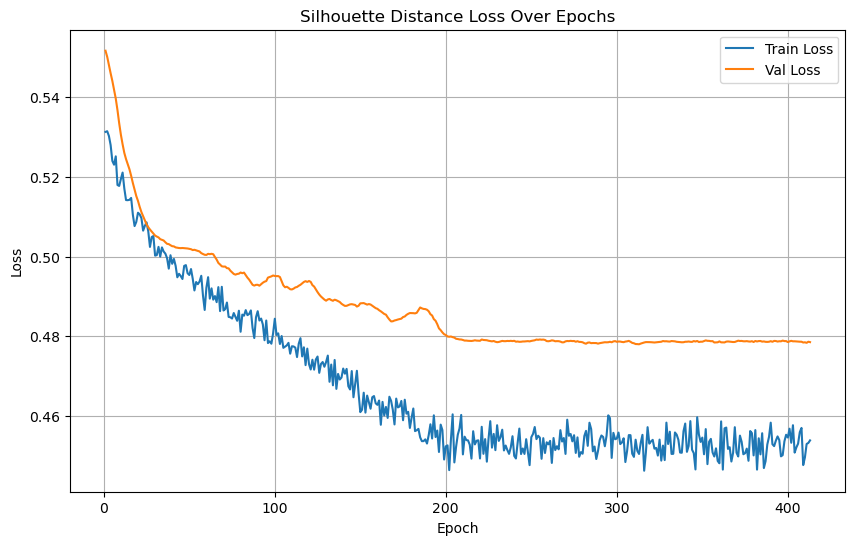

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/73], Loss: 0.3399
Test Batch [20/73], Loss: 0.1606
Test Batch [30/73], Loss: 0.2945
Test Batch [40/73], Loss: 0.5000
Test Batch [50/73], Loss: 0.4320
Test Batch [60/73], Loss: 0.4047
Test Batch [70/73], Loss: 0.3042

Test Loss: 0.3229


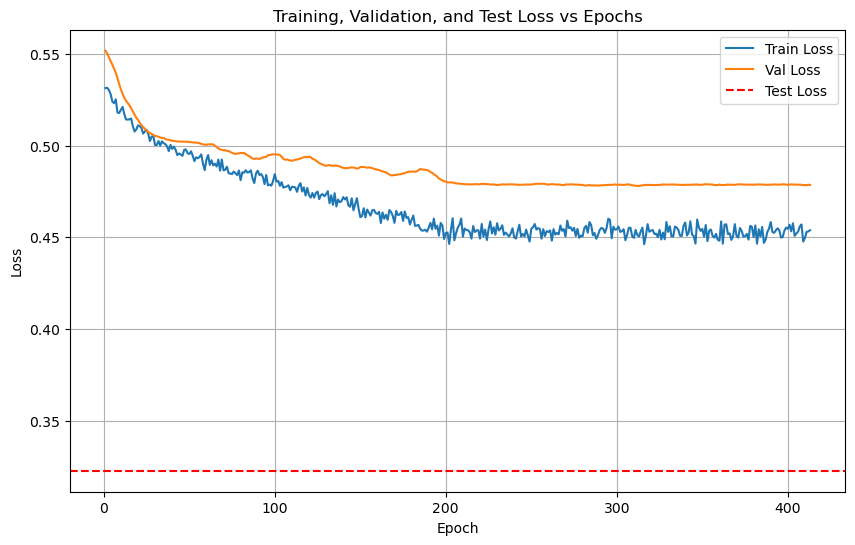

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...
  Processed batch 10/73 for test dataset.


  Processed batch 20/73 for test dataset.
  Processed batch 30/73 for test dataset.


  Processed batch 40/73 for test dataset.
  Processed batch 50/73 for test dataset.
  Processed batch 60/73 for test dataset.


  Processed batch 70/73 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (520, 128)
Train labels shape: (520,)
Val reps shape: (65, 128)
Val labels shape: (65,)
Test reps shape: (4626, 128)
Test labels shape: (4626,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 66.15%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.40      0.36         5
           1       0.75      0.60      0.67         5
           2       0.75      0.60      0.67         5
           3       0.33      0.20      0.25         5
           4       0.44      0.80      0.57         5
           5       0.33      0.40      0.36         5
           6       0.75      0.60      0.67         5
           7       0.67      0.40      0.50         5
           8       0.83      1.00      0.91         5
           9       1.00      0.60      0.75         5
          10       1.00      1.00      1.00         5
          11       0.83      1.00      0.91         5
          12       0.83      1.00      0.91         5

    accuracy         

## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (520, 128)
Train labels shape: (520,)
Val reps shape: (65, 128)
Val labels shape: (65,)
Test reps shape: (4626, 128)
Test labels shape: (4626,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.5690  |  Val Loss: 2.5590
Validation loss improved from inf to 2.5590.
[Epoch 2/1000] Train Loss: 2.5509  |  Val Loss: 2.5509
Validation loss improved from 2.5590 to 2.5509.
[Epoch 3/1000] Train Loss: 2.5352  |  Val Loss: 2.5435
Validation loss improved from 2.5509 to 2.5435.
[Epoch 4/1000] Train Loss: 2.5215  |  Val Loss: 2.5367
Validation loss improved from 2.5435 to 2.5367.
[Epoch 5/1000] Train Loss: 2.5088  |  Val Loss: 2.5304
Validation loss improved from 2.5367 to 2.5304.


[Epoch 6/1000] Train Loss: 2.4956  |  Val Loss: 2.5256
Validation loss improved from 2.5304 to 2.5256.
[Epoch 7/1000] Train Loss: 2.4829  |  Val Loss: 2.5214
Validation loss improved from 2.5256 to 2.5214.
[Epoch 8/1000] Train Loss: 2.4687  |  Val Loss: 2.5169
Validation loss improved from 2.5214 to 2.5169.
[Epoch 9/1000] Train Loss: 2.4548  |  Val Loss: 2.5125
Validation loss improved from 2.5169 to 2.5125.


[Epoch 10/1000] Train Loss: 2.4383  |  Val Loss: 2.5080
Validation loss improved from 2.5125 to 2.5080.
[Epoch 11/1000] Train Loss: 2.4244  |  Val Loss: 2.5028
Validation loss improved from 2.5080 to 2.5028.
[Epoch 12/1000] Train Loss: 2.4104  |  Val Loss: 2.4977
Validation loss improved from 2.5028 to 2.4977.


[Epoch 13/1000] Train Loss: 2.3971  |  Val Loss: 2.4929
Validation loss improved from 2.4977 to 2.4929.
[Epoch 14/1000] Train Loss: 2.3829  |  Val Loss: 2.4879
Validation loss improved from 2.4929 to 2.4879.
[Epoch 15/1000] Train Loss: 2.3701  |  Val Loss: 2.4824
Validation loss improved from 2.4879 to 2.4824.
[Epoch 16/1000] Train Loss: 2.3562  |  Val Loss: 2.4770
Validation loss improved from 2.4824 to 2.4770.
[Epoch 17/1000] Train Loss: 2.3415  |  Val Loss: 2.4713
Validation loss improved from 2.4770 to 2.4713.


[Epoch 18/1000] Train Loss: 2.3284  |  Val Loss: 2.4654
Validation loss improved from 2.4713 to 2.4654.
[Epoch 19/1000] Train Loss: 2.3152  |  Val Loss: 2.4592
Validation loss improved from 2.4654 to 2.4592.
[Epoch 20/1000] Train Loss: 2.3022  |  Val Loss: 2.4534
Validation loss improved from 2.4592 to 2.4534.
[Epoch 21/1000] Train Loss: 2.2893  |  Val Loss: 2.4467
Validation loss improved from 2.4534 to 2.4467.
[Epoch 22/1000] Train Loss: 2.2764  |  Val Loss: 2.4388
Validation loss improved from 2.4467 to 2.4388.


[Epoch 23/1000] Train Loss: 2.2643  |  Val Loss: 2.4316
Validation loss improved from 2.4388 to 2.4316.


[Epoch 24/1000] Train Loss: 2.2510  |  Val Loss: 2.4240
Validation loss improved from 2.4316 to 2.4240.
[Epoch 25/1000] Train Loss: 2.2383  |  Val Loss: 2.4164
Validation loss improved from 2.4240 to 2.4164.
[Epoch 26/1000] Train Loss: 2.2257  |  Val Loss: 2.4090
Validation loss improved from 2.4164 to 2.4090.
[Epoch 27/1000] Train Loss: 2.2129  |  Val Loss: 2.4019
Validation loss improved from 2.4090 to 2.4019.
[Epoch 28/1000] Train Loss: 2.2005  |  Val Loss: 2.3950
Validation loss improved from 2.4019 to 2.3950.
[Epoch 29/1000] Train Loss: 2.1878  |  Val Loss: 2.3879
Validation loss improved from 2.3950 to 2.3879.


[Epoch 30/1000] Train Loss: 2.1753  |  Val Loss: 2.3797
Validation loss improved from 2.3879 to 2.3797.
[Epoch 31/1000] Train Loss: 2.1630  |  Val Loss: 2.3704
Validation loss improved from 2.3797 to 2.3704.
[Epoch 32/1000] Train Loss: 2.1495  |  Val Loss: 2.3621
Validation loss improved from 2.3704 to 2.3621.
[Epoch 33/1000] Train Loss: 2.1363  |  Val Loss: 2.3536
Validation loss improved from 2.3621 to 2.3536.


[Epoch 34/1000] Train Loss: 2.1233  |  Val Loss: 2.3449
Validation loss improved from 2.3536 to 2.3449.
[Epoch 35/1000] Train Loss: 2.1102  |  Val Loss: 2.3362
Validation loss improved from 2.3449 to 2.3362.
[Epoch 36/1000] Train Loss: 2.0972  |  Val Loss: 2.3267
Validation loss improved from 2.3362 to 2.3267.
[Epoch 37/1000] Train Loss: 2.0838  |  Val Loss: 2.3167
Validation loss improved from 2.3267 to 2.3167.
[Epoch 38/1000] Train Loss: 2.0703  |  Val Loss: 2.3050
Validation loss improved from 2.3167 to 2.3050.
[Epoch 39/1000] Train Loss: 2.0560  |  Val Loss: 2.2956
Validation loss improved from 2.3050 to 2.2956.


[Epoch 40/1000] Train Loss: 2.0425  |  Val Loss: 2.2848
Validation loss improved from 2.2956 to 2.2848.
[Epoch 41/1000] Train Loss: 2.0288  |  Val Loss: 2.2738
Validation loss improved from 2.2848 to 2.2738.
[Epoch 42/1000] Train Loss: 2.0152  |  Val Loss: 2.2605
Validation loss improved from 2.2738 to 2.2605.
[Epoch 43/1000] Train Loss: 2.0024  |  Val Loss: 2.2489
Validation loss improved from 2.2605 to 2.2489.
[Epoch 44/1000] Train Loss: 1.9896  |  Val Loss: 2.2377
Validation loss improved from 2.2489 to 2.2377.


[Epoch 45/1000] Train Loss: 1.9765  |  Val Loss: 2.2268
Validation loss improved from 2.2377 to 2.2268.
[Epoch 46/1000] Train Loss: 1.9636  |  Val Loss: 2.2175
Validation loss improved from 2.2268 to 2.2175.
[Epoch 47/1000] Train Loss: 1.9509  |  Val Loss: 2.2087
Validation loss improved from 2.2175 to 2.2087.
[Epoch 48/1000] Train Loss: 1.9383  |  Val Loss: 2.1969
Validation loss improved from 2.2087 to 2.1969.
[Epoch 49/1000] Train Loss: 1.9246  |  Val Loss: 2.1866
Validation loss improved from 2.1969 to 2.1866.
[Epoch 50/1000] Train Loss: 1.9115  |  Val Loss: 2.1760
Validation loss improved from 2.1866 to 2.1760.
[Epoch 51/1000] Train Loss: 1.8980  |  Val Loss: 2.1644
Validation loss improved from 2.1760 to 2.1644.


[Epoch 52/1000] Train Loss: 1.8841  |  Val Loss: 2.1539
Validation loss improved from 2.1644 to 2.1539.
[Epoch 53/1000] Train Loss: 1.8708  |  Val Loss: 2.1412
Validation loss improved from 2.1539 to 2.1412.
[Epoch 54/1000] Train Loss: 1.8564  |  Val Loss: 2.1313
Validation loss improved from 2.1412 to 2.1313.
[Epoch 55/1000] Train Loss: 1.8426  |  Val Loss: 2.1198
Validation loss improved from 2.1313 to 2.1198.
[Epoch 56/1000] Train Loss: 1.8283  |  Val Loss: 2.1075
Validation loss improved from 2.1198 to 2.1075.
[Epoch 57/1000] Train Loss: 1.8150  |  Val Loss: 2.0994
Validation loss improved from 2.1075 to 2.0994.


[Epoch 58/1000] Train Loss: 1.8006  |  Val Loss: 2.0900
Validation loss improved from 2.0994 to 2.0900.
[Epoch 59/1000] Train Loss: 1.7864  |  Val Loss: 2.0783
Validation loss improved from 2.0900 to 2.0783.
[Epoch 60/1000] Train Loss: 1.7727  |  Val Loss: 2.0681
Validation loss improved from 2.0783 to 2.0681.
[Epoch 61/1000] Train Loss: 1.7587  |  Val Loss: 2.0576
Validation loss improved from 2.0681 to 2.0576.
[Epoch 62/1000] Train Loss: 1.7452  |  Val Loss: 2.0436
Validation loss improved from 2.0576 to 2.0436.
[Epoch 63/1000] Train Loss: 1.7317  |  Val Loss: 2.0366
Validation loss improved from 2.0436 to 2.0366.
[Epoch 64/1000] Train Loss: 1.7175  |  Val Loss: 2.0307
Validation loss improved from 2.0366 to 2.0307.


[Epoch 65/1000] Train Loss: 1.7032  |  Val Loss: 2.0217
Validation loss improved from 2.0307 to 2.0217.
[Epoch 66/1000] Train Loss: 1.6893  |  Val Loss: 2.0111
Validation loss improved from 2.0217 to 2.0111.
[Epoch 67/1000] Train Loss: 1.6747  |  Val Loss: 2.0013
Validation loss improved from 2.0111 to 2.0013.
[Epoch 68/1000] Train Loss: 1.6609  |  Val Loss: 1.9918
Validation loss improved from 2.0013 to 1.9918.


[Epoch 69/1000] Train Loss: 1.6471  |  Val Loss: 1.9835
Validation loss improved from 1.9918 to 1.9835.
[Epoch 70/1000] Train Loss: 1.6352  |  Val Loss: 1.9845
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 71/1000] Train Loss: 1.6216  |  Val Loss: 1.9735
Validation loss improved from 1.9835 to 1.9735.
[Epoch 72/1000] Train Loss: 1.6071  |  Val Loss: 1.9595
Validation loss improved from 1.9735 to 1.9595.
[Epoch 73/1000] Train Loss: 1.5924  |  Val Loss: 1.9500
Validation loss improved from 1.9595 to 1.9500.
[Epoch 74/1000] Train Loss: 1.5784  |  Val Loss: 1.9408
Validation loss improved from 1.9500 to 1.9408.
[Epoch 75/1000] Train Loss: 1.5646  |  Val Loss: 1.9355
Validation loss improved from 1.9408 to 1.9355.
[Epoch 76/1000] Train Loss: 1.5511  |  Val Loss: 1.9268
Validation loss improved from 1.9355 to 1.9268.


[Epoch 77/1000] Train Loss: 1.5367  |  Val Loss: 1.9214
Validation loss improved from 1.9268 to 1.9214.
[Epoch 78/1000] Train Loss: 1.5230  |  Val Loss: 1.9157
Validation loss improved from 1.9214 to 1.9157.
[Epoch 79/1000] Train Loss: 1.5097  |  Val Loss: 1.9065
Validation loss improved from 1.9157 to 1.9065.
[Epoch 80/1000] Train Loss: 1.4965  |  Val Loss: 1.9020
Validation loss improved from 1.9065 to 1.9020.


[Epoch 81/1000] Train Loss: 1.4823  |  Val Loss: 1.8960
Validation loss improved from 1.9020 to 1.8960.
[Epoch 82/1000] Train Loss: 1.4691  |  Val Loss: 1.8929
Validation loss improved from 1.8960 to 1.8929.
[Epoch 83/1000] Train Loss: 1.4562  |  Val Loss: 1.8879
Validation loss improved from 1.8929 to 1.8879.
[Epoch 84/1000] Train Loss: 1.4427  |  Val Loss: 1.8847
Validation loss improved from 1.8879 to 1.8847.
[Epoch 85/1000] Train Loss: 1.4301  |  Val Loss: 1.8842
Validation loss improved from 1.8847 to 1.8842.
[Epoch 86/1000] Train Loss: 1.4175  |  Val Loss: 1.8818
Validation loss improved from 1.8842 to 1.8818.
[Epoch 87/1000] Train Loss: 1.4057  |  Val Loss: 1.8767
Validation loss improved from 1.8818 to 1.8767.


[Epoch 88/1000] Train Loss: 1.3933  |  Val Loss: 1.8774
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 89/1000] Train Loss: 1.3812  |  Val Loss: 1.8743
Validation loss improved from 1.8767 to 1.8743.
[Epoch 90/1000] Train Loss: 1.3696  |  Val Loss: 1.8728
Validation loss improved from 1.8743 to 1.8728.
[Epoch 91/1000] Train Loss: 1.3588  |  Val Loss: 1.8707
Validation loss improved from 1.8728 to 1.8707.
[Epoch 92/1000] Train Loss: 1.3474  |  Val Loss: 1.8689
Validation loss improved from 1.8707 to 1.8689.


[Epoch 93/1000] Train Loss: 1.3362  |  Val Loss: 1.8619
Validation loss improved from 1.8689 to 1.8619.
[Epoch 94/1000] Train Loss: 1.3254  |  Val Loss: 1.8562
Validation loss improved from 1.8619 to 1.8562.
[Epoch 95/1000] Train Loss: 1.3149  |  Val Loss: 1.8550
Validation loss improved from 1.8562 to 1.8550.
[Epoch 96/1000] Train Loss: 1.3052  |  Val Loss: 1.8536
Validation loss improved from 1.8550 to 1.8536.
[Epoch 97/1000] Train Loss: 1.2955  |  Val Loss: 1.8581
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 98/1000] Train Loss: 1.2859  |  Val Loss: 1.8554
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 99/1000] Train Loss: 1.2770  |  Val Loss: 1.8514
Validation loss improved from 1.8536 to 1.8514.


[Epoch 100/1000] Train Loss: 1.2680  |  Val Loss: 1.8501
Validation loss improved from 1.8514 to 1.8501.
[Epoch 101/1000] Train Loss: 1.2593  |  Val Loss: 1.8588
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 102/1000] Train Loss: 1.2507  |  Val Loss: 1.8729
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 103/1000] Train Loss: 1.2432  |  Val Loss: 1.8766
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 104/1000] Train Loss: 1.2342  |  Val Loss: 1.8743
!! Validation loss did NOT improve !! Patience: 4/100


[Epoch 105/1000] Train Loss: 1.2262  |  Val Loss: 1.8778
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 106/1000] Train Loss: 1.2179  |  Val Loss: 1.8761
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 107/1000] Train Loss: 1.2100  |  Val Loss: 1.8751
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 108/1000] Train Loss: 1.2029  |  Val Loss: 1.8751
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 109/1000] Train Loss: 1.1954  |  Val Loss: 1.8755
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 110/1000] Train Loss: 1.1872  |  Val Loss: 1.8827
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 111/1000] Train Loss: 1.1800  |  Val Loss: 1.8891
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 112/1000] Train Loss: 1.1724  |  Val Loss: 1.8974
!! Validation loss did NOT improve !! Patience: 12/100


[Epoch 113/1000] Train Loss: 1.1649  |  Val Loss: 1.8932
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 114/1000] Train Loss: 1.1574  |  Val Loss: 1.8938
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 115/1000] Train Loss: 1.1509  |  Val Loss: 1.8919
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 116/1000] Train Loss: 1.1439  |  Val Loss: 1.8958
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 117/1000] Train Loss: 1.1365  |  Val Loss: 1.9022
!! Validation loss did NOT improve !! Patience: 17/100


[Epoch 118/1000] Train Loss: 1.1297  |  Val Loss: 1.9019
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 119/1000] Train Loss: 1.1236  |  Val Loss: 1.9053
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 120/1000] Train Loss: 1.1165  |  Val Loss: 1.9067
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 121/1000] Train Loss: 1.1106  |  Val Loss: 1.9015
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 122/1000] Train Loss: 1.1056  |  Val Loss: 1.9038
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 123/1000] Train Loss: 1.0980  |  Val Loss: 1.9024
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 124/1000] Train Loss: 1.0921  |  Val Loss: 1.9081
!! Validation loss did NOT improve !! Patience: 24/100


[Epoch 125/1000] Train Loss: 1.0863  |  Val Loss: 1.9138
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 126/1000] Train Loss: 1.0803  |  Val Loss: 1.9228
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 127/1000] Train Loss: 1.0750  |  Val Loss: 1.9358
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 128/1000] Train Loss: 1.0690  |  Val Loss: 1.9249
!! Validation loss did NOT improve !! Patience: 28/100


[Epoch 129/1000] Train Loss: 1.0631  |  Val Loss: 1.9180
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 130/1000] Train Loss: 1.0578  |  Val Loss: 1.9149
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 131/1000] Train Loss: 1.0515  |  Val Loss: 1.9255
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 132/1000] Train Loss: 1.0461  |  Val Loss: 1.9324
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 133/1000] Train Loss: 1.0403  |  Val Loss: 1.9313
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 134/1000] Train Loss: 1.0348  |  Val Loss: 1.9298
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 135/1000] Train Loss: 1.0297  |  Val Loss: 1.9338
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 136/1000] Train Loss: 1.0242  |  Val Loss: 1.9354
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 137/1000] Train Loss: 1.0191  |  Val Loss: 1.9440
!! Validation loss did NOT improve !! Patience:

[Epoch 138/1000] Train Loss: 1.0136  |  Val Loss: 1.9486
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 139/1000] Train Loss: 1.0084  |  Val Loss: 1.9628
!! Validation loss did NOT improve !! Patience: 39/100


[Epoch 140/1000] Train Loss: 1.0049  |  Val Loss: 1.9650
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 141/1000] Train Loss: 0.9998  |  Val Loss: 1.9625
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 142/1000] Train Loss: 0.9944  |  Val Loss: 1.9609
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 143/1000] Train Loss: 0.9891  |  Val Loss: 1.9658
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 144/1000] Train Loss: 0.9845  |  Val Loss: 1.9636
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 145/1000] Train Loss: 0.9802  |  Val Loss: 1.9649
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 146/1000] Train Loss: 0.9750  |  Val Loss: 1.9722
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 147/1000] Train Loss: 0.9704  |  Val Loss: 1.9777
!! Validation loss did NOT improve !! Patience: 47/100


[Epoch 148/1000] Train Loss: 0.9662  |  Val Loss: 1.9756
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 149/1000] Train Loss: 0.9629  |  Val Loss: 1.9830
!! Validation loss did NOT improve !! Patience: 49/100


[Epoch 150/1000] Train Loss: 0.9581  |  Val Loss: 1.9956
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 151/1000] Train Loss: 0.9531  |  Val Loss: 1.9997
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 152/1000] Train Loss: 0.9491  |  Val Loss: 1.9986
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 153/1000] Train Loss: 0.9437  |  Val Loss: 1.9982
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 154/1000] Train Loss: 0.9399  |  Val Loss: 2.0021
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 155/1000] Train Loss: 0.9356  |  Val Loss: 2.0038
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 156/1000] Train Loss: 0.9314  |  Val Loss: 2.0025
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 157/1000] Train Loss: 0.9268  |  Val Loss: 2.0072
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 158/1000] Train Loss: 0.9227  |  Val Loss: 2.0150
!! Validation loss did NOT improve !! Patience:

[Epoch 160/1000] Train Loss: 0.9144  |  Val Loss: 2.0188
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 161/1000] Train Loss: 0.9107  |  Val Loss: 2.0285
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 162/1000] Train Loss: 0.9067  |  Val Loss: 2.0339
!! Validation loss did NOT improve !! Patience: 62/100


[Epoch 163/1000] Train Loss: 0.9026  |  Val Loss: 2.0362
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 164/1000] Train Loss: 0.8987  |  Val Loss: 2.0354
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 165/1000] Train Loss: 0.8945  |  Val Loss: 2.0403
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 166/1000] Train Loss: 0.8904  |  Val Loss: 2.0382
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 167/1000] Train Loss: 0.8874  |  Val Loss: 2.0487
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 168/1000] Train Loss: 0.8828  |  Val Loss: 2.0446
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 169/1000] Train Loss: 0.8796  |  Val Loss: 2.0509
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 170/1000] Train Loss: 0.8755  |  Val Loss: 2.0470
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 171/1000] Train Loss: 0.8735  |  Val Loss: 2.0538
!! Validation loss did NOT improve !! Patience:

[Epoch 173/1000] Train Loss: 0.8645  |  Val Loss: 2.0795
!! Validation loss did NOT improve !! Patience: 73/100


[Epoch 174/1000] Train Loss: 0.8607  |  Val Loss: 2.0786
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 175/1000] Train Loss: 0.8581  |  Val Loss: 2.0703
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 176/1000] Train Loss: 0.8542  |  Val Loss: 2.0714
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 177/1000] Train Loss: 0.8508  |  Val Loss: 2.0774
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 178/1000] Train Loss: 0.8472  |  Val Loss: 2.0971
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 179/1000] Train Loss: 0.8445  |  Val Loss: 2.1062
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 180/1000] Train Loss: 0.8409  |  Val Loss: 2.1109
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 181/1000] Train Loss: 0.8388  |  Val Loss: 2.1047
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 182/1000] Train Loss: 0.8354  |  Val Loss: 2.1050
!! Validation loss did NOT improve !! Patience:

[Epoch 185/1000] Train Loss: 0.8240  |  Val Loss: 2.0932
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 186/1000] Train Loss: 0.8212  |  Val Loss: 2.0960
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 187/1000] Train Loss: 0.8182  |  Val Loss: 2.1162
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 188/1000] Train Loss: 0.8153  |  Val Loss: 2.1209
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 189/1000] Train Loss: 0.8125  |  Val Loss: 2.1239
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 190/1000] Train Loss: 0.8092  |  Val Loss: 2.1238
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 191/1000] Train Loss: 0.8067  |  Val Loss: 2.1239
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 192/1000] Train Loss: 0.8036  |  Val Loss: 2.1221
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 193/1000] Train Loss: 0.8001  |  Val Loss: 2.1221
!! Validation loss did NOT improve !! Patience:

[Epoch 196/1000] Train Loss: 0.7916  |  Val Loss: 2.1510
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 197/1000] Train Loss: 0.7892  |  Val Loss: 2.1653
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 198/1000] Train Loss: 0.7862  |  Val Loss: 2.1551
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 199/1000] Train Loss: 0.7838  |  Val Loss: 2.1514
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 200/1000] Train Loss: 0.7809  |  Val Loss: 2.1555
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 200 !!
No improvement for 100 epochs.


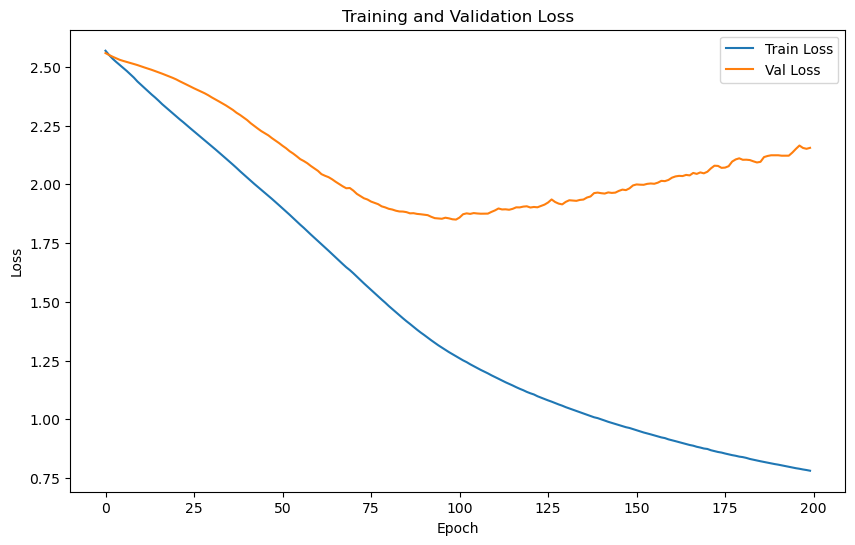

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 3.0422 | Test Accuracy: 61.61%


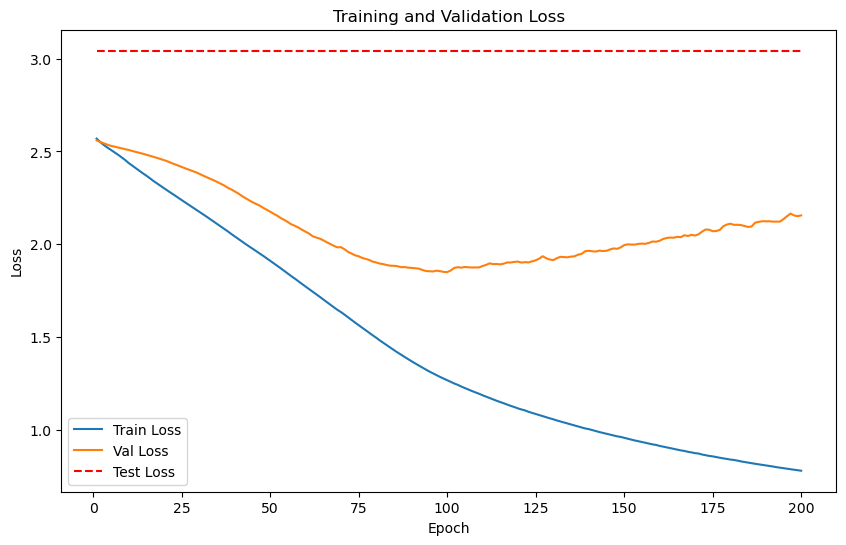

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


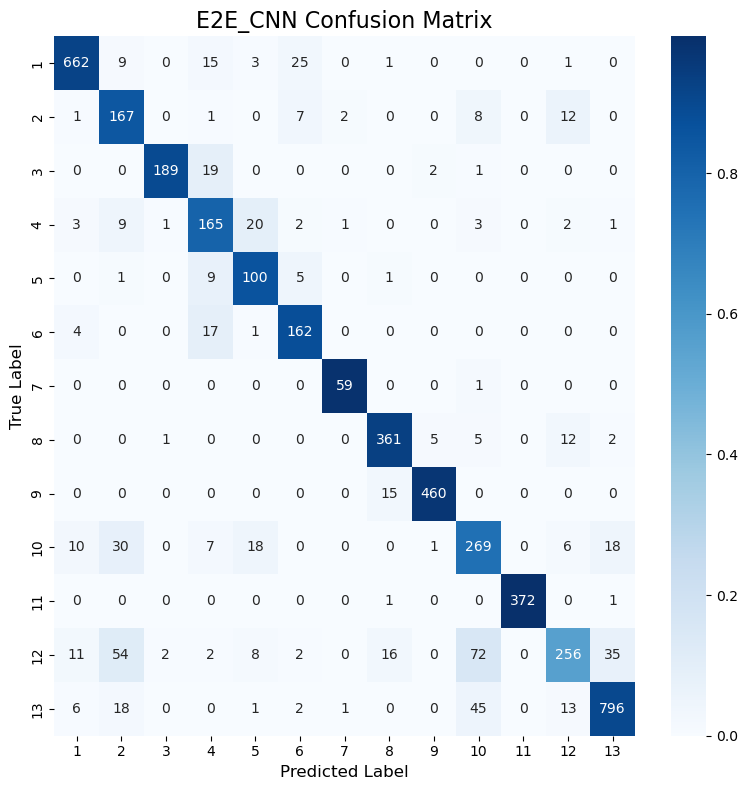

Classification Accuracy: 86.86%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


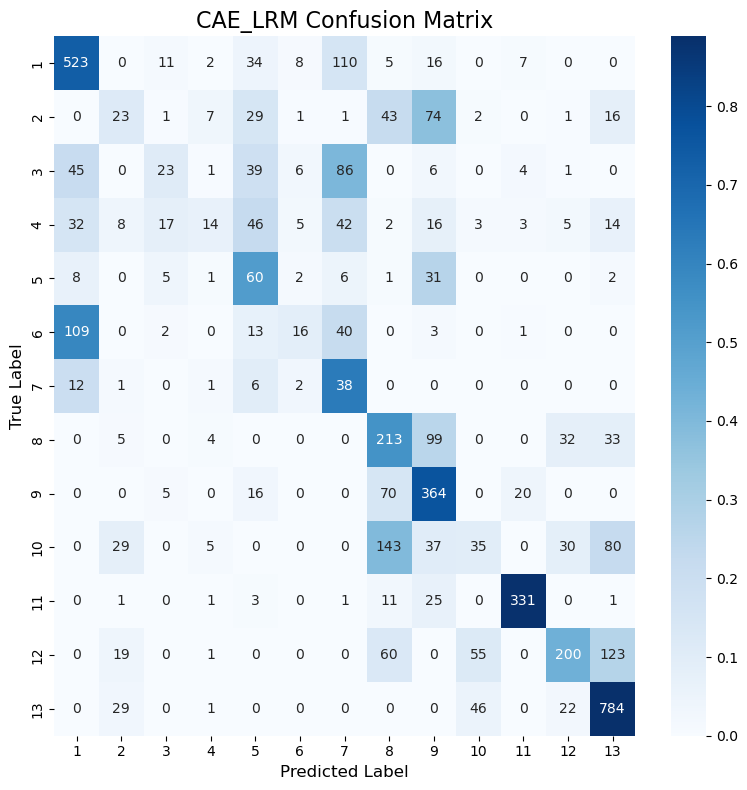

Classification Accuracy: 56.72%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


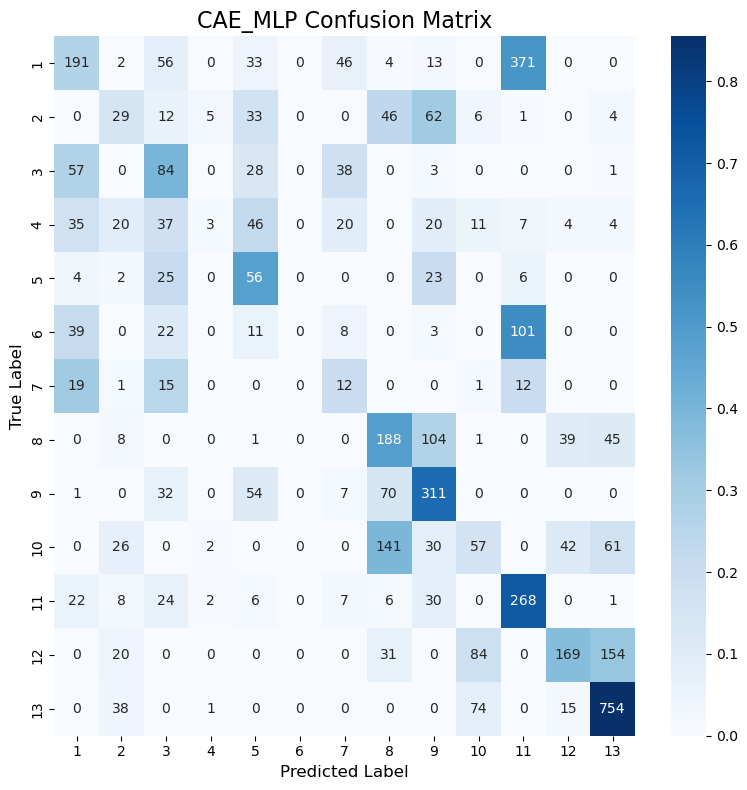

Classification Accuracy: 45.87%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


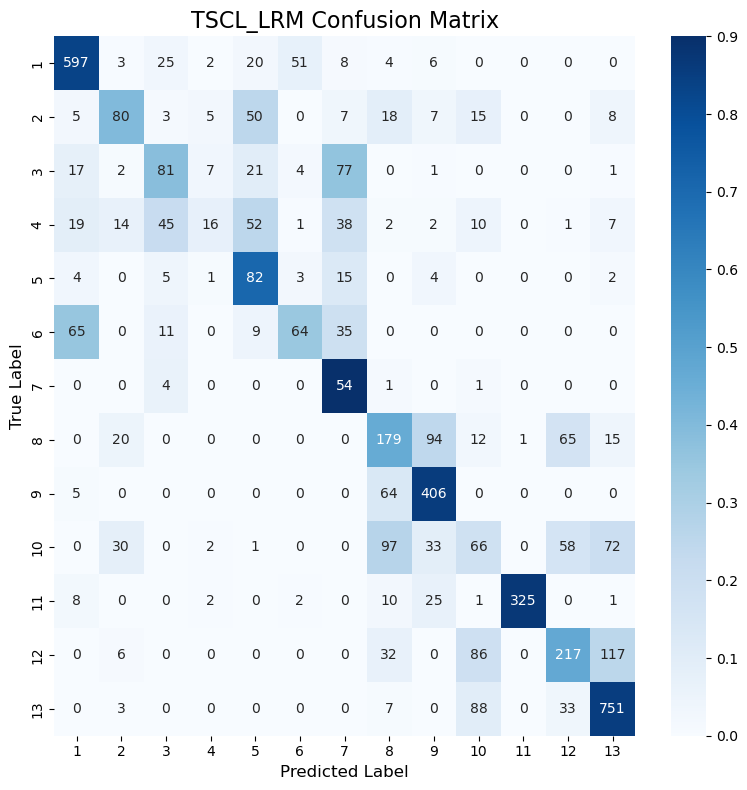

Classification Accuracy: 63.08%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


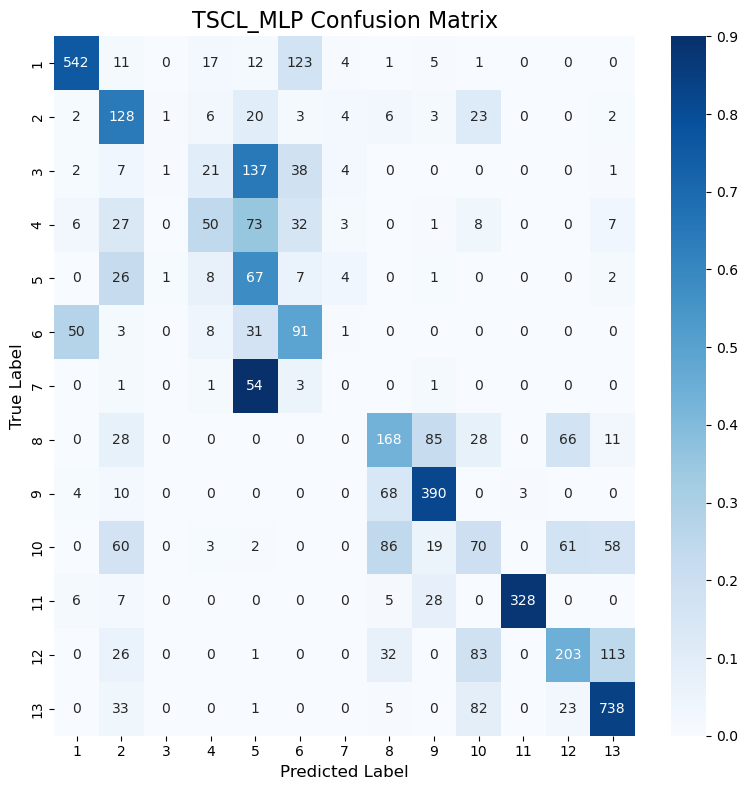

Classification Accuracy: 60.01%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


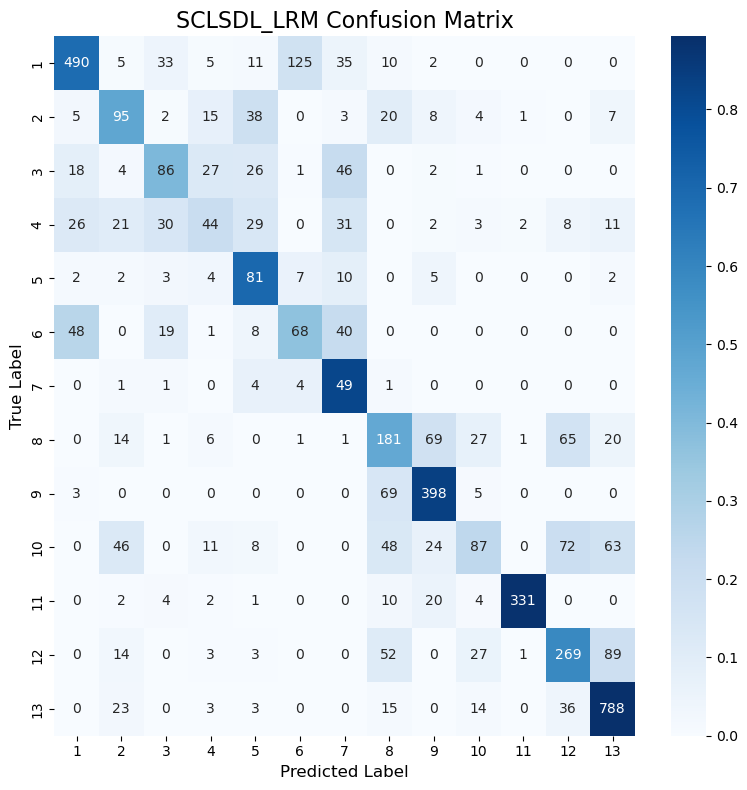

Classification Accuracy: 64.14%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


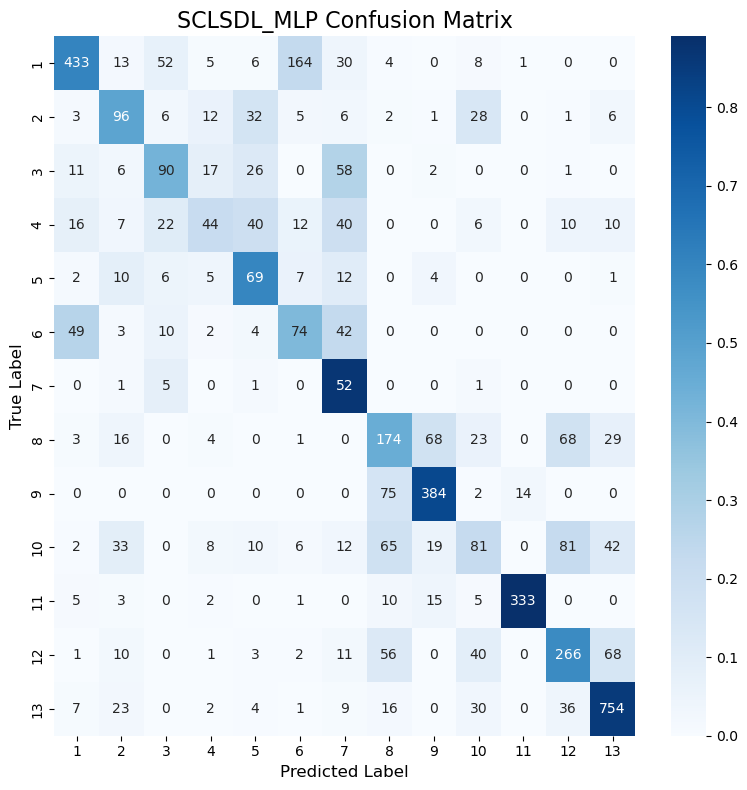

Classification Accuracy: 61.61%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          86.86
1    LRM (CAE)          56.72
2    MLP (CAE)          45.87
3     TSCL LRM          63.08
4     TSCL MLP          60.01
5  SCL_SDL LRM          64.14
6  SCL_SDL MLP          61.61

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          86.86
5  SCL_SDL LRM          64.14
3     TSCL LRM          63.08
6  SCL_SDL MLP          61.61
4     TSCL MLP          60.01
1    LRM (CAE)          56.72
2    MLP (CAE)          45.87
